# 100 K Part 1

# Import of Libraries

In [1]:
import pandas as pd
import sys, time
import csv
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputRegressor      # necessary because we have multiple output
from sklearn.linear_model import LinearRegression         # 1 model -> Linear Regression
from sklearn.tree import DecisionTreeRegressor            # 2 model -> Decision Tree
from sklearn.neighbors import KNeighborsRegressor         # 3 model -> KNN
from sklearn.svm import SVR                               # 4 model -> SVM
from sklearn.ensemble import RandomForestRegressor        # 5 model -> Random Forest (a set of decision tree)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import ParameterGrid
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# Dataset
The dataset is a file .csv composed by these attributes joint angles: j0, j1, cos(j0), cos(j1), sin(j0), sin(j1), fingertip position: ft_x, ft_y ft_qw, ft_qz. The file is created by following the professor code present in this [repository](https://github.com/iocchi/MLexercises.git) and saving the generated file on google drive.



In [2]:
#connect to google drive for install the file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploring the dataset

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Machine_Learning/HW1/dataset/logfile_r2.csv",sep=';')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   j0       100000 non-null  float64
 1   j1       100000 non-null  float64
 2   cos(j0)  100000 non-null  float64
 3   cos(j1)  100000 non-null  float64
 4   sin(j0)  100000 non-null  float64
 5   sin(j1)  100000 non-null  float64
 6   ft_x     100000 non-null  float64
 7   ft_y     100000 non-null  float64
 8   ft_qw    100000 non-null  float64
 9   ft_qz    100000 non-null  float64
dtypes: float64(10)
memory usage: 7.6 MB


In [ ]:
df.describe()

j0             j1        cos(j0)        cos(j1)  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       -0.003380      -0.049218      -0.238527      -0.206435   
std         2.159701       2.076128       0.732016       0.724354   
min        -3.368000      -3.278000      -1.000000      -1.000000   
25%        -2.076000      -2.055000      -0.959000      -0.921000   
50%         0.012000      -0.103000      -0.474000      -0.413000   
75%         2.055000       1.938000       0.482000       0.506000   
max         3.361000       3.230000       1.000000       1.000000   

             sin(j0)        sin(j1)           ft_x           ft_y  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.003882      -0.013433      -0.018636       0.000540   
std         0.638176       0.657672       0.095383       0.090075   
min        -1.000000      -1.000000      -0.210000      -0.210000   
25%        -0.563000      -0.622000      -0.080000      -0.055000   
50%         0.001000      -0.054000      -0.009000       0.001000   
75%         0.572000       0.591000       0.028000       0.058000   
max         1.000000       1.000000       0.210000       0.210000   

               ft_qw          ft_qz  
count  100000.000000  100000.000000  
mean        0.251633      -0.008543  
std         0.678526       0.690093  
min        -1.000000      -1.000000  
25%        -0.353250      -0.683000  
50%         0.449000      -0.017000  
75%         0.894000       0.665000  
max         1.000000       1.000000

In [ ]:
df.head()

j0     j1  cos(j0)  cos(j1)  sin(j0)  sin(j1)   ft_x   ft_y  ft_qw  \
0  0.004  0.021      1.0    1.000    0.004    0.021  0.210  0.003  1.000   
1  0.006  0.029      1.0    1.000    0.006    0.029  0.210  0.004  1.000   
2  0.007  0.022      1.0    1.000    0.007    0.022  0.210  0.004  1.000   
3  0.008 -0.033      1.0    0.999    0.008   -0.033  0.210 -0.002  1.000   
4 -0.006 -0.091      1.0    0.996   -0.006   -0.091  0.209 -0.011  0.999   

   ft_qz  
0  0.013  
1  0.017  
2  0.014  
3 -0.013  
4 -0.049

In [ ]:
# Check for null values in each column
null_values = df.isnull().sum()

null_columns = null_values[null_values > 0]

if not null_columns.empty:
    print("Columns with missing values:")
    print(null_columns)
else:
    print("No missing values in the dataset.")

No missing values in the dataset.


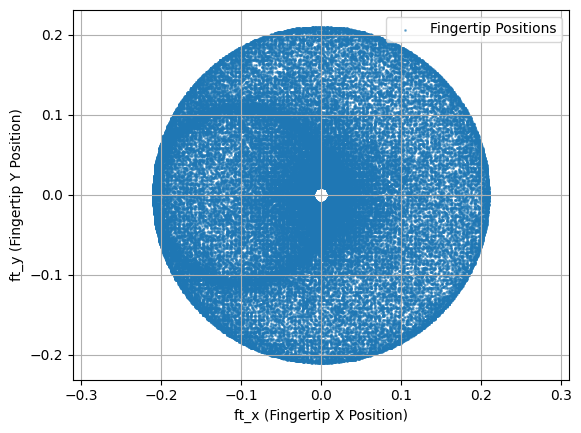

In [ ]:
# compute heatmap
df_filtered = df[['j0', 'j1', 'ft_x', 'ft_y']]
plt.scatter(df_filtered['ft_x'], df_filtered['ft_y'], s=1, alpha=0.5, label='Fingertip Positions')
plt.xlabel('ft_x (Fingertip X Position)')
plt.ylabel('ft_y (Fingertip Y Position)')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Mantieni proporzioni reali per x e y
plt.show()

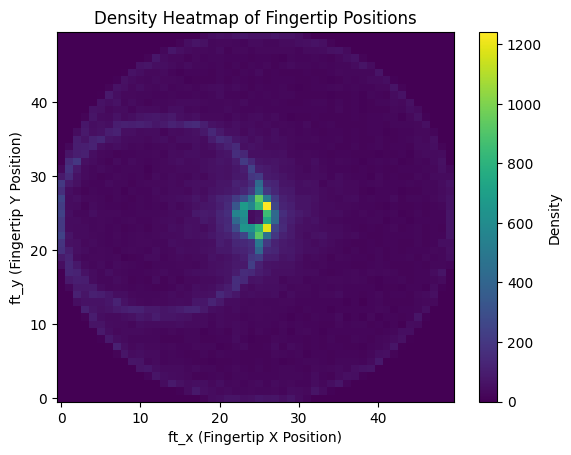

In [ ]:
# compute the heatmap
heatmap, xedges, yedges = np.histogram2d(df_filtered['ft_x'], df_filtered['ft_y'], bins=50)

# visualize heatmap
plt.imshow(heatmap.T, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Density')
plt.xlabel('ft_x (Fingertip X Position)')
plt.ylabel('ft_y (Fingertip Y Position)')
plt.title('Density Heatmap of Fingertip Positions')
plt.show()

## Creation of Dataset for Training Validation and Test
At the begin what will do is split the dataset in traing validation and test after i will use one file for traing/validation and another for test in order to see how model perform with data (position od finger tips) never seen before



In [4]:
# Select few columns
df_filtered = df[['j0', 'j1', 'ft_x', 'ft_y']]

# Define features (X) and target (Y)
X = df_filtered[['j0', 'j1']]
y = df_filtered[['ft_x', 'ft_y']]

# Split into training+validation and test sets (80% training+validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation set into training and validation sets (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Summary of the splits
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 60000
Validation set size: 20000
Test set size: 20000


# Model


In [6]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    return rmse, r2

## 1 Model Linear Regression

In [7]:
# train
lr = MultiOutputRegressor(LinearRegression())
lr.fit(X_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [8]:
# test
warnings.filterwarnings("ignore")
lr_rmse, lr_r2 = evaluate_model(lr, X_test, y_test)
print(f"Linear Regression RMSE: {lr_rmse}, R2: {lr_r2}")


Linear Regression RMSE: 0.0897855340821489, R2: 0.06741245276816066


The model has low errors on average (small MSE) but does not generalize well (low R2) to explain the variance in the data.
This combination indicate that model is underfitting so that mean Linear Regressin is not complex enough to capture these patterns.

## 2 Model Decision Tree Regressor

In [9]:
# test
dt_param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 20]
}
dt = DecisionTreeRegressor()
dt_grid = GridSearchCV(dt, dt_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [10]:
# test
best_dt = dt_grid.best_estimator_
dt_rmse, dt_r2 = evaluate_model(best_dt, X_test, y_test)
print(f"Decision Tree Best Params: {dt_grid.best_params_}")
print(f"Decision Tree RMSE: {dt_rmse}, R2: {dt_r2}")

Decision Tree Best Params: {'max_depth': 20, 'splitter': 'best'}
Decision Tree RMSE: 0.0022453268128118657, R2: 0.9994150937809528


## 3 Model SVR

In [11]:
# train
svr_param_grid = {
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__C': [0.1, 1, 10],
    'estimator__epsilon': [0.01, 0.1, 1],
    'estimator__max_iter': [50]
}
svr = MultiOutputRegressor(SVR())
svr_grid = GridSearchCV(svr, svr_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
svr_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=MultiOutputRegressor(estimator=SVR()), n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10],
                         'estimator__epsilon': [0.01, 0.1, 1],
                         'estimator__kernel': ['linear', 'rbf'],
                         'estimator__max_iter': [50]},
             scoring='neg_mean_squared_error')

In [12]:
# test
best_svr = svr_grid.best_estimator_
svr_rmse, svr_r2 = evaluate_model(best_svr, X_test, y_test)
print(f"SVR Best Params: {svr_grid.best_params_}")
print(f"SVR RMSE: {svr_rmse}, R2: {svr_r2}")

SVR Best Params: {'estimator__C': 1, 'estimator__epsilon': 0.01, 'estimator__kernel': 'rbf', 'estimator__max_iter': 50}
SVR RMSE: 0.019846213881351233, R2: 0.9520348619612518


## 4 Model Random Forest Regressor


In [13]:
# train
rf_param_grid = {
    'estimator__n_estimators': [100, 150],
    'estimator__max_depth': [5, 12]
}
rf = MultiOutputRegressor(RandomForestRegressor(random_state=42))
rf_grid = GridSearchCV(rf, rf_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [5, 12],
                         'estimator__n_estimators': [100, 150]},
             scoring='neg_mean_squared_error')

In [14]:
#test
best_rf = rf_grid.best_estimator_
rf_rmse, rf_r2 = evaluate_model(best_rf, X_test, y_test)
print(f"Random Forest Best Params: {rf_grid.best_params_}")
print(f"Random Forest RMSE: {rf_rmse}, R2: {rf_r2}")

Random Forest Best Params: {'estimator__max_depth': 12, 'estimator__n_estimators': 150}
Random Forest RMSE: 0.005259835141469384, R2: 0.9967991344681727


## 5 Model KNN regressor

In [15]:
# train
knn_param_grid = {
    'estimator__n_neighbors': [3, 5, 10],
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}
knn = MultiOutputRegressor(KNeighborsRegressor())
knn_grid = GridSearchCV(knn, knn_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=KNeighborsRegressor()),
             n_jobs=-1,
             param_grid={'estimator__n_neighbors': [3, 5, 10],
                         'estimator__p': [1, 2],
                         'estimator__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [16]:
#test
best_knn = knn_grid.best_estimator_
knn_rmse, knn_r2 = evaluate_model(best_knn, X_test, y_test)
print(f"KNN Best Params: {knn_grid.best_params_}")
print(f"KNN RMSE: {knn_rmse}, R2: {knn_r2}")

KNN Best Params: {'estimator__n_neighbors': 10, 'estimator__p': 2, 'estimator__weights': 'distance'}
KNN RMSE: 0.0010309962429658718, R2: 0.9998762531205969


## 6 Model NN Neural Network
This will be the actual model that i will use for train. More in detail



In [5]:
# Conversion of data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_sizes):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        input_size = 2  # two input features: j0 and j1
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

        # Output layer
        output_size = 2  # output: ft_x and ft_y
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:  # Apply ReLU to all hidden layers
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.001],
    'hidden_sizes': [[8, 16, 8], [8, 16, 32, 16, 8], [16, 32, 64, 32, 16]],
    'optimizer': ['Adam', 'SGD']
}
grid = ParameterGrid(param_grid)

epochs = 50
best_val_loss = float('inf')
save_path = "/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models"

all_train_losses = []
all_val_losses = []
best_model_info = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "model_state_dict": None,
    "optimizer_state_dict": None,
    "hyperparameters": {}
}

In [ ]:
for params in grid:
    # Initialize model and criterion
    model = NeuralNetwork(hidden_sizes=params['hidden_sizes'])
    criterion = nn.MSELoss()

    # Choose optimizer based on parameter grid
    if params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'])

    # Track losses for each epoch
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in tqdm(range(epochs), desc=f"Training Model with LR={params['learning_rate']}, Layers={params['hidden_sizes']}, Optimizer={params['optimizer']}"):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        train_loss = criterion(outputs, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)

        # Store losses
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Check if this model is the best so far based on validation loss
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_info = {
                "epoch": epoch + 1,
                "train_loss": train_loss.item(),
                "val_loss": val_loss.item(),
                "model_state_dict": model.state_dict(),  # Store the best model weights
                "optimizer_state_dict": optimizer.state_dict(),  # Save the best optimizer state
                "hyperparameters": params  # Save the best hyperparameters for model reconstruction
            }

        # Update tqdm description with current losses
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

    # Save all losses for plotting
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

# Save the best model information to a file
torch.save(best_model_info, os.path.join(save_path, "SMALL_best_model_info.pt"))

# Print the best hyperparameters
print("Best Model Parameters:")
print("Learning Rate:", best_model_info['hyperparameters']['learning_rate'])
print("Hidden Layer Sizes:", best_model_info['hyperparameters']['hidden_sizes'])
print("Optimizer:", best_model_info['hyperparameters']['optimizer'])
print("Best Validation Loss:", best_val_loss)

Epoch [1/50], Training Loss: 0.0263, Validation Loss: 0.0174
Epoch [2/50], Training Loss: 0.0173, Validation Loss: 0.0137
Epoch [3/50], Training Loss: 0.0136, Validation Loss: 0.0116
Epoch [4/50], Training Loss: 0.0115, Validation Loss: 0.0101
Epoch [5/50], Training Loss: 0.0100, Validation Loss: 0.0090
Epoch [6/50], Training Loss: 0.0090, Validation Loss: 0.0085
Epoch [7/50], Training Loss: 0.0085, Validation Loss: 0.0086


Epoch [8/50], Training Loss: 0.0086, Validation Loss: 0.0088
Epoch [9/50], Training Loss: 0.0089, Validation Loss: 0.0090
Epoch [10/50], Training Loss: 0.0090, Validation Loss: 0.0088
Epoch [11/50], Training Loss: 0.0088, Validation Loss: 0.0082
Epoch [12/50], Training Loss: 0.0083, Validation Loss: 0.0077
Epoch [13/50], Training Loss: 0.0077, Validation Loss: 0.0073
Epoch [14/50], Training Loss: 0.0073, Validation Loss: 0.0071


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  40%|████      | 20/50 [00:00<00:00, 35.13it/s]

Epoch [15/50], Training Loss: 0.0071, Validation Loss: 0.0071
Epoch [16/50], Training Loss: 0.0071, Validation Loss: 0.0071
Epoch [17/50], Training Loss: 0.0071, Validation Loss: 0.0072
Epoch [18/50], Training Loss: 0.0072, Validation Loss: 0.0073
Epoch [19/50], Training Loss: 0.0073, Validation Loss: 0.0073
Epoch [20/50], Training Loss: 0.0073, Validation Loss: 0.0073
Epoch [21/50], Training Loss: 0.0073, Validation Loss: 0.0072
Epoch [22/50], Training Loss: 0.0071, Validation Loss: 0.0070


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.86it/s]

Epoch [23/50], Training Loss: 0.0069, Validation Loss: 0.0067
Epoch [24/50], Training Loss: 0.0067, Validation Loss: 0.0065
Epoch [25/50], Training Loss: 0.0065, Validation Loss: 0.0063
Epoch [26/50], Training Loss: 0.0063, Validation Loss: 0.0062
Epoch [27/50], Training Loss: 0.0062, Validation Loss: 0.0061
Epoch [28/50], Training Loss: 0.0061, Validation Loss: 0.0060
Epoch [29/50], Training Loss: 0.0060, Validation Loss: 0.0060
Epoch [30/50], Training Loss: 0.0060, Validation Loss: 0.0060


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.60it/s]

Epoch [31/50], Training Loss: 0.0060, Validation Loss: 0.0059
Epoch [32/50], Training Loss: 0.0059, Validation Loss: 0.0058
Epoch [33/50], Training Loss: 0.0058, Validation Loss: 0.0057
Epoch [34/50], Training Loss: 0.0057, Validation Loss: 0.0055
Epoch [35/50], Training Loss: 0.0056, Validation Loss: 0.0054
Epoch [36/50], Training Loss: 0.0054, Validation Loss: 0.0053
Epoch [37/50], Training Loss: 0.0053, Validation Loss: 0.0052


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.41it/s]

Epoch [38/50], Training Loss: 0.0052, Validation Loss: 0.0051
Epoch [39/50], Training Loss: 0.0051, Validation Loss: 0.0050
Epoch [40/50], Training Loss: 0.0050, Validation Loss: 0.0049
Epoch [41/50], Training Loss: 0.0049, Validation Loss: 0.0048
Epoch [42/50], Training Loss: 0.0048, Validation Loss: 0.0047
Epoch [43/50], Training Loss: 0.0047, Validation Loss: 0.0046
Epoch [44/50], Training Loss: 0.0046, Validation Loss: 0.0045


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 33.25it/s]


Epoch [45/50], Training Loss: 0.0045, Validation Loss: 0.0043
Epoch [46/50], Training Loss: 0.0043, Validation Loss: 0.0042
Epoch [47/50], Training Loss: 0.0042, Validation Loss: 0.0041
Epoch [48/50], Training Loss: 0.0041, Validation Loss: 0.0040
Epoch [49/50], Training Loss: 0.0040, Validation Loss: 0.0039
Epoch [50/50], Training Loss: 0.0039, Validation Loss: 0.0038


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.1002, Validation Loss: 0.0974


Epoch [2/50], Training Loss: 0.0974, Validation Loss: 0.0947
Epoch [3/50], Training Loss: 0.0947, Validation Loss: 0.0921
Epoch [4/50], Training Loss: 0.0921, Validation Loss: 0.0896
Epoch [5/50], Training Loss: 0.0895, Validation Loss: 0.0871
Epoch [6/50], Training Loss: 0.0871, Validation Loss: 0.0848


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:   8%|▊         | 4/50 [00:00<00:01, 31.11it/s]

Epoch [7/50], Training Loss: 0.0848, Validation Loss: 0.0825


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:01, 30.81it/s]

Epoch [8/50], Training Loss: 0.0825, Validation Loss: 0.0803
Epoch [9/50], Training Loss: 0.0803, Validation Loss: 0.0782
Epoch [10/50], Training Loss: 0.0781, Validation Loss: 0.0761
Epoch [11/50], Training Loss: 0.0761, Validation Loss: 0.0741
Epoch [12/50], Training Loss: 0.0741, Validation Loss: 0.0722
Epoch [13/50], Training Loss: 0.0722, Validation Loss: 0.0703


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:01, 30.81it/s]

Epoch [14/50], Training Loss: 0.0703, Validation Loss: 0.0685


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  40%|████      | 20/50 [00:00<00:00, 30.37it/s]

Epoch [15/50], Training Loss: 0.0685, Validation Loss: 0.0668
Epoch [16/50], Training Loss: 0.0668, Validation Loss: 0.0651
Epoch [17/50], Training Loss: 0.0651, Validation Loss: 0.0635
Epoch [18/50], Training Loss: 0.0634, Validation Loss: 0.0619
Epoch [19/50], Training Loss: 0.0619, Validation Loss: 0.0604
Epoch [20/50], Training Loss: 0.0603, Validation Loss: 0.0589


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  40%|████      | 20/50 [00:00<00:00, 30.37it/s]

Epoch [21/50], Training Loss: 0.0589, Validation Loss: 0.0575


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:00<00:00, 30.13it/s]

Epoch [22/50], Training Loss: 0.0574, Validation Loss: 0.0561
Epoch [23/50], Training Loss: 0.0561, Validation Loss: 0.0548
Epoch [24/50], Training Loss: 0.0547, Validation Loss: 0.0535
Epoch [25/50], Training Loss: 0.0534, Validation Loss: 0.0522
Epoch [26/50], Training Loss: 0.0522, Validation Loss: 0.0510


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:00<00:00, 30.13it/s]

Epoch [27/50], Training Loss: 0.0510, Validation Loss: 0.0498


Epoch [28/50], Training Loss: 0.0498, Validation Loss: 0.0487
Epoch [29/50], Training Loss: 0.0487, Validation Loss: 0.0476
Epoch [30/50], Training Loss: 0.0476, Validation Loss: 0.0465
Epoch [31/50], Training Loss: 0.0465, Validation Loss: 0.0455
Epoch [32/50], Training Loss: 0.0455, Validation Loss: 0.0445


Epoch [33/50], Training Loss: 0.0445, Validation Loss: 0.0435


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  78%|███████▊  | 39/50 [00:01<00:00, 29.97it/s]

Epoch [34/50], Training Loss: 0.0435, Validation Loss: 0.0426
Epoch [35/50], Training Loss: 0.0425, Validation Loss: 0.0416
Epoch [36/50], Training Loss: 0.0416, Validation Loss: 0.0408
Epoch [37/50], Training Loss: 0.0407, Validation Loss: 0.0399
Epoch [38/50], Training Loss: 0.0399, Validation Loss: 0.0391
Epoch [39/50], Training Loss: 0.0390, Validation Loss: 0.0383


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  78%|███████▊  | 39/50 [00:01<00:00, 29.97it/s]

Epoch [40/50], Training Loss: 0.0382, Validation Loss: 0.0375


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  86%|████████▌ | 43/50 [00:01<00:00, 30.16it/s]

Epoch [41/50], Training Loss: 0.0375, Validation Loss: 0.0367
Epoch [42/50], Training Loss: 0.0367, Validation Loss: 0.0360
Epoch [43/50], Training Loss: 0.0360, Validation Loss: 0.0353
Epoch [44/50], Training Loss: 0.0352, Validation Loss: 0.0346
Epoch [45/50], Training Loss: 0.0346, Validation Loss: 0.0339
Epoch [46/50], Training Loss: 0.0339, Validation Loss: 0.0333


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:01<00:00, 29.71it/s]


Epoch [47/50], Training Loss: 0.0332, Validation Loss: 0.0326
Epoch [48/50], Training Loss: 0.0326, Validation Loss: 0.0320
Epoch [49/50], Training Loss: 0.0320, Validation Loss: 0.0315
Epoch [50/50], Training Loss: 0.0314, Validation Loss: 0.0309


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0084, Validation Loss: 0.0081
Epoch [2/50], Training Loss: 0.0081, Validation Loss: 0.0078
Epoch [3/50], Training Loss: 0.0078, Validation Loss: 0.0076


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:01, 36.22it/s]

Epoch [4/50], Training Loss: 0.0076, Validation Loss: 0.0074
Epoch [5/50], Training Loss: 0.0074, Validation Loss: 0.0072
Epoch [6/50], Training Loss: 0.0072, Validation Loss: 0.0071
Epoch [7/50], Training Loss: 0.0071, Validation Loss: 0.0070


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.62it/s]

Epoch [8/50], Training Loss: 0.0070, Validation Loss: 0.0069
Epoch [9/50], Training Loss: 0.0069, Validation Loss: 0.0068
Epoch [10/50], Training Loss: 0.0068, Validation Loss: 0.0067


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.32it/s]

Epoch [11/50], Training Loss: 0.0066, Validation Loss: 0.0066
Epoch [12/50], Training Loss: 0.0065, Validation Loss: 0.0065
Epoch [13/50], Training Loss: 0.0064, Validation Loss: 0.0064
Epoch [14/50], Training Loss: 0.0063, Validation Loss: 0.0063


Epoch [15/50], Training Loss: 0.0062, Validation Loss: 0.0062
Epoch [16/50], Training Loss: 0.0061, Validation Loss: 0.0061
Epoch [17/50], Training Loss: 0.0061, Validation Loss: 0.0060


Epoch [18/50], Training Loss: 0.0060, Validation Loss: 0.0059
Epoch [19/50], Training Loss: 0.0059, Validation Loss: 0.0058
Epoch [20/50], Training Loss: 0.0058, Validation Loss: 0.0058
Epoch [21/50], Training Loss: 0.0058, Validation Loss: 0.0057


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.78it/s]

Epoch [22/50], Training Loss: 0.0057, Validation Loss: 0.0056
Epoch [23/50], Training Loss: 0.0056, Validation Loss: 0.0056
Epoch [24/50], Training Loss: 0.0056, Validation Loss: 0.0055
Epoch [25/50], Training Loss: 0.0055, Validation Loss: 0.0054


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.73it/s]

Epoch [26/50], Training Loss: 0.0054, Validation Loss: 0.0054
Epoch [27/50], Training Loss: 0.0054, Validation Loss: 0.0053
Epoch [28/50], Training Loss: 0.0053, Validation Loss: 0.0053
Epoch [29/50], Training Loss: 0.0053, Validation Loss: 0.0052


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.68it/s]

Epoch [30/50], Training Loss: 0.0052, Validation Loss: 0.0051
Epoch [31/50], Training Loss: 0.0051, Validation Loss: 0.0051
Epoch [32/50], Training Loss: 0.0051, Validation Loss: 0.0050
Epoch [33/50], Training Loss: 0.0050, Validation Loss: 0.0050


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.75it/s]

Epoch [34/50], Training Loss: 0.0050, Validation Loss: 0.0049
Epoch [35/50], Training Loss: 0.0049, Validation Loss: 0.0048
Epoch [36/50], Training Loss: 0.0048, Validation Loss: 0.0048


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  80%|████████  | 40/50 [00:01<00:00, 32.97it/s]

Epoch [37/50], Training Loss: 0.0048, Validation Loss: 0.0047
Epoch [38/50], Training Loss: 0.0047, Validation Loss: 0.0047
Epoch [39/50], Training Loss: 0.0047, Validation Loss: 0.0046
Epoch [40/50], Training Loss: 0.0046, Validation Loss: 0.0046


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  80%|████████  | 40/50 [00:01<00:00, 32.97it/s]

Epoch [41/50], Training Loss: 0.0046, Validation Loss: 0.0045
Epoch [42/50], Training Loss: 0.0045, Validation Loss: 0.0045


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.29it/s]

Epoch [43/50], Training Loss: 0.0045, Validation Loss: 0.0044
Epoch [44/50], Training Loss: 0.0044, Validation Loss: 0.0044
Epoch [45/50], Training Loss: 0.0044, Validation Loss: 0.0043
Epoch [46/50], Training Loss: 0.0043, Validation Loss: 0.0042


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.94it/s]

Epoch [47/50], Training Loss: 0.0042, Validation Loss: 0.0042
Epoch [48/50], Training Loss: 0.0042, Validation Loss: 0.0041


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 31.12it/s]


Epoch [49/50], Training Loss: 0.0041, Validation Loss: 0.0041
Epoch [50/50], Training Loss: 0.0041, Validation Loss: 0.0040


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.1113, Validation Loss: 0.1112


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:   6%|▌         | 3/50 [00:00<00:01, 29.29it/s]

Epoch [2/50], Training Loss: 0.1108, Validation Loss: 0.1107
Epoch [3/50], Training Loss: 0.1103, Validation Loss: 0.1101
Epoch [4/50], Training Loss: 0.1097, Validation Loss: 0.1096


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:01, 27.81it/s]

Epoch [5/50], Training Loss: 0.1092, Validation Loss: 0.1091
Epoch [6/50], Training Loss: 0.1087, Validation Loss: 0.1086


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:01, 27.81it/s]

Epoch [7/50], Training Loss: 0.1082, Validation Loss: 0.1081


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  18%|█▊        | 9/50 [00:00<00:01, 27.95it/s]

Epoch [8/50], Training Loss: 0.1077, Validation Loss: 0.1076
Epoch [9/50], Training Loss: 0.1072, Validation Loss: 0.1071
Epoch [10/50], Training Loss: 0.1067, Validation Loss: 0.1066


Epoch [11/50], Training Loss: 0.1062, Validation Loss: 0.1061
Epoch [12/50], Training Loss: 0.1057, Validation Loss: 0.1056


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:01, 28.41it/s]

Epoch [13/50], Training Loss: 0.1052, Validation Loss: 0.1051


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  30%|███       | 15/50 [00:00<00:01, 28.34it/s]

Epoch [14/50], Training Loss: 0.1047, Validation Loss: 0.1046
Epoch [15/50], Training Loss: 0.1042, Validation Loss: 0.1041
Epoch [16/50], Training Loss: 0.1038, Validation Loss: 0.1037


Epoch [17/50], Training Loss: 0.1033, Validation Loss: 0.1032
Epoch [18/50], Training Loss: 0.1028, Validation Loss: 0.1027


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  38%|███▊      | 19/50 [00:00<00:01, 28.71it/s]

Epoch [19/50], Training Loss: 0.1023, Validation Loss: 0.1023


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  38%|███▊      | 19/50 [00:00<00:01, 28.71it/s]

Epoch [20/50], Training Loss: 0.1019, Validation Loss: 0.1018
Epoch [21/50], Training Loss: 0.1014, Validation Loss: 0.1013


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  44%|████▍     | 22/50 [00:00<00:01, 25.72it/s]

Epoch [22/50], Training Loss: 0.1009, Validation Loss: 0.1009
Epoch [23/50], Training Loss: 0.1005, Validation Loss: 0.1004


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  44%|████▍     | 22/50 [00:00<00:01, 25.72it/s]

Epoch [24/50], Training Loss: 0.1000, Validation Loss: 0.0999


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  50%|█████     | 25/50 [00:00<00:00, 25.34it/s]

Epoch [25/50], Training Loss: 0.0996, Validation Loss: 0.0995
Epoch [26/50], Training Loss: 0.0991, Validation Loss: 0.0990


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:01<00:00, 24.69it/s]

Epoch [27/50], Training Loss: 0.0987, Validation Loss: 0.0986
Epoch [28/50], Training Loss: 0.0982, Validation Loss: 0.0981


Epoch [29/50], Training Loss: 0.0978, Validation Loss: 0.0977


Epoch [30/50], Training Loss: 0.0973, Validation Loss: 0.0973
Epoch [31/50], Training Loss: 0.0969, Validation Loss: 0.0968


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  62%|██████▏   | 31/50 [00:01<00:00, 24.39it/s]

Epoch [32/50], Training Loss: 0.0965, Validation Loss: 0.0964
Epoch [33/50], Training Loss: 0.0960, Validation Loss: 0.0960


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  68%|██████▊   | 34/50 [00:01<00:00, 23.65it/s]

Epoch [34/50], Training Loss: 0.0956, Validation Loss: 0.0955


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  68%|██████▊   | 34/50 [00:01<00:00, 23.65it/s]

Epoch [35/50], Training Loss: 0.0952, Validation Loss: 0.0951
Epoch [36/50], Training Loss: 0.0947, Validation Loss: 0.0947


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  74%|███████▍  | 37/50 [00:01<00:00, 22.87it/s]

Epoch [37/50], Training Loss: 0.0943, Validation Loss: 0.0943


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  74%|███████▍  | 37/50 [00:01<00:00, 22.87it/s]

Epoch [38/50], Training Loss: 0.0939, Validation Loss: 0.0939


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  74%|███████▍  | 37/50 [00:01<00:00, 22.87it/s]

Epoch [39/50], Training Loss: 0.0935, Validation Loss: 0.0934


Epoch [40/50], Training Loss: 0.0931, Validation Loss: 0.0930


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  80%|████████  | 40/50 [00:01<00:00, 19.40it/s]

Epoch [41/50], Training Loss: 0.0927, Validation Loss: 0.0926
Epoch [42/50], Training Loss: 0.0923, Validation Loss: 0.0922


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  86%|████████▌ | 43/50 [00:01<00:00, 19.23it/s]

Epoch [43/50], Training Loss: 0.0919, Validation Loss: 0.0918


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  86%|████████▌ | 43/50 [00:01<00:00, 19.23it/s]

Epoch [44/50], Training Loss: 0.0914, Validation Loss: 0.0914
Epoch [45/50], Training Loss: 0.0910, Validation Loss: 0.0910


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  92%|█████████▏| 46/50 [00:02<00:00, 19.87it/s]

Epoch [46/50], Training Loss: 0.0906, Validation Loss: 0.0906
Epoch [47/50], Training Loss: 0.0903, Validation Loss: 0.0902


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  92%|█████████▏| 46/50 [00:02<00:00, 19.87it/s]

Epoch [48/50], Training Loss: 0.0899, Validation Loss: 0.0898


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:02<00:00, 23.26it/s]


Epoch [49/50], Training Loss: 0.0895, Validation Loss: 0.0894
Epoch [50/50], Training Loss: 0.0891, Validation Loss: 0.0890


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0787, Validation Loss: 0.0621


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   4%|▍         | 2/50 [00:00<00:04, 11.21it/s]

Epoch [2/50], Training Loss: 0.0625, Validation Loss: 0.0498
Epoch [3/50], Training Loss: 0.0502, Validation Loss: 0.0412


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:03, 12.48it/s]

Epoch [4/50], Training Loss: 0.0415, Validation Loss: 0.0337


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.28it/s]

Epoch [5/50], Training Loss: 0.0340, Validation Loss: 0.0264
Epoch [6/50], Training Loss: 0.0266, Validation Loss: 0.0188


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:03, 13.28it/s]

Epoch [7/50], Training Loss: 0.0190, Validation Loss: 0.0125


Epoch [8/50], Training Loss: 0.0126, Validation Loss: 0.0089
Epoch [9/50], Training Loss: 0.0090, Validation Loss: 0.0101


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  20%|██        | 10/50 [00:00<00:02, 13.75it/s]

Epoch [10/50], Training Loss: 0.0100, Validation Loss: 0.0133


Epoch [11/50], Training Loss: 0.0131, Validation Loss: 0.0138
Epoch [12/50], Training Loss: 0.0136, Validation Loss: 0.0123


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  28%|██▊       | 14/50 [00:01<00:02, 14.32it/s]

Epoch [13/50], Training Loss: 0.0121, Validation Loss: 0.0104
Epoch [14/50], Training Loss: 0.0103, Validation Loss: 0.0091


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  32%|███▏      | 16/50 [00:01<00:02, 14.66it/s]

Epoch [15/50], Training Loss: 0.0090, Validation Loss: 0.0084
Epoch [16/50], Training Loss: 0.0084, Validation Loss: 0.0083


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.28it/s]

Epoch [17/50], Training Loss: 0.0083, Validation Loss: 0.0084
Epoch [18/50], Training Loss: 0.0084, Validation Loss: 0.0085


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:01<00:02, 15.28it/s]

Epoch [19/50], Training Loss: 0.0085, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.27it/s]

Epoch [20/50], Training Loss: 0.0086, Validation Loss: 0.0086
Epoch [21/50], Training Loss: 0.0087, Validation Loss: 0.0086
Epoch [22/50], Training Loss: 0.0087, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.27it/s]

Epoch [23/50], Training Loss: 0.0086, Validation Loss: 0.0085


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.85it/s]

Epoch [24/50], Training Loss: 0.0086, Validation Loss: 0.0084
Epoch [25/50], Training Loss: 0.0084, Validation Loss: 0.0082
Epoch [26/50], Training Loss: 0.0083, Validation Loss: 0.0081


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:02<00:01, 13.94it/s]

Epoch [27/50], Training Loss: 0.0081, Validation Loss: 0.0079
Epoch [28/50], Training Loss: 0.0080, Validation Loss: 0.0078
Epoch [29/50], Training Loss: 0.0079, Validation Loss: 0.0078


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  64%|██████▍   | 32/50 [00:02<00:01, 13.81it/s]

Epoch [30/50], Training Loss: 0.0078, Validation Loss: 0.0078
Epoch [31/50], Training Loss: 0.0078, Validation Loss: 0.0078
Epoch [32/50], Training Loss: 0.0078, Validation Loss: 0.0078


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:02<00:01, 13.95it/s]

Epoch [33/50], Training Loss: 0.0078, Validation Loss: 0.0078
Epoch [34/50], Training Loss: 0.0078, Validation Loss: 0.0078
Epoch [35/50], Training Loss: 0.0078, Validation Loss: 0.0077
Epoch [36/50], Training Loss: 0.0077, Validation Loss: 0.0077


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  76%|███████▌  | 38/50 [00:02<00:00, 14.84it/s]

Epoch [37/50], Training Loss: 0.0077, Validation Loss: 0.0076
Epoch [38/50], Training Loss: 0.0076, Validation Loss: 0.0075
Epoch [39/50], Training Loss: 0.0075, Validation Loss: 0.0075
Epoch [40/50], Training Loss: 0.0075, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:03<00:00, 14.53it/s]

Epoch [41/50], Training Loss: 0.0074, Validation Loss: 0.0074
Epoch [42/50], Training Loss: 0.0074, Validation Loss: 0.0073
Epoch [43/50], Training Loss: 0.0074, Validation Loss: 0.0073
Epoch [44/50], Training Loss: 0.0073, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  96%|█████████▌| 48/50 [00:03<00:00, 15.36it/s]

Epoch [45/50], Training Loss: 0.0073, Validation Loss: 0.0072
Epoch [46/50], Training Loss: 0.0072, Validation Loss: 0.0072
Epoch [47/50], Training Loss: 0.0072, Validation Loss: 0.0071
Epoch [48/50], Training Loss: 0.0071, Validation Loss: 0.0071


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:03<00:00, 14.38it/s]


Epoch [49/50], Training Loss: 0.0071, Validation Loss: 0.0070
Epoch [50/50], Training Loss: 0.0070, Validation Loss: 0.0069


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0246, Validation Loss: 0.0242


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   4%|▍         | 2/50 [00:00<00:03, 14.01it/s]

Epoch [2/50], Training Loss: 0.0243, Validation Loss: 0.0239
Epoch [3/50], Training Loss: 0.0240, Validation Loss: 0.0236


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   8%|▊         | 4/50 [00:00<00:03, 13.38it/s]

Epoch [4/50], Training Loss: 0.0237, Validation Loss: 0.0233


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:03, 13.27it/s]

Epoch [5/50], Training Loss: 0.0234, Validation Loss: 0.0230
Epoch [6/50], Training Loss: 0.0231, Validation Loss: 0.0227


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:02, 14.11it/s]

Epoch [7/50], Training Loss: 0.0228, Validation Loss: 0.0224
Epoch [8/50], Training Loss: 0.0225, Validation Loss: 0.0222


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:02, 14.11it/s]

Epoch [9/50], Training Loss: 0.0222, Validation Loss: 0.0219


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  20%|██        | 10/50 [00:00<00:02, 13.36it/s]

Epoch [10/50], Training Loss: 0.0219, Validation Loss: 0.0216
Epoch [11/50], Training Loss: 0.0217, Validation Loss: 0.0214


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:02, 13.22it/s]

Epoch [12/50], Training Loss: 0.0214, Validation Loss: 0.0211


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  28%|██▊       | 14/50 [00:01<00:02, 13.69it/s]

Epoch [13/50], Training Loss: 0.0212, Validation Loss: 0.0209
Epoch [14/50], Training Loss: 0.0209, Validation Loss: 0.0206


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  28%|██▊       | 14/50 [00:01<00:02, 13.69it/s]

Epoch [15/50], Training Loss: 0.0207, Validation Loss: 0.0204


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  32%|███▏      | 16/50 [00:01<00:02, 13.66it/s]

Epoch [16/50], Training Loss: 0.0204, Validation Loss: 0.0201
Epoch [17/50], Training Loss: 0.0202, Validation Loss: 0.0199


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:01<00:02, 13.61it/s]

Epoch [18/50], Training Loss: 0.0199, Validation Loss: 0.0197


Epoch [19/50], Training Loss: 0.0197, Validation Loss: 0.0194
Epoch [20/50], Training Loss: 0.0195, Validation Loss: 0.0192
Epoch [21/50], Training Loss: 0.0193, Validation Loss: 0.0190

Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  44%|████▍     | 22/50 [00:01<00:01, 14.56it/s]


Epoch [22/50], Training Loss: 0.0191, Validation Loss: 0.0188


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:01<00:01, 14.51it/s]

Epoch [23/50], Training Loss: 0.0188, Validation Loss: 0.0186
Epoch [24/50], Training Loss: 0.0186, Validation Loss: 0.0184


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  52%|█████▏    | 26/50 [00:01<00:01, 15.05it/s]

Epoch [25/50], Training Loss: 0.0184, Validation Loss: 0.0182
Epoch [26/50], Training Loss: 0.0182, Validation Loss: 0.0180


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:01<00:01, 15.34it/s]

Epoch [27/50], Training Loss: 0.0180, Validation Loss: 0.0178
Epoch [28/50], Training Loss: 0.0179, Validation Loss: 0.0176


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  60%|██████    | 30/50 [00:02<00:01, 15.70it/s]

Epoch [29/50], Training Loss: 0.0177, Validation Loss: 0.0174
Epoch [30/50], Training Loss: 0.0175, Validation Loss: 0.0173


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  60%|██████    | 30/50 [00:02<00:01, 15.70it/s]

Epoch [31/50], Training Loss: 0.0173, Validation Loss: 0.0171
Epoch [32/50], Training Loss: 0.0171, Validation Loss: 0.0169


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  64%|██████▍   | 32/50 [00:02<00:01, 15.15it/s]

Epoch [33/50], Training Loss: 0.0170, Validation Loss: 0.0167


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  68%|██████▊   | 34/50 [00:02<00:01, 14.37it/s]

Epoch [34/50], Training Loss: 0.0168, Validation Loss: 0.0166
Epoch [35/50], Training Loss: 0.0166, Validation Loss: 0.0164


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  72%|███████▏  | 36/50 [00:02<00:00, 14.24it/s]

Epoch [36/50], Training Loss: 0.0165, Validation Loss: 0.0163


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  76%|███████▌  | 38/50 [00:02<00:00, 13.04it/s]

Epoch [37/50], Training Loss: 0.0163, Validation Loss: 0.0161
Epoch [38/50], Training Loss: 0.0161, Validation Loss: 0.0160


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  76%|███████▌  | 38/50 [00:02<00:00, 13.04it/s]

Epoch [39/50], Training Loss: 0.0160, Validation Loss: 0.0158


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:02<00:00, 13.96it/s]

Epoch [40/50], Training Loss: 0.0158, Validation Loss: 0.0157
Epoch [41/50], Training Loss: 0.0157, Validation Loss: 0.0155
Epoch [42/50], Training Loss: 0.0156, Validation Loss: 0.0154


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:03<00:00, 13.96it/s]

Epoch [43/50], Training Loss: 0.0154, Validation Loss: 0.0152


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  88%|████████▊ | 44/50 [00:03<00:00, 14.54it/s]

Epoch [44/50], Training Loss: 0.0153, Validation Loss: 0.0151
Epoch [45/50], Training Loss: 0.0151, Validation Loss: 0.0150


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  92%|█████████▏| 46/50 [00:03<00:00, 14.12it/s]

Epoch [46/50], Training Loss: 0.0150, Validation Loss: 0.0148


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  96%|█████████▌| 48/50 [00:03<00:00, 13.58it/s]

Epoch [47/50], Training Loss: 0.0149, Validation Loss: 0.0147
Epoch [48/50], Training Loss: 0.0148, Validation Loss: 0.0146


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


Epoch [49/50], Training Loss: 0.0146, Validation Loss: 0.0145
Epoch [50/50], Training Loss: 0.0145, Validation Loss: 0.0144


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   4%|▍         | 2/50 [00:00<00:03, 15.66it/s]

Epoch [1/50], Training Loss: 0.0618, Validation Loss: 0.0600
Epoch [2/50], Training Loss: 0.0603, Validation Loss: 0.0585


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:02, 15.40it/s]

Epoch [3/50], Training Loss: 0.0588, Validation Loss: 0.0571
Epoch [4/50], Training Loss: 0.0574, Validation Loss: 0.0556


Epoch [5/50], Training Loss: 0.0559, Validation Loss: 0.0542


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.13it/s]

Epoch [6/50], Training Loss: 0.0545, Validation Loss: 0.0528
Epoch [7/50], Training Loss: 0.0531, Validation Loss: 0.0514
Epoch [8/50], Training Loss: 0.0517, Validation Loss: 0.0500


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:02, 15.13it/s]

Epoch [9/50], Training Loss: 0.0503, Validation Loss: 0.0487


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  20%|██        | 10/50 [00:00<00:02, 14.54it/s]

Epoch [10/50], Training Loss: 0.0489, Validation Loss: 0.0473
Epoch [11/50], Training Loss: 0.0476, Validation Loss: 0.0459


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:02, 13.47it/s]

Epoch [12/50], Training Loss: 0.0462, Validation Loss: 0.0446


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  28%|██▊       | 14/50 [00:00<00:02, 13.34it/s]

Epoch [13/50], Training Loss: 0.0448, Validation Loss: 0.0432
Epoch [14/50], Training Loss: 0.0434, Validation Loss: 0.0418


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  28%|██▊       | 14/50 [00:01<00:02, 13.34it/s]

Epoch [15/50], Training Loss: 0.0421, Validation Loss: 0.0405


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  32%|███▏      | 16/50 [00:01<00:02, 13.15it/s]

Epoch [16/50], Training Loss: 0.0407, Validation Loss: 0.0391
Epoch [17/50], Training Loss: 0.0393, Validation Loss: 0.0377


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:01<00:02, 12.89it/s]

Epoch [18/50], Training Loss: 0.0379, Validation Loss: 0.0363


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  40%|████      | 20/50 [00:01<00:02, 13.95it/s]

Epoch [19/50], Training Loss: 0.0365, Validation Loss: 0.0349
Epoch [20/50], Training Loss: 0.0351, Validation Loss: 0.0336
Epoch [21/50], Training Loss: 0.0338, Validation Loss: 0.0322


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  44%|████▍     | 22/50 [00:01<00:01, 15.21it/s]

Epoch [22/50], Training Loss: 0.0324, Validation Loss: 0.0308


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:01<00:01, 15.75it/s]

Epoch [23/50], Training Loss: 0.0310, Validation Loss: 0.0294
Epoch [24/50], Training Loss: 0.0296, Validation Loss: 0.0280
Epoch [25/50], Training Loss: 0.0282, Validation Loss: 0.0267


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  52%|█████▏    | 26/50 [00:01<00:01, 15.75it/s]

Epoch [26/50], Training Loss: 0.0268, Validation Loss: 0.0252


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:01<00:01, 16.51it/s]

Epoch [27/50], Training Loss: 0.0254, Validation Loss: 0.0238
Epoch [28/50], Training Loss: 0.0239, Validation Loss: 0.0222
Epoch [29/50], Training Loss: 0.0223, Validation Loss: 0.0207


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:01<00:01, 17.12it/s]

Epoch [30/50], Training Loss: 0.0208, Validation Loss: 0.0192


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  64%|██████▍   | 32/50 [00:02<00:01, 17.53it/s]

Epoch [31/50], Training Loss: 0.0193, Validation Loss: 0.0177
Epoch [32/50], Training Loss: 0.0178, Validation Loss: 0.0162
Epoch [33/50], Training Loss: 0.0163, Validation Loss: 0.0148


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  68%|██████▊   | 34/50 [00:02<00:00, 17.64it/s]

Epoch [34/50], Training Loss: 0.0149, Validation Loss: 0.0135


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.20it/s]

Epoch [35/50], Training Loss: 0.0136, Validation Loss: 0.0123
Epoch [36/50], Training Loss: 0.0124, Validation Loss: 0.0112
Epoch [37/50], Training Loss: 0.0113, Validation Loss: 0.0103


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.18it/s]

Epoch [38/50], Training Loss: 0.0103, Validation Loss: 0.0095


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  80%|████████  | 40/50 [00:02<00:00, 17.67it/s]

Epoch [39/50], Training Loss: 0.0095, Validation Loss: 0.0089
Epoch [40/50], Training Loss: 0.0089, Validation Loss: 0.0085
Epoch [41/50], Training Loss: 0.0085, Validation Loss: 0.0082


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.14it/s]

Epoch [42/50], Training Loss: 0.0082, Validation Loss: 0.0082


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  88%|████████▊ | 44/50 [00:02<00:00, 16.69it/s]

Epoch [43/50], Training Loss: 0.0082, Validation Loss: 0.0083
Epoch [44/50], Training Loss: 0.0083, Validation Loss: 0.0085
Epoch [45/50], Training Loss: 0.0085, Validation Loss: 0.0087


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  92%|█████████▏| 46/50 [00:02<00:00, 16.75it/s]

Epoch [46/50], Training Loss: 0.0087, Validation Loss: 0.0090


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  96%|█████████▌| 48/50 [00:03<00:00, 16.38it/s]

Epoch [47/50], Training Loss: 0.0090, Validation Loss: 0.0091
Epoch [48/50], Training Loss: 0.0091, Validation Loss: 0.0092
Epoch [49/50], Training Loss: 0.0092, Validation Loss: 0.0092


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:03<00:00, 15.78it/s]


Epoch [50/50], Training Loss: 0.0092, Validation Loss: 0.0091


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   4%|▍         | 2/50 [00:00<00:02, 19.03it/s]

Epoch [1/50], Training Loss: 0.0400, Validation Loss: 0.0399
Epoch [2/50], Training Loss: 0.0398, Validation Loss: 0.0398
Epoch [3/50], Training Loss: 0.0397, Validation Loss: 0.0397


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   8%|▊         | 4/50 [00:00<00:02, 19.20it/s]

Epoch [4/50], Training Loss: 0.0396, Validation Loss: 0.0396


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:02, 18.16it/s]

Epoch [5/50], Training Loss: 0.0395, Validation Loss: 0.0395
Epoch [6/50], Training Loss: 0.0394, Validation Loss: 0.0394
Epoch [7/50], Training Loss: 0.0393, Validation Loss: 0.0393


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:02, 17.44it/s]

Epoch [8/50], Training Loss: 0.0392, Validation Loss: 0.0392


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  20%|██        | 10/50 [00:00<00:02, 16.71it/s]

Epoch [9/50], Training Loss: 0.0391, Validation Loss: 0.0391
Epoch [10/50], Training Loss: 0.0390, Validation Loss: 0.0390
Epoch [11/50], Training Loss: 0.0389, Validation Loss: 0.0389


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:02, 16.93it/s]

Epoch [12/50], Training Loss: 0.0388, Validation Loss: 0.0388


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  28%|██▊       | 14/50 [00:00<00:02, 16.75it/s]

Epoch [13/50], Training Loss: 0.0387, Validation Loss: 0.0386
Epoch [14/50], Training Loss: 0.0386, Validation Loss: 0.0385
Epoch [15/50], Training Loss: 0.0385, Validation Loss: 0.0384


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  32%|███▏      | 16/50 [00:00<00:01, 17.59it/s]

Epoch [16/50], Training Loss: 0.0383, Validation Loss: 0.0383


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:01<00:01, 17.93it/s]

Epoch [17/50], Training Loss: 0.0382, Validation Loss: 0.0382
Epoch [18/50], Training Loss: 0.0381, Validation Loss: 0.0381
Epoch [19/50], Training Loss: 0.0380, Validation Loss: 0.0380


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  40%|████      | 20/50 [00:01<00:01, 18.29it/s]

Epoch [20/50], Training Loss: 0.0379, Validation Loss: 0.0379


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  44%|████▍     | 22/50 [00:01<00:01, 18.05it/s]

Epoch [21/50], Training Loss: 0.0378, Validation Loss: 0.0378
Epoch [22/50], Training Loss: 0.0377, Validation Loss: 0.0377
Epoch [23/50], Training Loss: 0.0376, Validation Loss: 0.0376


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:01<00:01, 17.59it/s]

Epoch [24/50], Training Loss: 0.0375, Validation Loss: 0.0375


Epoch [25/50], Training Loss: 0.0374, Validation Loss: 0.0374
Epoch [26/50], Training Loss: 0.0373, Validation Loss: 0.0373


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:01<00:01, 16.66it/s]

Epoch [27/50], Training Loss: 0.0372, Validation Loss: 0.0372
Epoch [28/50], Training Loss: 0.0371, Validation Loss: 0.0371


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  60%|██████    | 30/50 [00:01<00:01, 16.60it/s]

Epoch [29/50], Training Loss: 0.0370, Validation Loss: 0.0370
Epoch [30/50], Training Loss: 0.0369, Validation Loss: 0.0369


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  64%|██████▍   | 32/50 [00:01<00:01, 16.41it/s]

Epoch [31/50], Training Loss: 0.0368, Validation Loss: 0.0368
Epoch [32/50], Training Loss: 0.0367, Validation Loss: 0.0367


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  68%|██████▊   | 34/50 [00:01<00:00, 16.99it/s]

Epoch [33/50], Training Loss: 0.0366, Validation Loss: 0.0366
Epoch [34/50], Training Loss: 0.0365, Validation Loss: 0.0365


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  72%|███████▏  | 36/50 [00:02<00:00, 17.08it/s]

Epoch [35/50], Training Loss: 0.0364, Validation Loss: 0.0364
Epoch [36/50], Training Loss: 0.0363, Validation Loss: 0.0363


Epoch [37/50], Training Loss: 0.0362, Validation Loss: 0.0362
Epoch [38/50], Training Loss: 0.0361, Validation Loss: 0.0361


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  80%|████████  | 40/50 [00:02<00:00, 18.38it/s]

Epoch [39/50], Training Loss: 0.0360, Validation Loss: 0.0360
Epoch [40/50], Training Loss: 0.0360, Validation Loss: 0.0359


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:02<00:00, 17.45it/s]

Epoch [41/50], Training Loss: 0.0359, Validation Loss: 0.0359
Epoch [42/50], Training Loss: 0.0358, Validation Loss: 0.0358


Epoch [43/50], Training Loss: 0.0357, Validation Loss: 0.0357


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  92%|█████████▏| 46/50 [00:02<00:00, 16.03it/s]

Epoch [44/50], Training Loss: 0.0356, Validation Loss: 0.0356
Epoch [45/50], Training Loss: 0.0355, Validation Loss: 0.0355
Epoch [46/50], Training Loss: 0.0354, Validation Loss: 0.0354


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  92%|█████████▏| 46/50 [00:02<00:00, 16.03it/s]

Epoch [47/50], Training Loss: 0.0353, Validation Loss: 0.0353


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:02<00:00, 17.10it/s]


Epoch [48/50], Training Loss: 0.0352, Validation Loss: 0.0352
Epoch [49/50], Training Loss: 0.0351, Validation Loss: 0.0351
Epoch [50/50], Training Loss: 0.0350, Validation Loss: 0.0350


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   4%|▍         | 2/50 [00:00<00:05,  8.66it/s]

Epoch [1/50], Training Loss: 0.0424, Validation Loss: 0.0165
Epoch [2/50], Training Loss: 0.0165, Validation Loss: 0.0146


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:05,  8.54it/s]

Epoch [3/50], Training Loss: 0.0145, Validation Loss: 0.0104
Epoch [4/50], Training Loss: 0.0104, Validation Loss: 0.0087


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:05,  7.46it/s]

Epoch [5/50], Training Loss: 0.0087, Validation Loss: 0.0087
Epoch [6/50], Training Loss: 0.0088, Validation Loss: 0.0083


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  16%|█▌        | 8/50 [00:01<00:05,  7.65it/s]

Epoch [7/50], Training Loss: 0.0084, Validation Loss: 0.0077
Epoch [8/50], Training Loss: 0.0077, Validation Loss: 0.0077


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  20%|██        | 10/50 [00:01<00:04,  8.04it/s]

Epoch [9/50], Training Loss: 0.0077, Validation Loss: 0.0078
Epoch [10/50], Training Loss: 0.0078, Validation Loss: 0.0075


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  24%|██▍       | 12/50 [00:01<00:04,  8.39it/s]

Epoch [11/50], Training Loss: 0.0074, Validation Loss: 0.0070
Epoch [12/50], Training Loss: 0.0070, Validation Loss: 0.0067


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  28%|██▊       | 14/50 [00:01<00:04,  8.08it/s]

Epoch [13/50], Training Loss: 0.0067, Validation Loss: 0.0066
Epoch [14/50], Training Loss: 0.0066, Validation Loss: 0.0064


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  32%|███▏      | 16/50 [00:01<00:04,  8.47it/s]

Epoch [15/50], Training Loss: 0.0064, Validation Loss: 0.0060
Epoch [16/50], Training Loss: 0.0060, Validation Loss: 0.0055


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  36%|███▌      | 18/50 [00:02<00:03,  8.54it/s]

Epoch [17/50], Training Loss: 0.0055, Validation Loss: 0.0052
Epoch [18/50], Training Loss: 0.0051, Validation Loss: 0.0049


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  40%|████      | 20/50 [00:02<00:03,  8.73it/s]

Epoch [19/50], Training Loss: 0.0049, Validation Loss: 0.0045
Epoch [20/50], Training Loss: 0.0045, Validation Loss: 0.0040


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  44%|████▍     | 22/50 [00:02<00:03,  8.16it/s]

Epoch [21/50], Training Loss: 0.0040, Validation Loss: 0.0038
Epoch [22/50], Training Loss: 0.0038, Validation Loss: 0.0036


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  48%|████▊     | 24/50 [00:02<00:03,  8.14it/s]

Epoch [23/50], Training Loss: 0.0036, Validation Loss: 0.0034
Epoch [24/50], Training Loss: 0.0034, Validation Loss: 0.0032


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  52%|█████▏    | 26/50 [00:03<00:03,  7.98it/s]

Epoch [25/50], Training Loss: 0.0032, Validation Loss: 0.0031
Epoch [26/50], Training Loss: 0.0031, Validation Loss: 0.0030


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  56%|█████▌    | 28/50 [00:03<00:02,  8.00it/s]

Epoch [27/50], Training Loss: 0.0030, Validation Loss: 0.0028
Epoch [28/50], Training Loss: 0.0028, Validation Loss: 0.0027


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  60%|██████    | 30/50 [00:03<00:02,  7.80it/s]

Epoch [29/50], Training Loss: 0.0026, Validation Loss: 0.0025
Epoch [30/50], Training Loss: 0.0025, Validation Loss: 0.0023


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  64%|██████▍   | 32/50 [00:03<00:02,  8.21it/s]

Epoch [31/50], Training Loss: 0.0023, Validation Loss: 0.0021
Epoch [32/50], Training Loss: 0.0020, Validation Loss: 0.0019


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  68%|██████▊   | 34/50 [00:04<00:01,  8.40it/s]

Epoch [33/50], Training Loss: 0.0019, Validation Loss: 0.0017
Epoch [34/50], Training Loss: 0.0017, Validation Loss: 0.0015


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  72%|███████▏  | 36/50 [00:04<00:01,  8.66it/s]

Epoch [35/50], Training Loss: 0.0015, Validation Loss: 0.0014
Epoch [36/50], Training Loss: 0.0014, Validation Loss: 0.0012


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  76%|███████▌  | 38/50 [00:04<00:01,  8.45it/s]

Epoch [37/50], Training Loss: 0.0012, Validation Loss: 0.0011
Epoch [38/50], Training Loss: 0.0011, Validation Loss: 0.0009


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  80%|████████  | 40/50 [00:04<00:01,  8.57it/s]

Epoch [39/50], Training Loss: 0.0009, Validation Loss: 0.0008
Epoch [40/50], Training Loss: 0.0008, Validation Loss: 0.0007


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  84%|████████▍ | 42/50 [00:05<00:00,  8.96it/s]

Epoch [41/50], Training Loss: 0.0007, Validation Loss: 0.0007
Epoch [42/50], Training Loss: 0.0007, Validation Loss: 0.0006


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  88%|████████▊ | 44/50 [00:05<00:00,  8.50it/s]

Epoch [43/50], Training Loss: 0.0006, Validation Loss: 0.0006
Epoch [44/50], Training Loss: 0.0006, Validation Loss: 0.0007


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  92%|█████████▏| 46/50 [00:05<00:00,  6.88it/s]

Epoch [45/50], Training Loss: 0.0007, Validation Loss: 0.0006
Epoch [46/50], Training Loss: 0.0006, Validation Loss: 0.0004


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  96%|█████████▌| 48/50 [00:06<00:00,  6.09it/s]

Epoch [47/50], Training Loss: 0.0004, Validation Loss: 0.0005
Epoch [48/50], Training Loss: 0.0005, Validation Loss: 0.0005


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam: 100%|██████████| 50/50 [00:06<00:00,  7.91it/s]


Epoch [49/50], Training Loss: 0.0005, Validation Loss: 0.0004
Epoch [50/50], Training Loss: 0.0004, Validation Loss: 0.0004


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   4%|▍         | 2/50 [00:00<00:07,  6.37it/s]

Epoch [1/50], Training Loss: 0.0090, Validation Loss: 0.0089
Epoch [2/50], Training Loss: 0.0090, Validation Loss: 0.0089


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   8%|▊         | 4/50 [00:00<00:06,  6.68it/s]

Epoch [3/50], Training Loss: 0.0090, Validation Loss: 0.0089
Epoch [4/50], Training Loss: 0.0089, Validation Loss: 0.0089


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:06,  6.38it/s]

Epoch [5/50], Training Loss: 0.0089, Validation Loss: 0.0089
Epoch [6/50], Training Loss: 0.0089, Validation Loss: 0.0089


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  16%|█▌        | 8/50 [00:01<00:06,  6.98it/s]

Epoch [7/50], Training Loss: 0.0089, Validation Loss: 0.0089
Epoch [8/50], Training Loss: 0.0089, Validation Loss: 0.0089


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  20%|██        | 10/50 [00:01<00:06,  6.51it/s]

Epoch [9/50], Training Loss: 0.0089, Validation Loss: 0.0088
Epoch [10/50], Training Loss: 0.0089, Validation Loss: 0.0088


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  24%|██▍       | 12/50 [00:01<00:05,  6.44it/s]

Epoch [11/50], Training Loss: 0.0088, Validation Loss: 0.0088
Epoch [12/50], Training Loss: 0.0088, Validation Loss: 0.0088


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  28%|██▊       | 14/50 [00:02<00:05,  6.91it/s]

Epoch [13/50], Training Loss: 0.0088, Validation Loss: 0.0088
Epoch [14/50], Training Loss: 0.0088, Validation Loss: 0.0088


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  32%|███▏      | 16/50 [00:02<00:05,  6.75it/s]

Epoch [15/50], Training Loss: 0.0088, Validation Loss: 0.0088
Epoch [16/50], Training Loss: 0.0088, Validation Loss: 0.0088


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  36%|███▌      | 18/50 [00:02<00:04,  6.77it/s]

Epoch [17/50], Training Loss: 0.0088, Validation Loss: 0.0088
Epoch [18/50], Training Loss: 0.0088, Validation Loss: 0.0087


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  40%|████      | 20/50 [00:02<00:04,  6.91it/s]

Epoch [19/50], Training Loss: 0.0088, Validation Loss: 0.0087
Epoch [20/50], Training Loss: 0.0088, Validation Loss: 0.0087


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  44%|████▍     | 22/50 [00:03<00:04,  6.75it/s]

Epoch [21/50], Training Loss: 0.0087, Validation Loss: 0.0087
Epoch [22/50], Training Loss: 0.0087, Validation Loss: 0.0087


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  48%|████▊     | 24/50 [00:03<00:03,  6.73it/s]

Epoch [23/50], Training Loss: 0.0087, Validation Loss: 0.0087
Epoch [24/50], Training Loss: 0.0087, Validation Loss: 0.0087


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  52%|█████▏    | 26/50 [00:03<00:03,  6.67it/s]

Epoch [25/50], Training Loss: 0.0087, Validation Loss: 0.0087
Epoch [26/50], Training Loss: 0.0087, Validation Loss: 0.0087


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  56%|█████▌    | 28/50 [00:04<00:03,  6.34it/s]

Epoch [27/50], Training Loss: 0.0087, Validation Loss: 0.0087
Epoch [28/50], Training Loss: 0.0087, Validation Loss: 0.0087


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  60%|██████    | 30/50 [00:04<00:03,  6.44it/s]

Epoch [29/50], Training Loss: 0.0087, Validation Loss: 0.0087
Epoch [30/50], Training Loss: 0.0087, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  64%|██████▍   | 32/50 [00:04<00:02,  6.81it/s]

Epoch [31/50], Training Loss: 0.0087, Validation Loss: 0.0086
Epoch [32/50], Training Loss: 0.0087, Validation Loss: 0.0086


Epoch [33/50], Training Loss: 0.0087, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  70%|███████   | 35/50 [00:05<00:02,  5.90it/s]

Epoch [34/50], Training Loss: 0.0086, Validation Loss: 0.0086
Epoch [35/50], Training Loss: 0.0086, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  74%|███████▍  | 37/50 [00:05<00:01,  6.51it/s]

Epoch [36/50], Training Loss: 0.0086, Validation Loss: 0.0086
Epoch [37/50], Training Loss: 0.0086, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  78%|███████▊  | 39/50 [00:05<00:01,  6.70it/s]

Epoch [38/50], Training Loss: 0.0086, Validation Loss: 0.0086
Epoch [39/50], Training Loss: 0.0086, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  82%|████████▏ | 41/50 [00:06<00:01,  6.35it/s]

Epoch [40/50], Training Loss: 0.0086, Validation Loss: 0.0086
Epoch [41/50], Training Loss: 0.0086, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  86%|████████▌ | 43/50 [00:06<00:01,  6.79it/s]

Epoch [42/50], Training Loss: 0.0086, Validation Loss: 0.0086
Epoch [43/50], Training Loss: 0.0086, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  90%|█████████ | 45/50 [00:06<00:00,  6.75it/s]

Epoch [44/50], Training Loss: 0.0086, Validation Loss: 0.0086
Epoch [45/50], Training Loss: 0.0086, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  94%|█████████▍| 47/50 [00:07<00:00,  5.99it/s]

Epoch [46/50], Training Loss: 0.0086, Validation Loss: 0.0086
Epoch [47/50], Training Loss: 0.0086, Validation Loss: 0.0085


Epoch [48/50], Training Loss: 0.0086, Validation Loss: 0.0085
Epoch [49/50], Training Loss: 0.0086, Validation Loss: 0.0085


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD: 100%|██████████| 50/50 [00:07<00:00,  6.60it/s]


Epoch [50/50], Training Loss: 0.0086, Validation Loss: 0.0085


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   2%|▏         | 1/50 [00:00<00:05,  9.09it/s]

Epoch [1/50], Training Loss: 0.0461, Validation Loss: 0.0441


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   4%|▍         | 2/50 [00:00<00:05,  8.59it/s]

Epoch [2/50], Training Loss: 0.0438, Validation Loss: 0.0418


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   6%|▌         | 3/50 [00:00<00:05,  8.06it/s]

Epoch [3/50], Training Loss: 0.0415, Validation Loss: 0.0396


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:05,  7.89it/s]

Epoch [4/50], Training Loss: 0.0393, Validation Loss: 0.0374


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  10%|█         | 5/50 [00:00<00:06,  7.13it/s]

Epoch [5/50], Training Loss: 0.0371, Validation Loss: 0.0353


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:05,  7.39it/s]

Epoch [6/50], Training Loss: 0.0350, Validation Loss: 0.0333


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  14%|█▍        | 7/50 [00:00<00:05,  7.81it/s]

Epoch [7/50], Training Loss: 0.0331, Validation Loss: 0.0316


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  16%|█▌        | 8/50 [00:01<00:05,  8.18it/s]

Epoch [8/50], Training Loss: 0.0314, Validation Loss: 0.0300


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  18%|█▊        | 9/50 [00:01<00:04,  8.52it/s]

Epoch [9/50], Training Loss: 0.0298, Validation Loss: 0.0284


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  20%|██        | 10/50 [00:01<00:04,  8.25it/s]

Epoch [10/50], Training Loss: 0.0282, Validation Loss: 0.0268


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  22%|██▏       | 11/50 [00:01<00:04,  8.35it/s]

Epoch [11/50], Training Loss: 0.0266, Validation Loss: 0.0251


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  24%|██▍       | 12/50 [00:01<00:04,  8.47it/s]

Epoch [12/50], Training Loss: 0.0249, Validation Loss: 0.0235


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  26%|██▌       | 13/50 [00:01<00:04,  7.88it/s]

Epoch [13/50], Training Loss: 0.0233, Validation Loss: 0.0218


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  28%|██▊       | 14/50 [00:01<00:04,  7.99it/s]

Epoch [14/50], Training Loss: 0.0216, Validation Loss: 0.0202


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  30%|███       | 15/50 [00:01<00:04,  7.75it/s]

Epoch [15/50], Training Loss: 0.0201, Validation Loss: 0.0188


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  32%|███▏      | 16/50 [00:02<00:04,  7.90it/s]

Epoch [16/50], Training Loss: 0.0186, Validation Loss: 0.0174


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  34%|███▍      | 17/50 [00:02<00:04,  8.11it/s]

Epoch [17/50], Training Loss: 0.0173, Validation Loss: 0.0163


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  36%|███▌      | 18/50 [00:02<00:03,  8.42it/s]

Epoch [18/50], Training Loss: 0.0162, Validation Loss: 0.0153


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  38%|███▊      | 19/50 [00:02<00:03,  8.46it/s]

Epoch [19/50], Training Loss: 0.0152, Validation Loss: 0.0145


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  40%|████      | 20/50 [00:02<00:03,  8.18it/s]

Epoch [20/50], Training Loss: 0.0144, Validation Loss: 0.0139


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  42%|████▏     | 21/50 [00:02<00:03,  7.35it/s]

Epoch [21/50], Training Loss: 0.0138, Validation Loss: 0.0134


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  44%|████▍     | 22/50 [00:02<00:03,  7.21it/s]

Epoch [22/50], Training Loss: 0.0133, Validation Loss: 0.0129


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  46%|████▌     | 23/50 [00:02<00:03,  7.65it/s]

Epoch [23/50], Training Loss: 0.0128, Validation Loss: 0.0125


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  48%|████▊     | 24/50 [00:03<00:03,  7.91it/s]

Epoch [24/50], Training Loss: 0.0124, Validation Loss: 0.0121


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  50%|█████     | 25/50 [00:03<00:03,  8.23it/s]

Epoch [25/50], Training Loss: 0.0120, Validation Loss: 0.0117


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  52%|█████▏    | 26/50 [00:03<00:02,  8.40it/s]

Epoch [26/50], Training Loss: 0.0116, Validation Loss: 0.0113


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  54%|█████▍    | 27/50 [00:03<00:02,  8.60it/s]

Epoch [27/50], Training Loss: 0.0112, Validation Loss: 0.0109


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  56%|█████▌    | 28/50 [00:03<00:02,  8.51it/s]

Epoch [28/50], Training Loss: 0.0109, Validation Loss: 0.0106


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  58%|█████▊    | 29/50 [00:03<00:02,  8.17it/s]

Epoch [29/50], Training Loss: 0.0106, Validation Loss: 0.0103


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  60%|██████    | 30/50 [00:03<00:02,  7.94it/s]

Epoch [30/50], Training Loss: 0.0103, Validation Loss: 0.0101


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  62%|██████▏   | 31/50 [00:03<00:02,  8.14it/s]

Epoch [31/50], Training Loss: 0.0100, Validation Loss: 0.0099


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  64%|██████▍   | 32/50 [00:03<00:02,  8.38it/s]

Epoch [32/50], Training Loss: 0.0098, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  66%|██████▌   | 33/50 [00:04<00:01,  8.68it/s]

Epoch [33/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  68%|██████▊   | 34/50 [00:04<00:01,  8.33it/s]

Epoch [34/50], Training Loss: 0.0095, Validation Loss: 0.0095


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  70%|███████   | 35/50 [00:04<00:01,  8.53it/s]

Epoch [35/50], Training Loss: 0.0094, Validation Loss: 0.0094


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  72%|███████▏  | 36/50 [00:04<00:01,  8.72it/s]

Epoch [36/50], Training Loss: 0.0094, Validation Loss: 0.0094


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  74%|███████▍  | 37/50 [00:04<00:01,  8.71it/s]

Epoch [37/50], Training Loss: 0.0093, Validation Loss: 0.0093


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  76%|███████▌  | 38/50 [00:04<00:01,  8.45it/s]

Epoch [38/50], Training Loss: 0.0093, Validation Loss: 0.0093


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  78%|███████▊  | 39/50 [00:04<00:01,  8.06it/s]

Epoch [39/50], Training Loss: 0.0092, Validation Loss: 0.0092


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  80%|████████  | 40/50 [00:04<00:01,  8.37it/s]

Epoch [40/50], Training Loss: 0.0092, Validation Loss: 0.0091


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  82%|████████▏ | 41/50 [00:05<00:01,  8.31it/s]

Epoch [41/50], Training Loss: 0.0091, Validation Loss: 0.0090


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  84%|████████▍ | 42/50 [00:05<00:00,  8.03it/s]

Epoch [42/50], Training Loss: 0.0090, Validation Loss: 0.0089


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  86%|████████▌ | 43/50 [00:05<00:00,  8.06it/s]

Epoch [43/50], Training Loss: 0.0089, Validation Loss: 0.0088


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  88%|████████▊ | 44/50 [00:05<00:00,  8.24it/s]

Epoch [44/50], Training Loss: 0.0088, Validation Loss: 0.0087


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  90%|█████████ | 45/50 [00:05<00:00,  8.20it/s]

Epoch [45/50], Training Loss: 0.0086, Validation Loss: 0.0085


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  92%|█████████▏| 46/50 [00:05<00:00,  8.01it/s]

Epoch [46/50], Training Loss: 0.0085, Validation Loss: 0.0084


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  94%|█████████▍| 47/50 [00:05<00:00,  7.35it/s]

Epoch [47/50], Training Loss: 0.0084, Validation Loss: 0.0083


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  96%|█████████▌| 48/50 [00:05<00:00,  7.47it/s]

Epoch [48/50], Training Loss: 0.0083, Validation Loss: 0.0082


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  98%|█████████▊| 49/50 [00:06<00:00,  7.39it/s]

Epoch [49/50], Training Loss: 0.0082, Validation Loss: 0.0081


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam: 100%|██████████| 50/50 [00:06<00:00,  8.03it/s]


Epoch [50/50], Training Loss: 0.0081, Validation Loss: 0.0080


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   2%|▏         | 1/50 [00:00<00:05,  8.22it/s]

Epoch [1/50], Training Loss: 0.0098, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   4%|▍         | 2/50 [00:00<00:05,  8.55it/s]

Epoch [2/50], Training Loss: 0.0098, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   6%|▌         | 3/50 [00:00<00:05,  8.16it/s]

Epoch [3/50], Training Loss: 0.0098, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   8%|▊         | 4/50 [00:00<00:05,  8.03it/s]

Epoch [4/50], Training Loss: 0.0098, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  10%|█         | 5/50 [00:00<00:05,  8.07it/s]

Epoch [5/50], Training Loss: 0.0098, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:05,  8.34it/s]

Epoch [6/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  14%|█▍        | 7/50 [00:00<00:05,  8.34it/s]

Epoch [7/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:04,  8.53it/s]

Epoch [8/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  18%|█▊        | 9/50 [00:01<00:04,  8.69it/s]

Epoch [9/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  20%|██        | 10/50 [00:01<00:04,  8.73it/s]

Epoch [10/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  22%|██▏       | 11/50 [00:01<00:04,  8.67it/s]

Epoch [11/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  24%|██▍       | 12/50 [00:01<00:04,  8.42it/s]

Epoch [12/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  26%|██▌       | 13/50 [00:01<00:04,  8.43it/s]

Epoch [13/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  28%|██▊       | 14/50 [00:01<00:04,  8.21it/s]

Epoch [14/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  30%|███       | 15/50 [00:01<00:04,  8.59it/s]

Epoch [15/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  32%|███▏      | 16/50 [00:01<00:03,  8.69it/s]

Epoch [16/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  34%|███▍      | 17/50 [00:02<00:03,  8.67it/s]

Epoch [17/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  36%|███▌      | 18/50 [00:02<00:03,  8.78it/s]

Epoch [18/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  38%|███▊      | 19/50 [00:02<00:03,  8.75it/s]

Epoch [19/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  40%|████      | 20/50 [00:02<00:03,  8.55it/s]

Epoch [20/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  42%|████▏     | 21/50 [00:02<00:03,  8.30it/s]

Epoch [21/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  44%|████▍     | 22/50 [00:02<00:03,  8.23it/s]

Epoch [22/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  46%|████▌     | 23/50 [00:02<00:03,  8.14it/s]

Epoch [23/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  48%|████▊     | 24/50 [00:02<00:03,  8.30it/s]

Epoch [24/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  50%|█████     | 25/50 [00:02<00:03,  8.15it/s]

Epoch [25/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  52%|█████▏    | 26/50 [00:03<00:03,  7.80it/s]

Epoch [26/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  54%|█████▍    | 27/50 [00:03<00:02,  7.70it/s]

Epoch [27/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  56%|█████▌    | 28/50 [00:03<00:02,  7.50it/s]

Epoch [28/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  58%|█████▊    | 29/50 [00:03<00:02,  7.21it/s]

Epoch [29/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  60%|██████    | 30/50 [00:03<00:03,  6.51it/s]

Epoch [30/50], Training Loss: 0.0097, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  62%|██████▏   | 31/50 [00:03<00:02,  6.53it/s]

Epoch [31/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  64%|██████▍   | 32/50 [00:04<00:02,  6.78it/s]

Epoch [32/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  66%|██████▌   | 33/50 [00:04<00:02,  6.99it/s]

Epoch [33/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  68%|██████▊   | 34/50 [00:04<00:02,  7.09it/s]

Epoch [34/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  70%|███████   | 35/50 [00:04<00:02,  6.96it/s]

Epoch [35/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  72%|███████▏  | 36/50 [00:04<00:02,  6.80it/s]

Epoch [36/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  74%|███████▍  | 37/50 [00:04<00:01,  6.75it/s]

Epoch [37/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  76%|███████▌  | 38/50 [00:04<00:01,  6.90it/s]

Epoch [38/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  78%|███████▊  | 39/50 [00:05<00:01,  6.94it/s]

Epoch [39/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  80%|████████  | 40/50 [00:05<00:01,  7.14it/s]

Epoch [40/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  82%|████████▏ | 41/50 [00:05<00:01,  7.02it/s]

Epoch [41/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  84%|████████▍ | 42/50 [00:05<00:01,  6.50it/s]

Epoch [42/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  86%|████████▌ | 43/50 [00:05<00:01,  6.55it/s]

Epoch [43/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  88%|████████▊ | 44/50 [00:05<00:00,  6.74it/s]

Epoch [44/50], Training Loss: 0.0096, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  90%|█████████ | 45/50 [00:05<00:00,  6.91it/s]

Epoch [45/50], Training Loss: 0.0096, Validation Loss: 0.0095


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  92%|█████████▏| 46/50 [00:06<00:00,  7.04it/s]

Epoch [46/50], Training Loss: 0.0096, Validation Loss: 0.0095


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  94%|█████████▍| 47/50 [00:06<00:00,  7.22it/s]

Epoch [47/50], Training Loss: 0.0096, Validation Loss: 0.0095


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  96%|█████████▌| 48/50 [00:06<00:00,  7.31it/s]

Epoch [48/50], Training Loss: 0.0096, Validation Loss: 0.0095


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  98%|█████████▊| 49/50 [00:06<00:00,  6.88it/s]

Epoch [49/50], Training Loss: 0.0096, Validation Loss: 0.0095


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]

Epoch [50/50], Training Loss: 0.0096, Validation Loss: 0.0095
Best Model Parameters:
Learning Rate: 0.01
Hidden Layer Sizes: [16, 32, 64, 32, 16]
Optimizer: Adam
Best Validation Loss: 0.0003670802398119122


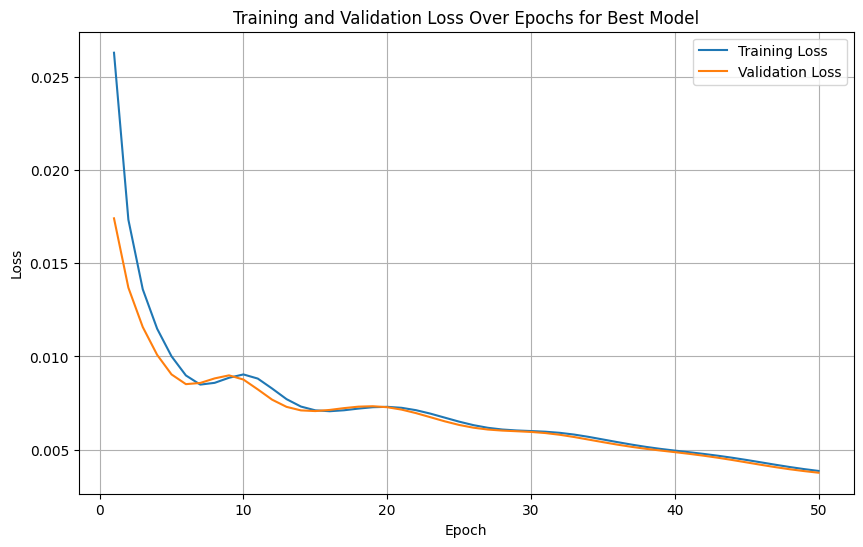

In [ ]:
# Plot Training and Validation Loss for the Best Model
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), all_train_losses[0], label='Training Loss')
plt.plot(range(1, epochs + 1), all_val_losses[0], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs for Best Model')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
training_history = torch.load("/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models/SMALL_best_model_info.pt", weights_only=False)
best_hidden_sizes = training_history["hyperparameters"]["hidden_sizes"]
model = NeuralNetwork(hidden_sizes=best_hidden_sizes)
model.load_state_dict(training_history["model_state_dict"])

model.eval()
with torch.no_grad():
    y_test_pred_tensor = model(X_test_tensor)
    y_test_pred = y_test_pred_tensor.numpy()

# Calculate test metrics
test_mse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Root Mean Squared Error:", test_mse)
print("Test R^2 Score:", test_r2)

Test Root Mean Squared Error: 0.01925758411469932
Test R^2 Score: 0.9570597410202026


# Comparison Jacobian
calculation of the Jacobian matrix and comparison of learned J with analytical J

In [19]:
def FK(model, theta):
    t = theta.view(1, 2)
    out = model(t)
    out = out.view(2)
    return out

In [20]:
def FK_Jacobian(model, x):
    def forward_kinematics_fn(x):
        return FK(model, x)
    jacobian = torch.autograd.functional.jacobian(forward_kinematics_fn, x)

    return jacobian

In [21]:
def numerical_jacobian(model, theta, epsilon=1):
    theta_np = theta.detach().numpy()
    n = theta_np.size
    y0 = model.predict(theta_np.reshape(1, -1)).flatten()
    m = y0.size
    J = np.zeros((m, n))

    for i in range(n):
        theta_plus = theta_np.copy()
        theta_minus = theta_np.copy()
        theta_plus[i] += epsilon
        theta_minus[i] -= epsilon

        y_plus = model.predict(theta_plus.reshape(1, -1))
        y_minus = model.predict(theta_minus.reshape(1, -1))

        # Differenze finite centrali
        J[:, i] = (y_plus - y_minus).flatten() / (2 * epsilon)
    return J


In [22]:
# Analytical Jacobian
def analytical_jacobian(joint_angles):
    j0, j1 = joint_angles[0], joint_angles[1]
    j0 = j0.item()
    j1 = j1.item()

    # Calculate partial derivatives
    dx_dj0 = -L1 * np.sin(j0) - L2 * np.sin(j0 + j1)
    dx_dj1 = -L2 * np.sin(j0 + j1)
    dy_dj0 = L1 * np.cos(j0) + L2 * np.cos(j0 + j1)
    dy_dj1 = L2 * np.cos(j0 + j1)

    # Construct the Jacobian matrix
    J_analytical = np.array([[dx_dj0, dx_dj1], [dy_dj0, dy_dj1]])
    return J_analytical


In [26]:
# Models trained
Linear_regression_model = lr
Decision_tree_model = best_dt
SVR_model = best_svr
Random_forest_model = best_rf
KNN_model = best_knn

training_history = torch.load("/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models/SMALL_best_model_info.pt", weights_only=False)
best_hidden_sizes = training_history["hyperparameters"]["hidden_sizes"]
NN_model = NeuralNetwork(hidden_sizes=best_hidden_sizes)
NN_model.load_state_dict(training_history["model_state_dict"])

L1 = 0.1  # Length of the first link
L2 = 0.1  # Length of the second link
epsilon=1e-3

# value for test of jacobian 0, -π/2
theta = torch.tensor([0, (np.pi/2)], dtype=torch.float32, requires_grad=True)
theta_other = np.array([0, -np.pi/2], dtype=np.float32)

J_learned_Liner_regression = numerical_jacobian(Linear_regression_model, theta, epsilon)

J_learned_Decision_tree = numerical_jacobian(Decision_tree_model, theta, epsilon)

J_learned_SVR = numerical_jacobian(SVR_model, theta, epsilon)

J_learned_Random_forest = numerical_jacobian(Random_forest_model, theta, epsilon)

J_learned_KNN = numerical_jacobian(KNN_model, theta, epsilon)

J_learned_NN = FK_Jacobian(NN_model, theta)
J_learned_NN_np = J_learned_NN.detach().numpy()

# Analytical Jacobian
J_analytical = analytical_jacobian(theta)

print("-----------------------------------Linear Regression---------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_Liner_regression, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_Liner_regression - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("------------------------------------------------------------------------------------------------")
print(" ")

print("-----------------------------------Decision Tree------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_Decision_tree, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_Decision_tree - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("------------------------------------------------------------------------------------------------")
print(" ")

print("--------------------------------------SVR-------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_SVR, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_SVR - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("------------------------------------------------------------------------------------------")
print(" ")

print("---------------------------------------Random Forest-------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_Random_forest, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_Random_forest - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("----------------------------------------------------------------------------------------------------")
print(" ")
print("--------------------------------------KNN--------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_KNN, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_KNN - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("-------------------------------------------------------------------------------------------")
print(" ")
print("--------------------------------------NN--------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_NN_np, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_NN_np - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("------------------------------------------------------------------------------------------")



-----------------------------------Linear Regression---------------------------------------------
Learned Jacobian:
 [[0.000 -0.000]
 [0.014 -0.006]]
Analytical Jacobian:
 [[-0.100 -0.100]
 [0.100 -0.000]]
Difference between Learned and Analytical Jacobian:
 [[0.100 0.100]
 [-0.086 -0.006]]
------------------------------------------------------------------------------------------------
 
-----------------------------------Decision Tree------------------------------------------------
Learned Jacobian:
 [[0.000 0.000]
 [0.000 0.000]]
Analytical Jacobian:
 [[-0.100 -0.100]
 [0.100 -0.000]]
Difference between Learned and Analytical Jacobian:
 [[0.100 0.100]
 [-0.100 0.000]]
------------------------------------------------------------------------------------------------
 
--------------------------------------SVR-------------------------------------------------
Learned Jacobian:
 [[-0.087 -0.080]
 [0.109 0.002]]
Analytical Jacobian:
 [[-0.100 -0.100]
 [0.100 -0.000]]
Difference between Lear

## Check with metrics

what I have done in this case is take all possible value of angles of joint in order and for each of them i compute the Jacobian by using the trained model and by analytic method in order and after that I used

In [50]:
joint_angles = torch.tensor(X_test[['j0', 'j1']].values, dtype=torch.float32, requires_grad=True)
ground_truth_positions = torch.tensor(y_test[['ft_x', 'ft_y']].values, dtype=torch.float32)

# Function for compute the Frobenius Norm
def frobenius_norm(J_learned, J_analytical):
    return np.linalg.norm(J_learned - J_analytical)

# Select 100 samples from dataset
random_indices = np.random.choice(len(joint_angles), size=100, replace=False)
selected_angles = joint_angles[random_indices]

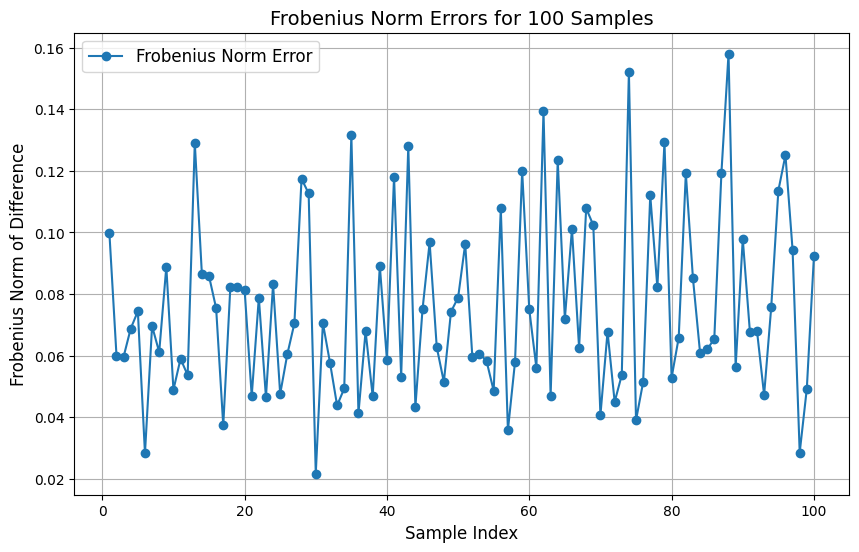

In [51]:
frobenius_errors = []

for theta in selected_angles:
    J_learned = FK_Jacobian(NN_model, theta)
    J_learned_np = J_learned.detach().numpy()

    J_analytical = analytical_jacobian(theta)

    frobenius_diff = frobenius_norm(J_learned_np, J_analytical)

    frobenius_errors.append(frobenius_diff)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(frobenius_errors) + 1), frobenius_errors, marker='o', linestyle='-', label='Frobenius Norm Error')
plt.title('Frobenius Norm Errors for 100 Samples', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Frobenius Norm of Difference', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


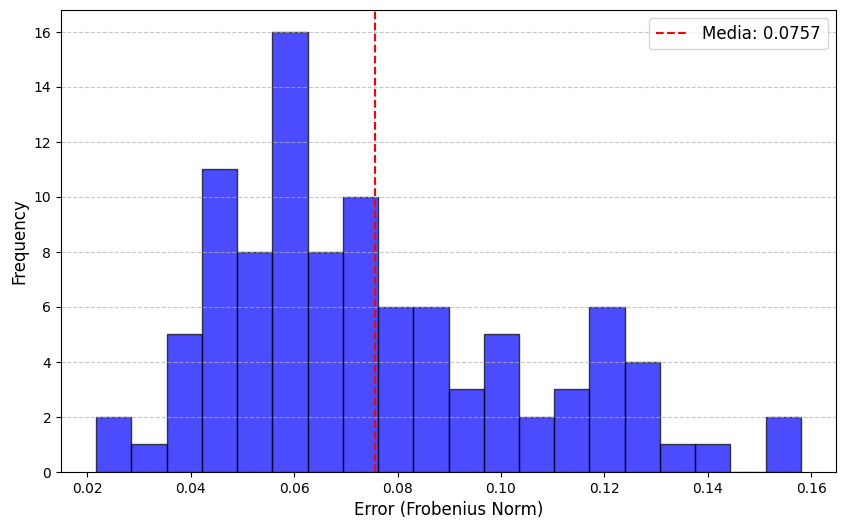

In [52]:
frobenius_errors = []

for theta in selected_angles:
    J_learned = FK_Jacobian(NN_model, theta)
    J_learned_np = J_learned.detach().numpy()

    J_analytical = analytical_jacobian(theta)

    frobenius_diff = frobenius_norm(J_learned_np, J_analytical)

    frobenius_errors.append(frobenius_diff)

plt.figure(figsize=(10, 6))
plt.hist(frobenius_errors, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Error (Frobenius Norm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(np.mean(frobenius_errors), color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {np.mean(frobenius_errors):.4f}')
plt.legend(fontsize=12)
plt.show()

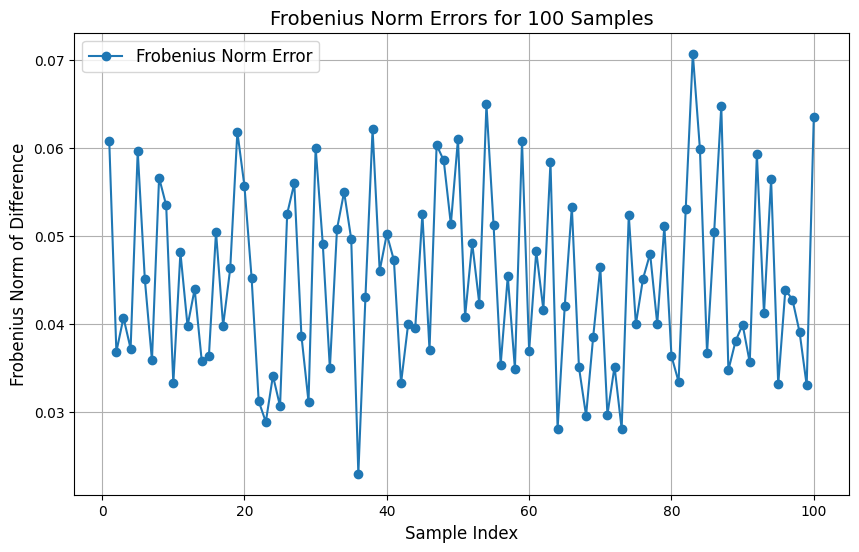

In [53]:
frobenius_errors = []

for theta in selected_angles:
    J_learned_np = numerical_jacobian(SVR_model, theta)

    J_analytical = analytical_jacobian(theta)

    frobenius_diff = frobenius_norm(J_learned_np, J_analytical)

    frobenius_errors.append(frobenius_diff)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(frobenius_errors) + 1), frobenius_errors, marker='o', linestyle='-', label='Frobenius Norm Error')
plt.title('Frobenius Norm Errors for 100 Samples', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Frobenius Norm of Difference', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


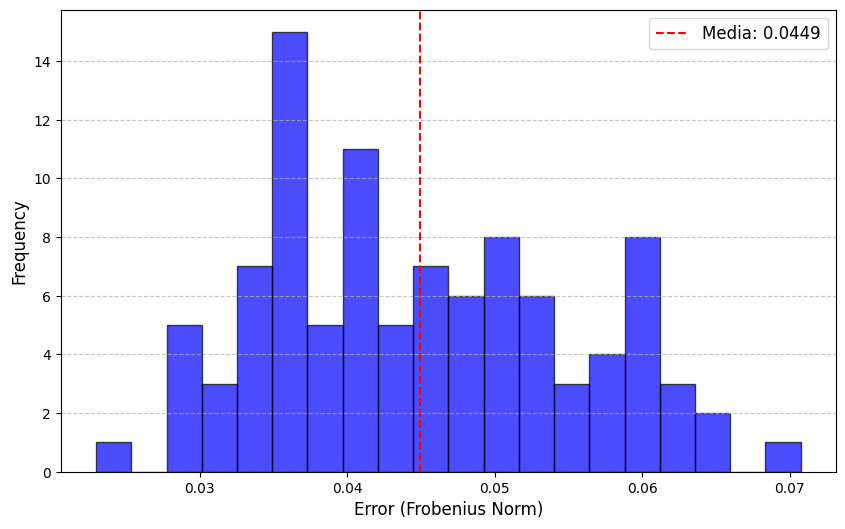

In [54]:
frobenius_errors = []

for theta in selected_angles:
    J_learned_np = numerical_jacobian(SVR_model, theta)

    J_analytical = analytical_jacobian(theta)

    frobenius_diff = frobenius_norm(J_learned_np, J_analytical)

    frobenius_errors.append(frobenius_diff)

plt.figure(figsize=(10, 6))
plt.hist(frobenius_errors, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Error (Frobenius Norm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(np.mean(frobenius_errors), color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {np.mean(frobenius_errors):.4f}')
plt.legend(fontsize=12)
plt.show()

# Check of Inverse Kinematics
Compute the Inverse Kinematics using two algorithms Levenberg-Marquadt and Newton-Raphson.



In [ ]:
training_history = torch.load("/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models/SMALL_best_model_info.pt", weights_only=False)
best_hidden_sizes = training_history["hyperparameters"]["hidden_sizes"]
model = NeuralNetwork(hidden_sizes=best_hidden_sizes)
model.load_state_dict(training_history["model_state_dict"])
model.eval()

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
def inverse_kinematics_newton_raphson(model, initial_joints, target_position, max_iters=10000, tolerance=1e-4):
    joints = initial_joints.clone().detach().requires_grad_(True)

    for i in range(max_iters):
        current_position = FK(model, joints)
        error = target_position - current_position
        if torch.norm(error) < tolerance:
            return joints.detach()
        #else:
          #print("MAX ITERS REACHED NEWTON")

        jacobian = FK_Jacobian(model, joints)
        try:
            delta_joints = torch.linalg.solve(jacobian, error)
        except RuntimeError as e:
            print("Errore nell'inversione del Jacobiano:", e)
            return joints.detach()

        joints = joints + delta_joints

    return joints.detach()

In [ ]:
def inverse_kinematics_levenberg_marquardt(model, initial_joints, target_position, max_iters=10000, tolerance=1e-4, lambda_=0.05):
    joints = initial_joints.clone().detach().requires_grad_(True)

    for i in range(max_iters):
        current_position = FK(model, joints)
        error = target_position - current_position
        if torch.norm(error) < tolerance:
            return joints.detach()
        #else:
          #print("MAX ITERS REACHED LM")

        jacobian = FK_Jacobian(model, joints)

        # Update of Levenberg-Marquardt: (J^T J + λI) * delta_joints = J^T * error
        A = jacobian.T @ jacobian + lambda_ * torch.eye(jacobian.size(1))
        b = jacobian.T @ error

        try:
            delta_joints = torch.linalg.solve(A, b)
        except RuntimeError as e:
            print("Errore nell'inversione della matrice in Levenberg-Marquardt:", e)
            return joints.detach()

        joints = joints + delta_joints

    return joints.detach()

In [ ]:
def compare_methods(model, initial_joints, target_position):
    # Newton-Raphson Method
    print("Newton-Raphson Method:")
    target_joints_nr = inverse_kinematics_newton_raphson(model, initial_joints, target_position)
    nr_error = torch.norm(FK(model, target_joints_nr) - target_position)
    print("Target joints Newton-Raphson:", target_joints_nr)
    print("Newton-Raphson Error:", nr_error.item())


    # Levenberg-Marquardt Method
    print("\nLevenberg-Marquardt Method:")
    target_joints_lm = inverse_kinematics_levenberg_marquardt(model, initial_joints, target_position)
    lm_error = torch.norm(FK(model, target_joints_lm) - target_position)
    print("Target joints Levenberg-Marquardt:", target_joints_lm)
    print("Levenberg-Marquardt Error:", lm_error.item())

    print(" ")
    print("--------------------------------------")
    print("Comparison target:", target_position, "Value computed by Newton-Raphson Method: ", FK(model, target_joints_nr).detach()) #.detach() is used for remove grad_fn=<ViewBackward0> from print
    print("Comparison target:", target_position, "Value computed by Levenberg Marquardt: ", FK(model, target_joints_lm).detach())


In [ ]:
initial_joints = torch.tensor([0.0, np.pi/4], requires_grad=True)
target_position = torch.tensor(y_test.sample(n=1).to_numpy().flatten(), dtype=torch.float32)
print(target_position)

compare_methods(model, initial_joints, target_position)


tensor([-0.1430,  0.0490])
Newton-Raphson Method:
Target joints Newton-Raphson: tensor([-34.2023,  25.8520])
Newton-Raphson Error: 1.592752170154199e-07

Levenberg-Marquardt Method:
Target joints Levenberg-Marquardt: tensor([2.3384, 0.9490])
Levenberg-Marquardt Error: 9.641104406910017e-05
 
--------------------------------------
Comparison target: tensor([-0.1430,  0.0490]) Value computed by Newton-Raphson Method:  tensor([-0.1430,  0.0490])
Comparison target: tensor([-0.1430,  0.0490]) Value computed by Levenberg Marquardt:  tensor([-0.1429,  0.0490])


In [ ]:
def inverse_kinematics_newton_raphson(model, initial_joints, target_position, max_iters=10000, tolerance=1e-4):
    joints = torch.tensor(initial_joints, dtype=torch.float32)

    for i in range(max_iters):
        current_position = torch.tensor(model.predict(joints.unsqueeze(0).numpy()).flatten(), dtype=torch.float32)
        error = target_position.float() - current_position
        if torch.norm(error) < tolerance:
            return joints

        jacobian = numerical_jacobian(model, joints)
        J = torch.tensor(jacobian, dtype=torch.float32)
        try:
            delta_joints = torch.linalg.solve(J, error)
        except RuntimeError as e:
            print("Errore nell'inversione del Jacobiano:", e)
            return joints

        joints = joints + delta_joints

    return joints


def inverse_kinematics_levenberg_marquardt(model, initial_joints, target_position, max_iters=10000, tolerance=1e-4, lambda_=0.05):
    joints = torch.tensor(initial_joints, dtype=torch.float32)

    for i in range(max_iters):
        current_position = torch.tensor(model.predict(joints.unsqueeze(0).numpy()).flatten(), dtype=torch.float32)
        error = target_position.float() - current_position
        if torch.norm(error) < tolerance:
            return joints

        jacobian = numerical_jacobian(model, joints)
        J = torch.tensor(jacobian, dtype=torch.float32)
        A = J.T @ J + lambda_ * torch.eye(J.shape[1], dtype=torch.float32)
        b = J.T @ error

        try:
            delta_joints = torch.linalg.solve(A, b)
        except RuntimeError as e:
            print("Errore nell'inversione della matrice in Levenberg-Marquardt:", e)
            return joints

        joints = joints + delta_joints

    return joints


def compare_methods(model, initial_joints, target_position, model_name):
    print(f"\n{model_name} Results:")
    print(f"Target Position: {target_position}")

    # Newton-Raphson Method
    print("Newton-Raphson Method:")
    target_joints_nr = inverse_kinematics_newton_raphson(model, initial_joints, target_position)
    nr_error = torch.norm(torch.tensor(model.predict(target_joints_nr.unsqueeze(0).numpy()).flatten()) - target_position)
    print("Target joints Newton-Raphson:", target_joints_nr)
    print("Newton-Raphson Error:", nr_error.item())

    # Levenberg-Marquardt Method
    print("\nLevenberg-Marquardt Method:")
    target_joints_lm = inverse_kinematics_levenberg_marquardt(model, initial_joints, target_position)
    lm_error = torch.norm(torch.tensor(model.predict(target_joints_lm.unsqueeze(0).numpy()).flatten()) - target_position)
    print("Target joints Levenberg-Marquardt:", target_joints_lm)
    print("Levenberg-Marquardt Error:", lm_error.item())

    print("--------------------------------------")
    print("Comparison target:", target_position,
          "Value computed by Newton-Raphson Method: ",
          torch.tensor(model.predict(target_joints_nr.unsqueeze(0).numpy()).flatten()))
    print("Comparison target:", target_position,
          "Value computed by Levenberg-Marquardt Method: ",
          torch.tensor(model.predict(target_joints_lm.unsqueeze(0).numpy()).flatten()))

models = [("SVR", best_svr)]

initial_joints = [0.5, 0.5]
torch.tensor(y_test.sample(n=1).to_numpy().flatten(), dtype=torch.float32)

for model_name, model in models:
    compare_methods(model, initial_joints, target_position, model_name)



SVR Results:
Target Position: tensor([-0.1430,  0.0490])
Newton-Raphson Method:
Errore nell'inversione del Jacobiano: torch.linalg.solve: The solver failed because the input matrix is singular.
Target joints Newton-Raphson: tensor([-10.5531,  31.0307])
Newton-Raphson Error: 0.14681225123543162

Levenberg-Marquardt Method:
Target joints Levenberg-Marquardt: tensor([2.2189, 1.1916])
Levenberg-Marquardt Error: 9.835205608472102e-05
--------------------------------------
Comparison target: tensor([-0.1430,  0.0490]) Value computed by Newton-Raphson Method:  tensor([-0.0043,  0.0008], dtype=torch.float64)
Comparison target: tensor([-0.1430,  0.0490]) Value computed by Levenberg-Marquardt Method:  tensor([-0.1429,  0.0490], dtype=torch.float64)


# 100K Part 2
In Part 1 we have train and test the model by splitting the same .csv file but because the samples of dataset are taken randomly can happen that the same samples can appear both in train and test dataset for this reason in this part i will train the model with one .csv file (seed: 2000) and test with onther one (seed: 3000).
I will use the same libraries of part 1 and the same model

## Dataset

In [7]:
df_train = pd.read_csv("/content/drive/MyDrive/Machine_Learning/HW1/dataset/logfile_r2_train.csv",sep=';')
df_test = pd.read_csv("/content/drive/MyDrive/Machine_Learning/HW1/dataset/logfile_r2_test.csv",sep=';')

In [8]:
df_train_filtered = df_train[['j0', 'j1', 'ft_x', 'ft_y']]
df_test_filtered = df_test[['j0', 'j1', 'ft_x', 'ft_y']]

X_train = df_train_filtered[['j0', 'j1']]
y_train = df_train_filtered[['ft_x', 'ft_y']]

X_test = df_test_filtered[['j0', 'j1']]
y_test = df_test_filtered[['ft_x', 'ft_y']]

# Split of train for have also validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 1 Model Linear Regression

In [ ]:
# train
lr = MultiOutputRegressor(LinearRegression())
lr.fit(X_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [ ]:
# test
warnings.filterwarnings("ignore")
lr_rmse, lr_r2 = evaluate_model(lr, X_test, y_test)
print(f"Linear Regression RMSE: {lr_rmse}, R2: {lr_r2}")

Linear Regression RMSE: 0.08907681842354814, R2: 0.06955168693594055


## 2 Decsion tree Regressor

In [ ]:
# train
dt_param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 20]
}
dt = DecisionTreeRegressor()
dt_grid = GridSearchCV(dt, dt_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [ ]:
# test
best_dt = dt_grid.best_estimator_
dt_rmse, dt_r2 = evaluate_model(best_dt, X_test, y_test)
print(f"Decision Tree Best Params: {dt_grid.best_params_}")
print(f"Decision Tree RMSE: {dt_rmse}, R2: {dt_r2}")

Decision Tree Best Params: {'max_depth': 20, 'splitter': 'best'}
Decision Tree RMSE: 0.001796615119614652, R2: 0.9996188869993533


## 3 Model SVR

In [ ]:
# train
svr_param_grid = {
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__C': [0.1, 1, 10],
    'estimator__epsilon': [0.01, 0.1, 1],
    'estimator__max_iter': [50]
}
svr = MultiOutputRegressor(SVR())
svr_grid = GridSearchCV(svr, svr_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
svr_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=MultiOutputRegressor(estimator=SVR()), n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10],
                         'estimator__epsilon': [0.01, 0.1, 1],
                         'estimator__kernel': ['linear', 'rbf'],
                         'estimator__max_iter': [50]},
             scoring='neg_mean_squared_error')

In [ ]:
# test
best_svr = svr_grid.best_estimator_
svr_rmse, svr_r2 = evaluate_model(best_svr, X_test, y_test)
print(f"SVR Best Params: {svr_grid.best_params_}")
print(f"SVR RMSE: {svr_rmse}, R2: {svr_r2}")

SVR Best Params: {'estimator__C': 10, 'estimator__epsilon': 0.01, 'estimator__kernel': 'rbf', 'estimator__max_iter': 50}
SVR RMSE: 0.018647361850532257, R2: 0.9584274773489254


## 4 Model Random Forest regressor

In [ ]:
# train
rf_param_grid = {
    'estimator__n_estimators': [100, 150],
    'estimator__max_depth': [5, 12]
}
rf = MultiOutputRegressor(RandomForestRegressor(random_state=42))
rf_grid = GridSearchCV(rf, rf_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [5, 12],
                         'estimator__n_estimators': [100, 150]},
             scoring='neg_mean_squared_error')

In [ ]:
#test
best_rf = rf_grid.best_estimator_
rf_rmse, rf_r2 = evaluate_model(best_rf, X_test, y_test)
print(f"Random Forest Best Params: {rf_grid.best_params_}")
print(f"Random Forest RMSE: {rf_rmse}, R2: {rf_r2}")


Random Forest Best Params: {'estimator__max_depth': 12, 'estimator__n_estimators': 150}
Random Forest RMSE: 0.005439199923384231, R2: 0.9964997986657675


## 5 Model KNN regressor

In [ ]:
# train
knn_param_grid = {
    'estimator__n_neighbors': [3, 5, 10],
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}
knn = MultiOutputRegressor(KNeighborsRegressor())
knn_grid = GridSearchCV(knn, knn_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=KNeighborsRegressor()),
             n_jobs=-1,
             param_grid={'estimator__n_neighbors': [3, 5, 10],
                         'estimator__p': [1, 2],
                         'estimator__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [ ]:
#test
best_knn = knn_grid.best_estimator_
knn_rmse, knn_r2 = evaluate_model(best_knn, X_test, y_test)
print(f"KNN Best Params: {knn_grid.best_params_}")
print(f"KNN RMSE: {knn_rmse}, R2: {knn_r2}")

KNN Best Params: {'estimator__n_neighbors': 10, 'estimator__p': 2, 'estimator__weights': 'distance'}
KNN RMSE: 0.000840636317624405, R2: 0.9999159945347904


## 6 Model NN

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_sizes):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        input_size = 2  # two input features: j0 and j1
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

        # Output layer
        output_size = 2  # output: ft_x and ft_y
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:  # Apply ReLU to all hidden layers
            x = torch.relu(layer(x))
        x = self.layers[-1](x)  # No activation for the output layer
        return x

In [10]:
# Conversion of data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'hidden_sizes': [[8, 16, 8], [8, 16, 32, 16, 8], [16, 32, 64, 32, 16]],
    'optimizer': ['Adam', 'SGD', 'RMSprop']
}
grid = ParameterGrid(param_grid)

epochs = 50
best_val_loss = float('inf')
save_path = "/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models"

all_train_losses = []
all_val_losses = []
best_model_info = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "model_state_dict": None,
    "optimizer_state_dict": None,
    "hyperparameters": {}
}

In [ ]:
for params in grid:
    # Initialize model and criterion
    model = NeuralNetwork(hidden_sizes=params['hidden_sizes'])
    criterion = nn.MSELoss()

    # Choose optimizer based on parameter grid
    if params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'])

    # Track losses for each epoch
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in tqdm(range(epochs), desc=f"Training Model with LR={params['learning_rate']}, Layers={params['hidden_sizes']}, Optimizer={params['optimizer']}"):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        train_loss = criterion(outputs, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)

        # Store losses
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Check if this model is the best so far based on validation loss
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_info = {
                "epoch": epoch + 1,
                "train_loss": train_loss.item(),
                "val_loss": val_loss.item(),
                "model_state_dict": model.state_dict(),  # Store the best model weights
                "optimizer_state_dict": optimizer.state_dict(),  # Save the best optimizer state
                "hyperparameters": params  # Save the best hyperparameters for model reconstruction
            }

        # Update tqdm description with current losses
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

    # Save all losses for plotting
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

# Save the best model information to a file
torch.save(best_model_info, os.path.join(save_path, "2_SMALL_best_model_info_train_set_separated.pt"))

# Print the best hyperparameters
print("Best Model Parameters:")
print("Learning Rate:", best_model_info['hyperparameters']['learning_rate'])
print("Hidden Layer Sizes:", best_model_info['hyperparameters']['hidden_sizes'])
print("Optimizer:", best_model_info['hyperparameters']['optimizer'])
print("Best Validation Loss:", best_val_loss)

Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0611, Validation Loss: 0.0418


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:   4%|▍         | 2/50 [00:00<00:04, 11.77it/s]

Epoch [2/50], Training Loss: 0.0417, Validation Loss: 0.0300
Epoch [3/50], Training Loss: 0.0299, Validation Loss: 0.0231
Epoch [4/50], Training Loss: 0.0231, Validation Loss: 0.0204


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:03, 14.57it/s]

Epoch [5/50], Training Loss: 0.0204, Validation Loss: 0.0193


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.52it/s]

Epoch [6/50], Training Loss: 0.0194, Validation Loss: 0.0183
Epoch [7/50], Training Loss: 0.0184, Validation Loss: 0.0167
Epoch [8/50], Training Loss: 0.0168, Validation Loss: 0.0145


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:02, 16.52it/s]

Epoch [9/50], Training Loss: 0.0146, Validation Loss: 0.0121


Epoch [10/50], Training Loss: 0.0122, Validation Loss: 0.0101
Epoch [11/50], Training Loss: 0.0101, Validation Loss: 0.0086
Epoch [12/50], Training Loss: 0.0086, Validation Loss: 0.0078


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.81it/s]

Epoch [13/50], Training Loss: 0.0077, Validation Loss: 0.0073
Epoch [14/50], Training Loss: 0.0072, Validation Loss: 0.0069


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  30%|███       | 15/50 [00:00<00:01, 19.21it/s]

Epoch [15/50], Training Loss: 0.0069, Validation Loss: 0.0066
Epoch [16/50], Training Loss: 0.0066, Validation Loss: 0.0064
Epoch [17/50], Training Loss: 0.0064, Validation Loss: 0.0063


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:01<00:01, 20.63it/s]

Epoch [18/50], Training Loss: 0.0063, Validation Loss: 0.0063
Epoch [19/50], Training Loss: 0.0062, Validation Loss: 0.0062


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  42%|████▏     | 21/50 [00:01<00:01, 21.09it/s]

Epoch [20/50], Training Loss: 0.0062, Validation Loss: 0.0062
Epoch [21/50], Training Loss: 0.0061, Validation Loss: 0.0060
Epoch [22/50], Training Loss: 0.0060, Validation Loss: 0.0059


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.16it/s]

Epoch [23/50], Training Loss: 0.0058, Validation Loss: 0.0057
Epoch [24/50], Training Loss: 0.0056, Validation Loss: 0.0055


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.04it/s]

Epoch [25/50], Training Loss: 0.0055, Validation Loss: 0.0053
Epoch [26/50], Training Loss: 0.0053, Validation Loss: 0.0051
Epoch [27/50], Training Loss: 0.0051, Validation Loss: 0.0050


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.04it/s]

Epoch [28/50], Training Loss: 0.0050, Validation Loss: 0.0049
Epoch [29/50], Training Loss: 0.0048, Validation Loss: 0.0048


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:01<00:00, 22.44it/s]

Epoch [30/50], Training Loss: 0.0047, Validation Loss: 0.0046
Epoch [31/50], Training Loss: 0.0046, Validation Loss: 0.0045
Epoch [32/50], Training Loss: 0.0045, Validation Loss: 0.0044


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.97it/s]

Epoch [33/50], Training Loss: 0.0044, Validation Loss: 0.0043
Epoch [34/50], Training Loss: 0.0043, Validation Loss: 0.0042


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.79it/s]

Epoch [35/50], Training Loss: 0.0042, Validation Loss: 0.0041
Epoch [36/50], Training Loss: 0.0041, Validation Loss: 0.0040
Epoch [37/50], Training Loss: 0.0040, Validation Loss: 0.0039


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.79it/s]

Epoch [38/50], Training Loss: 0.0039, Validation Loss: 0.0038
Epoch [39/50], Training Loss: 0.0038, Validation Loss: 0.0037


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  78%|███████▊  | 39/50 [00:02<00:00, 20.94it/s]

Epoch [40/50], Training Loss: 0.0037, Validation Loss: 0.0036
Epoch [41/50], Training Loss: 0.0036, Validation Loss: 0.0035


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.97it/s]

Epoch [42/50], Training Loss: 0.0035, Validation Loss: 0.0034
Epoch [43/50], Training Loss: 0.0034, Validation Loss: 0.0034
Epoch [44/50], Training Loss: 0.0033, Validation Loss: 0.0033


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.45it/s]

Epoch [45/50], Training Loss: 0.0033, Validation Loss: 0.0032
Epoch [46/50], Training Loss: 0.0032, Validation Loss: 0.0032
Epoch [47/50], Training Loss: 0.0031, Validation Loss: 0.0031


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.17it/s]

Epoch [48/50], Training Loss: 0.0031, Validation Loss: 0.0030
Epoch [49/50], Training Loss: 0.0030, Validation Loss: 0.0029


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:02<00:00, 20.42it/s]


Epoch [50/50], Training Loss: 0.0029, Validation Loss: 0.0029


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0194, Validation Loss: 0.0192
Epoch [2/50], Training Loss: 0.0191, Validation Loss: 0.0190


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:   6%|▌         | 3/50 [00:00<00:02, 22.47it/s]

Epoch [3/50], Training Loss: 0.0189, Validation Loss: 0.0187
Epoch [4/50], Training Loss: 0.0186, Validation Loss: 0.0185


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:   6%|▌         | 3/50 [00:00<00:02, 22.47it/s]

Epoch [5/50], Training Loss: 0.0184, Validation Loss: 0.0182


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:02, 21.05it/s]

Epoch [6/50], Training Loss: 0.0182, Validation Loss: 0.0180
Epoch [7/50], Training Loss: 0.0180, Validation Loss: 0.0178


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  18%|█▊        | 9/50 [00:00<00:01, 22.49it/s]

Epoch [8/50], Training Loss: 0.0177, Validation Loss: 0.0176
Epoch [9/50], Training Loss: 0.0175, Validation Loss: 0.0174


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  18%|█▊        | 9/50 [00:00<00:01, 22.49it/s]

Epoch [10/50], Training Loss: 0.0173, Validation Loss: 0.0172


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:01, 23.36it/s]

Epoch [11/50], Training Loss: 0.0171, Validation Loss: 0.0170
Epoch [12/50], Training Loss: 0.0170, Validation Loss: 0.0168
Epoch [13/50], Training Loss: 0.0168, Validation Loss: 0.0167


Epoch [14/50], Training Loss: 0.0166, Validation Loss: 0.0165


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  30%|███       | 15/50 [00:00<00:01, 23.34it/s]

Epoch [15/50], Training Loss: 0.0164, Validation Loss: 0.0163


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:01, 23.93it/s]

Epoch [16/50], Training Loss: 0.0163, Validation Loss: 0.0162
Epoch [17/50], Training Loss: 0.0161, Validation Loss: 0.0160
Epoch [18/50], Training Loss: 0.0159, Validation Loss: 0.0159


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:01, 23.93it/s]

Epoch [19/50], Training Loss: 0.0158, Validation Loss: 0.0157
Epoch [20/50], Training Loss: 0.0156, Validation Loss: 0.0156


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  42%|████▏     | 21/50 [00:00<00:01, 24.48it/s]

Epoch [21/50], Training Loss: 0.0155, Validation Loss: 0.0154


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  42%|████▏     | 21/50 [00:00<00:01, 24.48it/s]

Epoch [22/50], Training Loss: 0.0154, Validation Loss: 0.0153
Epoch [23/50], Training Loss: 0.0152, Validation Loss: 0.0152


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:01<00:01, 23.38it/s]

Epoch [24/50], Training Loss: 0.0151, Validation Loss: 0.0150


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:01<00:01, 23.38it/s]

Epoch [25/50], Training Loss: 0.0150, Validation Loss: 0.0149


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  54%|█████▍    | 27/50 [00:01<00:01, 20.96it/s]

Epoch [26/50], Training Loss: 0.0148, Validation Loss: 0.0148
Epoch [27/50], Training Loss: 0.0147, Validation Loss: 0.0147


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  54%|█████▍    | 27/50 [00:01<00:01, 20.96it/s]

Epoch [28/50], Training Loss: 0.0146, Validation Loss: 0.0146


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  54%|█████▍    | 27/50 [00:01<00:01, 20.96it/s]

Epoch [29/50], Training Loss: 0.0145, Validation Loss: 0.0145


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  60%|██████    | 30/50 [00:01<00:01, 19.81it/s]

Epoch [30/50], Training Loss: 0.0144, Validation Loss: 0.0144
Epoch [31/50], Training Loss: 0.0143, Validation Loss: 0.0142
Epoch [32/50], Training Loss: 0.0142, Validation Loss: 0.0141


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:01<00:00, 20.03it/s]

Epoch [33/50], Training Loss: 0.0141, Validation Loss: 0.0141


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:01<00:00, 20.03it/s]

Epoch [34/50], Training Loss: 0.0140, Validation Loss: 0.0140


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  72%|███████▏  | 36/50 [00:01<00:00, 20.11it/s]

Epoch [35/50], Training Loss: 0.0139, Validation Loss: 0.0139
Epoch [36/50], Training Loss: 0.0138, Validation Loss: 0.0138
Epoch [37/50], Training Loss: 0.0137, Validation Loss: 0.0137


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  72%|███████▏  | 36/50 [00:01<00:00, 20.11it/s]

Epoch [38/50], Training Loss: 0.0136, Validation Loss: 0.0136


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  78%|███████▊  | 39/50 [00:01<00:00, 21.25it/s]

Epoch [39/50], Training Loss: 0.0136, Validation Loss: 0.0135


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:01<00:00, 22.24it/s]

Epoch [40/50], Training Loss: 0.0135, Validation Loss: 0.0135
Epoch [41/50], Training Loss: 0.0134, Validation Loss: 0.0134
Epoch [42/50], Training Loss: 0.0133, Validation Loss: 0.0133
Epoch [43/50], Training Loss: 0.0132, Validation Loss: 0.0132


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:01<00:00, 22.24it/s]

Epoch [44/50], Training Loss: 0.0132, Validation Loss: 0.0132


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  96%|█████████▌| 48/50 [00:02<00:00, 22.46it/s]

Epoch [45/50], Training Loss: 0.0131, Validation Loss: 0.0131
Epoch [46/50], Training Loss: 0.0130, Validation Loss: 0.0130
Epoch [47/50], Training Loss: 0.0130, Validation Loss: 0.0130
Epoch [48/50], Training Loss: 0.0129, Validation Loss: 0.0129


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  96%|█████████▌| 48/50 [00:02<00:00, 22.46it/s]

Epoch [49/50], Training Loss: 0.0128, Validation Loss: 0.0128


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:02<00:00, 21.93it/s]


Epoch [50/50], Training Loss: 0.0128, Validation Loss: 0.0128


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:   6%|▌         | 3/50 [00:00<00:02, 22.34it/s]

Epoch [1/50], Training Loss: 0.0936, Validation Loss: 0.8157
Epoch [2/50], Training Loss: 0.8204, Validation Loss: 0.0400
Epoch [3/50], Training Loss: 0.0400, Validation Loss: 0.0257


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:   6%|▌         | 3/50 [00:00<00:02, 22.34it/s]

Epoch [4/50], Training Loss: 0.0257, Validation Loss: 0.0184


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:   6%|▌         | 3/50 [00:00<00:02, 22.34it/s]

Epoch [5/50], Training Loss: 0.0184, Validation Loss: 0.0145


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:01, 23.11it/s]

Epoch [6/50], Training Loss: 0.0145, Validation Loss: 0.0121
Epoch [7/50], Training Loss: 0.0121, Validation Loss: 0.0106
Epoch [8/50], Training Loss: 0.0105, Validation Loss: 0.0095


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:00<00:01, 23.34it/s]

Epoch [9/50], Training Loss: 0.0095, Validation Loss: 0.0088


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:00<00:01, 23.34it/s]

Epoch [10/50], Training Loss: 0.0088, Validation Loss: 0.0083


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:01, 23.29it/s]

Epoch [11/50], Training Loss: 0.0082, Validation Loss: 0.0079
Epoch [12/50], Training Loss: 0.0079, Validation Loss: 0.0076
Epoch [13/50], Training Loss: 0.0076, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  30%|███       | 15/50 [00:00<00:01, 24.18it/s]

Epoch [14/50], Training Loss: 0.0073, Validation Loss: 0.0071
Epoch [15/50], Training Loss: 0.0071, Validation Loss: 0.0070


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  30%|███       | 15/50 [00:00<00:01, 24.18it/s]

Epoch [16/50], Training Loss: 0.0069, Validation Loss: 0.0068


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  36%|███▌      | 18/50 [00:00<00:01, 22.55it/s]

Epoch [17/50], Training Loss: 0.0068, Validation Loss: 0.0067
Epoch [18/50], Training Loss: 0.0066, Validation Loss: 0.0066


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  36%|███▌      | 18/50 [00:00<00:01, 22.55it/s]

Epoch [19/50], Training Loss: 0.0065, Validation Loss: 0.0065
Epoch [20/50], Training Loss: 0.0064, Validation Loss: 0.0064


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  42%|████▏     | 21/50 [00:00<00:01, 22.18it/s]

Epoch [21/50], Training Loss: 0.0063, Validation Loss: 0.0063


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  42%|████▏     | 21/50 [00:01<00:01, 22.18it/s]

Epoch [22/50], Training Loss: 0.0062, Validation Loss: 0.0062
Epoch [23/50], Training Loss: 0.0061, Validation Loss: 0.0061


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:01<00:01, 21.84it/s]

Epoch [24/50], Training Loss: 0.0061, Validation Loss: 0.0060
Epoch [25/50], Training Loss: 0.0060, Validation Loss: 0.0059


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:01<00:01, 21.84it/s]

Epoch [26/50], Training Loss: 0.0059, Validation Loss: 0.0059


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  54%|█████▍    | 27/50 [00:01<00:01, 21.57it/s]

Epoch [27/50], Training Loss: 0.0058, Validation Loss: 0.0058
Epoch [28/50], Training Loss: 0.0057, Validation Loss: 0.0057


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  54%|█████▍    | 27/50 [00:01<00:01, 21.57it/s]

Epoch [29/50], Training Loss: 0.0057, Validation Loss: 0.0056
Epoch [30/50], Training Loss: 0.0056, Validation Loss: 0.0056


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:01<00:00, 21.15it/s]

Epoch [31/50], Training Loss: 0.0055, Validation Loss: 0.0055
Epoch [32/50], Training Loss: 0.0054, Validation Loss: 0.0054
Epoch [33/50], Training Loss: 0.0054, Validation Loss: 0.0053


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:01<00:00, 21.15it/s]

Epoch [34/50], Training Loss: 0.0053, Validation Loss: 0.0053
Epoch [35/50], Training Loss: 0.0052, Validation Loss: 0.0052


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  72%|███████▏  | 36/50 [00:01<00:00, 22.11it/s]

Epoch [36/50], Training Loss: 0.0052, Validation Loss: 0.0051
Epoch [37/50], Training Loss: 0.0051, Validation Loss: 0.0051
Epoch [38/50], Training Loss: 0.0050, Validation Loss: 0.0050


Epoch [39/50], Training Loss: 0.0050, Validation Loss: 0.0050


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:01<00:00, 21.27it/s]

Epoch [40/50], Training Loss: 0.0049, Validation Loss: 0.0049
Epoch [41/50], Training Loss: 0.0049, Validation Loss: 0.0048
Epoch [42/50], Training Loss: 0.0048, Validation Loss: 0.0048
Epoch [43/50], Training Loss: 0.0047, Validation Loss: 0.0047


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:01<00:00, 21.27it/s]

Epoch [44/50], Training Loss: 0.0047, Validation Loss: 0.0047


Epoch [45/50], Training Loss: 0.0046, Validation Loss: 0.0046
Epoch [46/50], Training Loss: 0.0046, Validation Loss: 0.0046
Epoch [47/50], Training Loss: 0.0045, Validation Loss: 0.0045
Epoch [48/50], Training Loss: 0.0045, Validation Loss: 0.0044


Epoch [49/50], Training Loss: 0.0044, Validation Loss: 0.0044


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:02<00:00, 22.25it/s]


Epoch [50/50], Training Loss: 0.0044, Validation Loss: 0.0043


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:   6%|▌         | 3/50 [00:00<00:01, 24.77it/s]

Epoch [1/50], Training Loss: 0.0264, Validation Loss: 0.0249
Epoch [2/50], Training Loss: 0.0248, Validation Loss: 0.0234
Epoch [3/50], Training Loss: 0.0233, Validation Loss: 0.0220


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:   6%|▌         | 3/50 [00:00<00:01, 24.77it/s]

Epoch [4/50], Training Loss: 0.0219, Validation Loss: 0.0208


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:   6%|▌         | 3/50 [00:00<00:01, 24.77it/s]

Epoch [5/50], Training Loss: 0.0207, Validation Loss: 0.0196


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.30it/s]

Epoch [6/50], Training Loss: 0.0195, Validation Loss: 0.0186
Epoch [7/50], Training Loss: 0.0185, Validation Loss: 0.0177
Epoch [8/50], Training Loss: 0.0176, Validation Loss: 0.0169


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.04it/s]

Epoch [9/50], Training Loss: 0.0168, Validation Loss: 0.0162


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.04it/s]

Epoch [10/50], Training Loss: 0.0161, Validation Loss: 0.0155


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.77it/s]

Epoch [11/50], Training Loss: 0.0155, Validation Loss: 0.0150
Epoch [12/50], Training Loss: 0.0149, Validation Loss: 0.0145
Epoch [13/50], Training Loss: 0.0144, Validation Loss: 0.0141


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.77it/s]

Epoch [14/50], Training Loss: 0.0140, Validation Loss: 0.0137


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  30%|███       | 15/50 [00:00<00:01, 22.05it/s]

Epoch [15/50], Training Loss: 0.0136, Validation Loss: 0.0133


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.99it/s]

Epoch [16/50], Training Loss: 0.0133, Validation Loss: 0.0129
Epoch [17/50], Training Loss: 0.0129, Validation Loss: 0.0126
Epoch [18/50], Training Loss: 0.0125, Validation Loss: 0.0122


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.99it/s]

Epoch [19/50], Training Loss: 0.0122, Validation Loss: 0.0119


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.99it/s]

Epoch [20/50], Training Loss: 0.0118, Validation Loss: 0.0115


Epoch [21/50], Training Loss: 0.0115, Validation Loss: 0.0111
Epoch [22/50], Training Loss: 0.0111, Validation Loss: 0.0108


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.96it/s]

Epoch [23/50], Training Loss: 0.0107, Validation Loss: 0.0104
Epoch [24/50], Training Loss: 0.0104, Validation Loss: 0.0101


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.69it/s]

Epoch [25/50], Training Loss: 0.0100, Validation Loss: 0.0097
Epoch [26/50], Training Loss: 0.0097, Validation Loss: 0.0094
Epoch [27/50], Training Loss: 0.0094, Validation Loss: 0.0091


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.47it/s]

Epoch [28/50], Training Loss: 0.0091, Validation Loss: 0.0088
Epoch [29/50], Training Loss: 0.0088, Validation Loss: 0.0085


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:01<00:00, 21.42it/s]

Epoch [30/50], Training Loss: 0.0085, Validation Loss: 0.0083
Epoch [31/50], Training Loss: 0.0082, Validation Loss: 0.0080
Epoch [32/50], Training Loss: 0.0080, Validation Loss: 0.0078


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.27it/s]

Epoch [33/50], Training Loss: 0.0078, Validation Loss: 0.0076
Epoch [34/50], Training Loss: 0.0075, Validation Loss: 0.0074


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.69it/s]

Epoch [35/50], Training Loss: 0.0074, Validation Loss: 0.0072
Epoch [36/50], Training Loss: 0.0072, Validation Loss: 0.0071
Epoch [37/50], Training Loss: 0.0071, Validation Loss: 0.0070


Epoch [38/50], Training Loss: 0.0069, Validation Loss: 0.0068
Epoch [39/50], Training Loss: 0.0068, Validation Loss: 0.0067


Epoch [40/50], Training Loss: 0.0067, Validation Loss: 0.0066
Epoch [41/50], Training Loss: 0.0066, Validation Loss: 0.0066
Epoch [42/50], Training Loss: 0.0065, Validation Loss: 0.0065


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.06it/s]

Epoch [43/50], Training Loss: 0.0065, Validation Loss: 0.0064
Epoch [44/50], Training Loss: 0.0064, Validation Loss: 0.0064


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.88it/s]

Epoch [45/50], Training Loss: 0.0063, Validation Loss: 0.0063
Epoch [46/50], Training Loss: 0.0063, Validation Loss: 0.0063
Epoch [47/50], Training Loss: 0.0062, Validation Loss: 0.0062


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.22it/s]

Epoch [48/50], Training Loss: 0.0062, Validation Loss: 0.0062
Epoch [49/50], Training Loss: 0.0062, Validation Loss: 0.0061


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:02<00:00, 22.30it/s]


Epoch [50/50], Training Loss: 0.0061, Validation Loss: 0.0061


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0251, Validation Loss: 0.0251
Epoch [2/50], Training Loss: 0.0250, Validation Loss: 0.0251


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:   6%|▌         | 3/50 [00:00<00:02, 22.30it/s]

Epoch [3/50], Training Loss: 0.0250, Validation Loss: 0.0250
Epoch [4/50], Training Loss: 0.0249, Validation Loss: 0.0250


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:   6%|▌         | 3/50 [00:00<00:02, 22.30it/s]

Epoch [5/50], Training Loss: 0.0249, Validation Loss: 0.0249


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:02, 20.57it/s]

Epoch [6/50], Training Loss: 0.0248, Validation Loss: 0.0249
Epoch [7/50], Training Loss: 0.0248, Validation Loss: 0.0248


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  18%|█▊        | 9/50 [00:00<00:01, 21.01it/s]

Epoch [8/50], Training Loss: 0.0247, Validation Loss: 0.0248
Epoch [9/50], Training Loss: 0.0247, Validation Loss: 0.0248


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  18%|█▊        | 9/50 [00:00<00:01, 21.01it/s]

Epoch [10/50], Training Loss: 0.0246, Validation Loss: 0.0247


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:01, 20.78it/s]

Epoch [11/50], Training Loss: 0.0246, Validation Loss: 0.0247
Epoch [12/50], Training Loss: 0.0246, Validation Loss: 0.0246


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:01, 20.78it/s]

Epoch [13/50], Training Loss: 0.0245, Validation Loss: 0.0246
Epoch [14/50], Training Loss: 0.0245, Validation Loss: 0.0245


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  30%|███       | 15/50 [00:00<00:01, 20.22it/s]

Epoch [15/50], Training Loss: 0.0244, Validation Loss: 0.0245


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  30%|███       | 15/50 [00:00<00:01, 20.22it/s]

Epoch [16/50], Training Loss: 0.0244, Validation Loss: 0.0244
Epoch [17/50], Training Loss: 0.0243, Validation Loss: 0.0244


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:01, 20.22it/s]

Epoch [18/50], Training Loss: 0.0243, Validation Loss: 0.0244
Epoch [19/50], Training Loss: 0.0242, Validation Loss: 0.0243


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:01, 20.22it/s]

Epoch [20/50], Training Loss: 0.0242, Validation Loss: 0.0243


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  42%|████▏     | 21/50 [00:01<00:01, 20.60it/s]

Epoch [21/50], Training Loss: 0.0242, Validation Loss: 0.0242
Epoch [22/50], Training Loss: 0.0241, Validation Loss: 0.0242


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:01<00:01, 21.77it/s]

Epoch [23/50], Training Loss: 0.0241, Validation Loss: 0.0241
Epoch [24/50], Training Loss: 0.0240, Validation Loss: 0.0241


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:01<00:01, 21.77it/s]

Epoch [25/50], Training Loss: 0.0240, Validation Loss: 0.0241


Epoch [26/50], Training Loss: 0.0239, Validation Loss: 0.0240


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  54%|█████▍    | 27/50 [00:01<00:01, 20.54it/s]

Epoch [27/50], Training Loss: 0.0239, Validation Loss: 0.0240
Epoch [28/50], Training Loss: 0.0239, Validation Loss: 0.0239
Epoch [29/50], Training Loss: 0.0238, Validation Loss: 0.0239


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  60%|██████    | 30/50 [00:01<00:00, 21.32it/s]

Epoch [30/50], Training Loss: 0.0238, Validation Loss: 0.0238


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  60%|██████    | 30/50 [00:01<00:00, 21.32it/s]

Epoch [31/50], Training Loss: 0.0237, Validation Loss: 0.0238


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:01<00:00, 20.86it/s]

Epoch [32/50], Training Loss: 0.0237, Validation Loss: 0.0238
Epoch [33/50], Training Loss: 0.0237, Validation Loss: 0.0237


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:01<00:00, 20.86it/s]

Epoch [34/50], Training Loss: 0.0236, Validation Loss: 0.0237


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:01<00:00, 20.86it/s]

Epoch [35/50], Training Loss: 0.0236, Validation Loss: 0.0236


Epoch [36/50], Training Loss: 0.0235, Validation Loss: 0.0236
Epoch [37/50], Training Loss: 0.0235, Validation Loss: 0.0236


Epoch [38/50], Training Loss: 0.0234, Validation Loss: 0.0235


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  78%|███████▊  | 39/50 [00:01<00:00, 19.88it/s]

Epoch [39/50], Training Loss: 0.0234, Validation Loss: 0.0235


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  78%|███████▊  | 39/50 [00:02<00:00, 19.88it/s]

Epoch [40/50], Training Loss: 0.0234, Validation Loss: 0.0234
Epoch [41/50], Training Loss: 0.0233, Validation Loss: 0.0234


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:02<00:00, 19.18it/s]

Epoch [42/50], Training Loss: 0.0233, Validation Loss: 0.0233


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:02<00:00, 19.18it/s]

Epoch [43/50], Training Loss: 0.0232, Validation Loss: 0.0233


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  88%|████████▊ | 44/50 [00:02<00:00, 19.25it/s]

Epoch [44/50], Training Loss: 0.0232, Validation Loss: 0.0233
Epoch [45/50], Training Loss: 0.0232, Validation Loss: 0.0232


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  92%|█████████▏| 46/50 [00:02<00:00, 19.15it/s]

Epoch [46/50], Training Loss: 0.0231, Validation Loss: 0.0232


Epoch [47/50], Training Loss: 0.0231, Validation Loss: 0.0231


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:02<00:00, 20.27it/s]


Epoch [48/50], Training Loss: 0.0230, Validation Loss: 0.0231
Epoch [49/50], Training Loss: 0.0230, Validation Loss: 0.0231
Epoch [50/50], Training Loss: 0.0230, Validation Loss: 0.0230


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0595, Validation Loss: 0.0421


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:02, 20.48it/s]

Epoch [2/50], Training Loss: 0.0420, Validation Loss: 0.0317
Epoch [3/50], Training Loss: 0.0316, Validation Loss: 0.0233
Epoch [4/50], Training Loss: 0.0232, Validation Loss: 0.0196
Epoch [5/50], Training Loss: 0.0195, Validation Loss: 0.0178


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:02, 20.48it/s]

Epoch [6/50], Training Loss: 0.0177, Validation Loss: 0.0168


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  16%|█▌        | 8/50 [00:00<00:02, 20.84it/s]

Epoch [7/50], Training Loss: 0.0167, Validation Loss: 0.0161
Epoch [8/50], Training Loss: 0.0160, Validation Loss: 0.0155
Epoch [9/50], Training Loss: 0.0154, Validation Loss: 0.0150


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  16%|█▌        | 8/50 [00:00<00:02, 20.84it/s]

Epoch [10/50], Training Loss: 0.0149, Validation Loss: 0.0145


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:01, 20.29it/s]

Epoch [11/50], Training Loss: 0.0144, Validation Loss: 0.0141
Epoch [12/50], Training Loss: 0.0140, Validation Loss: 0.0138
Epoch [13/50], Training Loss: 0.0137, Validation Loss: 0.0134
Epoch [14/50], Training Loss: 0.0133, Validation Loss: 0.0131


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:01, 20.29it/s]

Epoch [15/50], Training Loss: 0.0130, Validation Loss: 0.0128


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  34%|███▍      | 17/50 [00:00<00:01, 18.97it/s]

Epoch [16/50], Training Loss: 0.0128, Validation Loss: 0.0126
Epoch [17/50], Training Loss: 0.0125, Validation Loss: 0.0123
Epoch [18/50], Training Loss: 0.0122, Validation Loss: 0.0121


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  42%|████▏     | 21/50 [00:01<00:01, 17.50it/s]

Epoch [19/50], Training Loss: 0.0120, Validation Loss: 0.0118
Epoch [20/50], Training Loss: 0.0118, Validation Loss: 0.0116
Epoch [21/50], Training Loss: 0.0116, Validation Loss: 0.0114
Epoch [22/50], Training Loss: 0.0114, Validation Loss: 0.0113


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  52%|█████▏    | 26/50 [00:01<00:01, 18.93it/s]

Epoch [23/50], Training Loss: 0.0112, Validation Loss: 0.0111
Epoch [24/50], Training Loss: 0.0110, Validation Loss: 0.0109
Epoch [25/50], Training Loss: 0.0108, Validation Loss: 0.0107
Epoch [26/50], Training Loss: 0.0107, Validation Loss: 0.0106
Epoch [27/50], Training Loss: 0.0105, Validation Loss: 0.0104


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  64%|██████▍   | 32/50 [00:01<00:00, 20.38it/s]

Epoch [28/50], Training Loss: 0.0103, Validation Loss: 0.0103
Epoch [29/50], Training Loss: 0.0102, Validation Loss: 0.0101
Epoch [30/50], Training Loss: 0.0101, Validation Loss: 0.0100
Epoch [31/50], Training Loss: 0.0099, Validation Loss: 0.0099
Epoch [32/50], Training Loss: 0.0098, Validation Loss: 0.0098


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  70%|███████   | 35/50 [00:01<00:00, 19.75it/s]

Epoch [33/50], Training Loss: 0.0097, Validation Loss: 0.0097
Epoch [34/50], Training Loss: 0.0096, Validation Loss: 0.0095
Epoch [35/50], Training Loss: 0.0095, Validation Loss: 0.0094
Epoch [36/50], Training Loss: 0.0094, Validation Loss: 0.0093


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  78%|███████▊  | 39/50 [00:02<00:00, 18.27it/s]

Epoch [37/50], Training Loss: 0.0093, Validation Loss: 0.0092
Epoch [38/50], Training Loss: 0.0092, Validation Loss: 0.0092
Epoch [39/50], Training Loss: 0.0091, Validation Loss: 0.0091
Epoch [40/50], Training Loss: 0.0090, Validation Loss: 0.0090


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  86%|████████▌ | 43/50 [00:02<00:00, 15.70it/s]

Epoch [41/50], Training Loss: 0.0089, Validation Loss: 0.0089
Epoch [42/50], Training Loss: 0.0088, Validation Loss: 0.0088
Epoch [43/50], Training Loss: 0.0087, Validation Loss: 0.0087


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  94%|█████████▍| 47/50 [00:02<00:00, 15.56it/s]

Epoch [44/50], Training Loss: 0.0087, Validation Loss: 0.0087
Epoch [45/50], Training Loss: 0.0086, Validation Loss: 0.0086
Epoch [46/50], Training Loss: 0.0085, Validation Loss: 0.0085
Epoch [47/50], Training Loss: 0.0085, Validation Loss: 0.0085


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:02<00:00, 18.08it/s]


Epoch [48/50], Training Loss: 0.0084, Validation Loss: 0.0084
Epoch [49/50], Training Loss: 0.0083, Validation Loss: 0.0083
Epoch [50/50], Training Loss: 0.0083, Validation Loss: 0.0083


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.1432, Validation Loss: 0.1430


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:02, 18.94it/s]

Epoch [2/50], Training Loss: 0.1429, Validation Loss: 0.1427
Epoch [3/50], Training Loss: 0.1425, Validation Loss: 0.1423
Epoch [4/50], Training Loss: 0.1422, Validation Loss: 0.1420


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:02, 18.94it/s]

Epoch [5/50], Training Loss: 0.1418, Validation Loss: 0.1416


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.19it/s]

Epoch [6/50], Training Loss: 0.1414, Validation Loss: 0.1413
Epoch [7/50], Training Loss: 0.1411, Validation Loss: 0.1409
Epoch [8/50], Training Loss: 0.1407, Validation Loss: 0.1405


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.19it/s]

Epoch [9/50], Training Loss: 0.1404, Validation Loss: 0.1402


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.27it/s]

Epoch [10/50], Training Loss: 0.1400, Validation Loss: 0.1399
Epoch [11/50], Training Loss: 0.1397, Validation Loss: 0.1395
Epoch [12/50], Training Loss: 0.1393, Validation Loss: 0.1392


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.27it/s]

Epoch [13/50], Training Loss: 0.1390, Validation Loss: 0.1388


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.06it/s]

Epoch [14/50], Training Loss: 0.1387, Validation Loss: 0.1385
Epoch [15/50], Training Loss: 0.1383, Validation Loss: 0.1381
Epoch [16/50], Training Loss: 0.1380, Validation Loss: 0.1378
Epoch [17/50], Training Loss: 0.1376, Validation Loss: 0.1375


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.39it/s]

Epoch [18/50], Training Loss: 0.1373, Validation Loss: 0.1371
Epoch [19/50], Training Loss: 0.1370, Validation Loss: 0.1368
Epoch [20/50], Training Loss: 0.1366, Validation Loss: 0.1365
Epoch [21/50], Training Loss: 0.1363, Validation Loss: 0.1361


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  50%|█████     | 25/50 [00:01<00:01, 16.14it/s]

Epoch [22/50], Training Loss: 0.1360, Validation Loss: 0.1358
Epoch [23/50], Training Loss: 0.1357, Validation Loss: 0.1355
Epoch [24/50], Training Loss: 0.1353, Validation Loss: 0.1352
Epoch [25/50], Training Loss: 0.1350, Validation Loss: 0.1348


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  58%|█████▊    | 29/50 [00:01<00:01, 16.43it/s]

Epoch [26/50], Training Loss: 0.1347, Validation Loss: 0.1345
Epoch [27/50], Training Loss: 0.1344, Validation Loss: 0.1342
Epoch [28/50], Training Loss: 0.1341, Validation Loss: 0.1339
Epoch [29/50], Training Loss: 0.1337, Validation Loss: 0.1336


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  66%|██████▌   | 33/50 [00:01<00:00, 17.42it/s]

Epoch [30/50], Training Loss: 0.1334, Validation Loss: 0.1333
Epoch [31/50], Training Loss: 0.1331, Validation Loss: 0.1329
Epoch [32/50], Training Loss: 0.1328, Validation Loss: 0.1326
Epoch [33/50], Training Loss: 0.1325, Validation Loss: 0.1323


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:02<00:00, 18.37it/s]

Epoch [34/50], Training Loss: 0.1322, Validation Loss: 0.1320
Epoch [35/50], Training Loss: 0.1319, Validation Loss: 0.1317
Epoch [36/50], Training Loss: 0.1316, Validation Loss: 0.1314
Epoch [37/50], Training Loss: 0.1313, Validation Loss: 0.1311
Epoch [38/50], Training Loss: 0.1310, Validation Loss: 0.1308


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.75it/s]

Epoch [39/50], Training Loss: 0.1307, Validation Loss: 0.1305
Epoch [40/50], Training Loss: 0.1304, Validation Loss: 0.1302
Epoch [41/50], Training Loss: 0.1301, Validation Loss: 0.1299
Epoch [42/50], Training Loss: 0.1298, Validation Loss: 0.1296
Epoch [43/50], Training Loss: 0.1295, Validation Loss: 0.1293


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.86it/s]

Epoch [44/50], Training Loss: 0.1292, Validation Loss: 0.1290
Epoch [45/50], Training Loss: 0.1289, Validation Loss: 0.1287
Epoch [46/50], Training Loss: 0.1286, Validation Loss: 0.1284
Epoch [47/50], Training Loss: 0.1283, Validation Loss: 0.1282


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:02<00:00, 18.13it/s]


Epoch [48/50], Training Loss: 0.1280, Validation Loss: 0.1279
Epoch [49/50], Training Loss: 0.1277, Validation Loss: 0.1276
Epoch [50/50], Training Loss: 0.1274, Validation Loss: 0.1273


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:   6%|▌         | 3/50 [00:00<00:02, 21.78it/s]

Epoch [2/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [3/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [4/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [5/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:   6%|▌         | 3/50 [00:00<00:02, 21.78it/s]

Epoch [6/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  18%|█▊        | 9/50 [00:00<00:01, 20.81it/s]

Epoch [7/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [8/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [9/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [10/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  18%|█▊        | 9/50 [00:00<00:01, 20.81it/s]

Epoch [11/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  30%|███       | 15/50 [00:00<00:01, 20.63it/s]

Epoch [12/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [13/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [14/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [15/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  30%|███       | 15/50 [00:00<00:01, 20.63it/s]

Epoch [16/50], Training Loss: 0.0146, Validation Loss: 0.0147


Epoch [17/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [18/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [19/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:01, 20.65it/s]

Epoch [20/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  42%|████▏     | 21/50 [00:01<00:01, 20.15it/s]

Epoch [21/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [22/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [23/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:01<00:01, 19.12it/s]

Epoch [24/50], Training Loss: 0.0146, Validation Loss: 0.0147


Epoch [25/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [26/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  52%|█████▏    | 26/50 [00:01<00:01, 17.94it/s]

Epoch [27/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:01<00:01, 16.56it/s]

Epoch [28/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [29/50], Training Loss: 0.0146, Validation Loss: 0.0147


Epoch [30/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  64%|██████▍   | 32/50 [00:01<00:01, 16.20it/s]

Epoch [31/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [32/50], Training Loss: 0.0146, Validation Loss: 0.0147
Epoch [33/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  68%|██████▊   | 34/50 [00:01<00:00, 16.29it/s]

Epoch [34/50], Training Loss: 0.0146, Validation Loss: 0.0147


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  72%|███████▏  | 36/50 [00:02<00:00, 16.72it/s]

Epoch [35/50], Training Loss: 0.0146, Validation Loss: 0.0146
Epoch [36/50], Training Loss: 0.0146, Validation Loss: 0.0146
Epoch [37/50], Training Loss: 0.0145, Validation Loss: 0.0146


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  76%|███████▌  | 38/50 [00:02<00:00, 16.85it/s]

Epoch [38/50], Training Loss: 0.0145, Validation Loss: 0.0146


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  80%|████████  | 40/50 [00:02<00:00, 16.98it/s]

Epoch [39/50], Training Loss: 0.0145, Validation Loss: 0.0146
Epoch [40/50], Training Loss: 0.0145, Validation Loss: 0.0146
Epoch [41/50], Training Loss: 0.0145, Validation Loss: 0.0146


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:02<00:00, 17.13it/s]

Epoch [42/50], Training Loss: 0.0145, Validation Loss: 0.0146


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  88%|████████▊ | 44/50 [00:02<00:00, 17.33it/s]

Epoch [43/50], Training Loss: 0.0145, Validation Loss: 0.0146
Epoch [44/50], Training Loss: 0.0145, Validation Loss: 0.0146
Epoch [45/50], Training Loss: 0.0145, Validation Loss: 0.0146


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  92%|█████████▏| 46/50 [00:02<00:00, 17.10it/s]

Epoch [46/50], Training Loss: 0.0145, Validation Loss: 0.0146


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  96%|█████████▌| 48/50 [00:02<00:00, 17.59it/s]

Epoch [47/50], Training Loss: 0.0145, Validation Loss: 0.0146
Epoch [48/50], Training Loss: 0.0145, Validation Loss: 0.0146
Epoch [49/50], Training Loss: 0.0145, Validation Loss: 0.0146


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:02<00:00, 18.09it/s]


Epoch [50/50], Training Loss: 0.0145, Validation Loss: 0.0146


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:   4%|▍         | 2/50 [00:00<00:02, 18.10it/s]

Epoch [1/50], Training Loss: 0.0845, Validation Loss: 0.0825
Epoch [2/50], Training Loss: 0.0824, Validation Loss: 0.0811
Epoch [3/50], Training Loss: 0.0810, Validation Loss: 0.0799


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:   8%|▊         | 4/50 [00:00<00:02, 17.15it/s]

Epoch [4/50], Training Loss: 0.0798, Validation Loss: 0.0788


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:02, 17.79it/s]

Epoch [5/50], Training Loss: 0.0788, Validation Loss: 0.0779
Epoch [6/50], Training Loss: 0.0778, Validation Loss: 0.0771
Epoch [7/50], Training Loss: 0.0770, Validation Loss: 0.0763


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:00<00:02, 19.29it/s]

Epoch [8/50], Training Loss: 0.0762, Validation Loss: 0.0756
Epoch [9/50], Training Loss: 0.0755, Validation Loss: 0.0749


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:01, 19.79it/s]

Epoch [10/50], Training Loss: 0.0748, Validation Loss: 0.0742
Epoch [11/50], Training Loss: 0.0742, Validation Loss: 0.0736
Epoch [12/50], Training Loss: 0.0736, Validation Loss: 0.0730


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:01, 19.82it/s]

Epoch [13/50], Training Loss: 0.0730, Validation Loss: 0.0725
Epoch [14/50], Training Loss: 0.0724, Validation Loss: 0.0719


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  32%|███▏      | 16/50 [00:00<00:01, 19.03it/s]

Epoch [15/50], Training Loss: 0.0718, Validation Loss: 0.0714
Epoch [16/50], Training Loss: 0.0713, Validation Loss: 0.0708


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:00<00:01, 20.43it/s]

Epoch [17/50], Training Loss: 0.0707, Validation Loss: 0.0703
Epoch [18/50], Training Loss: 0.0702, Validation Loss: 0.0698
Epoch [19/50], Training Loss: 0.0697, Validation Loss: 0.0693


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:01<00:01, 20.43it/s]

Epoch [20/50], Training Loss: 0.0692, Validation Loss: 0.0688
Epoch [21/50], Training Loss: 0.0688, Validation Loss: 0.0684


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  44%|████▍     | 22/50 [00:01<00:01, 20.70it/s]

Epoch [22/50], Training Loss: 0.0683, Validation Loss: 0.0679
Epoch [23/50], Training Loss: 0.0678, Validation Loss: 0.0675
Epoch [24/50], Training Loss: 0.0674, Validation Loss: 0.0670


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  50%|█████     | 25/50 [00:01<00:01, 19.89it/s]

Epoch [25/50], Training Loss: 0.0669, Validation Loss: 0.0666


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:01<00:01, 19.98it/s]

Epoch [26/50], Training Loss: 0.0665, Validation Loss: 0.0662
Epoch [27/50], Training Loss: 0.0661, Validation Loss: 0.0658
Epoch [28/50], Training Loss: 0.0657, Validation Loss: 0.0654
Epoch [29/50], Training Loss: 0.0653, Validation Loss: 0.0650


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  68%|██████▊   | 34/50 [00:01<00:00, 20.22it/s]

Epoch [30/50], Training Loss: 0.0649, Validation Loss: 0.0646
Epoch [31/50], Training Loss: 0.0645, Validation Loss: 0.0642
Epoch [32/50], Training Loss: 0.0641, Validation Loss: 0.0638
Epoch [33/50], Training Loss: 0.0637, Validation Loss: 0.0634
Epoch [34/50], Training Loss: 0.0633, Validation Loss: 0.0630


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  74%|███████▍  | 37/50 [00:01<00:00, 20.45it/s]

Epoch [35/50], Training Loss: 0.0629, Validation Loss: 0.0627
Epoch [36/50], Training Loss: 0.0626, Validation Loss: 0.0623
Epoch [37/50], Training Loss: 0.0622, Validation Loss: 0.0619
Epoch [38/50], Training Loss: 0.0618, Validation Loss: 0.0616
Epoch [39/50], Training Loss: 0.0615, Validation Loss: 0.0612


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  86%|████████▌ | 43/50 [00:02<00:00, 21.25it/s]

Epoch [40/50], Training Loss: 0.0611, Validation Loss: 0.0609
Epoch [41/50], Training Loss: 0.0608, Validation Loss: 0.0605
Epoch [42/50], Training Loss: 0.0604, Validation Loss: 0.0602
Epoch [43/50], Training Loss: 0.0601, Validation Loss: 0.0598
Epoch [44/50], Training Loss: 0.0598, Validation Loss: 0.0595


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  98%|█████████▊| 49/50 [00:02<00:00, 21.43it/s]

Epoch [45/50], Training Loss: 0.0594, Validation Loss: 0.0592
Epoch [46/50], Training Loss: 0.0591, Validation Loss: 0.0588
Epoch [47/50], Training Loss: 0.0588, Validation Loss: 0.0585
Epoch [48/50], Training Loss: 0.0584, Validation Loss: 0.0582
Epoch [49/50], Training Loss: 0.0581, Validation Loss: 0.0579


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:02<00:00, 20.29it/s]


Epoch [50/50], Training Loss: 0.0578, Validation Loss: 0.0576


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   2%|▏         | 1/50 [00:00<00:09,  5.40it/s]

Epoch [1/50], Training Loss: 0.0745, Validation Loss: 0.0636


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   4%|▍         | 2/50 [00:00<00:06,  7.34it/s]

Epoch [2/50], Training Loss: 0.0636, Validation Loss: 0.0560
Epoch [3/50], Training Loss: 0.0560, Validation Loss: 0.0490


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:05,  8.74it/s]

Epoch [4/50], Training Loss: 0.0490, Validation Loss: 0.0425
Epoch [5/50], Training Loss: 0.0424, Validation Loss: 0.0363
Epoch [6/50], Training Loss: 0.0363, Validation Loss: 0.0308


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  18%|█▊        | 9/50 [00:01<00:04,  9.63it/s]

Epoch [7/50], Training Loss: 0.0308, Validation Loss: 0.0257
Epoch [8/50], Training Loss: 0.0257, Validation Loss: 0.0209
Epoch [9/50], Training Loss: 0.0209, Validation Loss: 0.0166


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  22%|██▏       | 11/50 [00:01<00:04,  9.41it/s]

Epoch [10/50], Training Loss: 0.0166, Validation Loss: 0.0131
Epoch [11/50], Training Loss: 0.0131, Validation Loss: 0.0105
Epoch [12/50], Training Loss: 0.0105, Validation Loss: 0.0088


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  30%|███       | 15/50 [00:01<00:03, 10.33it/s]

Epoch [13/50], Training Loss: 0.0088, Validation Loss: 0.0084
Epoch [14/50], Training Loss: 0.0083, Validation Loss: 0.0090
Epoch [15/50], Training Loss: 0.0089, Validation Loss: 0.0095


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  34%|███▍      | 17/50 [00:01<00:03, 10.28it/s]

Epoch [16/50], Training Loss: 0.0094, Validation Loss: 0.0095
Epoch [17/50], Training Loss: 0.0094, Validation Loss: 0.0094


Epoch [18/50], Training Loss: 0.0093, Validation Loss: 0.0093
Epoch [19/50], Training Loss: 0.0092, Validation Loss: 0.0093


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  42%|████▏     | 21/50 [00:02<00:02,  9.83it/s]

Epoch [20/50], Training Loss: 0.0092, Validation Loss: 0.0092
Epoch [21/50], Training Loss: 0.0092, Validation Loss: 0.0091


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  46%|████▌     | 23/50 [00:02<00:02,  9.41it/s]

Epoch [22/50], Training Loss: 0.0091, Validation Loss: 0.0090
Epoch [23/50], Training Loss: 0.0089, Validation Loss: 0.0087


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  50%|█████     | 25/50 [00:02<00:02,  9.87it/s]

Epoch [24/50], Training Loss: 0.0087, Validation Loss: 0.0085
Epoch [25/50], Training Loss: 0.0084, Validation Loss: 0.0082
Epoch [26/50], Training Loss: 0.0082, Validation Loss: 0.0079


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:02<00:02,  9.33it/s]

Epoch [27/50], Training Loss: 0.0079, Validation Loss: 0.0076
Epoch [28/50], Training Loss: 0.0076, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  62%|██████▏   | 31/50 [00:03<00:01,  9.56it/s]

Epoch [29/50], Training Loss: 0.0073, Validation Loss: 0.0071
Epoch [30/50], Training Loss: 0.0071, Validation Loss: 0.0068
Epoch [31/50], Training Loss: 0.0068, Validation Loss: 0.0065


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  66%|██████▌   | 33/50 [00:03<00:01,  8.61it/s]

Epoch [32/50], Training Loss: 0.0065, Validation Loss: 0.0063
Epoch [33/50], Training Loss: 0.0063, Validation Loss: 0.0061


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  70%|███████   | 35/50 [00:03<00:01,  8.72it/s]

Epoch [34/50], Training Loss: 0.0061, Validation Loss: 0.0059
Epoch [35/50], Training Loss: 0.0059, Validation Loss: 0.0058


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  74%|███████▍  | 37/50 [00:04<00:01,  8.31it/s]

Epoch [36/50], Training Loss: 0.0058, Validation Loss: 0.0057
Epoch [37/50], Training Loss: 0.0057, Validation Loss: 0.0057


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  78%|███████▊  | 39/50 [00:04<00:01,  7.78it/s]

Epoch [38/50], Training Loss: 0.0056, Validation Loss: 0.0056
Epoch [39/50], Training Loss: 0.0055, Validation Loss: 0.0054


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  82%|████████▏ | 41/50 [00:04<00:01,  8.60it/s]

Epoch [40/50], Training Loss: 0.0054, Validation Loss: 0.0053
Epoch [41/50], Training Loss: 0.0053, Validation Loss: 0.0052
Epoch [42/50], Training Loss: 0.0051, Validation Loss: 0.0051


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  88%|████████▊ | 44/50 [00:04<00:00,  9.86it/s]

Epoch [43/50], Training Loss: 0.0051, Validation Loss: 0.0051
Epoch [44/50], Training Loss: 0.0050, Validation Loss: 0.0050
Epoch [45/50], Training Loss: 0.0050, Validation Loss: 0.0050


Epoch [46/50], Training Loss: 0.0050, Validation Loss: 0.0050
Epoch [47/50], Training Loss: 0.0050, Validation Loss: 0.0050


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:05<00:00,  9.32it/s]


Epoch [48/50], Training Loss: 0.0049, Validation Loss: 0.0049
Epoch [49/50], Training Loss: 0.0049, Validation Loss: 0.0048
Epoch [50/50], Training Loss: 0.0048, Validation Loss: 0.0047


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   4%|▍         | 2/50 [00:00<00:04, 11.31it/s]

Epoch [1/50], Training Loss: 0.0422, Validation Loss: 0.0414
Epoch [2/50], Training Loss: 0.0413, Validation Loss: 0.0406
Epoch [3/50], Training Loss: 0.0405, Validation Loss: 0.0398


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:03, 11.44it/s]

Epoch [4/50], Training Loss: 0.0398, Validation Loss: 0.0391
Epoch [5/50], Training Loss: 0.0390, Validation Loss: 0.0383
Epoch [6/50], Training Loss: 0.0383, Validation Loss: 0.0376


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:03, 10.72it/s]

Epoch [7/50], Training Loss: 0.0376, Validation Loss: 0.0369
Epoch [8/50], Training Loss: 0.0368, Validation Loss: 0.0362
Epoch [9/50], Training Loss: 0.0362, Validation Loss: 0.0355


Epoch [10/50], Training Loss: 0.0355, Validation Loss: 0.0349
Epoch [11/50], Training Loss: 0.0348, Validation Loss: 0.0342


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  28%|██▊       | 14/50 [00:01<00:03, 10.87it/s]

Epoch [12/50], Training Loss: 0.0342, Validation Loss: 0.0336
Epoch [13/50], Training Loss: 0.0336, Validation Loss: 0.0330
Epoch [14/50], Training Loss: 0.0330, Validation Loss: 0.0324


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  32%|███▏      | 16/50 [00:01<00:02, 11.40it/s]

Epoch [15/50], Training Loss: 0.0324, Validation Loss: 0.0318
Epoch [16/50], Training Loss: 0.0318, Validation Loss: 0.0313
Epoch [17/50], Training Loss: 0.0312, Validation Loss: 0.0307


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  40%|████      | 20/50 [00:01<00:02, 11.47it/s]

Epoch [18/50], Training Loss: 0.0307, Validation Loss: 0.0302
Epoch [19/50], Training Loss: 0.0301, Validation Loss: 0.0296
Epoch [20/50], Training Loss: 0.0296, Validation Loss: 0.0291


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  44%|████▍     | 22/50 [00:02<00:02, 11.77it/s]

Epoch [21/50], Training Loss: 0.0291, Validation Loss: 0.0286
Epoch [22/50], Training Loss: 0.0286, Validation Loss: 0.0281
Epoch [23/50], Training Loss: 0.0281, Validation Loss: 0.0277


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  52%|█████▏    | 26/50 [00:02<00:01, 12.15it/s]

Epoch [24/50], Training Loss: 0.0276, Validation Loss: 0.0272
Epoch [25/50], Training Loss: 0.0271, Validation Loss: 0.0267
Epoch [26/50], Training Loss: 0.0267, Validation Loss: 0.0263


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:02<00:01, 11.69it/s]

Epoch [27/50], Training Loss: 0.0262, Validation Loss: 0.0259
Epoch [28/50], Training Loss: 0.0258, Validation Loss: 0.0254
Epoch [29/50], Training Loss: 0.0254, Validation Loss: 0.0250


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  64%|██████▍   | 32/50 [00:02<00:01, 11.02it/s]

Epoch [30/50], Training Loss: 0.0250, Validation Loss: 0.0246
Epoch [31/50], Training Loss: 0.0246, Validation Loss: 0.0242
Epoch [32/50], Training Loss: 0.0242, Validation Loss: 0.0238


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  68%|██████▊   | 34/50 [00:03<00:01, 11.35it/s]

Epoch [33/50], Training Loss: 0.0238, Validation Loss: 0.0235
Epoch [34/50], Training Loss: 0.0234, Validation Loss: 0.0231
Epoch [35/50], Training Loss: 0.0230, Validation Loss: 0.0227


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  76%|███████▌  | 38/50 [00:03<00:01, 11.67it/s]

Epoch [36/50], Training Loss: 0.0227, Validation Loss: 0.0224
Epoch [37/50], Training Loss: 0.0223, Validation Loss: 0.0220
Epoch [38/50], Training Loss: 0.0220, Validation Loss: 0.0217


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  80%|████████  | 40/50 [00:03<00:00, 11.55it/s]

Epoch [39/50], Training Loss: 0.0217, Validation Loss: 0.0214
Epoch [40/50], Training Loss: 0.0213, Validation Loss: 0.0211
Epoch [41/50], Training Loss: 0.0210, Validation Loss: 0.0208


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  88%|████████▊ | 44/50 [00:03<00:00, 11.38it/s]

Epoch [42/50], Training Loss: 0.0207, Validation Loss: 0.0205
Epoch [43/50], Training Loss: 0.0204, Validation Loss: 0.0202
Epoch [44/50], Training Loss: 0.0201, Validation Loss: 0.0199


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  92%|█████████▏| 46/50 [00:04<00:00, 11.85it/s]

Epoch [45/50], Training Loss: 0.0198, Validation Loss: 0.0196
Epoch [46/50], Training Loss: 0.0195, Validation Loss: 0.0193
Epoch [47/50], Training Loss: 0.0193, Validation Loss: 0.0190


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:04<00:00, 11.46it/s]


Epoch [48/50], Training Loss: 0.0190, Validation Loss: 0.0188
Epoch [49/50], Training Loss: 0.0187, Validation Loss: 0.0185
Epoch [50/50], Training Loss: 0.0185, Validation Loss: 0.0183


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   4%|▍         | 2/50 [00:00<00:04, 10.71it/s]

Epoch [1/50], Training Loss: 0.0140, Validation Loss: 0.1466
Epoch [2/50], Training Loss: 0.1470, Validation Loss: 0.0178
Epoch [3/50], Training Loss: 0.0178, Validation Loss: 0.0088


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:04, 10.22it/s]

Epoch [4/50], Training Loss: 0.0088, Validation Loss: 0.0085
Epoch [5/50], Training Loss: 0.0084, Validation Loss: 0.0084
Epoch [6/50], Training Loss: 0.0084, Validation Loss: 0.0084


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  16%|█▌        | 8/50 [00:00<00:03, 11.07it/s]

Epoch [7/50], Training Loss: 0.0083, Validation Loss: 0.0083
Epoch [8/50], Training Loss: 0.0083, Validation Loss: 0.0082
Epoch [9/50], Training Loss: 0.0082, Validation Loss: 0.0082


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:01<00:03, 11.55it/s]

Epoch [10/50], Training Loss: 0.0081, Validation Loss: 0.0081
Epoch [11/50], Training Loss: 0.0080, Validation Loss: 0.0081
Epoch [12/50], Training Loss: 0.0081, Validation Loss: 0.0082


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:01<00:03, 10.74it/s]

Epoch [13/50], Training Loss: 0.0081, Validation Loss: 0.0079
Epoch [14/50], Training Loss: 0.0079, Validation Loss: 0.0079
Epoch [15/50], Training Loss: 0.0078, Validation Loss: 0.0078


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  36%|███▌      | 18/50 [00:01<00:02, 11.09it/s]

Epoch [16/50], Training Loss: 0.0078, Validation Loss: 0.0079
Epoch [17/50], Training Loss: 0.0078, Validation Loss: 0.0077
Epoch [18/50], Training Loss: 0.0077, Validation Loss: 0.0078


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:01<00:02, 11.19it/s]

Epoch [19/50], Training Loss: 0.0077, Validation Loss: 0.0076
Epoch [20/50], Training Loss: 0.0076, Validation Loss: 0.0076
Epoch [21/50], Training Loss: 0.0075, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:02<00:02, 10.98it/s]

Epoch [22/50], Training Loss: 0.0074, Validation Loss: 0.0074
Epoch [23/50], Training Loss: 0.0074, Validation Loss: 0.0073
Epoch [24/50], Training Loss: 0.0072, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  52%|█████▏    | 26/50 [00:02<00:02, 10.67it/s]

Epoch [25/50], Training Loss: 0.0073, Validation Loss: 0.0071
Epoch [26/50], Training Loss: 0.0070, Validation Loss: 0.0070
Epoch [27/50], Training Loss: 0.0070, Validation Loss: 0.0068


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  60%|██████    | 30/50 [00:02<00:01, 11.22it/s]

Epoch [28/50], Training Loss: 0.0068, Validation Loss: 0.0067
Epoch [29/50], Training Loss: 0.0067, Validation Loss: 0.0065
Epoch [30/50], Training Loss: 0.0065, Validation Loss: 0.0065


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  64%|██████▍   | 32/50 [00:02<00:01, 10.91it/s]

Epoch [31/50], Training Loss: 0.0064, Validation Loss: 0.0063
Epoch [32/50], Training Loss: 0.0062, Validation Loss: 0.0064
Epoch [33/50], Training Loss: 0.0063, Validation Loss: 0.0066


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  68%|██████▊   | 34/50 [00:03<00:01, 11.22it/s]

Epoch [34/50], Training Loss: 0.0066, Validation Loss: 0.0064
Epoch [35/50], Training Loss: 0.0064, Validation Loss: 0.0064


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:03<00:01, 10.52it/s]

Epoch [36/50], Training Loss: 0.0064, Validation Loss: 0.0058
Epoch [37/50], Training Loss: 0.0057, Validation Loss: 0.0059
Epoch [38/50], Training Loss: 0.0058, Validation Loss: 0.0053


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  80%|████████  | 40/50 [00:03<00:00, 11.02it/s]

Epoch [39/50], Training Loss: 0.0053, Validation Loss: 0.0052
Epoch [40/50], Training Loss: 0.0052, Validation Loss: 0.0055
Epoch [41/50], Training Loss: 0.0054, Validation Loss: 0.0058


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  88%|████████▊ | 44/50 [00:04<00:00, 11.21it/s]

Epoch [42/50], Training Loss: 0.0058, Validation Loss: 0.0053
Epoch [43/50], Training Loss: 0.0053, Validation Loss: 0.0055
Epoch [44/50], Training Loss: 0.0055, Validation Loss: 0.0046


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  92%|█████████▏| 46/50 [00:04<00:00, 11.37it/s]

Epoch [45/50], Training Loss: 0.0046, Validation Loss: 0.0044
Epoch [46/50], Training Loss: 0.0044, Validation Loss: 0.0040
Epoch [47/50], Training Loss: 0.0039, Validation Loss: 0.0039


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:04<00:00, 11.01it/s]


Epoch [48/50], Training Loss: 0.0038, Validation Loss: 0.0039
Epoch [49/50], Training Loss: 0.0039, Validation Loss: 0.0053
Epoch [50/50], Training Loss: 0.0053, Validation Loss: 0.0069


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   4%|▍         | 2/50 [00:00<00:04, 10.24it/s]

Epoch [1/50], Training Loss: 0.0392, Validation Loss: 0.0379
Epoch [2/50], Training Loss: 0.0379, Validation Loss: 0.0367
Epoch [3/50], Training Loss: 0.0367, Validation Loss: 0.0357


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:04, 10.03it/s]

Epoch [4/50], Training Loss: 0.0356, Validation Loss: 0.0347
Epoch [5/50], Training Loss: 0.0347, Validation Loss: 0.0338


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  14%|█▍        | 7/50 [00:00<00:05,  8.20it/s]

Epoch [6/50], Training Loss: 0.0338, Validation Loss: 0.0329
Epoch [7/50], Training Loss: 0.0329, Validation Loss: 0.0321


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  20%|██        | 10/50 [00:01<00:04,  8.37it/s]

Epoch [8/50], Training Loss: 0.0321, Validation Loss: 0.0313
Epoch [9/50], Training Loss: 0.0313, Validation Loss: 0.0305
Epoch [10/50], Training Loss: 0.0305, Validation Loss: 0.0298


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  26%|██▌       | 13/50 [00:01<00:04,  9.24it/s]

Epoch [11/50], Training Loss: 0.0297, Validation Loss: 0.0290
Epoch [12/50], Training Loss: 0.0290, Validation Loss: 0.0283
Epoch [13/50], Training Loss: 0.0283, Validation Loss: 0.0276


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  30%|███       | 15/50 [00:01<00:03,  9.25it/s]

Epoch [14/50], Training Loss: 0.0276, Validation Loss: 0.0270
Epoch [15/50], Training Loss: 0.0270, Validation Loss: 0.0263


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  34%|███▍      | 17/50 [00:01<00:03,  9.12it/s]

Epoch [16/50], Training Loss: 0.0263, Validation Loss: 0.0257
Epoch [17/50], Training Loss: 0.0257, Validation Loss: 0.0251


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  40%|████      | 20/50 [00:02<00:03,  9.98it/s]

Epoch [18/50], Training Loss: 0.0251, Validation Loss: 0.0246
Epoch [19/50], Training Loss: 0.0245, Validation Loss: 0.0240
Epoch [20/50], Training Loss: 0.0240, Validation Loss: 0.0235


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  44%|████▍     | 22/50 [00:02<00:03,  9.28it/s]

Epoch [21/50], Training Loss: 0.0235, Validation Loss: 0.0230
Epoch [22/50], Training Loss: 0.0230, Validation Loss: 0.0225


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:02<00:03,  8.35it/s]

Epoch [23/50], Training Loss: 0.0225, Validation Loss: 0.0220
Epoch [24/50], Training Loss: 0.0220, Validation Loss: 0.0215


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  52%|█████▏    | 26/50 [00:02<00:02,  8.45it/s]

Epoch [25/50], Training Loss: 0.0215, Validation Loss: 0.0210
Epoch [26/50], Training Loss: 0.0210, Validation Loss: 0.0206


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:03<00:02,  7.69it/s]

Epoch [27/50], Training Loss: 0.0206, Validation Loss: 0.0201
Epoch [28/50], Training Loss: 0.0201, Validation Loss: 0.0197


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:03<00:02,  8.79it/s]

Epoch [29/50], Training Loss: 0.0197, Validation Loss: 0.0193
Epoch [30/50], Training Loss: 0.0193, Validation Loss: 0.0189
Epoch [31/50], Training Loss: 0.0188, Validation Loss: 0.0185


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  68%|██████▊   | 34/50 [00:03<00:01,  9.44it/s]

Epoch [32/50], Training Loss: 0.0184, Validation Loss: 0.0181
Epoch [33/50], Training Loss: 0.0180, Validation Loss: 0.0177
Epoch [34/50], Training Loss: 0.0176, Validation Loss: 0.0173


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:03<00:01,  9.55it/s]

Epoch [35/50], Training Loss: 0.0173, Validation Loss: 0.0169
Epoch [36/50], Training Loss: 0.0169, Validation Loss: 0.0166


Epoch [37/50], Training Loss: 0.0165, Validation Loss: 0.0162
Epoch [38/50], Training Loss: 0.0162, Validation Loss: 0.0159


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  80%|████████  | 40/50 [00:04<00:01,  9.76it/s]

Epoch [39/50], Training Loss: 0.0158, Validation Loss: 0.0155
Epoch [40/50], Training Loss: 0.0155, Validation Loss: 0.0152
Epoch [41/50], Training Loss: 0.0152, Validation Loss: 0.0149


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  88%|████████▊ | 44/50 [00:04<00:00, 10.22it/s]

Epoch [42/50], Training Loss: 0.0149, Validation Loss: 0.0146
Epoch [43/50], Training Loss: 0.0146, Validation Loss: 0.0143
Epoch [44/50], Training Loss: 0.0143, Validation Loss: 0.0140


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  92%|█████████▏| 46/50 [00:05<00:00, 10.36it/s]

Epoch [45/50], Training Loss: 0.0140, Validation Loss: 0.0138
Epoch [46/50], Training Loss: 0.0138, Validation Loss: 0.0135
Epoch [47/50], Training Loss: 0.0135, Validation Loss: 0.0133


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:05<00:00,  9.37it/s]


Epoch [48/50], Training Loss: 0.0133, Validation Loss: 0.0131
Epoch [49/50], Training Loss: 0.0130, Validation Loss: 0.0128
Epoch [50/50], Training Loss: 0.0128, Validation Loss: 0.0126


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   4%|▍         | 2/50 [00:00<00:04, 10.43it/s]

Epoch [1/50], Training Loss: 0.0323, Validation Loss: 0.0323
Epoch [2/50], Training Loss: 0.0322, Validation Loss: 0.0322


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   8%|▊         | 4/50 [00:00<00:04, 10.66it/s]

Epoch [3/50], Training Loss: 0.0321, Validation Loss: 0.0321
Epoch [4/50], Training Loss: 0.0321, Validation Loss: 0.0321
Epoch [5/50], Training Loss: 0.0320, Validation Loss: 0.0320


Epoch [6/50], Training Loss: 0.0319, Validation Loss: 0.0319
Epoch [7/50], Training Loss: 0.0318, Validation Loss: 0.0318


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  20%|██        | 10/50 [00:00<00:03, 10.29it/s]

Epoch [8/50], Training Loss: 0.0317, Validation Loss: 0.0317
Epoch [9/50], Training Loss: 0.0317, Validation Loss: 0.0317
Epoch [10/50], Training Loss: 0.0316, Validation Loss: 0.0316


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:01<00:03,  9.72it/s]

Epoch [11/50], Training Loss: 0.0315, Validation Loss: 0.0315
Epoch [12/50], Training Loss: 0.0314, Validation Loss: 0.0314


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  30%|███       | 15/50 [00:01<00:03,  9.80it/s]

Epoch [13/50], Training Loss: 0.0313, Validation Loss: 0.0313
Epoch [14/50], Training Loss: 0.0313, Validation Loss: 0.0313
Epoch [15/50], Training Loss: 0.0312, Validation Loss: 0.0312


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:01<00:03, 10.17it/s]

Epoch [16/50], Training Loss: 0.0311, Validation Loss: 0.0311
Epoch [17/50], Training Loss: 0.0310, Validation Loss: 0.0310
Epoch [18/50], Training Loss: 0.0310, Validation Loss: 0.0310


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  40%|████      | 20/50 [00:01<00:02, 10.07it/s]

Epoch [19/50], Training Loss: 0.0309, Validation Loss: 0.0309
Epoch [20/50], Training Loss: 0.0308, Validation Loss: 0.0308


Epoch [21/50], Training Loss: 0.0307, Validation Loss: 0.0307
Epoch [22/50], Training Loss: 0.0307, Validation Loss: 0.0307


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  50%|█████     | 25/50 [00:02<00:02, 10.03it/s]

Epoch [23/50], Training Loss: 0.0306, Validation Loss: 0.0306
Epoch [24/50], Training Loss: 0.0305, Validation Loss: 0.0305
Epoch [25/50], Training Loss: 0.0304, Validation Loss: 0.0304


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  54%|█████▍    | 27/50 [00:02<00:02,  9.77it/s]

Epoch [26/50], Training Loss: 0.0304, Validation Loss: 0.0304
Epoch [27/50], Training Loss: 0.0303, Validation Loss: 0.0303
Epoch [28/50], Training Loss: 0.0302, Validation Loss: 0.0302


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  62%|██████▏   | 31/50 [00:03<00:01, 10.49it/s]

Epoch [29/50], Training Loss: 0.0301, Validation Loss: 0.0301
Epoch [30/50], Training Loss: 0.0301, Validation Loss: 0.0301
Epoch [31/50], Training Loss: 0.0300, Validation Loss: 0.0300


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:03<00:01, 10.07it/s]

Epoch [32/50], Training Loss: 0.0299, Validation Loss: 0.0299
Epoch [33/50], Training Loss: 0.0298, Validation Loss: 0.0298


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  70%|███████   | 35/50 [00:03<00:01, 10.42it/s]

Epoch [34/50], Training Loss: 0.0298, Validation Loss: 0.0298
Epoch [35/50], Training Loss: 0.0297, Validation Loss: 0.0297
Epoch [36/50], Training Loss: 0.0296, Validation Loss: 0.0296


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  78%|███████▊  | 39/50 [00:03<00:01, 10.51it/s]

Epoch [37/50], Training Loss: 0.0296, Validation Loss: 0.0296
Epoch [38/50], Training Loss: 0.0295, Validation Loss: 0.0295
Epoch [39/50], Training Loss: 0.0294, Validation Loss: 0.0294


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  82%|████████▏ | 41/50 [00:04<00:00, 10.42it/s]

Epoch [40/50], Training Loss: 0.0293, Validation Loss: 0.0293
Epoch [41/50], Training Loss: 0.0293, Validation Loss: 0.0293


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  86%|████████▌ | 43/50 [00:04<00:00, 10.31it/s]

Epoch [42/50], Training Loss: 0.0292, Validation Loss: 0.0292
Epoch [43/50], Training Loss: 0.0291, Validation Loss: 0.0291
Epoch [44/50], Training Loss: 0.0291, Validation Loss: 0.0291


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  94%|█████████▍| 47/50 [00:04<00:00, 10.37it/s]

Epoch [45/50], Training Loss: 0.0290, Validation Loss: 0.0290
Epoch [46/50], Training Loss: 0.0289, Validation Loss: 0.0289
Epoch [47/50], Training Loss: 0.0288, Validation Loss: 0.0289


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:04<00:00, 10.18it/s]


Epoch [48/50], Training Loss: 0.0288, Validation Loss: 0.0288
Epoch [49/50], Training Loss: 0.0287, Validation Loss: 0.0287
Epoch [50/50], Training Loss: 0.0286, Validation Loss: 0.0286


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   4%|▍         | 2/50 [00:00<00:05,  8.91it/s]

Epoch [1/50], Training Loss: 0.0668, Validation Loss: 0.0515
Epoch [2/50], Training Loss: 0.0515, Validation Loss: 0.0429
Epoch [3/50], Training Loss: 0.0429, Validation Loss: 0.0365


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:05,  8.29it/s]

Epoch [4/50], Training Loss: 0.0364, Validation Loss: 0.0318
Epoch [5/50], Training Loss: 0.0318, Validation Loss: 0.0289


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:00<00:05,  8.55it/s]

Epoch [6/50], Training Loss: 0.0289, Validation Loss: 0.0265
Epoch [7/50], Training Loss: 0.0265, Validation Loss: 0.0236


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:01<00:04,  9.08it/s]

Epoch [8/50], Training Loss: 0.0235, Validation Loss: 0.0203
Epoch [9/50], Training Loss: 0.0203, Validation Loss: 0.0170


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:01<00:03,  9.77it/s]

Epoch [10/50], Training Loss: 0.0169, Validation Loss: 0.0140
Epoch [11/50], Training Loss: 0.0140, Validation Loss: 0.0117
Epoch [12/50], Training Loss: 0.0116, Validation Loss: 0.0101


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:01<00:03, 10.24it/s]

Epoch [13/50], Training Loss: 0.0101, Validation Loss: 0.0093
Epoch [14/50], Training Loss: 0.0092, Validation Loss: 0.0090
Epoch [15/50], Training Loss: 0.0090, Validation Loss: 0.0090


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  36%|███▌      | 18/50 [00:01<00:03, 10.37it/s]

Epoch [16/50], Training Loss: 0.0089, Validation Loss: 0.0086
Epoch [17/50], Training Loss: 0.0086, Validation Loss: 0.0083
Epoch [18/50], Training Loss: 0.0082, Validation Loss: 0.0080


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:02<00:02, 10.44it/s]

Epoch [19/50], Training Loss: 0.0079, Validation Loss: 0.0078
Epoch [20/50], Training Loss: 0.0077, Validation Loss: 0.0076
Epoch [21/50], Training Loss: 0.0076, Validation Loss: 0.0075


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  44%|████▍     | 22/50 [00:02<00:02, 10.16it/s]

Epoch [22/50], Training Loss: 0.0074, Validation Loss: 0.0073
Epoch [23/50], Training Loss: 0.0073, Validation Loss: 0.0072


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  50%|█████     | 25/50 [00:02<00:02,  9.76it/s]

Epoch [24/50], Training Loss: 0.0071, Validation Loss: 0.0071
Epoch [25/50], Training Loss: 0.0070, Validation Loss: 0.0070
Epoch [26/50], Training Loss: 0.0069, Validation Loss: 0.0068


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  54%|█████▍    | 27/50 [00:02<00:02, 10.18it/s]

Epoch [27/50], Training Loss: 0.0068, Validation Loss: 0.0067
Epoch [28/50], Training Loss: 0.0067, Validation Loss: 0.0066


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  62%|██████▏   | 31/50 [00:03<00:01, 10.33it/s]

Epoch [29/50], Training Loss: 0.0066, Validation Loss: 0.0065
Epoch [30/50], Training Loss: 0.0064, Validation Loss: 0.0064
Epoch [31/50], Training Loss: 0.0063, Validation Loss: 0.0063


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:03<00:01,  9.67it/s]

Epoch [32/50], Training Loss: 0.0062, Validation Loss: 0.0062
Epoch [33/50], Training Loss: 0.0061, Validation Loss: 0.0061


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  70%|███████   | 35/50 [00:03<00:01,  8.63it/s]

Epoch [34/50], Training Loss: 0.0060, Validation Loss: 0.0059
Epoch [35/50], Training Loss: 0.0059, Validation Loss: 0.0058


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:03<00:01,  9.44it/s]

Epoch [36/50], Training Loss: 0.0057, Validation Loss: 0.0056
Epoch [37/50], Training Loss: 0.0056, Validation Loss: 0.0055
Epoch [38/50], Training Loss: 0.0055, Validation Loss: 0.0054


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  80%|████████  | 40/50 [00:04<00:01,  9.95it/s]

Epoch [39/50], Training Loss: 0.0053, Validation Loss: 0.0053
Epoch [40/50], Training Loss: 0.0052, Validation Loss: 0.0051
Epoch [41/50], Training Loss: 0.0051, Validation Loss: 0.0050


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  88%|████████▊ | 44/50 [00:04<00:00, 10.61it/s]

Epoch [42/50], Training Loss: 0.0050, Validation Loss: 0.0049
Epoch [43/50], Training Loss: 0.0049, Validation Loss: 0.0048
Epoch [44/50], Training Loss: 0.0048, Validation Loss: 0.0047


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  92%|█████████▏| 46/50 [00:04<00:00, 10.92it/s]

Epoch [45/50], Training Loss: 0.0047, Validation Loss: 0.0046
Epoch [46/50], Training Loss: 0.0046, Validation Loss: 0.0045
Epoch [47/50], Training Loss: 0.0045, Validation Loss: 0.0044


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:05<00:00,  9.96it/s]


Epoch [48/50], Training Loss: 0.0044, Validation Loss: 0.0043
Epoch [49/50], Training Loss: 0.0043, Validation Loss: 0.0042
Epoch [50/50], Training Loss: 0.0042, Validation Loss: 0.0041


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   4%|▍         | 2/50 [00:00<00:04, 11.42it/s]

Epoch [1/50], Training Loss: 0.1552, Validation Loss: 0.1547
Epoch [2/50], Training Loss: 0.1548, Validation Loss: 0.1543
Epoch [3/50], Training Loss: 0.1543, Validation Loss: 0.1539


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:04, 11.17it/s]

Epoch [4/50], Training Loss: 0.1539, Validation Loss: 0.1535
Epoch [5/50], Training Loss: 0.1535, Validation Loss: 0.1531


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:03, 10.93it/s]

Epoch [6/50], Training Loss: 0.1531, Validation Loss: 0.1526
Epoch [7/50], Training Loss: 0.1527, Validation Loss: 0.1522
Epoch [8/50], Training Loss: 0.1523, Validation Loss: 0.1518


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  20%|██        | 10/50 [00:01<00:03, 10.98it/s]

Epoch [9/50], Training Loss: 0.1519, Validation Loss: 0.1514
Epoch [10/50], Training Loss: 0.1515, Validation Loss: 0.1510
Epoch [11/50], Training Loss: 0.1511, Validation Loss: 0.1506


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  28%|██▊       | 14/50 [00:01<00:03, 11.18it/s]

Epoch [12/50], Training Loss: 0.1507, Validation Loss: 0.1502
Epoch [13/50], Training Loss: 0.1503, Validation Loss: 0.1498
Epoch [14/50], Training Loss: 0.1499, Validation Loss: 0.1494


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  32%|███▏      | 16/50 [00:01<00:03, 10.51it/s]

Epoch [15/50], Training Loss: 0.1495, Validation Loss: 0.1490
Epoch [16/50], Training Loss: 0.1491, Validation Loss: 0.1486
Epoch [17/50], Training Loss: 0.1487, Validation Loss: 0.1482


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  40%|████      | 20/50 [00:01<00:02, 10.68it/s]

Epoch [18/50], Training Loss: 0.1483, Validation Loss: 0.1478
Epoch [19/50], Training Loss: 0.1479, Validation Loss: 0.1475
Epoch [20/50], Training Loss: 0.1475, Validation Loss: 0.1471


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  44%|████▍     | 22/50 [00:02<00:02, 10.38it/s]

Epoch [21/50], Training Loss: 0.1471, Validation Loss: 0.1467
Epoch [22/50], Training Loss: 0.1467, Validation Loss: 0.1463


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:02<00:02, 10.52it/s]

Epoch [23/50], Training Loss: 0.1463, Validation Loss: 0.1459
Epoch [24/50], Training Loss: 0.1460, Validation Loss: 0.1455
Epoch [25/50], Training Loss: 0.1456, Validation Loss: 0.1451


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:02<00:02, 10.40it/s]

Epoch [26/50], Training Loss: 0.1452, Validation Loss: 0.1448
Epoch [27/50], Training Loss: 0.1448, Validation Loss: 0.1444
Epoch [28/50], Training Loss: 0.1444, Validation Loss: 0.1440


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:02<00:01, 10.82it/s]

Epoch [29/50], Training Loss: 0.1440, Validation Loss: 0.1436
Epoch [30/50], Training Loss: 0.1437, Validation Loss: 0.1432
Epoch [31/50], Training Loss: 0.1433, Validation Loss: 0.1429


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  68%|██████▊   | 34/50 [00:03<00:01, 10.96it/s]

Epoch [32/50], Training Loss: 0.1429, Validation Loss: 0.1425
Epoch [33/50], Training Loss: 0.1425, Validation Loss: 0.1421
Epoch [34/50], Training Loss: 0.1422, Validation Loss: 0.1417


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:03<00:01, 11.11it/s]

Epoch [35/50], Training Loss: 0.1418, Validation Loss: 0.1414
Epoch [36/50], Training Loss: 0.1414, Validation Loss: 0.1410
Epoch [37/50], Training Loss: 0.1411, Validation Loss: 0.1406


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  80%|████████  | 40/50 [00:03<00:00, 10.92it/s]

Epoch [38/50], Training Loss: 0.1407, Validation Loss: 0.1403
Epoch [39/50], Training Loss: 0.1403, Validation Loss: 0.1399
Epoch [40/50], Training Loss: 0.1399, Validation Loss: 0.1395


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:03<00:00, 11.38it/s]

Epoch [41/50], Training Loss: 0.1396, Validation Loss: 0.1391
Epoch [42/50], Training Loss: 0.1392, Validation Loss: 0.1388
Epoch [43/50], Training Loss: 0.1388, Validation Loss: 0.1384


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  92%|█████████▏| 46/50 [00:04<00:00, 11.49it/s]

Epoch [44/50], Training Loss: 0.1385, Validation Loss: 0.1380
Epoch [45/50], Training Loss: 0.1381, Validation Loss: 0.1377
Epoch [46/50], Training Loss: 0.1377, Validation Loss: 0.1373


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  96%|█████████▌| 48/50 [00:04<00:00, 11.25it/s]

Epoch [47/50], Training Loss: 0.1374, Validation Loss: 0.1369
Epoch [48/50], Training Loss: 0.1370, Validation Loss: 0.1366
Epoch [49/50], Training Loss: 0.1366, Validation Loss: 0.1362


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


Epoch [50/50], Training Loss: 0.1363, Validation Loss: 0.1359


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   4%|▍         | 2/50 [00:00<00:03, 12.02it/s]

Epoch [1/50], Training Loss: 0.1182, Validation Loss: 0.1182
Epoch [2/50], Training Loss: 0.1181, Validation Loss: 0.1182


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   4%|▍         | 2/50 [00:00<00:03, 12.02it/s]

Epoch [3/50], Training Loss: 0.1181, Validation Loss: 0.1182


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   8%|▊         | 4/50 [00:00<00:03, 12.12it/s]

Epoch [4/50], Training Loss: 0.1181, Validation Loss: 0.1181
Epoch [5/50], Training Loss: 0.1181, Validation Loss: 0.1181


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:03, 12.29it/s]

Epoch [6/50], Training Loss: 0.1180, Validation Loss: 0.1181


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:03, 11.68it/s]

Epoch [7/50], Training Loss: 0.1180, Validation Loss: 0.1181
Epoch [8/50], Training Loss: 0.1180, Validation Loss: 0.1180


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:03, 11.68it/s]

Epoch [9/50], Training Loss: 0.1180, Validation Loss: 0.1180


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  20%|██        | 10/50 [00:00<00:03, 11.23it/s]

Epoch [10/50], Training Loss: 0.1179, Validation Loss: 0.1180
Epoch [11/50], Training Loss: 0.1179, Validation Loss: 0.1180


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:01<00:03, 10.87it/s]

Epoch [12/50], Training Loss: 0.1179, Validation Loss: 0.1179


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  28%|██▊       | 14/50 [00:01<00:03, 11.17it/s]

Epoch [13/50], Training Loss: 0.1178, Validation Loss: 0.1179
Epoch [14/50], Training Loss: 0.1178, Validation Loss: 0.1179


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  28%|██▊       | 14/50 [00:01<00:03, 11.17it/s]

Epoch [15/50], Training Loss: 0.1178, Validation Loss: 0.1179


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  32%|███▏      | 16/50 [00:01<00:03, 10.97it/s]

Epoch [16/50], Training Loss: 0.1178, Validation Loss: 0.1178
Epoch [17/50], Training Loss: 0.1177, Validation Loss: 0.1178


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:01<00:02, 11.07it/s]

Epoch [18/50], Training Loss: 0.1177, Validation Loss: 0.1178


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  40%|████      | 20/50 [00:01<00:02, 11.04it/s]

Epoch [19/50], Training Loss: 0.1177, Validation Loss: 0.1178
Epoch [20/50], Training Loss: 0.1177, Validation Loss: 0.1177


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  40%|████      | 20/50 [00:01<00:02, 11.04it/s]

Epoch [21/50], Training Loss: 0.1176, Validation Loss: 0.1177


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  44%|████▍     | 22/50 [00:01<00:02, 10.65it/s]

Epoch [22/50], Training Loss: 0.1176, Validation Loss: 0.1177


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:02<00:02, 10.83it/s]

Epoch [23/50], Training Loss: 0.1176, Validation Loss: 0.1176
Epoch [24/50], Training Loss: 0.1176, Validation Loss: 0.1176


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:02<00:02, 10.83it/s]

Epoch [25/50], Training Loss: 0.1175, Validation Loss: 0.1176


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  52%|█████▏    | 26/50 [00:02<00:02, 11.03it/s]

Epoch [26/50], Training Loss: 0.1175, Validation Loss: 0.1176
Epoch [27/50], Training Loss: 0.1175, Validation Loss: 0.1175


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:02<00:01, 11.17it/s]

Epoch [28/50], Training Loss: 0.1175, Validation Loss: 0.1175


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:02<00:01, 11.17it/s]

Epoch [29/50], Training Loss: 0.1174, Validation Loss: 0.1175


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  60%|██████    | 30/50 [00:02<00:01, 10.50it/s]

Epoch [30/50], Training Loss: 0.1174, Validation Loss: 0.1175


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  60%|██████    | 30/50 [00:02<00:01, 10.50it/s]

Epoch [31/50], Training Loss: 0.1174, Validation Loss: 0.1174
Epoch [32/50], Training Loss: 0.1173, Validation Loss: 0.1174


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  64%|██████▍   | 32/50 [00:03<00:01, 10.38it/s]

Epoch [33/50], Training Loss: 0.1173, Validation Loss: 0.1174


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  68%|██████▊   | 34/50 [00:03<00:01, 10.42it/s]

Epoch [34/50], Training Loss: 0.1173, Validation Loss: 0.1174
Epoch [35/50], Training Loss: 0.1173, Validation Loss: 0.1173


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  72%|███████▏  | 36/50 [00:03<00:01, 10.74it/s]

Epoch [36/50], Training Loss: 0.1172, Validation Loss: 0.1173


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  76%|███████▌  | 38/50 [00:03<00:01, 11.15it/s]

Epoch [37/50], Training Loss: 0.1172, Validation Loss: 0.1173
Epoch [38/50], Training Loss: 0.1172, Validation Loss: 0.1173


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  76%|███████▌  | 38/50 [00:03<00:01, 11.15it/s]

Epoch [39/50], Training Loss: 0.1172, Validation Loss: 0.1172


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  80%|████████  | 40/50 [00:03<00:00, 11.30it/s]

Epoch [40/50], Training Loss: 0.1171, Validation Loss: 0.1172
Epoch [41/50], Training Loss: 0.1171, Validation Loss: 0.1172


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  88%|████████▊ | 44/50 [00:04<00:00, 10.64it/s]

Epoch [42/50], Training Loss: 0.1171, Validation Loss: 0.1172
Epoch [43/50], Training Loss: 0.1171, Validation Loss: 0.1171
Epoch [44/50], Training Loss: 0.1170, Validation Loss: 0.1171


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  92%|█████████▏| 46/50 [00:04<00:00, 11.04it/s]

Epoch [45/50], Training Loss: 0.1170, Validation Loss: 0.1171
Epoch [46/50], Training Loss: 0.1170, Validation Loss: 0.1170
Epoch [47/50], Training Loss: 0.1170, Validation Loss: 0.1170


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  96%|█████████▌| 48/50 [00:04<00:00, 10.76it/s]

Epoch [48/50], Training Loss: 0.1169, Validation Loss: 0.1170
Epoch [49/50], Training Loss: 0.1169, Validation Loss: 0.1170


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:04<00:00, 10.87it/s]


Epoch [50/50], Training Loss: 0.1169, Validation Loss: 0.1169


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   2%|▏         | 1/50 [00:00<00:05,  9.58it/s]

Epoch [1/50], Training Loss: 0.0383, Validation Loss: 0.0366


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   4%|▍         | 2/50 [00:00<00:05,  9.06it/s]

Epoch [2/50], Training Loss: 0.0366, Validation Loss: 0.0355


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   6%|▌         | 3/50 [00:00<00:05,  8.86it/s]

Epoch [3/50], Training Loss: 0.0354, Validation Loss: 0.0346


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   8%|▊         | 4/50 [00:00<00:05,  9.07it/s]

Epoch [4/50], Training Loss: 0.0345, Validation Loss: 0.0338


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:04,  9.12it/s]

Epoch [5/50], Training Loss: 0.0337, Validation Loss: 0.0331


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:04,  8.87it/s]

Epoch [6/50], Training Loss: 0.0331, Validation Loss: 0.0325


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:00<00:05,  8.58it/s]

Epoch [7/50], Training Loss: 0.0324, Validation Loss: 0.0319


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  16%|█▌        | 8/50 [00:00<00:04,  8.67it/s]

Epoch [8/50], Training Loss: 0.0319, Validation Loss: 0.0314


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:01<00:04,  8.93it/s]

Epoch [9/50], Training Loss: 0.0313, Validation Loss: 0.0309
Epoch [10/50], Training Loss: 0.0309, Validation Loss: 0.0305


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:01<00:04,  8.93it/s]

Epoch [11/50], Training Loss: 0.0304, Validation Loss: 0.0300


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:01<00:04,  8.49it/s]

Epoch [12/50], Training Loss: 0.0300, Validation Loss: 0.0296


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  26%|██▌       | 13/50 [00:01<00:04,  8.42it/s]

Epoch [13/50], Training Loss: 0.0296, Validation Loss: 0.0293


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:01<00:04,  8.55it/s]

Epoch [14/50], Training Loss: 0.0292, Validation Loss: 0.0289


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  30%|███       | 15/50 [00:01<00:04,  8.58it/s]

Epoch [15/50], Training Loss: 0.0288, Validation Loss: 0.0285


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  32%|███▏      | 16/50 [00:01<00:03,  8.86it/s]

Epoch [16/50], Training Loss: 0.0285, Validation Loss: 0.0282
Epoch [17/50], Training Loss: 0.0281, Validation Loss: 0.0279


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  36%|███▌      | 18/50 [00:01<00:03,  9.65it/s]

Epoch [18/50], Training Loss: 0.0278, Validation Loss: 0.0276


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:02<00:03,  9.51it/s]

Epoch [19/50], Training Loss: 0.0275, Validation Loss: 0.0273


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:02<00:03,  9.22it/s]

Epoch [20/50], Training Loss: 0.0272, Validation Loss: 0.0270


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  42%|████▏     | 21/50 [00:02<00:03,  8.62it/s]

Epoch [21/50], Training Loss: 0.0269, Validation Loss: 0.0267


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  44%|████▍     | 22/50 [00:02<00:03,  8.42it/s]

Epoch [22/50], Training Loss: 0.0267, Validation Loss: 0.0264


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  46%|████▌     | 23/50 [00:02<00:03,  8.31it/s]

Epoch [23/50], Training Loss: 0.0264, Validation Loss: 0.0262


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:02<00:03,  8.50it/s]

Epoch [24/50], Training Loss: 0.0261, Validation Loss: 0.0259


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  50%|█████     | 25/50 [00:02<00:02,  8.47it/s]

Epoch [25/50], Training Loss: 0.0259, Validation Loss: 0.0257


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  52%|█████▏    | 26/50 [00:02<00:02,  8.27it/s]

Epoch [26/50], Training Loss: 0.0256, Validation Loss: 0.0254


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  54%|█████▍    | 27/50 [00:03<00:02,  8.30it/s]

Epoch [27/50], Training Loss: 0.0254, Validation Loss: 0.0252


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:03<00:02,  7.85it/s]

Epoch [28/50], Training Loss: 0.0251, Validation Loss: 0.0250


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  58%|█████▊    | 29/50 [00:03<00:02,  7.84it/s]

Epoch [29/50], Training Loss: 0.0249, Validation Loss: 0.0247


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  60%|██████    | 30/50 [00:03<00:02,  7.99it/s]

Epoch [30/50], Training Loss: 0.0247, Validation Loss: 0.0245


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  62%|██████▏   | 31/50 [00:03<00:02,  8.27it/s]

Epoch [31/50], Training Loss: 0.0244, Validation Loss: 0.0243


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  64%|██████▍   | 32/50 [00:03<00:02,  8.40it/s]

Epoch [32/50], Training Loss: 0.0242, Validation Loss: 0.0241


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:03<00:01,  8.67it/s]

Epoch [33/50], Training Loss: 0.0240, Validation Loss: 0.0239


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:04<00:01,  8.67it/s]

Epoch [34/50], Training Loss: 0.0238, Validation Loss: 0.0237
Epoch [35/50], Training Loss: 0.0236, Validation Loss: 0.0235


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  74%|███████▍  | 37/50 [00:04<00:01,  9.30it/s]

Epoch [36/50], Training Loss: 0.0234, Validation Loss: 0.0233
Epoch [37/50], Training Loss: 0.0232, Validation Loss: 0.0231


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  78%|███████▊  | 39/50 [00:04<00:01,  8.28it/s]

Epoch [38/50], Training Loss: 0.0230, Validation Loss: 0.0229
Epoch [39/50], Training Loss: 0.0228, Validation Loss: 0.0227


Epoch [40/50], Training Loss: 0.0226, Validation Loss: 0.0225
Epoch [41/50], Training Loss: 0.0225, Validation Loss: 0.0223


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  88%|████████▊ | 44/50 [00:04<00:00,  9.78it/s]

Epoch [42/50], Training Loss: 0.0223, Validation Loss: 0.0222
Epoch [43/50], Training Loss: 0.0221, Validation Loss: 0.0220
Epoch [44/50], Training Loss: 0.0220, Validation Loss: 0.0218


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  92%|█████████▏| 46/50 [00:05<00:00,  9.41it/s]

Epoch [45/50], Training Loss: 0.0218, Validation Loss: 0.0217
Epoch [46/50], Training Loss: 0.0216, Validation Loss: 0.0215


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  96%|█████████▌| 48/50 [00:05<00:00,  7.72it/s]

Epoch [47/50], Training Loss: 0.0215, Validation Loss: 0.0214
Epoch [48/50], Training Loss: 0.0213, Validation Loss: 0.0212


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:05<00:00,  8.66it/s]


Epoch [49/50], Training Loss: 0.0212, Validation Loss: 0.0211
Epoch [50/50], Training Loss: 0.0210, Validation Loss: 0.0209


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   2%|▏         | 1/50 [00:00<00:18,  2.59it/s]

Epoch [1/50], Training Loss: 0.0448, Validation Loss: 0.0213


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   4%|▍         | 2/50 [00:00<00:15,  3.13it/s]

Epoch [2/50], Training Loss: 0.0212, Validation Loss: 0.0098


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   6%|▌         | 3/50 [00:00<00:15,  3.06it/s]

Epoch [3/50], Training Loss: 0.0098, Validation Loss: 0.0180


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   8%|▊         | 4/50 [00:01<00:13,  3.33it/s]

Epoch [4/50], Training Loss: 0.0180, Validation Loss: 0.0104


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  10%|█         | 5/50 [00:01<00:12,  3.55it/s]

Epoch [5/50], Training Loss: 0.0104, Validation Loss: 0.0081


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  12%|█▏        | 6/50 [00:01<00:11,  3.79it/s]

Epoch [6/50], Training Loss: 0.0081, Validation Loss: 0.0091


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  14%|█▍        | 7/50 [00:01<00:11,  3.79it/s]

Epoch [7/50], Training Loss: 0.0091, Validation Loss: 0.0100


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  16%|█▌        | 8/50 [00:02<00:11,  3.55it/s]

Epoch [8/50], Training Loss: 0.0099, Validation Loss: 0.0100


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  18%|█▊        | 9/50 [00:02<00:11,  3.47it/s]

Epoch [9/50], Training Loss: 0.0099, Validation Loss: 0.0094


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  20%|██        | 10/50 [00:02<00:11,  3.55it/s]

Epoch [10/50], Training Loss: 0.0093, Validation Loss: 0.0085


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  22%|██▏       | 11/50 [00:03<00:10,  3.61it/s]

Epoch [11/50], Training Loss: 0.0084, Validation Loss: 0.0078


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  24%|██▍       | 12/50 [00:03<00:10,  3.62it/s]

Epoch [12/50], Training Loss: 0.0078, Validation Loss: 0.0077


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  26%|██▌       | 13/50 [00:03<00:10,  3.57it/s]

Epoch [13/50], Training Loss: 0.0076, Validation Loss: 0.0079


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  28%|██▊       | 14/50 [00:03<00:09,  3.77it/s]

Epoch [14/50], Training Loss: 0.0078, Validation Loss: 0.0079


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  30%|███       | 15/50 [00:04<00:09,  3.82it/s]

Epoch [15/50], Training Loss: 0.0078, Validation Loss: 0.0076


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  32%|███▏      | 16/50 [00:04<00:09,  3.63it/s]

Epoch [16/50], Training Loss: 0.0076, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  34%|███▍      | 17/50 [00:04<00:09,  3.58it/s]

Epoch [17/50], Training Loss: 0.0072, Validation Loss: 0.0070


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  36%|███▌      | 18/50 [00:05<00:08,  3.75it/s]

Epoch [18/50], Training Loss: 0.0070, Validation Loss: 0.0068
Epoch [19/50], Training Loss: 0.0068, Validation Loss: 0.0066


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  40%|████      | 20/50 [00:05<00:07,  4.05it/s]

Epoch [20/50], Training Loss: 0.0066, Validation Loss: 0.0064


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  44%|████▍     | 22/50 [00:05<00:06,  4.66it/s]

Epoch [21/50], Training Loss: 0.0064, Validation Loss: 0.0062
Epoch [22/50], Training Loss: 0.0062, Validation Loss: 0.0061


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  48%|████▊     | 24/50 [00:06<00:05,  5.13it/s]

Epoch [23/50], Training Loss: 0.0061, Validation Loss: 0.0060
Epoch [24/50], Training Loss: 0.0060, Validation Loss: 0.0060


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  52%|█████▏    | 26/50 [00:06<00:04,  5.30it/s]

Epoch [25/50], Training Loss: 0.0059, Validation Loss: 0.0058
Epoch [26/50], Training Loss: 0.0058, Validation Loss: 0.0055


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  54%|█████▍    | 27/50 [00:06<00:04,  5.38it/s]

Epoch [27/50], Training Loss: 0.0055, Validation Loss: 0.0053


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  58%|█████▊    | 29/50 [00:07<00:04,  5.03it/s]

Epoch [28/50], Training Loss: 0.0053, Validation Loss: 0.0052
Epoch [29/50], Training Loss: 0.0051, Validation Loss: 0.0051


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  60%|██████    | 30/50 [00:07<00:04,  4.77it/s]

Epoch [30/50], Training Loss: 0.0051, Validation Loss: 0.0050


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  64%|██████▍   | 32/50 [00:07<00:03,  4.80it/s]

Epoch [31/50], Training Loss: 0.0050, Validation Loss: 0.0048
Epoch [32/50], Training Loss: 0.0048, Validation Loss: 0.0046


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  68%|██████▊   | 34/50 [00:08<00:03,  4.84it/s]

Epoch [33/50], Training Loss: 0.0045, Validation Loss: 0.0044
Epoch [34/50], Training Loss: 0.0044, Validation Loss: 0.0043


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  70%|███████   | 35/50 [00:08<00:03,  4.69it/s]

Epoch [35/50], Training Loss: 0.0043, Validation Loss: 0.0042


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  74%|███████▍  | 37/50 [00:08<00:02,  4.95it/s]

Epoch [36/50], Training Loss: 0.0042, Validation Loss: 0.0040
Epoch [37/50], Training Loss: 0.0040, Validation Loss: 0.0039


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  78%|███████▊  | 39/50 [00:09<00:02,  5.11it/s]

Epoch [38/50], Training Loss: 0.0038, Validation Loss: 0.0037
Epoch [39/50], Training Loss: 0.0037, Validation Loss: 0.0036


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  82%|████████▏ | 41/50 [00:09<00:01,  5.23it/s]

Epoch [40/50], Training Loss: 0.0036, Validation Loss: 0.0034
Epoch [41/50], Training Loss: 0.0034, Validation Loss: 0.0033


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  86%|████████▌ | 43/50 [00:09<00:01,  5.49it/s]

Epoch [42/50], Training Loss: 0.0032, Validation Loss: 0.0031
Epoch [43/50], Training Loss: 0.0031, Validation Loss: 0.0029


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  88%|████████▊ | 44/50 [00:10<00:01,  5.20it/s]

Epoch [44/50], Training Loss: 0.0029, Validation Loss: 0.0027


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  92%|█████████▏| 46/50 [00:10<00:00,  5.05it/s]

Epoch [45/50], Training Loss: 0.0027, Validation Loss: 0.0026
Epoch [46/50], Training Loss: 0.0026, Validation Loss: 0.0025


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  96%|█████████▌| 48/50 [00:10<00:00,  5.20it/s]

Epoch [47/50], Training Loss: 0.0024, Validation Loss: 0.0023
Epoch [48/50], Training Loss: 0.0023, Validation Loss: 0.0021


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  98%|█████████▊| 49/50 [00:11<00:00,  5.08it/s]

Epoch [49/50], Training Loss: 0.0021, Validation Loss: 0.0020


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam: 100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch [50/50], Training Loss: 0.0020, Validation Loss: 0.0019


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   2%|▏         | 1/50 [00:00<00:09,  4.97it/s]

Epoch [1/50], Training Loss: 0.0290, Validation Loss: 0.0286


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   6%|▌         | 3/50 [00:00<00:09,  4.74it/s]

Epoch [2/50], Training Loss: 0.0285, Validation Loss: 0.0281
Epoch [3/50], Training Loss: 0.0280, Validation Loss: 0.0276


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  10%|█         | 5/50 [00:00<00:08,  5.19it/s]

Epoch [4/50], Training Loss: 0.0275, Validation Loss: 0.0271
Epoch [5/50], Training Loss: 0.0271, Validation Loss: 0.0267


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  14%|█▍        | 7/50 [00:01<00:07,  5.43it/s]

Epoch [6/50], Training Loss: 0.0266, Validation Loss: 0.0262
Epoch [7/50], Training Loss: 0.0262, Validation Loss: 0.0258


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  16%|█▌        | 8/50 [00:01<00:07,  5.45it/s]

Epoch [8/50], Training Loss: 0.0257, Validation Loss: 0.0254


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  18%|█▊        | 9/50 [00:01<00:07,  5.19it/s]

Epoch [9/50], Training Loss: 0.0253, Validation Loss: 0.0250


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  20%|██        | 10/50 [00:02<00:08,  5.00it/s]

Epoch [10/50], Training Loss: 0.0249, Validation Loss: 0.0245
Epoch [11/50], Training Loss: 0.0245, Validation Loss: 0.0242


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  26%|██▌       | 13/50 [00:02<00:07,  4.99it/s]

Epoch [12/50], Training Loss: 0.0241, Validation Loss: 0.0238
Epoch [13/50], Training Loss: 0.0237, Validation Loss: 0.0234


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  30%|███       | 15/50 [00:02<00:06,  5.02it/s]

Epoch [14/50], Training Loss: 0.0233, Validation Loss: 0.0230
Epoch [15/50], Training Loss: 0.0230, Validation Loss: 0.0227


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  32%|███▏      | 16/50 [00:03<00:06,  4.94it/s]

Epoch [16/50], Training Loss: 0.0226, Validation Loss: 0.0223


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  34%|███▍      | 17/50 [00:03<00:06,  4.81it/s]

Epoch [17/50], Training Loss: 0.0223, Validation Loss: 0.0220


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  36%|███▌      | 18/50 [00:03<00:06,  4.78it/s]

Epoch [18/50], Training Loss: 0.0219, Validation Loss: 0.0217


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  38%|███▊      | 19/50 [00:03<00:06,  4.67it/s]

Epoch [19/50], Training Loss: 0.0216, Validation Loss: 0.0213


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  40%|████      | 20/50 [00:04<00:06,  4.47it/s]

Epoch [20/50], Training Loss: 0.0213, Validation Loss: 0.0210


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  42%|████▏     | 21/50 [00:04<00:06,  4.45it/s]

Epoch [21/50], Training Loss: 0.0210, Validation Loss: 0.0207


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  44%|████▍     | 22/50 [00:04<00:06,  4.12it/s]

Epoch [22/50], Training Loss: 0.0207, Validation Loss: 0.0204


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  46%|████▌     | 23/50 [00:04<00:06,  4.08it/s]

Epoch [23/50], Training Loss: 0.0204, Validation Loss: 0.0201


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  48%|████▊     | 24/50 [00:05<00:06,  3.90it/s]

Epoch [24/50], Training Loss: 0.0201, Validation Loss: 0.0199


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  50%|█████     | 25/50 [00:05<00:06,  3.81it/s]

Epoch [25/50], Training Loss: 0.0198, Validation Loss: 0.0196


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  52%|█████▏    | 26/50 [00:05<00:06,  3.76it/s]

Epoch [26/50], Training Loss: 0.0195, Validation Loss: 0.0193


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  54%|█████▍    | 27/50 [00:05<00:06,  3.82it/s]

Epoch [27/50], Training Loss: 0.0192, Validation Loss: 0.0191


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  56%|█████▌    | 28/50 [00:06<00:05,  3.96it/s]

Epoch [28/50], Training Loss: 0.0190, Validation Loss: 0.0188


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  58%|█████▊    | 29/50 [00:06<00:05,  3.85it/s]

Epoch [29/50], Training Loss: 0.0187, Validation Loss: 0.0185


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  62%|██████▏   | 31/50 [00:06<00:04,  4.33it/s]

Epoch [30/50], Training Loss: 0.0185, Validation Loss: 0.0183
Epoch [31/50], Training Loss: 0.0182, Validation Loss: 0.0181


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  64%|██████▍   | 32/50 [00:07<00:04,  4.48it/s]

Epoch [32/50], Training Loss: 0.0180, Validation Loss: 0.0178


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  66%|██████▌   | 33/50 [00:07<00:03,  4.29it/s]

Epoch [33/50], Training Loss: 0.0178, Validation Loss: 0.0176


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  68%|██████▊   | 34/50 [00:07<00:03,  4.10it/s]

Epoch [34/50], Training Loss: 0.0175, Validation Loss: 0.0174


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  70%|███████   | 35/50 [00:07<00:03,  4.13it/s]

Epoch [35/50], Training Loss: 0.0173, Validation Loss: 0.0172


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  72%|███████▏  | 36/50 [00:08<00:03,  3.98it/s]

Epoch [36/50], Training Loss: 0.0171, Validation Loss: 0.0170


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  74%|███████▍  | 37/50 [00:08<00:03,  3.88it/s]

Epoch [37/50], Training Loss: 0.0169, Validation Loss: 0.0168


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  76%|███████▌  | 38/50 [00:08<00:03,  3.78it/s]

Epoch [38/50], Training Loss: 0.0167, Validation Loss: 0.0166


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  78%|███████▊  | 39/50 [00:08<00:02,  3.81it/s]

Epoch [39/50], Training Loss: 0.0165, Validation Loss: 0.0164


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  80%|████████  | 40/50 [00:09<00:02,  3.54it/s]

Epoch [40/50], Training Loss: 0.0163, Validation Loss: 0.0162


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  82%|████████▏ | 41/50 [00:09<00:02,  3.67it/s]

Epoch [41/50], Training Loss: 0.0161, Validation Loss: 0.0160


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  84%|████████▍ | 42/50 [00:09<00:02,  3.60it/s]

Epoch [42/50], Training Loss: 0.0159, Validation Loss: 0.0158


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  86%|████████▌ | 43/50 [00:10<00:01,  3.62it/s]

Epoch [43/50], Training Loss: 0.0158, Validation Loss: 0.0156


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  88%|████████▊ | 44/50 [00:10<00:01,  3.85it/s]

Epoch [44/50], Training Loss: 0.0156, Validation Loss: 0.0155


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  90%|█████████ | 45/50 [00:10<00:01,  3.99it/s]

Epoch [45/50], Training Loss: 0.0154, Validation Loss: 0.0153


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  92%|█████████▏| 46/50 [00:10<00:01,  3.95it/s]

Epoch [46/50], Training Loss: 0.0152, Validation Loss: 0.0152


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  94%|█████████▍| 47/50 [00:11<00:00,  3.84it/s]

Epoch [47/50], Training Loss: 0.0151, Validation Loss: 0.0150


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  96%|█████████▌| 48/50 [00:11<00:00,  3.90it/s]

Epoch [48/50], Training Loss: 0.0149, Validation Loss: 0.0148


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  98%|█████████▊| 49/50 [00:11<00:00,  3.82it/s]

Epoch [49/50], Training Loss: 0.0148, Validation Loss: 0.0147


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD: 100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


Epoch [50/50], Training Loss: 0.0146, Validation Loss: 0.0145


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   2%|▏         | 1/50 [00:00<00:12,  3.96it/s]

Epoch [1/50], Training Loss: 0.0567, Validation Loss: 2.4874


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   4%|▍         | 2/50 [00:00<00:12,  3.88it/s]

Epoch [2/50], Training Loss: 2.4954, Validation Loss: 0.0664


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   8%|▊         | 4/50 [00:00<00:10,  4.40it/s]

Epoch [3/50], Training Loss: 0.0663, Validation Loss: 0.0424
Epoch [4/50], Training Loss: 0.0424, Validation Loss: 0.0366


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  10%|█         | 5/50 [00:01<00:10,  4.38it/s]

Epoch [5/50], Training Loss: 0.0365, Validation Loss: 0.0319


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:01<00:10,  4.16it/s]

Epoch [6/50], Training Loss: 0.0318, Validation Loss: 0.0246


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:01<00:10,  4.22it/s]

Epoch [7/50], Training Loss: 0.0245, Validation Loss: 0.0169


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:02<00:09,  4.39it/s]

Epoch [8/50], Training Loss: 0.0168, Validation Loss: 0.0105
Epoch [9/50], Training Loss: 0.0105, Validation Loss: 0.0083


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  22%|██▏       | 11/50 [00:02<00:08,  4.78it/s]

Epoch [10/50], Training Loss: 0.0082, Validation Loss: 0.0080
Epoch [11/50], Training Loss: 0.0080, Validation Loss: 0.0080


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  26%|██▌       | 13/50 [00:02<00:07,  5.02it/s]

Epoch [12/50], Training Loss: 0.0080, Validation Loss: 0.0085
Epoch [13/50], Training Loss: 0.0084, Validation Loss: 0.0082


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:03<00:07,  4.94it/s]

Epoch [14/50], Training Loss: 0.0082, Validation Loss: 0.0085


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  32%|███▏      | 16/50 [00:03<00:07,  4.78it/s]

Epoch [15/50], Training Loss: 0.0084, Validation Loss: 0.0079
Epoch [16/50], Training Loss: 0.0079, Validation Loss: 0.0079


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  36%|███▌      | 18/50 [00:03<00:06,  5.10it/s]

Epoch [17/50], Training Loss: 0.0079, Validation Loss: 0.0078
Epoch [18/50], Training Loss: 0.0077, Validation Loss: 0.0077


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  40%|████      | 20/50 [00:04<00:05,  5.10it/s]

Epoch [19/50], Training Loss: 0.0076, Validation Loss: 0.0077
Epoch [20/50], Training Loss: 0.0076, Validation Loss: 0.0078


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  42%|████▏     | 21/50 [00:04<00:05,  5.10it/s]

Epoch [21/50], Training Loss: 0.0078, Validation Loss: 0.0078


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  44%|████▍     | 22/50 [00:04<00:05,  4.98it/s]

Epoch [22/50], Training Loss: 0.0078, Validation Loss: 0.0080


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  46%|████▌     | 23/50 [00:04<00:05,  4.65it/s]

Epoch [23/50], Training Loss: 0.0080, Validation Loss: 0.0077


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  50%|█████     | 25/50 [00:05<00:05,  4.79it/s]

Epoch [24/50], Training Loss: 0.0077, Validation Loss: 0.0077
Epoch [25/50], Training Loss: 0.0077, Validation Loss: 0.0075


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  54%|█████▍    | 27/50 [00:05<00:04,  5.11it/s]

Epoch [26/50], Training Loss: 0.0075, Validation Loss: 0.0075
Epoch [27/50], Training Loss: 0.0074, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:05<00:04,  5.16it/s]

Epoch [28/50], Training Loss: 0.0073, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  58%|█████▊    | 29/50 [00:06<00:04,  4.88it/s]

Epoch [29/50], Training Loss: 0.0073, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  60%|██████    | 30/50 [00:06<00:04,  4.87it/s]

Epoch [30/50], Training Loss: 0.0073, Validation Loss: 0.0073


Epoch [31/50], Training Loss: 0.0072, Validation Loss: 0.0072


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:06<00:03,  4.85it/s]

Epoch [32/50], Training Loss: 0.0072, Validation Loss: 0.0072
Epoch [33/50], Training Loss: 0.0072, Validation Loss: 0.0072


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  70%|███████   | 35/50 [00:07<00:02,  5.01it/s]

Epoch [34/50], Training Loss: 0.0071, Validation Loss: 0.0072
Epoch [35/50], Training Loss: 0.0072, Validation Loss: 0.0072


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  74%|███████▍  | 37/50 [00:07<00:02,  5.07it/s]

Epoch [36/50], Training Loss: 0.0071, Validation Loss: 0.0073
Epoch [37/50], Training Loss: 0.0072, Validation Loss: 0.0072


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:07<00:02,  5.09it/s]

Epoch [38/50], Training Loss: 0.0072, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  78%|███████▊  | 39/50 [00:08<00:02,  4.94it/s]

Epoch [39/50], Training Loss: 0.0073, Validation Loss: 0.0072
Epoch [40/50], Training Loss: 0.0071, Validation Loss: 0.0072


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:08<00:01,  4.97it/s]

Epoch [41/50], Training Loss: 0.0072, Validation Loss: 0.0071
Epoch [42/50], Training Loss: 0.0070, Validation Loss: 0.0071


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  86%|████████▌ | 43/50 [00:08<00:01,  4.89it/s]

Epoch [43/50], Training Loss: 0.0070, Validation Loss: 0.0070


Epoch [44/50], Training Loss: 0.0069, Validation Loss: 0.0070


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  92%|█████████▏| 46/50 [00:09<00:00,  4.92it/s]

Epoch [45/50], Training Loss: 0.0069, Validation Loss: 0.0069
Epoch [46/50], Training Loss: 0.0069, Validation Loss: 0.0069


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  96%|█████████▌| 48/50 [00:10<00:00,  5.00it/s]

Epoch [47/50], Training Loss: 0.0069, Validation Loss: 0.0068
Epoch [48/50], Training Loss: 0.0068, Validation Loss: 0.0069


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  98%|█████████▊| 49/50 [00:10<00:00,  4.85it/s]

Epoch [49/50], Training Loss: 0.0068, Validation Loss: 0.0068


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop: 100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Epoch [50/50], Training Loss: 0.0068, Validation Loss: 0.0068


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   4%|▍         | 2/50 [00:00<00:09,  5.11it/s]

Epoch [1/50], Training Loss: 0.0505, Validation Loss: 0.0472
Epoch [2/50], Training Loss: 0.0471, Validation Loss: 0.0441


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   6%|▌         | 3/50 [00:00<00:08,  5.26it/s]

Epoch [3/50], Training Loss: 0.0440, Validation Loss: 0.0410


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  10%|█         | 5/50 [00:00<00:08,  5.02it/s]

Epoch [4/50], Training Loss: 0.0409, Validation Loss: 0.0381
Epoch [5/50], Training Loss: 0.0379, Validation Loss: 0.0352


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  14%|█▍        | 7/50 [00:01<00:08,  4.98it/s]

Epoch [6/50], Training Loss: 0.0350, Validation Loss: 0.0326
Epoch [7/50], Training Loss: 0.0325, Validation Loss: 0.0304


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  16%|█▌        | 8/50 [00:01<00:09,  4.46it/s]

Epoch [8/50], Training Loss: 0.0302, Validation Loss: 0.0283


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  18%|█▊        | 9/50 [00:01<00:10,  3.94it/s]

Epoch [9/50], Training Loss: 0.0282, Validation Loss: 0.0264


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  20%|██        | 10/50 [00:02<00:09,  4.04it/s]

Epoch [10/50], Training Loss: 0.0263, Validation Loss: 0.0246


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  22%|██▏       | 11/50 [00:02<00:09,  4.11it/s]

Epoch [11/50], Training Loss: 0.0244, Validation Loss: 0.0228


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  24%|██▍       | 12/50 [00:02<00:09,  3.99it/s]

Epoch [12/50], Training Loss: 0.0227, Validation Loss: 0.0211


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  26%|██▌       | 13/50 [00:02<00:09,  4.01it/s]

Epoch [13/50], Training Loss: 0.0210, Validation Loss: 0.0196


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  28%|██▊       | 14/50 [00:03<00:08,  4.13it/s]

Epoch [14/50], Training Loss: 0.0194, Validation Loss: 0.0181


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  30%|███       | 15/50 [00:03<00:08,  4.17it/s]

Epoch [15/50], Training Loss: 0.0180, Validation Loss: 0.0168


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  32%|███▏      | 16/50 [00:03<00:08,  3.79it/s]

Epoch [16/50], Training Loss: 0.0166, Validation Loss: 0.0155


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  34%|███▍      | 17/50 [00:04<00:08,  3.81it/s]

Epoch [17/50], Training Loss: 0.0154, Validation Loss: 0.0145


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  36%|███▌      | 18/50 [00:04<00:08,  3.62it/s]

Epoch [18/50], Training Loss: 0.0144, Validation Loss: 0.0137


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  38%|███▊      | 19/50 [00:04<00:08,  3.60it/s]

Epoch [19/50], Training Loss: 0.0136, Validation Loss: 0.0130


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  40%|████      | 20/50 [00:04<00:08,  3.68it/s]

Epoch [20/50], Training Loss: 0.0129, Validation Loss: 0.0125


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  42%|████▏     | 21/50 [00:05<00:08,  3.58it/s]

Epoch [21/50], Training Loss: 0.0125, Validation Loss: 0.0123


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  44%|████▍     | 22/50 [00:05<00:08,  3.50it/s]

Epoch [22/50], Training Loss: 0.0122, Validation Loss: 0.0121


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  46%|████▌     | 23/50 [00:05<00:08,  3.35it/s]

Epoch [23/50], Training Loss: 0.0120, Validation Loss: 0.0120


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  48%|████▊     | 24/50 [00:06<00:07,  3.59it/s]

Epoch [24/50], Training Loss: 0.0119, Validation Loss: 0.0119


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  50%|█████     | 25/50 [00:06<00:06,  3.83it/s]

Epoch [25/50], Training Loss: 0.0118, Validation Loss: 0.0118


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  52%|█████▏    | 26/50 [00:06<00:06,  3.89it/s]

Epoch [26/50], Training Loss: 0.0117, Validation Loss: 0.0116


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  54%|█████▍    | 27/50 [00:06<00:05,  3.89it/s]

Epoch [27/50], Training Loss: 0.0115, Validation Loss: 0.0113


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  56%|█████▌    | 28/50 [00:07<00:05,  3.85it/s]

Epoch [28/50], Training Loss: 0.0112, Validation Loss: 0.0110


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  58%|█████▊    | 29/50 [00:07<00:05,  3.96it/s]

Epoch [29/50], Training Loss: 0.0109, Validation Loss: 0.0106


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  60%|██████    | 30/50 [00:07<00:05,  3.68it/s]

Epoch [30/50], Training Loss: 0.0106, Validation Loss: 0.0102


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  62%|██████▏   | 31/50 [00:07<00:05,  3.68it/s]

Epoch [31/50], Training Loss: 0.0102, Validation Loss: 0.0099


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  64%|██████▍   | 32/50 [00:08<00:04,  3.77it/s]

Epoch [32/50], Training Loss: 0.0098, Validation Loss: 0.0096


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  66%|██████▌   | 33/50 [00:08<00:04,  3.91it/s]

Epoch [33/50], Training Loss: 0.0095, Validation Loss: 0.0093


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  68%|██████▊   | 34/50 [00:08<00:03,  4.01it/s]

Epoch [34/50], Training Loss: 0.0092, Validation Loss: 0.0090


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  70%|███████   | 35/50 [00:08<00:03,  4.07it/s]

Epoch [35/50], Training Loss: 0.0090, Validation Loss: 0.0088


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  72%|███████▏  | 36/50 [00:09<00:03,  4.20it/s]

Epoch [36/50], Training Loss: 0.0088, Validation Loss: 0.0087
Epoch [37/50], Training Loss: 0.0086, Validation Loss: 0.0085


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  76%|███████▌  | 38/50 [00:09<00:02,  4.54it/s]

Epoch [38/50], Training Loss: 0.0085, Validation Loss: 0.0084


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  78%|███████▊  | 39/50 [00:09<00:02,  4.59it/s]

Epoch [39/50], Training Loss: 0.0084, Validation Loss: 0.0083


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  80%|████████  | 40/50 [00:09<00:02,  4.53it/s]

Epoch [40/50], Training Loss: 0.0083, Validation Loss: 0.0082


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  82%|████████▏ | 41/50 [00:10<00:01,  4.54it/s]

Epoch [41/50], Training Loss: 0.0082, Validation Loss: 0.0081


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  84%|████████▍ | 42/50 [00:10<00:01,  4.36it/s]

Epoch [42/50], Training Loss: 0.0081, Validation Loss: 0.0080


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  86%|████████▌ | 43/50 [00:10<00:01,  4.07it/s]

Epoch [43/50], Training Loss: 0.0079, Validation Loss: 0.0079


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  88%|████████▊ | 44/50 [00:10<00:01,  3.98it/s]

Epoch [44/50], Training Loss: 0.0078, Validation Loss: 0.0077


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  90%|█████████ | 45/50 [00:11<00:01,  3.91it/s]

Epoch [45/50], Training Loss: 0.0077, Validation Loss: 0.0076


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  92%|█████████▏| 46/50 [00:11<00:01,  3.92it/s]

Epoch [46/50], Training Loss: 0.0076, Validation Loss: 0.0075


Epoch [47/50], Training Loss: 0.0075, Validation Loss: 0.0075


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  98%|█████████▊| 49/50 [00:12<00:00,  4.47it/s]

Epoch [48/50], Training Loss: 0.0074, Validation Loss: 0.0074
Epoch [49/50], Training Loss: 0.0074, Validation Loss: 0.0074


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam: 100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Epoch [50/50], Training Loss: 0.0073, Validation Loss: 0.0073


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0394, Validation Loss: 0.0393


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   2%|▏         | 1/50 [00:00<00:09,  5.22it/s]

Epoch [2/50], Training Loss: 0.0393, Validation Loss: 0.0392


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   6%|▌         | 3/50 [00:00<00:08,  5.28it/s]

Epoch [3/50], Training Loss: 0.0392, Validation Loss: 0.0391


Epoch [4/50], Training Loss: 0.0391, Validation Loss: 0.0390


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  12%|█▏        | 6/50 [00:01<00:08,  5.26it/s]

Epoch [5/50], Training Loss: 0.0390, Validation Loss: 0.0390
Epoch [6/50], Training Loss: 0.0390, Validation Loss: 0.0389


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  16%|█▌        | 8/50 [00:01<00:07,  5.36it/s]

Epoch [7/50], Training Loss: 0.0389, Validation Loss: 0.0388
Epoch [8/50], Training Loss: 0.0388, Validation Loss: 0.0387


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  18%|█▊        | 9/50 [00:01<00:07,  5.20it/s]

Epoch [9/50], Training Loss: 0.0387, Validation Loss: 0.0386


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  20%|██        | 10/50 [00:01<00:07,  5.00it/s]

Epoch [10/50], Training Loss: 0.0386, Validation Loss: 0.0385


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  22%|██▏       | 11/50 [00:02<00:07,  4.88it/s]

Epoch [11/50], Training Loss: 0.0385, Validation Loss: 0.0384


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  24%|██▍       | 12/50 [00:02<00:07,  4.78it/s]

Epoch [12/50], Training Loss: 0.0384, Validation Loss: 0.0383


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  28%|██▊       | 14/50 [00:02<00:07,  5.05it/s]

Epoch [13/50], Training Loss: 0.0383, Validation Loss: 0.0382
Epoch [14/50], Training Loss: 0.0382, Validation Loss: 0.0381


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  30%|███       | 15/50 [00:02<00:06,  5.19it/s]

Epoch [15/50], Training Loss: 0.0381, Validation Loss: 0.0380


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  32%|███▏      | 16/50 [00:03<00:06,  4.89it/s]

Epoch [16/50], Training Loss: 0.0380, Validation Loss: 0.0379


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  34%|███▍      | 17/50 [00:03<00:06,  4.83it/s]

Epoch [17/50], Training Loss: 0.0379, Validation Loss: 0.0379
Epoch [18/50], Training Loss: 0.0379, Validation Loss: 0.0378


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  38%|███▊      | 19/50 [00:03<00:06,  4.98it/s]

Epoch [19/50], Training Loss: 0.0378, Validation Loss: 0.0377


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  42%|████▏     | 21/50 [00:04<00:05,  5.00it/s]

Epoch [20/50], Training Loss: 0.0377, Validation Loss: 0.0376
Epoch [21/50], Training Loss: 0.0376, Validation Loss: 0.0375


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  44%|████▍     | 22/50 [00:04<00:05,  4.98it/s]

Epoch [22/50], Training Loss: 0.0375, Validation Loss: 0.0374


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  46%|████▌     | 23/50 [00:04<00:05,  4.90it/s]

Epoch [23/50], Training Loss: 0.0374, Validation Loss: 0.0373


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  50%|█████     | 25/50 [00:04<00:05,  4.96it/s]

Epoch [24/50], Training Loss: 0.0373, Validation Loss: 0.0372
Epoch [25/50], Training Loss: 0.0372, Validation Loss: 0.0371


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  52%|█████▏    | 26/50 [00:05<00:04,  5.03it/s]

Epoch [26/50], Training Loss: 0.0371, Validation Loss: 0.0371
Epoch [27/50], Training Loss: 0.0371, Validation Loss: 0.0370


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  58%|█████▊    | 29/50 [00:05<00:04,  5.14it/s]

Epoch [28/50], Training Loss: 0.0370, Validation Loss: 0.0369
Epoch [29/50], Training Loss: 0.0369, Validation Loss: 0.0368


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  60%|██████    | 30/50 [00:05<00:03,  5.08it/s]

Epoch [30/50], Training Loss: 0.0368, Validation Loss: 0.0367


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  62%|██████▏   | 31/50 [00:06<00:03,  4.85it/s]

Epoch [31/50], Training Loss: 0.0367, Validation Loss: 0.0366


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  66%|██████▌   | 33/50 [00:06<00:03,  5.02it/s]

Epoch [32/50], Training Loss: 0.0366, Validation Loss: 0.0365
Epoch [33/50], Training Loss: 0.0365, Validation Loss: 0.0365


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  70%|███████   | 35/50 [00:06<00:02,  5.26it/s]

Epoch [34/50], Training Loss: 0.0365, Validation Loss: 0.0364
Epoch [35/50], Training Loss: 0.0364, Validation Loss: 0.0363


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  72%|███████▏  | 36/50 [00:07<00:02,  5.26it/s]

Epoch [36/50], Training Loss: 0.0363, Validation Loss: 0.0362


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  74%|███████▍  | 37/50 [00:07<00:02,  4.85it/s]

Epoch [37/50], Training Loss: 0.0362, Validation Loss: 0.0361


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  78%|███████▊  | 39/50 [00:07<00:02,  5.01it/s]

Epoch [38/50], Training Loss: 0.0361, Validation Loss: 0.0360
Epoch [39/50], Training Loss: 0.0360, Validation Loss: 0.0360


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  80%|████████  | 40/50 [00:07<00:01,  5.12it/s]

Epoch [40/50], Training Loss: 0.0359, Validation Loss: 0.0359


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  82%|████████▏ | 41/50 [00:08<00:01,  4.96it/s]

Epoch [41/50], Training Loss: 0.0359, Validation Loss: 0.0358


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  86%|████████▌ | 43/50 [00:08<00:01,  4.96it/s]

Epoch [42/50], Training Loss: 0.0358, Validation Loss: 0.0357
Epoch [43/50], Training Loss: 0.0357, Validation Loss: 0.0356


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  90%|█████████ | 45/50 [00:08<00:00,  5.10it/s]

Epoch [44/50], Training Loss: 0.0356, Validation Loss: 0.0355
Epoch [45/50], Training Loss: 0.0355, Validation Loss: 0.0355


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  92%|█████████▏| 46/50 [00:09<00:00,  5.03it/s]

Epoch [46/50], Training Loss: 0.0354, Validation Loss: 0.0354


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  94%|█████████▍| 47/50 [00:09<00:00,  4.53it/s]

Epoch [47/50], Training Loss: 0.0354, Validation Loss: 0.0353


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  96%|█████████▌| 48/50 [00:09<00:00,  4.38it/s]

Epoch [48/50], Training Loss: 0.0353, Validation Loss: 0.0352


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  98%|█████████▊| 49/50 [00:09<00:00,  4.39it/s]

Epoch [49/50], Training Loss: 0.0352, Validation Loss: 0.0351


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD: 100%|██████████| 50/50 [00:10<00:00,  4.91it/s]


Epoch [50/50], Training Loss: 0.0351, Validation Loss: 0.0350


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   2%|▏         | 1/50 [00:00<00:14,  3.27it/s]

Epoch [1/50], Training Loss: 0.0258, Validation Loss: 0.0174


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   4%|▍         | 2/50 [00:00<00:13,  3.49it/s]

Epoch [2/50], Training Loss: 0.0173, Validation Loss: 0.0110


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   6%|▌         | 3/50 [00:00<00:12,  3.76it/s]

Epoch [3/50], Training Loss: 0.0109, Validation Loss: 0.0098


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   8%|▊         | 4/50 [00:01<00:11,  4.05it/s]

Epoch [4/50], Training Loss: 0.0097, Validation Loss: 0.0093


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  10%|█         | 5/50 [00:01<00:10,  4.23it/s]

Epoch [5/50], Training Loss: 0.0092, Validation Loss: 0.0087


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:01<00:10,  4.02it/s]

Epoch [6/50], Training Loss: 0.0087, Validation Loss: 0.0084


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:01<00:10,  3.92it/s]

Epoch [7/50], Training Loss: 0.0084, Validation Loss: 0.0080


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  16%|█▌        | 8/50 [00:02<00:10,  3.84it/s]

Epoch [8/50], Training Loss: 0.0079, Validation Loss: 0.0076


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:02<00:11,  3.69it/s]

Epoch [9/50], Training Loss: 0.0076, Validation Loss: 0.0073


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  20%|██        | 10/50 [00:02<00:10,  3.94it/s]

Epoch [10/50], Training Loss: 0.0073, Validation Loss: 0.0071


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  22%|██▏       | 11/50 [00:02<00:09,  4.10it/s]

Epoch [11/50], Training Loss: 0.0071, Validation Loss: 0.0071


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:03<00:09,  3.96it/s]

Epoch [12/50], Training Loss: 0.0070, Validation Loss: 0.0068


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  26%|██▌       | 13/50 [00:03<00:09,  3.79it/s]

Epoch [13/50], Training Loss: 0.0068, Validation Loss: 0.0069


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:03<00:09,  3.83it/s]

Epoch [14/50], Training Loss: 0.0069, Validation Loss: 0.0063


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  30%|███       | 15/50 [00:03<00:08,  3.89it/s]

Epoch [15/50], Training Loss: 0.0063, Validation Loss: 0.0062


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  32%|███▏      | 16/50 [00:04<00:08,  3.79it/s]

Epoch [16/50], Training Loss: 0.0061, Validation Loss: 0.0058


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  34%|███▍      | 17/50 [00:04<00:09,  3.63it/s]

Epoch [17/50], Training Loss: 0.0058, Validation Loss: 0.0057


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  36%|███▌      | 18/50 [00:04<00:09,  3.44it/s]

Epoch [18/50], Training Loss: 0.0057, Validation Loss: 0.0055


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:05<00:08,  3.59it/s]

Epoch [19/50], Training Loss: 0.0054, Validation Loss: 0.0054


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  40%|████      | 20/50 [00:05<00:07,  3.84it/s]

Epoch [20/50], Training Loss: 0.0054, Validation Loss: 0.0052


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  42%|████▏     | 21/50 [00:05<00:07,  3.74it/s]

Epoch [21/50], Training Loss: 0.0051, Validation Loss: 0.0051


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  44%|████▍     | 22/50 [00:05<00:07,  3.65it/s]

Epoch [22/50], Training Loss: 0.0051, Validation Loss: 0.0048


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  46%|████▌     | 23/50 [00:06<00:07,  3.71it/s]

Epoch [23/50], Training Loss: 0.0048, Validation Loss: 0.0047


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:06<00:06,  3.75it/s]

Epoch [24/50], Training Loss: 0.0047, Validation Loss: 0.0044


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  50%|█████     | 25/50 [00:06<00:06,  3.68it/s]

Epoch [25/50], Training Loss: 0.0044, Validation Loss: 0.0043


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  52%|█████▏    | 26/50 [00:06<00:06,  3.77it/s]

Epoch [26/50], Training Loss: 0.0043, Validation Loss: 0.0043


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  54%|█████▍    | 27/50 [00:07<00:06,  3.83it/s]

Epoch [27/50], Training Loss: 0.0043, Validation Loss: 0.0044


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:07<00:06,  3.53it/s]

Epoch [28/50], Training Loss: 0.0044, Validation Loss: 0.0046


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  58%|█████▊    | 29/50 [00:07<00:06,  3.34it/s]

Epoch [29/50], Training Loss: 0.0046, Validation Loss: 0.0054


Epoch [30/50], Training Loss: 0.0054, Validation Loss: 0.0038


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  62%|██████▏   | 31/50 [00:08<00:04,  3.85it/s]

Epoch [31/50], Training Loss: 0.0038, Validation Loss: 0.0035


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  64%|██████▍   | 32/50 [00:08<00:04,  3.90it/s]

Epoch [32/50], Training Loss: 0.0035, Validation Loss: 0.0032


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:08<00:04,  4.02it/s]

Epoch [33/50], Training Loss: 0.0032, Validation Loss: 0.0031


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  68%|██████▊   | 34/50 [00:08<00:03,  4.12it/s]

Epoch [34/50], Training Loss: 0.0030, Validation Loss: 0.0030


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  70%|███████   | 35/50 [00:09<00:03,  4.32it/s]

Epoch [35/50], Training Loss: 0.0030, Validation Loss: 0.0033


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  72%|███████▏  | 36/50 [00:09<00:03,  4.07it/s]

Epoch [36/50], Training Loss: 0.0033, Validation Loss: 0.0037


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  74%|███████▍  | 37/50 [00:09<00:03,  4.05it/s]

Epoch [37/50], Training Loss: 0.0037, Validation Loss: 0.0036


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:09<00:02,  4.23it/s]

Epoch [38/50], Training Loss: 0.0036, Validation Loss: 0.0033


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  78%|███████▊  | 39/50 [00:10<00:02,  4.28it/s]

Epoch [39/50], Training Loss: 0.0033, Validation Loss: 0.0027


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  80%|████████  | 40/50 [00:10<00:02,  4.31it/s]

Epoch [40/50], Training Loss: 0.0027, Validation Loss: 0.0025


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:10<00:01,  4.73it/s]

Epoch [41/50], Training Loss: 0.0024, Validation Loss: 0.0023
Epoch [42/50], Training Loss: 0.0023, Validation Loss: 0.0022


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  86%|████████▌ | 43/50 [00:10<00:01,  4.58it/s]

Epoch [43/50], Training Loss: 0.0022, Validation Loss: 0.0022


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  88%|████████▊ | 44/50 [00:11<00:01,  4.56it/s]

Epoch [44/50], Training Loss: 0.0022, Validation Loss: 0.0024


Epoch [45/50], Training Loss: 0.0024, Validation Loss: 0.0027


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  94%|█████████▍| 47/50 [00:11<00:00,  5.00it/s]

Epoch [46/50], Training Loss: 0.0027, Validation Loss: 0.0036
Epoch [47/50], Training Loss: 0.0036, Validation Loss: 0.0025


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  96%|█████████▌| 48/50 [00:11<00:00,  5.16it/s]

Epoch [48/50], Training Loss: 0.0025, Validation Loss: 0.0023


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop: 100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


Epoch [49/50], Training Loss: 0.0023, Validation Loss: 0.0019
Epoch [50/50], Training Loss: 0.0019, Validation Loss: 0.0017


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   4%|▍         | 2/50 [00:00<00:09,  5.31it/s]

Epoch [1/50], Training Loss: 0.0395, Validation Loss: 0.0393
Epoch [2/50], Training Loss: 0.0393, Validation Loss: 0.0391


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   6%|▌         | 3/50 [00:00<00:09,  5.05it/s]

Epoch [3/50], Training Loss: 0.0391, Validation Loss: 0.0390


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:09,  4.76it/s]

Epoch [4/50], Training Loss: 0.0389, Validation Loss: 0.0388


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  10%|█         | 5/50 [00:01<00:09,  4.59it/s]

Epoch [5/50], Training Loss: 0.0388, Validation Loss: 0.0386


Epoch [6/50], Training Loss: 0.0386, Validation Loss: 0.0384


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  14%|█▍        | 7/50 [00:01<00:09,  4.72it/s]

Epoch [7/50], Training Loss: 0.0384, Validation Loss: 0.0383


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  16%|█▌        | 8/50 [00:01<00:09,  4.63it/s]

Epoch [8/50], Training Loss: 0.0383, Validation Loss: 0.0381


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  20%|██        | 10/50 [00:02<00:08,  4.91it/s]

Epoch [9/50], Training Loss: 0.0381, Validation Loss: 0.0380
Epoch [10/50], Training Loss: 0.0380, Validation Loss: 0.0378


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  24%|██▍       | 12/50 [00:02<00:07,  5.29it/s]

Epoch [11/50], Training Loss: 0.0378, Validation Loss: 0.0377
Epoch [12/50], Training Loss: 0.0377, Validation Loss: 0.0375


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  28%|██▊       | 14/50 [00:02<00:06,  5.49it/s]

Epoch [13/50], Training Loss: 0.0375, Validation Loss: 0.0374
Epoch [14/50], Training Loss: 0.0374, Validation Loss: 0.0372


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  32%|███▏      | 16/50 [00:03<00:06,  5.51it/s]

Epoch [15/50], Training Loss: 0.0372, Validation Loss: 0.0371
Epoch [16/50], Training Loss: 0.0371, Validation Loss: 0.0369


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  36%|███▌      | 18/50 [00:03<00:05,  5.61it/s]

Epoch [17/50], Training Loss: 0.0369, Validation Loss: 0.0368
Epoch [18/50], Training Loss: 0.0368, Validation Loss: 0.0367


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  40%|████      | 20/50 [00:03<00:05,  5.55it/s]

Epoch [19/50], Training Loss: 0.0366, Validation Loss: 0.0365
Epoch [20/50], Training Loss: 0.0365, Validation Loss: 0.0364


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  44%|████▍     | 22/50 [00:04<00:05,  5.51it/s]

Epoch [21/50], Training Loss: 0.0364, Validation Loss: 0.0362
Epoch [22/50], Training Loss: 0.0362, Validation Loss: 0.0361


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  46%|████▌     | 23/50 [00:04<00:05,  5.36it/s]

Epoch [23/50], Training Loss: 0.0361, Validation Loss: 0.0359
Epoch [24/50], Training Loss: 0.0359, Validation Loss: 0.0358


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  50%|█████     | 25/50 [00:04<00:04,  5.10it/s]

Epoch [25/50], Training Loss: 0.0358, Validation Loss: 0.0357


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  52%|█████▏    | 26/50 [00:05<00:04,  4.88it/s]

Epoch [26/50], Training Loss: 0.0356, Validation Loss: 0.0355
Epoch [27/50], Training Loss: 0.0355, Validation Loss: 0.0354


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  58%|█████▊    | 29/50 [00:05<00:04,  5.19it/s]

Epoch [28/50], Training Loss: 0.0354, Validation Loss: 0.0352
Epoch [29/50], Training Loss: 0.0352, Validation Loss: 0.0351


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  60%|██████    | 30/50 [00:05<00:03,  5.27it/s]

Epoch [30/50], Training Loss: 0.0351, Validation Loss: 0.0350


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  64%|██████▍   | 32/50 [00:06<00:03,  5.12it/s]

Epoch [31/50], Training Loss: 0.0350, Validation Loss: 0.0349
Epoch [32/50], Training Loss: 0.0348, Validation Loss: 0.0347


Epoch [33/50], Training Loss: 0.0347, Validation Loss: 0.0346


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  68%|██████▊   | 34/50 [00:06<00:03,  4.93it/s]

Epoch [34/50], Training Loss: 0.0346, Validation Loss: 0.0345


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  70%|███████   | 35/50 [00:06<00:03,  4.84it/s]

Epoch [35/50], Training Loss: 0.0345, Validation Loss: 0.0344


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  72%|███████▏  | 36/50 [00:07<00:02,  4.79it/s]

Epoch [36/50], Training Loss: 0.0344, Validation Loss: 0.0343


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  74%|███████▍  | 37/50 [00:07<00:02,  4.76it/s]

Epoch [37/50], Training Loss: 0.0342, Validation Loss: 0.0342


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  76%|███████▌  | 38/50 [00:07<00:02,  4.46it/s]

Epoch [38/50], Training Loss: 0.0341, Validation Loss: 0.0340


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  78%|███████▊  | 39/50 [00:07<00:02,  4.31it/s]

Epoch [39/50], Training Loss: 0.0340, Validation Loss: 0.0339


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  80%|████████  | 40/50 [00:08<00:02,  3.98it/s]

Epoch [40/50], Training Loss: 0.0339, Validation Loss: 0.0338


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  82%|████████▏ | 41/50 [00:08<00:02,  3.93it/s]

Epoch [41/50], Training Loss: 0.0338, Validation Loss: 0.0337


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  84%|████████▍ | 42/50 [00:08<00:02,  3.99it/s]

Epoch [42/50], Training Loss: 0.0337, Validation Loss: 0.0336


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  86%|████████▌ | 43/50 [00:08<00:01,  3.98it/s]

Epoch [43/50], Training Loss: 0.0336, Validation Loss: 0.0335


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  88%|████████▊ | 44/50 [00:09<00:01,  4.07it/s]

Epoch [44/50], Training Loss: 0.0335, Validation Loss: 0.0334


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  90%|█████████ | 45/50 [00:09<00:01,  3.90it/s]

Epoch [45/50], Training Loss: 0.0334, Validation Loss: 0.0333


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  92%|█████████▏| 46/50 [00:09<00:01,  3.82it/s]

Epoch [46/50], Training Loss: 0.0333, Validation Loss: 0.0332


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  94%|█████████▍| 47/50 [00:09<00:00,  3.89it/s]

Epoch [47/50], Training Loss: 0.0332, Validation Loss: 0.0331


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  96%|█████████▌| 48/50 [00:10<00:00,  4.05it/s]

Epoch [48/50], Training Loss: 0.0331, Validation Loss: 0.0330


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  98%|█████████▊| 49/50 [00:10<00:00,  3.99it/s]

Epoch [49/50], Training Loss: 0.0330, Validation Loss: 0.0329


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam: 100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch [50/50], Training Loss: 0.0329, Validation Loss: 0.0328


Epoch [1/50], Training Loss: 0.0160, Validation Loss: 0.0161


Epoch [2/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   6%|▌         | 3/50 [00:00<00:09,  4.82it/s]

Epoch [3/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   8%|▊         | 4/50 [00:00<00:09,  4.80it/s]

Epoch [4/50], Training Loss: 0.0160, Validation Loss: 0.0161


Epoch [5/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  12%|█▏        | 6/50 [00:01<00:09,  4.82it/s]

Epoch [6/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  14%|█▍        | 7/50 [00:01<00:08,  4.83it/s]

Epoch [7/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  16%|█▌        | 8/50 [00:01<00:08,  4.76it/s]

Epoch [8/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  18%|█▊        | 9/50 [00:01<00:08,  4.72it/s]

Epoch [9/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  20%|██        | 10/50 [00:02<00:09,  4.43it/s]

Epoch [10/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  22%|██▏       | 11/50 [00:02<00:09,  4.06it/s]

Epoch [11/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  24%|██▍       | 12/50 [00:02<00:09,  4.05it/s]

Epoch [12/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  26%|██▌       | 13/50 [00:02<00:09,  3.91it/s]

Epoch [13/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  28%|██▊       | 14/50 [00:03<00:09,  3.87it/s]

Epoch [14/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  30%|███       | 15/50 [00:03<00:08,  3.97it/s]

Epoch [15/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  32%|███▏      | 16/50 [00:03<00:08,  4.05it/s]

Epoch [16/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  34%|███▍      | 17/50 [00:03<00:08,  3.95it/s]

Epoch [17/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  36%|███▌      | 18/50 [00:04<00:08,  3.77it/s]

Epoch [18/50], Training Loss: 0.0160, Validation Loss: 0.0161


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  38%|███▊      | 19/50 [00:04<00:07,  3.98it/s]

Epoch [19/50], Training Loss: 0.0160, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  40%|████      | 20/50 [00:04<00:07,  4.16it/s]

Epoch [20/50], Training Loss: 0.0160, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  42%|████▏     | 21/50 [00:04<00:06,  4.17it/s]

Epoch [21/50], Training Loss: 0.0160, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  44%|████▍     | 22/50 [00:05<00:06,  4.11it/s]

Epoch [22/50], Training Loss: 0.0160, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  46%|████▌     | 23/50 [00:05<00:07,  3.63it/s]

Epoch [23/50], Training Loss: 0.0160, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  48%|████▊     | 24/50 [00:05<00:06,  3.76it/s]

Epoch [24/50], Training Loss: 0.0160, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  50%|█████     | 25/50 [00:05<00:06,  3.98it/s]

Epoch [25/50], Training Loss: 0.0160, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  52%|█████▏    | 26/50 [00:06<00:05,  4.10it/s]

Epoch [26/50], Training Loss: 0.0160, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  54%|█████▍    | 27/50 [00:06<00:05,  3.86it/s]

Epoch [27/50], Training Loss: 0.0160, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  56%|█████▌    | 28/50 [00:06<00:05,  3.81it/s]

Epoch [28/50], Training Loss: 0.0160, Validation Loss: 0.0160


Epoch [29/50], Training Loss: 0.0160, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  60%|██████    | 30/50 [00:07<00:04,  4.26it/s]

Epoch [30/50], Training Loss: 0.0160, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  62%|██████▏   | 31/50 [00:07<00:04,  4.13it/s]

Epoch [31/50], Training Loss: 0.0160, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  64%|██████▍   | 32/50 [00:07<00:04,  4.10it/s]

Epoch [32/50], Training Loss: 0.0159, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  66%|██████▌   | 33/50 [00:07<00:04,  3.90it/s]

Epoch [33/50], Training Loss: 0.0159, Validation Loss: 0.0160


Epoch [34/50], Training Loss: 0.0159, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  70%|███████   | 35/50 [00:08<00:03,  4.01it/s]

Epoch [35/50], Training Loss: 0.0159, Validation Loss: 0.0160


Epoch [36/50], Training Loss: 0.0159, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  74%|███████▍  | 37/50 [00:08<00:03,  4.31it/s]

Epoch [37/50], Training Loss: 0.0159, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  76%|███████▌  | 38/50 [00:09<00:02,  4.35it/s]

Epoch [38/50], Training Loss: 0.0159, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  80%|████████  | 40/50 [00:09<00:02,  4.72it/s]

Epoch [39/50], Training Loss: 0.0159, Validation Loss: 0.0160
Epoch [40/50], Training Loss: 0.0159, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  82%|████████▏ | 41/50 [00:09<00:01,  4.87it/s]

Epoch [41/50], Training Loss: 0.0159, Validation Loss: 0.0160
Epoch [42/50], Training Loss: 0.0159, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  88%|████████▊ | 44/50 [00:10<00:01,  5.21it/s]

Epoch [43/50], Training Loss: 0.0159, Validation Loss: 0.0160
Epoch [44/50], Training Loss: 0.0159, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  92%|█████████▏| 46/50 [00:10<00:00,  5.30it/s]

Epoch [45/50], Training Loss: 0.0159, Validation Loss: 0.0160
Epoch [46/50], Training Loss: 0.0159, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  94%|█████████▍| 47/50 [00:11<00:00,  5.39it/s]

Epoch [47/50], Training Loss: 0.0159, Validation Loss: 0.0160
Epoch [48/50], Training Loss: 0.0159, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  98%|█████████▊| 49/50 [00:11<00:00,  4.95it/s]

Epoch [49/50], Training Loss: 0.0159, Validation Loss: 0.0160
Epoch [50/50], Training Loss: 0.0159, Validation Loss: 0.0160


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD: 100%|██████████| 50/50 [00:11<00:00,  4.35it/s]
Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   4%|▍         | 2/50 [00:00<00:10,  4.77it/s]

Epoch [1/50], Training Loss: 0.0560, Validation Loss: 0.0512
Epoch [2/50], Training Loss: 0.0511, Validation Loss: 0.0480


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   8%|▊         | 4/50 [00:00<00:09,  5.06it/s]

Epoch [3/50], Training Loss: 0.0479, Validation Loss: 0.0455
Epoch [4/50], Training Loss: 0.0454, Validation Loss: 0.0435


Epoch [5/50], Training Loss: 0.0434, Validation Loss: 0.0417


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:01<00:08,  4.96it/s]

Epoch [6/50], Training Loss: 0.0416, Validation Loss: 0.0402


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:01<00:09,  4.66it/s]

Epoch [7/50], Training Loss: 0.0401, Validation Loss: 0.0389


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  16%|█▌        | 8/50 [00:01<00:09,  4.61it/s]

Epoch [8/50], Training Loss: 0.0388, Validation Loss: 0.0376
Epoch [9/50], Training Loss: 0.0375, Validation Loss: 0.0365


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  22%|██▏       | 11/50 [00:02<00:08,  4.83it/s]

Epoch [10/50], Training Loss: 0.0364, Validation Loss: 0.0354
Epoch [11/50], Training Loss: 0.0353, Validation Loss: 0.0344


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  26%|██▌       | 13/50 [00:02<00:07,  5.20it/s]

Epoch [12/50], Training Loss: 0.0342, Validation Loss: 0.0334
Epoch [13/50], Training Loss: 0.0332, Validation Loss: 0.0324


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  30%|███       | 15/50 [00:03<00:06,  5.17it/s]

Epoch [14/50], Training Loss: 0.0323, Validation Loss: 0.0315
Epoch [15/50], Training Loss: 0.0314, Validation Loss: 0.0306


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  34%|███▍      | 17/50 [00:03<00:06,  5.44it/s]

Epoch [16/50], Training Loss: 0.0305, Validation Loss: 0.0297
Epoch [17/50], Training Loss: 0.0296, Validation Loss: 0.0289


Epoch [18/50], Training Loss: 0.0288, Validation Loss: 0.0281


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  40%|████      | 20/50 [00:03<00:05,  5.27it/s]

Epoch [19/50], Training Loss: 0.0280, Validation Loss: 0.0273
Epoch [20/50], Training Loss: 0.0272, Validation Loss: 0.0265


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  44%|████▍     | 22/50 [00:04<00:05,  5.39it/s]

Epoch [21/50], Training Loss: 0.0264, Validation Loss: 0.0258
Epoch [22/50], Training Loss: 0.0257, Validation Loss: 0.0251


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  46%|████▌     | 23/50 [00:04<00:05,  5.35it/s]

Epoch [23/50], Training Loss: 0.0250, Validation Loss: 0.0244
Epoch [24/50], Training Loss: 0.0243, Validation Loss: 0.0237


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  52%|█████▏    | 26/50 [00:05<00:04,  5.23it/s]

Epoch [25/50], Training Loss: 0.0236, Validation Loss: 0.0231
Epoch [26/50], Training Loss: 0.0230, Validation Loss: 0.0224


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:05<00:04,  5.22it/s]

Epoch [27/50], Training Loss: 0.0223, Validation Loss: 0.0218
Epoch [28/50], Training Loss: 0.0217, Validation Loss: 0.0213


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  60%|██████    | 30/50 [00:05<00:03,  5.24it/s]

Epoch [29/50], Training Loss: 0.0211, Validation Loss: 0.0207
Epoch [30/50], Training Loss: 0.0206, Validation Loss: 0.0201


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  64%|██████▍   | 32/50 [00:06<00:03,  5.37it/s]

Epoch [31/50], Training Loss: 0.0200, Validation Loss: 0.0196
Epoch [32/50], Training Loss: 0.0195, Validation Loss: 0.0191


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:06<00:03,  5.29it/s]

Epoch [33/50], Training Loss: 0.0190, Validation Loss: 0.0186


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  68%|██████▊   | 34/50 [00:06<00:03,  4.82it/s]

Epoch [34/50], Training Loss: 0.0185, Validation Loss: 0.0181


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  70%|███████   | 35/50 [00:06<00:03,  4.73it/s]

Epoch [35/50], Training Loss: 0.0180, Validation Loss: 0.0177


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  72%|███████▏  | 36/50 [00:07<00:03,  4.56it/s]

Epoch [36/50], Training Loss: 0.0175, Validation Loss: 0.0172


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  74%|███████▍  | 37/50 [00:07<00:03,  4.29it/s]

Epoch [37/50], Training Loss: 0.0171, Validation Loss: 0.0168


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:07<00:02,  4.23it/s]

Epoch [38/50], Training Loss: 0.0166, Validation Loss: 0.0163


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  78%|███████▊  | 39/50 [00:07<00:02,  4.10it/s]

Epoch [39/50], Training Loss: 0.0162, Validation Loss: 0.0159


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  80%|████████  | 40/50 [00:08<00:02,  4.28it/s]

Epoch [40/50], Training Loss: 0.0158, Validation Loss: 0.0155


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  82%|████████▏ | 41/50 [00:08<00:02,  4.38it/s]

Epoch [41/50], Training Loss: 0.0154, Validation Loss: 0.0151
Epoch [42/50], Training Loss: 0.0150, Validation Loss: 0.0148


Epoch [43/50], Training Loss: 0.0147, Validation Loss: 0.0144


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  88%|████████▊ | 44/50 [00:09<00:01,  4.55it/s]

Epoch [44/50], Training Loss: 0.0143, Validation Loss: 0.0141


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  90%|█████████ | 45/50 [00:09<00:01,  4.45it/s]

Epoch [45/50], Training Loss: 0.0140, Validation Loss: 0.0137


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  92%|█████████▏| 46/50 [00:09<00:00,  4.45it/s]

Epoch [46/50], Training Loss: 0.0136, Validation Loss: 0.0134


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  94%|█████████▍| 47/50 [00:09<00:00,  4.13it/s]

Epoch [47/50], Training Loss: 0.0133, Validation Loss: 0.0131


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  96%|█████████▌| 48/50 [00:10<00:00,  3.96it/s]

Epoch [48/50], Training Loss: 0.0130, Validation Loss: 0.0128


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  98%|█████████▊| 49/50 [00:10<00:00,  4.10it/s]

Epoch [49/50], Training Loss: 0.0127, Validation Loss: 0.0125
Epoch [50/50], Training Loss: 0.0124, Validation Loss: 0.0123


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop: 100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


Best Model Parameters:
Learning Rate: 0.001
Hidden Layer Sizes: [16, 32, 64, 32, 16]
Optimizer: RMSprop
Best Validation Loss: 0.001745629939250648


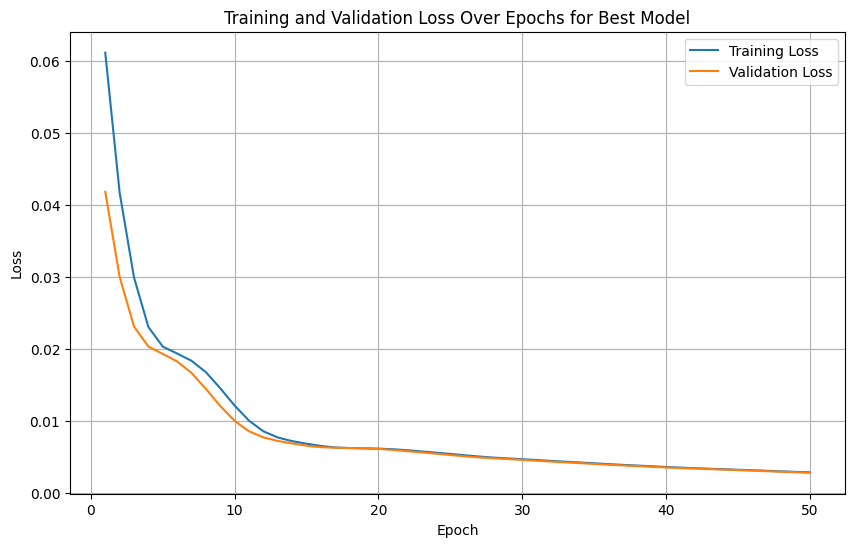

In [ ]:
# Plot Training and Validation Loss for the Best Model
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), all_train_losses[0], label='Training Loss')
plt.plot(range(1, epochs + 1), all_val_losses[0], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs for Best Model')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
training_history = torch.load("/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models/2_SMALL_best_model_info_train_set_separated.pt", weights_only=False)
best_hidden_sizes = training_history["hyperparameters"]["hidden_sizes"]
model = NeuralNetwork(hidden_sizes=best_hidden_sizes)
model.load_state_dict(training_history["model_state_dict"])

model.eval()
with torch.no_grad():
    y_test_pred_tensor = model(X_test_tensor)
    y_test_pred = y_test_pred_tensor.numpy()

# Calculate test metrics
test_mse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Root Mean Squared Error:", test_mse)
print("Test R^2 Score:", test_r2)

Test Root Mean Squared Error: 0.04188415646057013
Test R^2 Score: 0.7913484573364258


# 10K

## Dataset

In [12]:
# Create a Reduced Dataset
df = pd.read_csv("/content/drive/MyDrive/Machine_Learning/HW1/dataset/logfile_r2.csv",sep=';')
df_filtered = df[['j0', 'j1', 'ft_x', 'ft_y']]

# Calculate the number of rows to keep (10% of the original dataset)
n_keep = int(len(df_filtered) * 0.1)

# Randomly sample 10% of the rows
df_reduced_filtered = df_filtered.sample(n=n_keep, random_state=42)

# Reset the index
df_reduced_filtered.reset_index(drop=True, inplace=True)

print(f"Dataset Shape before: {df_filtered.shape}")
print(f"Dataset Shape after: {df_reduced_filtered.shape}")

# Define features (X) and target (Y)
X = df_reduced_filtered[['j0', 'j1']]
y = df_reduced_filtered[['ft_x', 'ft_y']]

# Split into training+validation and test sets (80% training+validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation set into training and validation sets (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Summary of the splits
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Dataset Shape before: (100000, 4)
Dataset Shape after: (10000, 4)
Training set size: 6000
Validation set size: 2000
Test set size: 2000


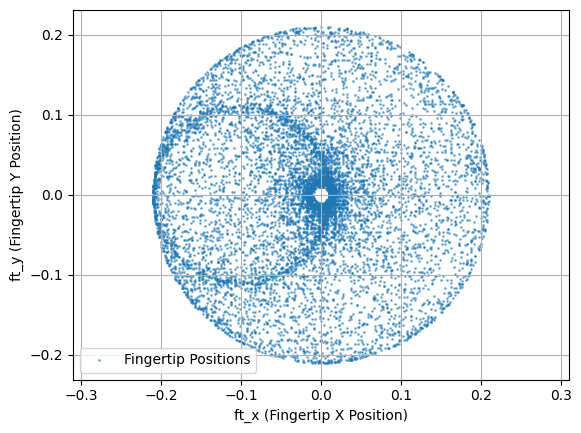

In [ ]:
plt.scatter(df_reduced_filtered['ft_x'], df_reduced_filtered['ft_y'], s=1, alpha=0.5, label='Fingertip Positions')
plt.xlabel('ft_x (Fingertip X Position)')
plt.ylabel('ft_y (Fingertip Y Position)')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Mantieni proporzioni reali per x e y
plt.show()

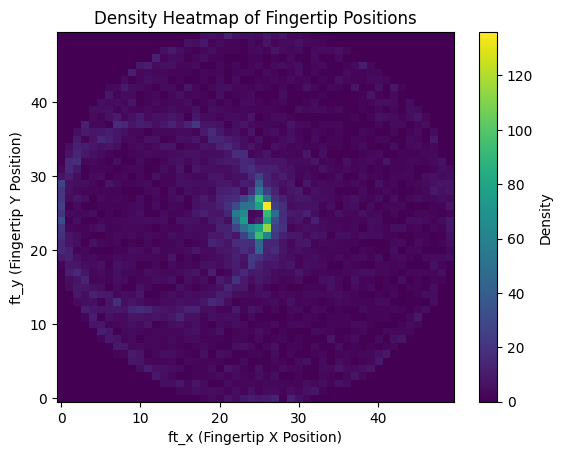

In [ ]:
heatmap, xedges, yedges = np.histogram2d(df_reduced_filtered['ft_x'], df_reduced_filtered['ft_y'], bins=50)

# Visualizzazione della heatmap
plt.imshow(heatmap.T, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Density')
plt.xlabel('ft_x (Fingertip X Position)')
plt.ylabel('ft_y (Fingertip Y Position)')
plt.title('Density Heatmap of Fingertip Positions')
plt.show()

In [56]:
#-------------------------Linear Regression-------------------------

# train
lr = MultiOutputRegressor(LinearRegression())
lr.fit(X_train, y_train)

# test
warnings.filterwarnings("ignore")
lr_rmse, lr_r2 = evaluate_model(lr, X_test, y_test)
print(f"Linear Regression RMSE: {lr_rmse}, R2: {lr_r2}")
print(" ")
print("--------------------------------------------------------------")
print(" ")

# ----------------------Decision tree regressor-------------------------

# train
dt_param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 20]
}
dt = DecisionTreeRegressor()
dt_grid = GridSearchCV(dt, dt_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
dt_grid.fit(X_train, y_train)

# test
best_dt = dt_grid.best_estimator_
dt_rmse, dt_r2 = evaluate_model(best_dt, X_test, y_test)
print(f"Decision Tree RMSE: {dt_rmse}, R2: {dt_r2}")
print(" ")
print("--------------------------------------------------------------")
print(" ")

# -----------------------------SVR-----------------------------

# train
svr_param_grid = {
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__C': [0.1, 1, 10],
    'estimator__epsilon': [0.01, 0.1, 1],
    'estimator__max_iter': [50]
}
svr = MultiOutputRegressor(SVR())
svr_grid = GridSearchCV(svr, svr_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
svr_grid.fit(X_train, y_train)


# test
best_svr = svr_grid.best_estimator_
svr_rmse, svr_r2 = evaluate_model(best_svr, X_test, y_test)
print(f"SVR Best Params: {svr_grid.best_params_}")
print(f"SVR RMSE: {svr_rmse}, R2: {svr_r2}")
print(" ")
print("--------------------------------------------------------------")
print(" ")

#---------------------------Random Forest--------------------------

# train
rf_param_grid = {
    'estimator__n_estimators': [100, 150],
    'estimator__max_depth': [5, 12]
}
rf = MultiOutputRegressor(RandomForestRegressor(random_state=42))
rf_grid = GridSearchCV(rf, rf_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)


#test
best_rf = rf_grid.best_estimator_
rf_rmse, rf_r2 = evaluate_model(best_rf, X_test, y_test)
print(f"Random Forest Best Params: {rf_grid.best_params_}")
print(f"Random Forest RMSE: {rf_rmse}, R2: {rf_r2}")
print(" ")
print("--------------------------------------------------------------")
print(" ")

#------------------------------------KNN---------------------------------------

# train
knn_param_grid = {
    'estimator__n_neighbors': [3, 5, 10],
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}
knn = MultiOutputRegressor(KNeighborsRegressor())
knn_grid = GridSearchCV(knn, knn_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
knn_grid.fit(X_train, y_train)

#test
best_knn = knn_grid.best_estimator_
knn_rmse, knn_r2 = evaluate_model(best_knn, X_test, y_test)
print(f"KNN Best Params: {knn_grid.best_params_}")
print(f"KNN RMSE: {knn_rmse}, R2: {knn_r2}")
print(" ")
print("--------------------------------------------------------------")
print(" ")

Linear Regression RMSE: 0.09032278851584771, R2: 0.07540580398396973
 
--------------------------------------------------------------
 
Decision Tree RMSE: 0.006919474731408673, R2: 0.9945755163684518
 
--------------------------------------------------------------
 
SVR Best Params: {'estimator__C': 10, 'estimator__epsilon': 0.01, 'estimator__kernel': 'rbf', 'estimator__max_iter': 50}
SVR RMSE: 0.02130585636849095, R2: 0.9453800078924595
 
--------------------------------------------------------------
 
Random Forest Best Params: {'estimator__max_depth': 12, 'estimator__n_estimators': 150}
Random Forest RMSE: 0.006686051075909381, R2: 0.9948322512878129
 
--------------------------------------------------------------
 
KNN Best Params: {'estimator__n_neighbors': 10, 'estimator__p': 2, 'estimator__weights': 'distance'}
KNN RMSE: 0.0029650642957182775, R2: 0.9990011191398983
 
--------------------------------------------------------------
 


In [13]:
# Conversion of data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_sizes):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        input_size = 2  # two input features: j0 and j1
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

        # Output layer
        output_size = 2  # output: ft_x and ft_y
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:  # Apply ReLU to all hidden layers
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'hidden_sizes': [[8, 8], [8, 16, 8], [8, 16, 32, 16, 8]],
    'optimizer': ['Adam', 'SGD', 'RMSprop']
}
grid = ParameterGrid(param_grid)

epochs = 50
best_val_loss = float('inf')
save_path = "/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models"

all_train_losses = []
all_val_losses = []
best_model_info = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "model_state_dict": None,
    "optimizer_state_dict": None,
    "hyperparameters": {}
}

In [ ]:
for params in grid:
    # Initialize model and criterion
    model = NeuralNetwork(hidden_sizes=params['hidden_sizes'])
    criterion = nn.MSELoss()

    # Choose optimizer based on parameter grid
    if params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'])

    # Track losses for each epoch
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in tqdm(range(epochs), desc=f"Training Model with LR={params['learning_rate']}, Layers={params['hidden_sizes']}, Optimizer={params['optimizer']}"):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        train_loss = criterion(outputs, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)

        # Store losses
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Check if this model is the best so far based on validation loss
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_info = {
                "epoch": epoch + 1,
                "train_loss": train_loss.item(),
                "val_loss": val_loss.item(),
                "model_state_dict": model.state_dict(),  # Store the best model weights
                "optimizer_state_dict": optimizer.state_dict(),  # Save the best optimizer state
                "hyperparameters": params  # Save the best hyperparameters for model reconstruction
            }

        # Update tqdm description with current losses
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

    # Save all losses for plotting
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

# Save the best model information to a file
torch.save(best_model_info, os.path.join(save_path, "AA_SMALL_best_model_info_CONSIDERATION.pt"))

Epoch [1/50], Training Loss: 0.0483, Validation Loss: 0.0298
Epoch [2/50], Training Loss: 0.0294, Validation Loss: 0.0206
Epoch [3/50], Training Loss: 0.0202, Validation Loss: 0.0186
Epoch [4/50], Training Loss: 0.0183, Validation Loss: 0.0186
Epoch [5/50], Training Loss: 0.0183, Validation Loss: 0.0176
Epoch [6/50], Training Loss: 0.0173, Validation Loss: 0.0154
Epoch [7/50], Training Loss: 0.0151, Validation Loss: 0.0127
Epoch [8/50], Training Loss: 0.0125, Validation Loss: 0.0104
Epoch [9/50], Training Loss: 0.0103, Validation Loss: 0.0091
Epoch [10/50], Training Loss: 0.0090, Validation Loss: 0.0087


Training Model with LR=0.01, Layers=[8, 8], Optimizer=Adam:  18%|█▊        | 9/50 [00:00<00:00, 77.33it/s]

Epoch [11/50], Training Loss: 0.0086, Validation Loss: 0.0089
Epoch [12/50], Training Loss: 0.0088, Validation Loss: 0.0092
Epoch [13/50], Training Loss: 0.0091, Validation Loss: 0.0092
Epoch [14/50], Training Loss: 0.0092, Validation Loss: 0.0090
Epoch [15/50], Training Loss: 0.0090, Validation Loss: 0.0085
Epoch [16/50], Training Loss: 0.0086, Validation Loss: 0.0080


Training Model with LR=0.01, Layers=[8, 8], Optimizer=Adam:  50%|█████     | 25/50 [00:00<00:00, 73.74it/s]

Epoch [17/50], Training Loss: 0.0081, Validation Loss: 0.0076
Epoch [18/50], Training Loss: 0.0077, Validation Loss: 0.0074
Epoch [19/50], Training Loss: 0.0075, Validation Loss: 0.0072
Epoch [20/50], Training Loss: 0.0073, Validation Loss: 0.0071
Epoch [21/50], Training Loss: 0.0072, Validation Loss: 0.0069
Epoch [22/50], Training Loss: 0.0070, Validation Loss: 0.0067
Epoch [23/50], Training Loss: 0.0067, Validation Loss: 0.0064
Epoch [24/50], Training Loss: 0.0064, Validation Loss: 0.0062
Epoch [25/50], Training Loss: 0.0061, Validation Loss: 0.0061
Epoch [26/50], Training Loss: 0.0060, Validation Loss: 0.0061


Training Model with LR=0.01, Layers=[8, 8], Optimizer=Adam:  50%|█████     | 25/50 [00:00<00:00, 73.74it/s]

Epoch [27/50], Training Loss: 0.0059, Validation Loss: 0.0061
Epoch [28/50], Training Loss: 0.0059, Validation Loss: 0.0060
Epoch [29/50], Training Loss: 0.0058, Validation Loss: 0.0059
Epoch [30/50], Training Loss: 0.0057, Validation Loss: 0.0057
Epoch [31/50], Training Loss: 0.0055, Validation Loss: 0.0055


Epoch [32/50], Training Loss: 0.0053, Validation Loss: 0.0053
Epoch [33/50], Training Loss: 0.0052, Validation Loss: 0.0052
Epoch [34/50], Training Loss: 0.0051, Validation Loss: 0.0052
Epoch [35/50], Training Loss: 0.0051, Validation Loss: 0.0052
Epoch [36/50], Training Loss: 0.0050, Validation Loss: 0.0051
Epoch [37/50], Training Loss: 0.0050, Validation Loss: 0.0050
Epoch [38/50], Training Loss: 0.0049, Validation Loss: 0.0049
Epoch [39/50], Training Loss: 0.0048, Validation Loss: 0.0047
Epoch [40/50], Training Loss: 0.0046, Validation Loss: 0.0046
Epoch [41/50], Training Loss: 0.0045, Validation Loss: 0.0045


Epoch [42/50], Training Loss: 0.0044, Validation Loss: 0.0045
Epoch [43/50], Training Loss: 0.0043, Validation Loss: 0.0044
Epoch [44/50], Training Loss: 0.0043, Validation Loss: 0.0044
Epoch [45/50], Training Loss: 0.0042, Validation Loss: 0.0043


Training Model with LR=0.01, Layers=[8, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:00<00:00, 71.62it/s]


Epoch [46/50], Training Loss: 0.0042, Validation Loss: 0.0042
Epoch [47/50], Training Loss: 0.0041, Validation Loss: 0.0041
Epoch [48/50], Training Loss: 0.0040, Validation Loss: 0.0040
Epoch [49/50], Training Loss: 0.0039, Validation Loss: 0.0040
Epoch [50/50], Training Loss: 0.0039, Validation Loss: 0.0039


Training Model with LR=0.01, Layers=[8, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.2085, Validation Loss: 0.1899
Epoch [2/50], Training Loss: 0.1940, Validation Loss: 0.1770
Epoch [3/50], Training Loss: 0.1808, Validation Loss: 0.1652
Epoch [4/50], Training Loss: 0.1688, Validation Loss: 0.1544
Epoch [5/50], Training Loss: 0.1577, Validation Loss: 0.1445
Epoch [6/50], Training Loss: 0.1476, Validation Loss: 0.1354


Training Model with LR=0.01, Layers=[8, 8], Optimizer=SGD:  20%|██        | 10/50 [00:00<00:00, 85.23it/s]

Epoch [7/50], Training Loss: 0.1383, Validation Loss: 0.1271
Epoch [8/50], Training Loss: 0.1298, Validation Loss: 0.1194
Epoch [9/50], Training Loss: 0.1219, Validation Loss: 0.1123
Epoch [10/50], Training Loss: 0.1147, Validation Loss: 0.1058


Training Model with LR=0.01, Layers=[8, 8], Optimizer=SGD:  20%|██        | 10/50 [00:00<00:00, 85.23it/s]

Epoch [11/50], Training Loss: 0.1080, Validation Loss: 0.0998
Epoch [12/50], Training Loss: 0.1019, Validation Loss: 0.0943
Epoch [13/50], Training Loss: 0.0962, Validation Loss: 0.0891
Epoch [14/50], Training Loss: 0.0909, Validation Loss: 0.0844
Epoch [15/50], Training Loss: 0.0861, Validation Loss: 0.0800


Training Model with LR=0.01, Layers=[8, 8], Optimizer=SGD:  20%|██        | 10/50 [00:00<00:00, 85.23it/s]

Epoch [16/50], Training Loss: 0.0816, Validation Loss: 0.0760
Epoch [17/50], Training Loss: 0.0774, Validation Loss: 0.0722
Epoch [18/50], Training Loss: 0.0736, Validation Loss: 0.0687


Epoch [19/50], Training Loss: 0.0700, Validation Loss: 0.0655
Epoch [20/50], Training Loss: 0.0667, Validation Loss: 0.0625


Epoch [21/50], Training Loss: 0.0636, Validation Loss: 0.0597
Epoch [22/50], Training Loss: 0.0608, Validation Loss: 0.0572
Epoch [23/50], Training Loss: 0.0581, Validation Loss: 0.0548
Epoch [24/50], Training Loss: 0.0557, Validation Loss: 0.0525
Epoch [25/50], Training Loss: 0.0534, Validation Loss: 0.0505


Training Model with LR=0.01, Layers=[8, 8], Optimizer=SGD:  52%|█████▏    | 26/50 [00:00<00:00, 59.91it/s]

Epoch [26/50], Training Loss: 0.0512, Validation Loss: 0.0485
Epoch [27/50], Training Loss: 0.0493, Validation Loss: 0.0467
Epoch [28/50], Training Loss: 0.0474, Validation Loss: 0.0450
Epoch [29/50], Training Loss: 0.0457, Validation Loss: 0.0435
Epoch [30/50], Training Loss: 0.0441, Validation Loss: 0.0420


Training Model with LR=0.01, Layers=[8, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:00<00:00, 58.63it/s]

Epoch [31/50], Training Loss: 0.0426, Validation Loss: 0.0407
Epoch [32/50], Training Loss: 0.0412, Validation Loss: 0.0394
Epoch [33/50], Training Loss: 0.0399, Validation Loss: 0.0382


Training Model with LR=0.01, Layers=[8, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:00<00:00, 58.63it/s]

Epoch [34/50], Training Loss: 0.0387, Validation Loss: 0.0371
Epoch [35/50], Training Loss: 0.0375, Validation Loss: 0.0361
Epoch [36/50], Training Loss: 0.0365, Validation Loss: 0.0351
Epoch [37/50], Training Loss: 0.0355, Validation Loss: 0.0342
Epoch [38/50], Training Loss: 0.0346, Validation Loss: 0.0333
Epoch [39/50], Training Loss: 0.0337, Validation Loss: 0.0325


Epoch [40/50], Training Loss: 0.0329, Validation Loss: 0.0318
Epoch [41/50], Training Loss: 0.0321, Validation Loss: 0.0311
Epoch [42/50], Training Loss: 0.0314, Validation Loss: 0.0305


Epoch [43/50], Training Loss: 0.0307, Validation Loss: 0.0298
Epoch [44/50], Training Loss: 0.0301, Validation Loss: 0.0293
Epoch [45/50], Training Loss: 0.0295, Validation Loss: 0.0287


Training Model with LR=0.01, Layers=[8, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 60.79it/s]


Epoch [46/50], Training Loss: 0.0290, Validation Loss: 0.0282
Epoch [47/50], Training Loss: 0.0284, Validation Loss: 0.0277
Epoch [48/50], Training Loss: 0.0279, Validation Loss: 0.0273
Epoch [49/50], Training Loss: 0.0275, Validation Loss: 0.0269
Epoch [50/50], Training Loss: 0.0270, Validation Loss: 0.0265


Training Model with LR=0.01, Layers=[8, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0517, Validation Loss: 0.0417
Epoch [2/50], Training Loss: 0.0414, Validation Loss: 0.0486
Epoch [3/50], Training Loss: 0.0485, Validation Loss: 0.0254
Epoch [4/50], Training Loss: 0.0255, Validation Loss: 0.0081
Epoch [5/50], Training Loss: 0.0079, Validation Loss: 0.0076
Epoch [6/50], Training Loss: 0.0074, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[8, 8], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:00<00:00, 68.32it/s]

Epoch [7/50], Training Loss: 0.0072, Validation Loss: 0.0072
Epoch [8/50], Training Loss: 0.0070, Validation Loss: 0.0071
Epoch [9/50], Training Loss: 0.0069, Validation Loss: 0.0070


Training Model with LR=0.01, Layers=[8, 8], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:00<00:00, 68.32it/s]

Epoch [10/50], Training Loss: 0.0068, Validation Loss: 0.0069
Epoch [11/50], Training Loss: 0.0067, Validation Loss: 0.0068
Epoch [12/50], Training Loss: 0.0066, Validation Loss: 0.0067
Epoch [13/50], Training Loss: 0.0065, Validation Loss: 0.0065


Training Model with LR=0.01, Layers=[8, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:00, 61.04it/s]

Epoch [14/50], Training Loss: 0.0064, Validation Loss: 0.0065
Epoch [15/50], Training Loss: 0.0063, Validation Loss: 0.0064
Epoch [16/50], Training Loss: 0.0062, Validation Loss: 0.0063
Epoch [17/50], Training Loss: 0.0061, Validation Loss: 0.0062
Epoch [18/50], Training Loss: 0.0060, Validation Loss: 0.0061


Training Model with LR=0.01, Layers=[8, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:00, 61.04it/s]

Epoch [19/50], Training Loss: 0.0059, Validation Loss: 0.0060
Epoch [20/50], Training Loss: 0.0059, Validation Loss: 0.0060


Training Model with LR=0.01, Layers=[8, 8], Optimizer=RMSprop:  42%|████▏     | 21/50 [00:00<00:00, 58.39it/s]

Epoch [21/50], Training Loss: 0.0058, Validation Loss: 0.0059
Epoch [22/50], Training Loss: 0.0057, Validation Loss: 0.0058
Epoch [23/50], Training Loss: 0.0056, Validation Loss: 0.0058
Epoch [24/50], Training Loss: 0.0056, Validation Loss: 0.0057
Epoch [25/50], Training Loss: 0.0055, Validation Loss: 0.0056


Training Model with LR=0.01, Layers=[8, 8], Optimizer=RMSprop:  54%|█████▍    | 27/50 [00:00<00:00, 58.29it/s]

Epoch [26/50], Training Loss: 0.0055, Validation Loss: 0.0056
Epoch [27/50], Training Loss: 0.0054, Validation Loss: 0.0055
Epoch [28/50], Training Loss: 0.0053, Validation Loss: 0.0055
Epoch [29/50], Training Loss: 0.0053, Validation Loss: 0.0054
Epoch [30/50], Training Loss: 0.0052, Validation Loss: 0.0054
Epoch [31/50], Training Loss: 0.0052, Validation Loss: 0.0053


Training Model with LR=0.01, Layers=[8, 8], Optimizer=RMSprop:  54%|█████▍    | 27/50 [00:00<00:00, 58.29it/s]

Epoch [32/50], Training Loss: 0.0052, Validation Loss: 0.0053
Epoch [33/50], Training Loss: 0.0051, Validation Loss: 0.0052


Training Model with LR=0.01, Layers=[8, 8], Optimizer=RMSprop:  68%|██████▊   | 34/50 [00:00<00:00, 59.46it/s]

Epoch [34/50], Training Loss: 0.0051, Validation Loss: 0.0052
Epoch [35/50], Training Loss: 0.0050, Validation Loss: 0.0052
Epoch [36/50], Training Loss: 0.0050, Validation Loss: 0.0051
Epoch [37/50], Training Loss: 0.0049, Validation Loss: 0.0051
Epoch [38/50], Training Loss: 0.0049, Validation Loss: 0.0050
Epoch [39/50], Training Loss: 0.0049, Validation Loss: 0.0050


Training Model with LR=0.01, Layers=[8, 8], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:00<00:00, 64.68it/s]

Epoch [40/50], Training Loss: 0.0048, Validation Loss: 0.0049
Epoch [41/50], Training Loss: 0.0048, Validation Loss: 0.0049
Epoch [42/50], Training Loss: 0.0047, Validation Loss: 0.0049
Epoch [43/50], Training Loss: 0.0047, Validation Loss: 0.0048
Epoch [44/50], Training Loss: 0.0047, Validation Loss: 0.0048
Epoch [45/50], Training Loss: 0.0046, Validation Loss: 0.0047
Epoch [46/50], Training Loss: 0.0046, Validation Loss: 0.0047
Epoch [47/50], Training Loss: 0.0045, Validation Loss: 0.0047


Training Model with LR=0.01, Layers=[8, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:00<00:00, 65.02it/s]

Epoch [48/50], Training Loss: 0.0045, Validation Loss: 0.0046
Epoch [49/50], Training Loss: 0.0045, Validation Loss: 0.0046
Epoch [50/50], Training Loss: 0.0044, Validation Loss: 0.0045



Training Model with LR=0.001, Layers=[8, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.2149, Validation Loss: 0.2025
Epoch [2/50], Training Loss: 0.2092, Validation Loss: 0.1971
Epoch [3/50], Training Loss: 0.2036, Validation Loss: 0.1919


Training Model with LR=0.001, Layers=[8, 8], Optimizer=Adam:  10%|█         | 5/50 [00:00<00:00, 49.85it/s]

Epoch [4/50], Training Loss: 0.1981, Validation Loss: 0.1867
Epoch [5/50], Training Loss: 0.1927, Validation Loss: 0.1817
Epoch [6/50], Training Loss: 0.1875, Validation Loss: 0.1768
Epoch [7/50], Training Loss: 0.1823, Validation Loss: 0.1720
Epoch [8/50], Training Loss: 0.1773, Validation Loss: 0.1673


Training Model with LR=0.001, Layers=[8, 8], Optimizer=Adam:  22%|██▏       | 11/50 [00:00<00:00, 52.28it/s]

Epoch [9/50], Training Loss: 0.1724, Validation Loss: 0.1627
Epoch [10/50], Training Loss: 0.1677, Validation Loss: 0.1582
Epoch [11/50], Training Loss: 0.1630, Validation Loss: 0.1539


Training Model with LR=0.001, Layers=[8, 8], Optimizer=Adam:  22%|██▏       | 11/50 [00:00<00:00, 52.28it/s]

Epoch [12/50], Training Loss: 0.1585, Validation Loss: 0.1497
Epoch [13/50], Training Loss: 0.1541, Validation Loss: 0.1456
Epoch [14/50], Training Loss: 0.1498, Validation Loss: 0.1416
Epoch [15/50], Training Loss: 0.1456, Validation Loss: 0.1377


Epoch [16/50], Training Loss: 0.1415, Validation Loss: 0.1339
Epoch [17/50], Training Loss: 0.1376, Validation Loss: 0.1302
Epoch [18/50], Training Loss: 0.1337, Validation Loss: 0.1266
Epoch [19/50], Training Loss: 0.1300, Validation Loss: 0.1232
Epoch [20/50], Training Loss: 0.1264, Validation Loss: 0.1198


Training Model with LR=0.001, Layers=[8, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:00<00:00, 56.44it/s]

Epoch [21/50], Training Loss: 0.1229, Validation Loss: 0.1165
Epoch [22/50], Training Loss: 0.1195, Validation Loss: 0.1133
Epoch [23/50], Training Loss: 0.1161, Validation Loss: 0.1102
Epoch [24/50], Training Loss: 0.1129, Validation Loss: 0.1073


Epoch [25/50], Training Loss: 0.1098, Validation Loss: 0.1043
Epoch [26/50], Training Loss: 0.1068, Validation Loss: 0.1015
Epoch [27/50], Training Loss: 0.1038, Validation Loss: 0.0988


Training Model with LR=0.001, Layers=[8, 8], Optimizer=Adam:  62%|██████▏   | 31/50 [00:00<00:00, 57.40it/s]

Epoch [28/50], Training Loss: 0.1010, Validation Loss: 0.0961
Epoch [29/50], Training Loss: 0.0982, Validation Loss: 0.0935
Epoch [30/50], Training Loss: 0.0955, Validation Loss: 0.0910
Epoch [31/50], Training Loss: 0.0929, Validation Loss: 0.0886
Epoch [32/50], Training Loss: 0.0904, Validation Loss: 0.0863


Training Model with LR=0.001, Layers=[8, 8], Optimizer=Adam:  62%|██████▏   | 31/50 [00:00<00:00, 57.40it/s]

Epoch [33/50], Training Loss: 0.0880, Validation Loss: 0.0840
Epoch [34/50], Training Loss: 0.0856, Validation Loss: 0.0817
Epoch [35/50], Training Loss: 0.0833, Validation Loss: 0.0796
Epoch [36/50], Training Loss: 0.0810, Validation Loss: 0.0775


Training Model with LR=0.001, Layers=[8, 8], Optimizer=Adam:  74%|███████▍  | 37/50 [00:00<00:00, 57.96it/s]

Epoch [37/50], Training Loss: 0.0789, Validation Loss: 0.0755
Epoch [38/50], Training Loss: 0.0768, Validation Loss: 0.0735
Epoch [39/50], Training Loss: 0.0747, Validation Loss: 0.0716


Training Model with LR=0.001, Layers=[8, 8], Optimizer=Adam:  86%|████████▌ | 43/50 [00:00<00:00, 56.33it/s]

Epoch [40/50], Training Loss: 0.0727, Validation Loss: 0.0697
Epoch [41/50], Training Loss: 0.0708, Validation Loss: 0.0679
Epoch [42/50], Training Loss: 0.0689, Validation Loss: 0.0661
Epoch [43/50], Training Loss: 0.0671, Validation Loss: 0.0644
Epoch [44/50], Training Loss: 0.0653, Validation Loss: 0.0627


Training Model with LR=0.001, Layers=[8, 8], Optimizer=Adam:  86%|████████▌ | 43/50 [00:00<00:00, 56.33it/s]

Epoch [45/50], Training Loss: 0.0636, Validation Loss: 0.0610
Epoch [46/50], Training Loss: 0.0619, Validation Loss: 0.0594
Epoch [47/50], Training Loss: 0.0602, Validation Loss: 0.0579
Epoch [48/50], Training Loss: 0.0586, Validation Loss: 0.0563


Training Model with LR=0.001, Layers=[8, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:00<00:00, 56.28it/s]


Epoch [49/50], Training Loss: 0.0570, Validation Loss: 0.0548
Epoch [50/50], Training Loss: 0.0555, Validation Loss: 0.0533


Training Model with LR=0.001, Layers=[8, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.1134, Validation Loss: 0.1055
Epoch [2/50], Training Loss: 0.1128, Validation Loss: 0.1049
Epoch [3/50], Training Loss: 0.1122, Validation Loss: 0.1044
Epoch [4/50], Training Loss: 0.1117, Validation Loss: 0.1039
Epoch [5/50], Training Loss: 0.1111, Validation Loss: 0.1033
Epoch [6/50], Training Loss: 0.1105, Validation Loss: 0.1028


Epoch [7/50], Training Loss: 0.1100, Validation Loss: 0.1023
Epoch [8/50], Training Loss: 0.1094, Validation Loss: 0.1018
Epoch [9/50], Training Loss: 0.1089, Validation Loss: 0.1013
Epoch [10/50], Training Loss: 0.1083, Validation Loss: 0.1008
Epoch [11/50], Training Loss: 0.1078, Validation Loss: 0.1002


Training Model with LR=0.001, Layers=[8, 8], Optimizer=SGD:  32%|███▏      | 16/50 [00:00<00:00, 75.01it/s]

Epoch [12/50], Training Loss: 0.1072, Validation Loss: 0.0997
Epoch [13/50], Training Loss: 0.1067, Validation Loss: 0.0992
Epoch [14/50], Training Loss: 0.1062, Validation Loss: 0.0988
Epoch [15/50], Training Loss: 0.1056, Validation Loss: 0.0983
Epoch [16/50], Training Loss: 0.1051, Validation Loss: 0.0978


Training Model with LR=0.001, Layers=[8, 8], Optimizer=SGD:  32%|███▏      | 16/50 [00:00<00:00, 75.01it/s]

Epoch [17/50], Training Loss: 0.1046, Validation Loss: 0.0973
Epoch [18/50], Training Loss: 0.1041, Validation Loss: 0.0968
Epoch [19/50], Training Loss: 0.1036, Validation Loss: 0.0964
Epoch [20/50], Training Loss: 0.1031, Validation Loss: 0.0959
Epoch [21/50], Training Loss: 0.1026, Validation Loss: 0.0954
Epoch [22/50], Training Loss: 0.1021, Validation Loss: 0.0950
Epoch [23/50], Training Loss: 0.1016, Validation Loss: 0.0945


Training Model with LR=0.001, Layers=[8, 8], Optimizer=SGD:  50%|█████     | 25/50 [00:00<00:00, 75.85it/s]

Epoch [24/50], Training Loss: 0.1011, Validation Loss: 0.0940
Epoch [25/50], Training Loss: 0.1006, Validation Loss: 0.0936
Epoch [26/50], Training Loss: 0.1001, Validation Loss: 0.0931
Epoch [27/50], Training Loss: 0.0996, Validation Loss: 0.0927
Epoch [28/50], Training Loss: 0.0991, Validation Loss: 0.0922


Training Model with LR=0.001, Layers=[8, 8], Optimizer=SGD:  50%|█████     | 25/50 [00:00<00:00, 75.85it/s]

Epoch [29/50], Training Loss: 0.0987, Validation Loss: 0.0918
Epoch [30/50], Training Loss: 0.0982, Validation Loss: 0.0914
Epoch [31/50], Training Loss: 0.0977, Validation Loss: 0.0909
Epoch [32/50], Training Loss: 0.0973, Validation Loss: 0.0905
Epoch [33/50], Training Loss: 0.0968, Validation Loss: 0.0901


Training Model with LR=0.001, Layers=[8, 8], Optimizer=SGD:  70%|███████   | 35/50 [00:00<00:00, 81.79it/s]

Epoch [34/50], Training Loss: 0.0963, Validation Loss: 0.0897
Epoch [35/50], Training Loss: 0.0959, Validation Loss: 0.0892
Epoch [36/50], Training Loss: 0.0954, Validation Loss: 0.0888
Epoch [37/50], Training Loss: 0.0950, Validation Loss: 0.0884
Epoch [38/50], Training Loss: 0.0946, Validation Loss: 0.0880
Epoch [39/50], Training Loss: 0.0941, Validation Loss: 0.0876
Epoch [40/50], Training Loss: 0.0937, Validation Loss: 0.0872
Epoch [41/50], Training Loss: 0.0933, Validation Loss: 0.0868


Training Model with LR=0.001, Layers=[8, 8], Optimizer=SGD:  70%|███████   | 35/50 [00:00<00:00, 81.79it/s]

Epoch [42/50], Training Loss: 0.0928, Validation Loss: 0.0864


Training Model with LR=0.001, Layers=[8, 8], Optimizer=SGD:  88%|████████▊ | 44/50 [00:00<00:00, 64.55it/s]

Epoch [43/50], Training Loss: 0.0924, Validation Loss: 0.0860
Epoch [44/50], Training Loss: 0.0920, Validation Loss: 0.0856


Training Model with LR=0.001, Layers=[8, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 67.30it/s]


Epoch [45/50], Training Loss: 0.0915, Validation Loss: 0.0852
Epoch [46/50], Training Loss: 0.0911, Validation Loss: 0.0848
Epoch [47/50], Training Loss: 0.0907, Validation Loss: 0.0845
Epoch [48/50], Training Loss: 0.0903, Validation Loss: 0.0841
Epoch [49/50], Training Loss: 0.0899, Validation Loss: 0.0837
Epoch [50/50], Training Loss: 0.0895, Validation Loss: 0.0833


Training Model with LR=0.001, Layers=[8, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.1703, Validation Loss: 0.1084
Epoch [2/50], Training Loss: 0.1139, Validation Loss: 0.0837


Training Model with LR=0.001, Layers=[8, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50], Training Loss: 0.0879, Validation Loss: 0.0683
Epoch [4/50], Training Loss: 0.0715, Validation Loss: 0.0576
Epoch [5/50], Training Loss: 0.0602, Validation Loss: 0.0498


Training Model with LR=0.001, Layers=[8, 8], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:00, 52.17it/s]

Epoch [6/50], Training Loss: 0.0519, Validation Loss: 0.0438
Epoch [7/50], Training Loss: 0.0457, Validation Loss: 0.0392
Epoch [8/50], Training Loss: 0.0408, Validation Loss: 0.0355
Epoch [9/50], Training Loss: 0.0369, Validation Loss: 0.0326
Epoch [10/50], Training Loss: 0.0338, Validation Loss: 0.0301
Epoch [11/50], Training Loss: 0.0312, Validation Loss: 0.0280


Training Model with LR=0.001, Layers=[8, 8], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:00, 50.74it/s]

Epoch [12/50], Training Loss: 0.0290, Validation Loss: 0.0263


Training Model with LR=0.001, Layers=[8, 8], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:00, 50.74it/s]

Epoch [13/50], Training Loss: 0.0272, Validation Loss: 0.0248
Epoch [14/50], Training Loss: 0.0256, Validation Loss: 0.0236


Epoch [15/50], Training Loss: 0.0243, Validation Loss: 0.0224
Epoch [16/50], Training Loss: 0.0231, Validation Loss: 0.0214
Epoch [17/50], Training Loss: 0.0221, Validation Loss: 0.0206
Epoch [18/50], Training Loss: 0.0212, Validation Loss: 0.0197
Epoch [19/50], Training Loss: 0.0203, Validation Loss: 0.0190
Epoch [20/50], Training Loss: 0.0196, Validation Loss: 0.0183
Epoch [21/50], Training Loss: 0.0189, Validation Loss: 0.0177


Training Model with LR=0.001, Layers=[8, 8], Optimizer=RMSprop:  36%|███▌      | 18/50 [00:00<00:00, 44.77it/s]

Epoch [22/50], Training Loss: 0.0182, Validation Loss: 0.0172
Epoch [23/50], Training Loss: 0.0176, Validation Loss: 0.0166
Epoch [24/50], Training Loss: 0.0171, Validation Loss: 0.0161


Training Model with LR=0.001, Layers=[8, 8], Optimizer=RMSprop:  52%|█████▏    | 26/50 [00:00<00:00, 52.15it/s]

Epoch [25/50], Training Loss: 0.0165, Validation Loss: 0.0156
Epoch [26/50], Training Loss: 0.0160, Validation Loss: 0.0152
Epoch [27/50], Training Loss: 0.0155, Validation Loss: 0.0147
Epoch [28/50], Training Loss: 0.0151, Validation Loss: 0.0143


Epoch [29/50], Training Loss: 0.0147, Validation Loss: 0.0139
Epoch [30/50], Training Loss: 0.0142, Validation Loss: 0.0135
Epoch [31/50], Training Loss: 0.0138, Validation Loss: 0.0131
Epoch [32/50], Training Loss: 0.0134, Validation Loss: 0.0128
Epoch [33/50], Training Loss: 0.0130, Validation Loss: 0.0124


Training Model with LR=0.001, Layers=[8, 8], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:00<00:00, 55.23it/s]

Epoch [34/50], Training Loss: 0.0126, Validation Loss: 0.0120
Epoch [35/50], Training Loss: 0.0122, Validation Loss: 0.0116
Epoch [36/50], Training Loss: 0.0118, Validation Loss: 0.0112
Epoch [37/50], Training Loss: 0.0114, Validation Loss: 0.0109


Training Model with LR=0.001, Layers=[8, 8], Optimizer=RMSprop:  82%|████████▏ | 41/50 [00:00<00:00, 59.66it/s]

Epoch [38/50], Training Loss: 0.0111, Validation Loss: 0.0106
Epoch [39/50], Training Loss: 0.0107, Validation Loss: 0.0104
Epoch [40/50], Training Loss: 0.0105, Validation Loss: 0.0101
Epoch [41/50], Training Loss: 0.0102, Validation Loss: 0.0099
Epoch [42/50], Training Loss: 0.0100, Validation Loss: 0.0097


Epoch [43/50], Training Loss: 0.0098, Validation Loss: 0.0095
Epoch [44/50], Training Loss: 0.0096, Validation Loss: 0.0094
Epoch [45/50], Training Loss: 0.0094, Validation Loss: 0.0092
Epoch [46/50], Training Loss: 0.0093, Validation Loss: 0.0091


Training Model with LR=0.001, Layers=[8, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:00<00:00, 56.02it/s]


Epoch [47/50], Training Loss: 0.0091, Validation Loss: 0.0089
Epoch [48/50], Training Loss: 0.0090, Validation Loss: 0.0088
Epoch [49/50], Training Loss: 0.0089, Validation Loss: 0.0087
Epoch [50/50], Training Loss: 0.0087, Validation Loss: 0.0086


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0375, Validation Loss: 0.0374
Epoch [2/50], Training Loss: 0.0374, Validation Loss: 0.0373
Epoch [3/50], Training Loss: 0.0373, Validation Loss: 0.0372
Epoch [4/50], Training Loss: 0.0372, Validation Loss: 0.0371


Epoch [5/50], Training Loss: 0.0371, Validation Loss: 0.0370
Epoch [6/50], Training Loss: 0.0370, Validation Loss: 0.0369
Epoch [7/50], Training Loss: 0.0369, Validation Loss: 0.0369


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:00, 56.22it/s]

Epoch [8/50], Training Loss: 0.0368, Validation Loss: 0.0368
Epoch [9/50], Training Loss: 0.0368, Validation Loss: 0.0367
Epoch [10/50], Training Loss: 0.0367, Validation Loss: 0.0366
Epoch [11/50], Training Loss: 0.0366, Validation Loss: 0.0365
Epoch [12/50], Training Loss: 0.0365, Validation Loss: 0.0364


Epoch [13/50], Training Loss: 0.0364, Validation Loss: 0.0363
Epoch [14/50], Training Loss: 0.0363, Validation Loss: 0.0362
Epoch [15/50], Training Loss: 0.0362, Validation Loss: 0.0361


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:00<00:00, 55.95it/s]

Epoch [16/50], Training Loss: 0.0362, Validation Loss: 0.0360
Epoch [17/50], Training Loss: 0.0361, Validation Loss: 0.0360
Epoch [18/50], Training Loss: 0.0360, Validation Loss: 0.0359
Epoch [19/50], Training Loss: 0.0359, Validation Loss: 0.0358


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:00<00:00, 57.10it/s]

Epoch [20/50], Training Loss: 0.0358, Validation Loss: 0.0357
Epoch [21/50], Training Loss: 0.0357, Validation Loss: 0.0356
Epoch [22/50], Training Loss: 0.0356, Validation Loss: 0.0355
Epoch [23/50], Training Loss: 0.0356, Validation Loss: 0.0354
Epoch [24/50], Training Loss: 0.0355, Validation Loss: 0.0354


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:00<00:00, 57.10it/s]

Epoch [25/50], Training Loss: 0.0354, Validation Loss: 0.0353
Epoch [26/50], Training Loss: 0.0353, Validation Loss: 0.0352
Epoch [27/50], Training Loss: 0.0352, Validation Loss: 0.0351


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 53.68it/s]

Epoch [28/50], Training Loss: 0.0352, Validation Loss: 0.0350
Epoch [29/50], Training Loss: 0.0351, Validation Loss: 0.0349
Epoch [30/50], Training Loss: 0.0350, Validation Loss: 0.0349


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 53.68it/s]

Epoch [31/50], Training Loss: 0.0349, Validation Loss: 0.0348
Epoch [32/50], Training Loss: 0.0348, Validation Loss: 0.0347
Epoch [33/50], Training Loss: 0.0348, Validation Loss: 0.0346
Epoch [34/50], Training Loss: 0.0347, Validation Loss: 0.0345
Epoch [35/50], Training Loss: 0.0346, Validation Loss: 0.0345


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:00<00:00, 53.50it/s]

Epoch [36/50], Training Loss: 0.0345, Validation Loss: 0.0344
Epoch [37/50], Training Loss: 0.0344, Validation Loss: 0.0343
Epoch [38/50], Training Loss: 0.0344, Validation Loss: 0.0342


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:00<00:00, 53.50it/s]

Epoch [39/50], Training Loss: 0.0343, Validation Loss: 0.0341
Epoch [40/50], Training Loss: 0.0342, Validation Loss: 0.0341
Epoch [41/50], Training Loss: 0.0341, Validation Loss: 0.0340


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:00<00:00, 52.44it/s]

Epoch [42/50], Training Loss: 0.0341, Validation Loss: 0.0339
Epoch [43/50], Training Loss: 0.0340, Validation Loss: 0.0338
Epoch [44/50], Training Loss: 0.0339, Validation Loss: 0.0338
Epoch [45/50], Training Loss: 0.0338, Validation Loss: 0.0337


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=Adam:  96%|█████████▌| 48/50 [00:00<00:00, 50.06it/s]

Epoch [46/50], Training Loss: 0.0338, Validation Loss: 0.0336
Epoch [47/50], Training Loss: 0.0337, Validation Loss: 0.0335
Epoch [48/50], Training Loss: 0.0336, Validation Loss: 0.0334


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:00<00:00, 52.47it/s]


Epoch [49/50], Training Loss: 0.0335, Validation Loss: 0.0334
Epoch [50/50], Training Loss: 0.0335, Validation Loss: 0.0333


Epoch [1/50], Training Loss: 0.1398, Validation Loss: 0.1361
Epoch [2/50], Training Loss: 0.1397, Validation Loss: 0.1360
Epoch [3/50], Training Loss: 0.1397, Validation Loss: 0.1360
Epoch [4/50], Training Loss: 0.1396, Validation Loss: 0.1359
Epoch [5/50], Training Loss: 0.1396, Validation Loss: 0.1359


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:00, 55.00it/s]

Epoch [6/50], Training Loss: 0.1395, Validation Loss: 0.1358
Epoch [7/50], Training Loss: 0.1395, Validation Loss: 0.1358
Epoch [8/50], Training Loss: 0.1394, Validation Loss: 0.1357
Epoch [9/50], Training Loss: 0.1394, Validation Loss: 0.1357
Epoch [10/50], Training Loss: 0.1393, Validation Loss: 0.1356


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:00, 57.19it/s]

Epoch [11/50], Training Loss: 0.1393, Validation Loss: 0.1356
Epoch [12/50], Training Loss: 0.1392, Validation Loss: 0.1355
Epoch [13/50], Training Loss: 0.1392, Validation Loss: 0.1355


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:00, 57.19it/s]

Epoch [14/50], Training Loss: 0.1391, Validation Loss: 0.1354
Epoch [15/50], Training Loss: 0.1391, Validation Loss: 0.1354
Epoch [16/50], Training Loss: 0.1390, Validation Loss: 0.1353
Epoch [17/50], Training Loss: 0.1390, Validation Loss: 0.1353
Epoch [18/50], Training Loss: 0.1389, Validation Loss: 0.1353


Epoch [19/50], Training Loss: 0.1388, Validation Loss: 0.1352
Epoch [20/50], Training Loss: 0.1388, Validation Loss: 0.1352
Epoch [21/50], Training Loss: 0.1387, Validation Loss: 0.1351
Epoch [22/50], Training Loss: 0.1387, Validation Loss: 0.1351
Epoch [23/50], Training Loss: 0.1386, Validation Loss: 0.1350
Epoch [24/50], Training Loss: 0.1386, Validation Loss: 0.1350

Training Model with LR=0.0001, Layers=[8, 8], Optimizer=SGD:  52%|█████▏    | 26/50 [00:00<00:00, 61.93it/s]


Epoch [25/50], Training Loss: 0.1385, Validation Loss: 0.1349
Epoch [26/50], Training Loss: 0.1385, Validation Loss: 0.1349
Epoch [27/50], Training Loss: 0.1384, Validation Loss: 0.1348


Epoch [28/50], Training Loss: 0.1384, Validation Loss: 0.1348
Epoch [29/50], Training Loss: 0.1383, Validation Loss: 0.1347
Epoch [30/50], Training Loss: 0.1383, Validation Loss: 0.1347
Epoch [31/50], Training Loss: 0.1382, Validation Loss: 0.1346


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:00<00:00, 61.94it/s]

Epoch [32/50], Training Loss: 0.1382, Validation Loss: 0.1346
Epoch [33/50], Training Loss: 0.1381, Validation Loss: 0.1345
Epoch [34/50], Training Loss: 0.1381, Validation Loss: 0.1345
Epoch [35/50], Training Loss: 0.1380, Validation Loss: 0.1344
Epoch [36/50], Training Loss: 0.1380, Validation Loss: 0.1344


Epoch [37/50], Training Loss: 0.1379, Validation Loss: 0.1343
Epoch [38/50], Training Loss: 0.1379, Validation Loss: 0.1343
Epoch [39/50], Training Loss: 0.1378, Validation Loss: 0.1342
Epoch [40/50], Training Loss: 0.1378, Validation Loss: 0.1342


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=SGD:  80%|████████  | 40/50 [00:00<00:00, 63.19it/s]

Epoch [41/50], Training Loss: 0.1377, Validation Loss: 0.1341
Epoch [42/50], Training Loss: 0.1377, Validation Loss: 0.1341
Epoch [43/50], Training Loss: 0.1376, Validation Loss: 0.1340
Epoch [44/50], Training Loss: 0.1376, Validation Loss: 0.1340
Epoch [45/50], Training Loss: 0.1375, Validation Loss: 0.1339


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 62.55it/s]


Epoch [46/50], Training Loss: 0.1375, Validation Loss: 0.1339
Epoch [47/50], Training Loss: 0.1374, Validation Loss: 0.1338
Epoch [48/50], Training Loss: 0.1374, Validation Loss: 0.1338
Epoch [49/50], Training Loss: 0.1373, Validation Loss: 0.1337
Epoch [50/50], Training Loss: 0.1373, Validation Loss: 0.1337


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0393, Validation Loss: 0.0372
Epoch [2/50], Training Loss: 0.0373, Validation Loss: 0.0358
Epoch [3/50], Training Loss: 0.0359, Validation Loss: 0.0348


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:00<00:00, 64.43it/s]

Epoch [4/50], Training Loss: 0.0349, Validation Loss: 0.0339
Epoch [5/50], Training Loss: 0.0340, Validation Loss: 0.0331
Epoch [6/50], Training Loss: 0.0332, Validation Loss: 0.0324
Epoch [7/50], Training Loss: 0.0325, Validation Loss: 0.0318
Epoch [8/50], Training Loss: 0.0319, Validation Loss: 0.0312


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:00, 63.63it/s]

Epoch [9/50], Training Loss: 0.0313, Validation Loss: 0.0307
Epoch [10/50], Training Loss: 0.0308, Validation Loss: 0.0302
Epoch [11/50], Training Loss: 0.0303, Validation Loss: 0.0298
Epoch [12/50], Training Loss: 0.0299, Validation Loss: 0.0293
Epoch [13/50], Training Loss: 0.0294, Validation Loss: 0.0289
Epoch [14/50], Training Loss: 0.0290, Validation Loss: 0.0286


Epoch [15/50], Training Loss: 0.0286, Validation Loss: 0.0282
Epoch [16/50], Training Loss: 0.0283, Validation Loss: 0.0278


Epoch [17/50], Training Loss: 0.0279, Validation Loss: 0.0275
Epoch [18/50], Training Loss: 0.0276, Validation Loss: 0.0272
Epoch [19/50], Training Loss: 0.0272, Validation Loss: 0.0269
Epoch [20/50], Training Loss: 0.0269, Validation Loss: 0.0266
Epoch [21/50], Training Loss: 0.0266, Validation Loss: 0.0263


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=RMSprop:  42%|████▏     | 21/50 [00:00<00:00, 64.01it/s]

Epoch [22/50], Training Loss: 0.0263, Validation Loss: 0.0260
Epoch [23/50], Training Loss: 0.0261, Validation Loss: 0.0257
Epoch [24/50], Training Loss: 0.0258, Validation Loss: 0.0255
Epoch [25/50], Training Loss: 0.0255, Validation Loss: 0.0252
Epoch [26/50], Training Loss: 0.0253, Validation Loss: 0.0250
Epoch [27/50], Training Loss: 0.0250, Validation Loss: 0.0247


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:00<00:00, 62.54it/s]

Epoch [28/50], Training Loss: 0.0248, Validation Loss: 0.0245
Epoch [29/50], Training Loss: 0.0246, Validation Loss: 0.0243


Epoch [30/50], Training Loss: 0.0243, Validation Loss: 0.0241
Epoch [31/50], Training Loss: 0.0241, Validation Loss: 0.0239
Epoch [32/50], Training Loss: 0.0239, Validation Loss: 0.0236
Epoch [33/50], Training Loss: 0.0237, Validation Loss: 0.0234


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=RMSprop:  70%|███████   | 35/50 [00:00<00:00, 58.62it/s]

Epoch [34/50], Training Loss: 0.0235, Validation Loss: 0.0232
Epoch [35/50], Training Loss: 0.0233, Validation Loss: 0.0231
Epoch [36/50], Training Loss: 0.0231, Validation Loss: 0.0229
Epoch [37/50], Training Loss: 0.0229, Validation Loss: 0.0227
Epoch [38/50], Training Loss: 0.0227, Validation Loss: 0.0225
Epoch [39/50], Training Loss: 0.0225, Validation Loss: 0.0223


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=RMSprop:  70%|███████   | 35/50 [00:00<00:00, 58.62it/s]

Epoch [40/50], Training Loss: 0.0224, Validation Loss: 0.0222
Epoch [41/50], Training Loss: 0.0222, Validation Loss: 0.0220


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:00<00:00, 59.31it/s]

Epoch [42/50], Training Loss: 0.0220, Validation Loss: 0.0218
Epoch [43/50], Training Loss: 0.0218, Validation Loss: 0.0217
Epoch [44/50], Training Loss: 0.0217, Validation Loss: 0.0215
Epoch [45/50], Training Loss: 0.0215, Validation Loss: 0.0213


Training Model with LR=0.0001, Layers=[8, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:00<00:00, 60.45it/s]


Epoch [46/50], Training Loss: 0.0214, Validation Loss: 0.0212
Epoch [47/50], Training Loss: 0.0212, Validation Loss: 0.0210
Epoch [48/50], Training Loss: 0.0211, Validation Loss: 0.0209
Epoch [49/50], Training Loss: 0.0209, Validation Loss: 0.0207
Epoch [50/50], Training Loss: 0.0208, Validation Loss: 0.0206


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0235, Validation Loss: 0.0141


Epoch [2/50], Training Loss: 0.0139, Validation Loss: 0.0098


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.79it/s]

Epoch [3/50], Training Loss: 0.0097, Validation Loss: 0.0085
Epoch [4/50], Training Loss: 0.0084, Validation Loss: 0.0081
Epoch [5/50], Training Loss: 0.0079, Validation Loss: 0.0077
Epoch [6/50], Training Loss: 0.0076, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.79it/s]

Epoch [7/50], Training Loss: 0.0072, Validation Loss: 0.0069
Epoch [8/50], Training Loss: 0.0067, Validation Loss: 0.0064
Epoch [9/50], Training Loss: 0.0062, Validation Loss: 0.0061
Epoch [10/50], Training Loss: 0.0059, Validation Loss: 0.0058
Epoch [11/50], Training Loss: 0.0057, Validation Loss: 0.0057


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:00, 53.36it/s]

Epoch [12/50], Training Loss: 0.0055, Validation Loss: 0.0055


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:00, 53.36it/s]

Epoch [13/50], Training Loss: 0.0053, Validation Loss: 0.0054


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:00, 53.36it/s]

Epoch [14/50], Training Loss: 0.0053, Validation Loss: 0.0053
Epoch [15/50], Training Loss: 0.0051, Validation Loss: 0.0051
Epoch [16/50], Training Loss: 0.0049, Validation Loss: 0.0049
Epoch [17/50], Training Loss: 0.0048, Validation Loss: 0.0047


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:00<00:00, 51.24it/s]

Epoch [18/50], Training Loss: 0.0046, Validation Loss: 0.0045
Epoch [19/50], Training Loss: 0.0044, Validation Loss: 0.0044
Epoch [20/50], Training Loss: 0.0043, Validation Loss: 0.0042
Epoch [21/50], Training Loss: 0.0042, Validation Loss: 0.0041
Epoch [22/50], Training Loss: 0.0040, Validation Loss: 0.0039


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:00<00:00, 51.24it/s]

Epoch [23/50], Training Loss: 0.0038, Validation Loss: 0.0037


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.82it/s]

Epoch [24/50], Training Loss: 0.0036, Validation Loss: 0.0036


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.82it/s]

Epoch [25/50], Training Loss: 0.0035, Validation Loss: 0.0035
Epoch [26/50], Training Loss: 0.0034, Validation Loss: 0.0034
Epoch [27/50], Training Loss: 0.0033, Validation Loss: 0.0033
Epoch [28/50], Training Loss: 0.0032, Validation Loss: 0.0032


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 51.55it/s]

Epoch [29/50], Training Loss: 0.0032, Validation Loss: 0.0031
Epoch [30/50], Training Loss: 0.0031, Validation Loss: 0.0030
Epoch [31/50], Training Loss: 0.0030, Validation Loss: 0.0029
Epoch [32/50], Training Loss: 0.0029, Validation Loss: 0.0028
Epoch [33/50], Training Loss: 0.0028, Validation Loss: 0.0027


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 51.55it/s]

Epoch [34/50], Training Loss: 0.0027, Validation Loss: 0.0026


Epoch [35/50], Training Loss: 0.0026, Validation Loss: 0.0025


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:00<00:00, 51.90it/s]

Epoch [36/50], Training Loss: 0.0025, Validation Loss: 0.0023
Epoch [37/50], Training Loss: 0.0023, Validation Loss: 0.0023
Epoch [38/50], Training Loss: 0.0023, Validation Loss: 0.0022
Epoch [39/50], Training Loss: 0.0022, Validation Loss: 0.0020


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.77it/s]

Epoch [40/50], Training Loss: 0.0020, Validation Loss: 0.0019
Epoch [41/50], Training Loss: 0.0019, Validation Loss: 0.0019
Epoch [42/50], Training Loss: 0.0019, Validation Loss: 0.0017
Epoch [43/50], Training Loss: 0.0017, Validation Loss: 0.0017


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.77it/s]

Epoch [44/50], Training Loss: 0.0017, Validation Loss: 0.0016


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  96%|█████████▌| 48/50 [00:00<00:00, 47.44it/s]

Epoch [45/50], Training Loss: 0.0016, Validation Loss: 0.0015
Epoch [46/50], Training Loss: 0.0015, Validation Loss: 0.0014
Epoch [47/50], Training Loss: 0.0014, Validation Loss: 0.0013
Epoch [48/50], Training Loss: 0.0013, Validation Loss: 0.0013
Epoch [49/50], Training Loss: 0.0012, Validation Loss: 0.0012


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 49.94it/s]


Epoch [50/50], Training Loss: 0.0012, Validation Loss: 0.0011


Epoch [1/50], Training Loss: 0.0688, Validation Loss: 0.0671
Epoch [2/50], Training Loss: 0.0672, Validation Loss: 0.0656
Epoch [3/50], Training Loss: 0.0657, Validation Loss: 0.0641


Epoch [4/50], Training Loss: 0.0642, Validation Loss: 0.0627


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:00, 58.70it/s]

Epoch [5/50], Training Loss: 0.0627, Validation Loss: 0.0613
Epoch [6/50], Training Loss: 0.0613, Validation Loss: 0.0600
Epoch [7/50], Training Loss: 0.0599, Validation Loss: 0.0586
Epoch [8/50], Training Loss: 0.0586, Validation Loss: 0.0574
Epoch [9/50], Training Loss: 0.0573, Validation Loss: 0.0561
Epoch [10/50], Training Loss: 0.0561, Validation Loss: 0.0549
Epoch [11/50], Training Loss: 0.0549, Validation Loss: 0.0538


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:00, 57.94it/s]

Epoch [12/50], Training Loss: 0.0537, Validation Loss: 0.0526


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:00, 57.94it/s]

Epoch [13/50], Training Loss: 0.0525, Validation Loss: 0.0515
Epoch [14/50], Training Loss: 0.0514, Validation Loss: 0.0505
Epoch [15/50], Training Loss: 0.0504, Validation Loss: 0.0494


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:00, 57.94it/s]

Epoch [16/50], Training Loss: 0.0493, Validation Loss: 0.0484
Epoch [17/50], Training Loss: 0.0483, Validation Loss: 0.0475


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:00, 57.96it/s]

Epoch [18/50], Training Loss: 0.0473, Validation Loss: 0.0465
Epoch [19/50], Training Loss: 0.0463, Validation Loss: 0.0456
Epoch [20/50], Training Loss: 0.0454, Validation Loss: 0.0447
Epoch [21/50], Training Loss: 0.0445, Validation Loss: 0.0438
Epoch [22/50], Training Loss: 0.0436, Validation Loss: 0.0430
Epoch [23/50], Training Loss: 0.0428, Validation Loss: 0.0421


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:00<00:00, 58.11it/s]

Epoch [24/50], Training Loss: 0.0419, Validation Loss: 0.0413


Epoch [25/50], Training Loss: 0.0411, Validation Loss: 0.0406
Epoch [26/50], Training Loss: 0.0403, Validation Loss: 0.0398
Epoch [27/50], Training Loss: 0.0396, Validation Loss: 0.0391


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:00<00:00, 58.11it/s]

Epoch [28/50], Training Loss: 0.0388, Validation Loss: 0.0383
Epoch [29/50], Training Loss: 0.0381, Validation Loss: 0.0376


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  60%|██████    | 30/50 [00:00<00:00, 57.96it/s]

Epoch [30/50], Training Loss: 0.0374, Validation Loss: 0.0370
Epoch [31/50], Training Loss: 0.0367, Validation Loss: 0.0363
Epoch [32/50], Training Loss: 0.0360, Validation Loss: 0.0357
Epoch [33/50], Training Loss: 0.0354, Validation Loss: 0.0350
Epoch [34/50], Training Loss: 0.0347, Validation Loss: 0.0344
Epoch [35/50], Training Loss: 0.0341, Validation Loss: 0.0338


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  72%|███████▏  | 36/50 [00:00<00:00, 57.74it/s]

Epoch [36/50], Training Loss: 0.0335, Validation Loss: 0.0332


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  72%|███████▏  | 36/50 [00:00<00:00, 57.74it/s]

Epoch [37/50], Training Loss: 0.0330, Validation Loss: 0.0327
Epoch [38/50], Training Loss: 0.0324, Validation Loss: 0.0321
Epoch [39/50], Training Loss: 0.0318, Validation Loss: 0.0316


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  72%|███████▏  | 36/50 [00:00<00:00, 57.74it/s]

Epoch [40/50], Training Loss: 0.0313, Validation Loss: 0.0311
Epoch [41/50], Training Loss: 0.0308, Validation Loss: 0.0306


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:00<00:00, 57.35it/s]

Epoch [42/50], Training Loss: 0.0303, Validation Loss: 0.0301
Epoch [43/50], Training Loss: 0.0298, Validation Loss: 0.0296
Epoch [44/50], Training Loss: 0.0293, Validation Loss: 0.0291
Epoch [45/50], Training Loss: 0.0288, Validation Loss: 0.0287
Epoch [46/50], Training Loss: 0.0283, Validation Loss: 0.0282
Epoch [47/50], Training Loss: 0.0279, Validation Loss: 0.0278


Epoch [48/50], Training Loss: 0.0275, Validation Loss: 0.0274


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 57.40it/s]


Epoch [49/50], Training Loss: 0.0270, Validation Loss: 0.0270
Epoch [50/50], Training Loss: 0.0266, Validation Loss: 0.0265


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0532, Validation Loss: 0.2893
Epoch [2/50], Training Loss: 0.2981, Validation Loss: 0.0260


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:01, 44.14it/s]

Epoch [3/50], Training Loss: 0.0251, Validation Loss: 0.0155
Epoch [4/50], Training Loss: 0.0147, Validation Loss: 0.0119
Epoch [5/50], Training Loss: 0.0119, Validation Loss: 0.0101
Epoch [6/50], Training Loss: 0.0096, Validation Loss: 0.0083
Epoch [7/50], Training Loss: 0.0081, Validation Loss: 0.0080


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:01, 44.14it/s]

Epoch [8/50], Training Loss: 0.0078, Validation Loss: 0.0077


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:01, 44.14it/s]

Epoch [9/50], Training Loss: 0.0076, Validation Loss: 0.0077
Epoch [10/50], Training Loss: 0.0075, Validation Loss: 0.0076


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  22%|██▏       | 11/50 [00:00<00:00, 45.92it/s]

Epoch [11/50], Training Loss: 0.0074, Validation Loss: 0.0076
Epoch [12/50], Training Loss: 0.0073, Validation Loss: 0.0075


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  32%|███▏      | 16/50 [00:00<00:00, 47.38it/s]

Epoch [13/50], Training Loss: 0.0073, Validation Loss: 0.0075
Epoch [14/50], Training Loss: 0.0072, Validation Loss: 0.0074
Epoch [15/50], Training Loss: 0.0072, Validation Loss: 0.0074
Epoch [16/50], Training Loss: 0.0072, Validation Loss: 0.0073
Epoch [17/50], Training Loss: 0.0071, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  32%|███▏      | 16/50 [00:00<00:00, 47.38it/s]

Epoch [18/50], Training Loss: 0.0071, Validation Loss: 0.0072


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  32%|███▏      | 16/50 [00:00<00:00, 47.38it/s]

Epoch [19/50], Training Loss: 0.0071, Validation Loss: 0.0073


Epoch [20/50], Training Loss: 0.0071, Validation Loss: 0.0072
Epoch [21/50], Training Loss: 0.0070, Validation Loss: 0.0072


Epoch [22/50], Training Loss: 0.0070, Validation Loss: 0.0071
Epoch [23/50], Training Loss: 0.0069, Validation Loss: 0.0071
Epoch [24/50], Training Loss: 0.0069, Validation Loss: 0.0070
Epoch [25/50], Training Loss: 0.0069, Validation Loss: 0.0070
Epoch [26/50], Training Loss: 0.0068, Validation Loss: 0.0069
Epoch [27/50], Training Loss: 0.0068, Validation Loss: 0.0070


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  54%|█████▍    | 27/50 [00:00<00:00, 47.99it/s]

Epoch [28/50], Training Loss: 0.0068, Validation Loss: 0.0069
Epoch [29/50], Training Loss: 0.0067, Validation Loss: 0.0069


Epoch [30/50], Training Loss: 0.0067, Validation Loss: 0.0068


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  54%|█████▍    | 27/50 [00:00<00:00, 47.99it/s]

Epoch [31/50], Training Loss: 0.0066, Validation Loss: 0.0068
Epoch [32/50], Training Loss: 0.0066, Validation Loss: 0.0067


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:00<00:00, 49.13it/s]

Epoch [33/50], Training Loss: 0.0066, Validation Loss: 0.0067
Epoch [34/50], Training Loss: 0.0066, Validation Loss: 0.0067
Epoch [35/50], Training Loss: 0.0065, Validation Loss: 0.0067
Epoch [36/50], Training Loss: 0.0065, Validation Loss: 0.0066
Epoch [37/50], Training Loss: 0.0065, Validation Loss: 0.0066
Epoch [38/50], Training Loss: 0.0064, Validation Loss: 0.0065


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  78%|███████▊  | 39/50 [00:00<00:00, 50.70it/s]

Epoch [39/50], Training Loss: 0.0064, Validation Loss: 0.0066
Epoch [40/50], Training Loss: 0.0064, Validation Loss: 0.0065


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  78%|███████▊  | 39/50 [00:00<00:00, 50.70it/s]

Epoch [41/50], Training Loss: 0.0063, Validation Loss: 0.0065
Epoch [42/50], Training Loss: 0.0063, Validation Loss: 0.0064


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  78%|███████▊  | 39/50 [00:00<00:00, 50.70it/s]

Epoch [43/50], Training Loss: 0.0063, Validation Loss: 0.0065


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  90%|█████████ | 45/50 [00:00<00:00, 51.04it/s]

Epoch [44/50], Training Loss: 0.0063, Validation Loss: 0.0064
Epoch [45/50], Training Loss: 0.0062, Validation Loss: 0.0064
Epoch [46/50], Training Loss: 0.0062, Validation Loss: 0.0063
Epoch [47/50], Training Loss: 0.0062, Validation Loss: 0.0063
Epoch [48/50], Training Loss: 0.0061, Validation Loss: 0.0062
Epoch [49/50], Training Loss: 0.0061, Validation Loss: 0.0063


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:01<00:00, 49.36it/s]


Epoch [50/50], Training Loss: 0.0061, Validation Loss: 0.0062


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0507, Validation Loss: 0.0493


Epoch [2/50], Training Loss: 0.0489, Validation Loss: 0.0476


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50], Training Loss: 0.0471, Validation Loss: 0.0459
Epoch [4/50], Training Loss: 0.0454, Validation Loss: 0.0442


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:00, 55.65it/s]

Epoch [5/50], Training Loss: 0.0437, Validation Loss: 0.0427
Epoch [6/50], Training Loss: 0.0421, Validation Loss: 0.0411
Epoch [7/50], Training Loss: 0.0406, Validation Loss: 0.0397
Epoch [8/50], Training Loss: 0.0391, Validation Loss: 0.0383
Epoch [9/50], Training Loss: 0.0377, Validation Loss: 0.0370
Epoch [10/50], Training Loss: 0.0363, Validation Loss: 0.0357


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:00, 56.01it/s]

Epoch [11/50], Training Loss: 0.0350, Validation Loss: 0.0344
Epoch [12/50], Training Loss: 0.0338, Validation Loss: 0.0332


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:00, 56.01it/s]

Epoch [13/50], Training Loss: 0.0325, Validation Loss: 0.0320


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:00, 56.01it/s]

Epoch [14/50], Training Loss: 0.0314, Validation Loss: 0.0309
Epoch [15/50], Training Loss: 0.0303, Validation Loss: 0.0298


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:00, 56.01it/s]

Epoch [16/50], Training Loss: 0.0292, Validation Loss: 0.0288


Epoch [17/50], Training Loss: 0.0281, Validation Loss: 0.0278
Epoch [18/50], Training Loss: 0.0271, Validation Loss: 0.0268
Epoch [19/50], Training Loss: 0.0262, Validation Loss: 0.0259
Epoch [20/50], Training Loss: 0.0252, Validation Loss: 0.0250
Epoch [21/50], Training Loss: 0.0243, Validation Loss: 0.0242


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:00<00:00, 57.06it/s]

Epoch [22/50], Training Loss: 0.0235, Validation Loss: 0.0233
Epoch [23/50], Training Loss: 0.0227, Validation Loss: 0.0226
Epoch [24/50], Training Loss: 0.0219, Validation Loss: 0.0218


Epoch [25/50], Training Loss: 0.0211, Validation Loss: 0.0211
Epoch [26/50], Training Loss: 0.0204, Validation Loss: 0.0204


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:00<00:00, 55.07it/s]

Epoch [27/50], Training Loss: 0.0198, Validation Loss: 0.0198


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 53.40it/s]

Epoch [28/50], Training Loss: 0.0191, Validation Loss: 0.0192
Epoch [29/50], Training Loss: 0.0185, Validation Loss: 0.0186
Epoch [30/50], Training Loss: 0.0180, Validation Loss: 0.0180
Epoch [31/50], Training Loss: 0.0174, Validation Loss: 0.0175
Epoch [32/50], Training Loss: 0.0169, Validation Loss: 0.0170


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 53.40it/s]

Epoch [33/50], Training Loss: 0.0164, Validation Loss: 0.0166
Epoch [34/50], Training Loss: 0.0160, Validation Loss: 0.0162
Epoch [35/50], Training Loss: 0.0156, Validation Loss: 0.0158


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:00<00:00, 52.55it/s]

Epoch [36/50], Training Loss: 0.0152, Validation Loss: 0.0154


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:00<00:00, 52.55it/s]

Epoch [37/50], Training Loss: 0.0149, Validation Loss: 0.0151


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:00<00:00, 51.32it/s]

Epoch [38/50], Training Loss: 0.0145, Validation Loss: 0.0147
Epoch [39/50], Training Loss: 0.0142, Validation Loss: 0.0145
Epoch [40/50], Training Loss: 0.0139, Validation Loss: 0.0142
Epoch [41/50], Training Loss: 0.0137, Validation Loss: 0.0139
Epoch [42/50], Training Loss: 0.0134, Validation Loss: 0.0137
Epoch [43/50], Training Loss: 0.0132, Validation Loss: 0.0134


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:00<00:00, 51.32it/s]

Epoch [44/50], Training Loss: 0.0130, Validation Loss: 0.0132
Epoch [45/50], Training Loss: 0.0128, Validation Loss: 0.0130
Epoch [46/50], Training Loss: 0.0126, Validation Loss: 0.0128


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:00<00:00, 51.32it/s]

Epoch [47/50], Training Loss: 0.0124, Validation Loss: 0.0126


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.06it/s]

Epoch [48/50], Training Loss: 0.0122, Validation Loss: 0.0124


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:00<00:00, 52.49it/s]


Epoch [49/50], Training Loss: 0.0120, Validation Loss: 0.0122
Epoch [50/50], Training Loss: 0.0118, Validation Loss: 0.0120


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0330, Validation Loss: 0.0321
Epoch [2/50], Training Loss: 0.0329, Validation Loss: 0.0321
Epoch [3/50], Training Loss: 0.0329, Validation Loss: 0.0320


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:00, 54.69it/s]

Epoch [4/50], Training Loss: 0.0328, Validation Loss: 0.0320
Epoch [5/50], Training Loss: 0.0328, Validation Loss: 0.0319
Epoch [6/50], Training Loss: 0.0327, Validation Loss: 0.0319


Epoch [7/50], Training Loss: 0.0327, Validation Loss: 0.0318


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:00, 54.69it/s]

Epoch [8/50], Training Loss: 0.0326, Validation Loss: 0.0318
Epoch [9/50], Training Loss: 0.0325, Validation Loss: 0.0317


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:00, 54.69it/s]

Epoch [10/50], Training Loss: 0.0325, Validation Loss: 0.0317
Epoch [11/50], Training Loss: 0.0324, Validation Loss: 0.0316
Epoch [12/50], Training Loss: 0.0324, Validation Loss: 0.0316


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:00, 54.86it/s]

Epoch [13/50], Training Loss: 0.0323, Validation Loss: 0.0315
Epoch [14/50], Training Loss: 0.0323, Validation Loss: 0.0315
Epoch [15/50], Training Loss: 0.0322, Validation Loss: 0.0314


Epoch [16/50], Training Loss: 0.0322, Validation Loss: 0.0314
Epoch [17/50], Training Loss: 0.0321, Validation Loss: 0.0313
Epoch [18/50], Training Loss: 0.0321, Validation Loss: 0.0313


Epoch [19/50], Training Loss: 0.0320, Validation Loss: 0.0312


Epoch [20/50], Training Loss: 0.0320, Validation Loss: 0.0312
Epoch [21/50], Training Loss: 0.0319, Validation Loss: 0.0311
Epoch [22/50], Training Loss: 0.0319, Validation Loss: 0.0311


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  50%|█████     | 25/50 [00:00<00:00, 58.37it/s]

Epoch [23/50], Training Loss: 0.0318, Validation Loss: 0.0310
Epoch [24/50], Training Loss: 0.0318, Validation Loss: 0.0310
Epoch [25/50], Training Loss: 0.0317, Validation Loss: 0.0309


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  50%|█████     | 25/50 [00:00<00:00, 58.37it/s]

Epoch [26/50], Training Loss: 0.0317, Validation Loss: 0.0309
Epoch [27/50], Training Loss: 0.0316, Validation Loss: 0.0308
Epoch [28/50], Training Loss: 0.0316, Validation Loss: 0.0308


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  50%|█████     | 25/50 [00:00<00:00, 58.37it/s]

Epoch [29/50], Training Loss: 0.0315, Validation Loss: 0.0307
Epoch [30/50], Training Loss: 0.0315, Validation Loss: 0.0307


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  62%|██████▏   | 31/50 [00:00<00:00, 57.33it/s]

Epoch [31/50], Training Loss: 0.0314, Validation Loss: 0.0306


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  62%|██████▏   | 31/50 [00:00<00:00, 57.33it/s]

Epoch [32/50], Training Loss: 0.0314, Validation Loss: 0.0306
Epoch [33/50], Training Loss: 0.0313, Validation Loss: 0.0305
Epoch [34/50], Training Loss: 0.0313, Validation Loss: 0.0305


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  74%|███████▍  | 37/50 [00:00<00:00, 56.98it/s]

Epoch [35/50], Training Loss: 0.0312, Validation Loss: 0.0304
Epoch [36/50], Training Loss: 0.0312, Validation Loss: 0.0304
Epoch [37/50], Training Loss: 0.0311, Validation Loss: 0.0303


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  74%|███████▍  | 37/50 [00:00<00:00, 56.98it/s]

Epoch [38/50], Training Loss: 0.0311, Validation Loss: 0.0303
Epoch [39/50], Training Loss: 0.0310, Validation Loss: 0.0302
Epoch [40/50], Training Loss: 0.0310, Validation Loss: 0.0302


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  74%|███████▍  | 37/50 [00:00<00:00, 56.98it/s]

Epoch [41/50], Training Loss: 0.0309, Validation Loss: 0.0301
Epoch [42/50], Training Loss: 0.0309, Validation Loss: 0.0301


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  86%|████████▌ | 43/50 [00:00<00:00, 57.41it/s]

Epoch [43/50], Training Loss: 0.0308, Validation Loss: 0.0301


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  86%|████████▌ | 43/50 [00:00<00:00, 57.41it/s]

Epoch [44/50], Training Loss: 0.0308, Validation Loss: 0.0300
Epoch [45/50], Training Loss: 0.0308, Validation Loss: 0.0300
Epoch [46/50], Training Loss: 0.0307, Validation Loss: 0.0299


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  98%|█████████▊| 49/50 [00:00<00:00, 56.91it/s]

Epoch [47/50], Training Loss: 0.0307, Validation Loss: 0.0299
Epoch [48/50], Training Loss: 0.0306, Validation Loss: 0.0298
Epoch [49/50], Training Loss: 0.0306, Validation Loss: 0.0298


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 56.97it/s]


Epoch [50/50], Training Loss: 0.0305, Validation Loss: 0.0297


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0546, Validation Loss: 0.0427


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], Training Loss: 0.0418, Validation Loss: 0.0363
Epoch [3/50], Training Loss: 0.0354, Validation Loss: 0.0317


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/50], Training Loss: 0.0308, Validation Loss: 0.0281


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:00, 45.14it/s]

Epoch [5/50], Training Loss: 0.0272, Validation Loss: 0.0250
Epoch [6/50], Training Loss: 0.0242, Validation Loss: 0.0224


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:00, 45.14it/s]

Epoch [7/50], Training Loss: 0.0217, Validation Loss: 0.0202
Epoch [8/50], Training Loss: 0.0195, Validation Loss: 0.0183


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:00, 45.14it/s]

Epoch [9/50], Training Loss: 0.0176, Validation Loss: 0.0166


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  20%|██        | 10/50 [00:00<00:01, 39.91it/s]

Epoch [10/50], Training Loss: 0.0160, Validation Loss: 0.0152
Epoch [11/50], Training Loss: 0.0146, Validation Loss: 0.0139


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  20%|██        | 10/50 [00:00<00:01, 39.91it/s]

Epoch [12/50], Training Loss: 0.0134, Validation Loss: 0.0129


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  20%|██        | 10/50 [00:00<00:01, 39.91it/s]

Epoch [13/50], Training Loss: 0.0125, Validation Loss: 0.0121
Epoch [14/50], Training Loss: 0.0117, Validation Loss: 0.0114


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  30%|███       | 15/50 [00:00<00:00, 39.64it/s]

Epoch [15/50], Training Loss: 0.0110, Validation Loss: 0.0109
Epoch [16/50], Training Loss: 0.0105, Validation Loss: 0.0105
Epoch [17/50], Training Loss: 0.0101, Validation Loss: 0.0101


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  30%|███       | 15/50 [00:00<00:00, 39.64it/s]

Epoch [18/50], Training Loss: 0.0098, Validation Loss: 0.0099


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:00<00:00, 41.89it/s]

Epoch [19/50], Training Loss: 0.0096, Validation Loss: 0.0097
Epoch [20/50], Training Loss: 0.0094, Validation Loss: 0.0095
Epoch [21/50], Training Loss: 0.0092, Validation Loss: 0.0093


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:00<00:00, 41.89it/s]

Epoch [22/50], Training Loss: 0.0090, Validation Loss: 0.0092


Epoch [23/50], Training Loss: 0.0089, Validation Loss: 0.0090
Epoch [24/50], Training Loss: 0.0087, Validation Loss: 0.0089


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  52%|█████▏    | 26/50 [00:00<00:00, 46.24it/s]

Epoch [25/50], Training Loss: 0.0086, Validation Loss: 0.0088
Epoch [26/50], Training Loss: 0.0085, Validation Loss: 0.0087
Epoch [27/50], Training Loss: 0.0084, Validation Loss: 0.0086
Epoch [28/50], Training Loss: 0.0083, Validation Loss: 0.0086
Epoch [29/50], Training Loss: 0.0083, Validation Loss: 0.0085


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  52%|█████▏    | 26/50 [00:00<00:00, 46.24it/s]

Epoch [30/50], Training Loss: 0.0082, Validation Loss: 0.0084


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  64%|██████▍   | 32/50 [00:00<00:00, 47.70it/s]

Epoch [31/50], Training Loss: 0.0082, Validation Loss: 0.0084
Epoch [32/50], Training Loss: 0.0081, Validation Loss: 0.0083


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  64%|██████▍   | 32/50 [00:00<00:00, 47.70it/s]

Epoch [33/50], Training Loss: 0.0081, Validation Loss: 0.0083


Epoch [34/50], Training Loss: 0.0080, Validation Loss: 0.0083


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  74%|███████▍  | 37/50 [00:00<00:00, 45.54it/s]

Epoch [35/50], Training Loss: 0.0080, Validation Loss: 0.0082
Epoch [36/50], Training Loss: 0.0079, Validation Loss: 0.0082
Epoch [37/50], Training Loss: 0.0079, Validation Loss: 0.0082
Epoch [38/50], Training Loss: 0.0079, Validation Loss: 0.0081


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  74%|███████▍  | 37/50 [00:00<00:00, 45.54it/s]

Epoch [39/50], Training Loss: 0.0078, Validation Loss: 0.0081


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  74%|███████▍  | 37/50 [00:00<00:00, 45.54it/s]

Epoch [40/50], Training Loss: 0.0078, Validation Loss: 0.0081
Epoch [41/50], Training Loss: 0.0078, Validation Loss: 0.0080


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:00<00:00, 43.43it/s]

Epoch [42/50], Training Loss: 0.0078, Validation Loss: 0.0080


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:00<00:00, 43.43it/s]

Epoch [43/50], Training Loss: 0.0077, Validation Loss: 0.0080


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  94%|█████████▍| 47/50 [00:01<00:00, 42.40it/s]

Epoch [44/50], Training Loss: 0.0077, Validation Loss: 0.0080
Epoch [45/50], Training Loss: 0.0077, Validation Loss: 0.0079
Epoch [46/50], Training Loss: 0.0077, Validation Loss: 0.0079
Epoch [47/50], Training Loss: 0.0076, Validation Loss: 0.0079


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  94%|█████████▍| 47/50 [00:01<00:00, 42.40it/s]

Epoch [48/50], Training Loss: 0.0076, Validation Loss: 0.0079


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:01<00:00, 43.27it/s]


Epoch [49/50], Training Loss: 0.0076, Validation Loss: 0.0079
Epoch [50/50], Training Loss: 0.0076, Validation Loss: 0.0078


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0223, Validation Loss: 0.0224


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:01, 39.07it/s]

Epoch [2/50], Training Loss: 0.0222, Validation Loss: 0.0223
Epoch [3/50], Training Loss: 0.0221, Validation Loss: 0.0222
Epoch [4/50], Training Loss: 0.0219, Validation Loss: 0.0220
Epoch [5/50], Training Loss: 0.0218, Validation Loss: 0.0219


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:01, 39.07it/s]

Epoch [6/50], Training Loss: 0.0217, Validation Loss: 0.0218


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.85it/s]

Epoch [7/50], Training Loss: 0.0216, Validation Loss: 0.0217
Epoch [8/50], Training Loss: 0.0215, Validation Loss: 0.0216


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.85it/s]

Epoch [9/50], Training Loss: 0.0213, Validation Loss: 0.0214


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.71it/s]

Epoch [10/50], Training Loss: 0.0212, Validation Loss: 0.0213
Epoch [11/50], Training Loss: 0.0211, Validation Loss: 0.0212
Epoch [12/50], Training Loss: 0.0210, Validation Loss: 0.0211
Epoch [13/50], Training Loss: 0.0209, Validation Loss: 0.0210


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.71it/s]

Epoch [14/50], Training Loss: 0.0208, Validation Loss: 0.0209


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.71it/s]

Epoch [15/50], Training Loss: 0.0206, Validation Loss: 0.0208
Epoch [16/50], Training Loss: 0.0205, Validation Loss: 0.0207


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.31it/s]

Epoch [17/50], Training Loss: 0.0204, Validation Loss: 0.0205


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.85it/s]

Epoch [18/50], Training Loss: 0.0203, Validation Loss: 0.0204
Epoch [19/50], Training Loss: 0.0202, Validation Loss: 0.0203
Epoch [20/50], Training Loss: 0.0201, Validation Loss: 0.0202
Epoch [21/50], Training Loss: 0.0200, Validation Loss: 0.0201


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.85it/s]

Epoch [22/50], Training Loss: 0.0199, Validation Loss: 0.0200


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.85it/s]

Epoch [23/50], Training Loss: 0.0197, Validation Loss: 0.0199
Epoch [24/50], Training Loss: 0.0196, Validation Loss: 0.0198


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  50%|█████     | 25/50 [00:00<00:00, 37.71it/s]

Epoch [25/50], Training Loss: 0.0195, Validation Loss: 0.0197


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 39.80it/s]

Epoch [26/50], Training Loss: 0.0194, Validation Loss: 0.0196
Epoch [27/50], Training Loss: 0.0193, Validation Loss: 0.0195
Epoch [28/50], Training Loss: 0.0192, Validation Loss: 0.0194
Epoch [29/50], Training Loss: 0.0191, Validation Loss: 0.0193
Epoch [30/50], Training Loss: 0.0190, Validation Loss: 0.0192


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 39.80it/s]

Epoch [31/50], Training Loss: 0.0189, Validation Loss: 0.0191
Epoch [32/50], Training Loss: 0.0188, Validation Loss: 0.0190


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 39.80it/s]

Epoch [33/50], Training Loss: 0.0187, Validation Loss: 0.0189
Epoch [34/50], Training Loss: 0.0186, Validation Loss: 0.0188


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:00<00:00, 43.53it/s]

Epoch [35/50], Training Loss: 0.0185, Validation Loss: 0.0187
Epoch [36/50], Training Loss: 0.0184, Validation Loss: 0.0186


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:00<00:00, 43.53it/s]

Epoch [37/50], Training Loss: 0.0183, Validation Loss: 0.0185
Epoch [38/50], Training Loss: 0.0182, Validation Loss: 0.0184
Epoch [39/50], Training Loss: 0.0181, Validation Loss: 0.0183
Epoch [40/50], Training Loss: 0.0180, Validation Loss: 0.0182
Epoch [41/50], Training Loss: 0.0180, Validation Loss: 0.0181


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  82%|████████▏ | 41/50 [00:01<00:00, 44.92it/s]

Epoch [42/50], Training Loss: 0.0179, Validation Loss: 0.0180
Epoch [43/50], Training Loss: 0.0178, Validation Loss: 0.0179


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  82%|████████▏ | 41/50 [00:01<00:00, 44.92it/s]

Epoch [44/50], Training Loss: 0.0177, Validation Loss: 0.0179
Epoch [45/50], Training Loss: 0.0176, Validation Loss: 0.0178


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  94%|█████████▍| 47/50 [00:01<00:00, 47.77it/s]

Epoch [46/50], Training Loss: 0.0175, Validation Loss: 0.0177
Epoch [47/50], Training Loss: 0.0174, Validation Loss: 0.0176


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 42.87it/s]


Epoch [48/50], Training Loss: 0.0173, Validation Loss: 0.0175
Epoch [49/50], Training Loss: 0.0172, Validation Loss: 0.0174
Epoch [50/50], Training Loss: 0.0171, Validation Loss: 0.0173


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0412, Validation Loss: 0.0406
Epoch [2/50], Training Loss: 0.0412, Validation Loss: 0.0406


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50], Training Loss: 0.0412, Validation Loss: 0.0406
Epoch [4/50], Training Loss: 0.0411, Validation Loss: 0.0406


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/50], Training Loss: 0.0411, Validation Loss: 0.0406
Epoch [6/50], Training Loss: 0.0411, Validation Loss: 0.0406


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  14%|█▍        | 7/50 [00:00<00:00, 57.42it/s]

Epoch [7/50], Training Loss: 0.0411, Validation Loss: 0.0406
Epoch [8/50], Training Loss: 0.0411, Validation Loss: 0.0406


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  14%|█▍        | 7/50 [00:00<00:00, 57.42it/s]

Epoch [9/50], Training Loss: 0.0411, Validation Loss: 0.0406
Epoch [10/50], Training Loss: 0.0411, Validation Loss: 0.0406
Epoch [11/50], Training Loss: 0.0411, Validation Loss: 0.0406


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  14%|█▍        | 7/50 [00:00<00:00, 57.42it/s]

Epoch [12/50], Training Loss: 0.0411, Validation Loss: 0.0406


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  26%|██▌       | 13/50 [00:00<00:00, 49.02it/s]

Epoch [13/50], Training Loss: 0.0411, Validation Loss: 0.0406
Epoch [14/50], Training Loss: 0.0411, Validation Loss: 0.0406


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  26%|██▌       | 13/50 [00:00<00:00, 49.02it/s]

Epoch [15/50], Training Loss: 0.0411, Validation Loss: 0.0405


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  26%|██▌       | 13/50 [00:00<00:00, 49.02it/s]

Epoch [16/50], Training Loss: 0.0411, Validation Loss: 0.0405
Epoch [17/50], Training Loss: 0.0411, Validation Loss: 0.0405


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:00, 44.89it/s]

Epoch [18/50], Training Loss: 0.0411, Validation Loss: 0.0405
Epoch [19/50], Training Loss: 0.0410, Validation Loss: 0.0405
Epoch [20/50], Training Loss: 0.0410, Validation Loss: 0.0405


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:00, 44.89it/s]

Epoch [21/50], Training Loss: 0.0410, Validation Loss: 0.0405


Epoch [22/50], Training Loss: 0.0410, Validation Loss: 0.0405


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  46%|████▌     | 23/50 [00:00<00:00, 42.85it/s]

Epoch [23/50], Training Loss: 0.0410, Validation Loss: 0.0405
Epoch [24/50], Training Loss: 0.0410, Validation Loss: 0.0405


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  46%|████▌     | 23/50 [00:00<00:00, 42.85it/s]

Epoch [25/50], Training Loss: 0.0410, Validation Loss: 0.0405
Epoch [26/50], Training Loss: 0.0410, Validation Loss: 0.0405


Epoch [27/50], Training Loss: 0.0410, Validation Loss: 0.0405
Epoch [28/50], Training Loss: 0.0410, Validation Loss: 0.0405


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:00<00:00, 43.43it/s]

Epoch [29/50], Training Loss: 0.0410, Validation Loss: 0.0405


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:00<00:00, 43.43it/s]

Epoch [30/50], Training Loss: 0.0410, Validation Loss: 0.0404
Epoch [31/50], Training Loss: 0.0410, Validation Loss: 0.0404


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:00<00:00, 41.66it/s]

Epoch [32/50], Training Loss: 0.0410, Validation Loss: 0.0404
Epoch [33/50], Training Loss: 0.0410, Validation Loss: 0.0404


Epoch [34/50], Training Loss: 0.0409, Validation Loss: 0.0404
Epoch [35/50], Training Loss: 0.0409, Validation Loss: 0.0404


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:00<00:00, 41.66it/s]

Epoch [36/50], Training Loss: 0.0409, Validation Loss: 0.0404
Epoch [37/50], Training Loss: 0.0409, Validation Loss: 0.0404
Epoch [38/50], Training Loss: 0.0409, Validation Loss: 0.0404
Epoch [39/50], Training Loss: 0.0409, Validation Loss: 0.0404


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  78%|███████▊  | 39/50 [00:00<00:00, 46.39it/s]

Epoch [40/50], Training Loss: 0.0409, Validation Loss: 0.0404
Epoch [41/50], Training Loss: 0.0409, Validation Loss: 0.0404


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  78%|███████▊  | 39/50 [00:00<00:00, 46.39it/s]

Epoch [42/50], Training Loss: 0.0409, Validation Loss: 0.0404
Epoch [43/50], Training Loss: 0.0409, Validation Loss: 0.0404


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  90%|█████████ | 45/50 [00:00<00:00, 49.56it/s]

Epoch [44/50], Training Loss: 0.0409, Validation Loss: 0.0404
Epoch [45/50], Training Loss: 0.0409, Validation Loss: 0.0403


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  90%|█████████ | 45/50 [00:00<00:00, 49.56it/s]

Epoch [46/50], Training Loss: 0.0409, Validation Loss: 0.0403
Epoch [47/50], Training Loss: 0.0409, Validation Loss: 0.0403


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:01<00:00, 47.81it/s]


Epoch [48/50], Training Loss: 0.0409, Validation Loss: 0.0403
Epoch [49/50], Training Loss: 0.0408, Validation Loss: 0.0403
Epoch [50/50], Training Loss: 0.0408, Validation Loss: 0.0403


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0774, Validation Loss: 0.0753


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], Training Loss: 0.0756, Validation Loss: 0.0740
Epoch [3/50], Training Loss: 0.0744, Validation Loss: 0.0731


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/50], Training Loss: 0.0734, Validation Loss: 0.0722
Epoch [5/50], Training Loss: 0.0726, Validation Loss: 0.0715


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:00<00:00, 62.06it/s]

Epoch [6/50], Training Loss: 0.0718, Validation Loss: 0.0708
Epoch [7/50], Training Loss: 0.0712, Validation Loss: 0.0702


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:00<00:00, 62.06it/s]

Epoch [8/50], Training Loss: 0.0706, Validation Loss: 0.0697
Epoch [9/50], Training Loss: 0.0700, Validation Loss: 0.0691


Epoch [10/50], Training Loss: 0.0695, Validation Loss: 0.0686
Epoch [11/50], Training Loss: 0.0690, Validation Loss: 0.0682
Epoch [12/50], Training Loss: 0.0685, Validation Loss: 0.0677


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:00<00:00, 62.06it/s]

Epoch [13/50], Training Loss: 0.0681, Validation Loss: 0.0673


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:00, 57.74it/s]

Epoch [14/50], Training Loss: 0.0676, Validation Loss: 0.0669
Epoch [15/50], Training Loss: 0.0672, Validation Loss: 0.0665


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:00, 57.74it/s]

Epoch [16/50], Training Loss: 0.0668, Validation Loss: 0.0661
Epoch [17/50], Training Loss: 0.0665, Validation Loss: 0.0658


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:00, 57.74it/s]

Epoch [18/50], Training Loss: 0.0661, Validation Loss: 0.0654
Epoch [19/50], Training Loss: 0.0657, Validation Loss: 0.0651


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:00<00:00, 58.37it/s]

Epoch [20/50], Training Loss: 0.0654, Validation Loss: 0.0647
Epoch [21/50], Training Loss: 0.0651, Validation Loss: 0.0644


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:00<00:00, 58.37it/s]

Epoch [22/50], Training Loss: 0.0647, Validation Loss: 0.0641
Epoch [23/50], Training Loss: 0.0644, Validation Loss: 0.0638
Epoch [24/50], Training Loss: 0.0641, Validation Loss: 0.0635


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:00<00:00, 58.37it/s]

Epoch [25/50], Training Loss: 0.0638, Validation Loss: 0.0632


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  52%|█████▏    | 26/50 [00:00<00:00, 56.02it/s]

Epoch [26/50], Training Loss: 0.0635, Validation Loss: 0.0629
Epoch [27/50], Training Loss: 0.0632, Validation Loss: 0.0626


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  52%|█████▏    | 26/50 [00:00<00:00, 56.02it/s]

Epoch [28/50], Training Loss: 0.0629, Validation Loss: 0.0623
Epoch [29/50], Training Loss: 0.0627, Validation Loss: 0.0621


Epoch [30/50], Training Loss: 0.0624, Validation Loss: 0.0618


Epoch [31/50], Training Loss: 0.0621, Validation Loss: 0.0616
Epoch [32/50], Training Loss: 0.0619, Validation Loss: 0.0613


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  64%|██████▍   | 32/50 [00:00<00:00, 55.80it/s]

Epoch [33/50], Training Loss: 0.0616, Validation Loss: 0.0610
Epoch [34/50], Training Loss: 0.0614, Validation Loss: 0.0608
Epoch [35/50], Training Loss: 0.0611, Validation Loss: 0.0606


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  64%|██████▍   | 32/50 [00:00<00:00, 55.80it/s]

Epoch [36/50], Training Loss: 0.0609, Validation Loss: 0.0603


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:00<00:00, 52.81it/s]

Epoch [37/50], Training Loss: 0.0606, Validation Loss: 0.0601
Epoch [38/50], Training Loss: 0.0604, Validation Loss: 0.0599


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:00<00:00, 52.81it/s]

Epoch [39/50], Training Loss: 0.0602, Validation Loss: 0.0596
Epoch [40/50], Training Loss: 0.0599, Validation Loss: 0.0594


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:00<00:00, 52.81it/s]

Epoch [41/50], Training Loss: 0.0597, Validation Loss: 0.0592


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:00<00:00, 52.81it/s]

Epoch [42/50], Training Loss: 0.0595, Validation Loss: 0.0590
Epoch [43/50], Training Loss: 0.0593, Validation Loss: 0.0587


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  88%|████████▊ | 44/50 [00:00<00:00, 52.72it/s]

Epoch [44/50], Training Loss: 0.0590, Validation Loss: 0.0585
Epoch [45/50], Training Loss: 0.0588, Validation Loss: 0.0583
Epoch [46/50], Training Loss: 0.0586, Validation Loss: 0.0581


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  88%|████████▊ | 44/50 [00:00<00:00, 52.72it/s]

Epoch [47/50], Training Loss: 0.0584, Validation Loss: 0.0579


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  88%|████████▊ | 44/50 [00:00<00:00, 52.72it/s]

Epoch [48/50], Training Loss: 0.0582, Validation Loss: 0.0577
Epoch [49/50], Training Loss: 0.0580, Validation Loss: 0.0575


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:00<00:00, 54.41it/s]


Epoch [50/50], Training Loss: 0.0578, Validation Loss: 0.0573


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0339, Validation Loss: 0.0216


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], Training Loss: 0.0217, Validation Loss: 0.0192


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:01, 37.96it/s]

Epoch [3/50], Training Loss: 0.0193, Validation Loss: 0.0171
Epoch [4/50], Training Loss: 0.0172, Validation Loss: 0.0150


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:01, 37.96it/s]

Epoch [5/50], Training Loss: 0.0151, Validation Loss: 0.0129


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:01, 37.96it/s]

Epoch [6/50], Training Loss: 0.0129, Validation Loss: 0.0109


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.40it/s]

Epoch [7/50], Training Loss: 0.0110, Validation Loss: 0.0094
Epoch [8/50], Training Loss: 0.0094, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.40it/s]

Epoch [9/50], Training Loss: 0.0086, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.40it/s]

Epoch [10/50], Training Loss: 0.0086, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.21it/s]

Epoch [11/50], Training Loss: 0.0085, Validation Loss: 0.0086
Epoch [12/50], Training Loss: 0.0085, Validation Loss: 0.0088


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.21it/s]

Epoch [13/50], Training Loss: 0.0086, Validation Loss: 0.0090


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.21it/s]

Epoch [14/50], Training Loss: 0.0087, Validation Loss: 0.0092
Epoch [15/50], Training Loss: 0.0089, Validation Loss: 0.0092


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.61it/s]

Epoch [16/50], Training Loss: 0.0089, Validation Loss: 0.0092


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.61it/s]

Epoch [17/50], Training Loss: 0.0089, Validation Loss: 0.0090


Epoch [18/50], Training Loss: 0.0087, Validation Loss: 0.0087


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.61it/s]

Epoch [19/50], Training Loss: 0.0084, Validation Loss: 0.0084
Epoch [20/50], Training Loss: 0.0081, Validation Loss: 0.0081


Epoch [21/50], Training Loss: 0.0079, Validation Loss: 0.0080


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  40%|████      | 20/50 [00:00<00:00, 31.98it/s]

Epoch [22/50], Training Loss: 0.0078, Validation Loss: 0.0079


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  40%|████      | 20/50 [00:00<00:00, 31.98it/s]

Epoch [23/50], Training Loss: 0.0077, Validation Loss: 0.0079


Epoch [24/50], Training Loss: 0.0077, Validation Loss: 0.0079
Epoch [25/50], Training Loss: 0.0077, Validation Loss: 0.0079


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.49it/s]

Epoch [26/50], Training Loss: 0.0077, Validation Loss: 0.0078
Epoch [27/50], Training Loss: 0.0077, Validation Loss: 0.0077


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.11it/s]

Epoch [28/50], Training Loss: 0.0076, Validation Loss: 0.0077


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.11it/s]

Epoch [29/50], Training Loss: 0.0075, Validation Loss: 0.0077


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.11it/s]

Epoch [30/50], Training Loss: 0.0075, Validation Loss: 0.0076


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.92it/s]

Epoch [31/50], Training Loss: 0.0075, Validation Loss: 0.0076
Epoch [32/50], Training Loss: 0.0075, Validation Loss: 0.0076


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.92it/s]

Epoch [33/50], Training Loss: 0.0074, Validation Loss: 0.0075
Epoch [34/50], Training Loss: 0.0073, Validation Loss: 0.0074


Epoch [35/50], Training Loss: 0.0072, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.30it/s]

Epoch [36/50], Training Loss: 0.0072, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.30it/s]

Epoch [37/50], Training Loss: 0.0071, Validation Loss: 0.0072


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.30it/s]

Epoch [38/50], Training Loss: 0.0071, Validation Loss: 0.0072
Epoch [39/50], Training Loss: 0.0070, Validation Loss: 0.0071
Epoch [40/50], Training Loss: 0.0070, Validation Loss: 0.0071


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  80%|████████  | 40/50 [00:01<00:00, 32.69it/s]

Epoch [41/50], Training Loss: 0.0069, Validation Loss: 0.0070
Epoch [42/50], Training Loss: 0.0068, Validation Loss: 0.0070


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.88it/s]

Epoch [43/50], Training Loss: 0.0068, Validation Loss: 0.0070
Epoch [44/50], Training Loss: 0.0068, Validation Loss: 0.0070


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.88it/s]

Epoch [45/50], Training Loss: 0.0068, Validation Loss: 0.0069


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.02it/s]

Epoch [46/50], Training Loss: 0.0067, Validation Loss: 0.0068
Epoch [47/50], Training Loss: 0.0066, Validation Loss: 0.0068
Epoch [48/50], Training Loss: 0.0066, Validation Loss: 0.0067


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 33.67it/s]


Epoch [49/50], Training Loss: 0.0065, Validation Loss: 0.0067
Epoch [50/50], Training Loss: 0.0065, Validation Loss: 0.0066


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0759, Validation Loss: 0.0753
Epoch [2/50], Training Loss: 0.0740, Validation Loss: 0.0734
Epoch [3/50], Training Loss: 0.0722, Validation Loss: 0.0716


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/50], Training Loss: 0.0704, Validation Loss: 0.0699


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  10%|█         | 5/50 [00:00<00:00, 46.89it/s]

Epoch [5/50], Training Loss: 0.0687, Validation Loss: 0.0682
Epoch [6/50], Training Loss: 0.0670, Validation Loss: 0.0665
Epoch [7/50], Training Loss: 0.0654, Validation Loss: 0.0649


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  20%|██        | 10/50 [00:00<00:00, 45.41it/s]

Epoch [8/50], Training Loss: 0.0638, Validation Loss: 0.0634
Epoch [9/50], Training Loss: 0.0622, Validation Loss: 0.0619
Epoch [10/50], Training Loss: 0.0607, Validation Loss: 0.0604


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  20%|██        | 10/50 [00:00<00:00, 45.41it/s]

Epoch [11/50], Training Loss: 0.0593, Validation Loss: 0.0590
Epoch [12/50], Training Loss: 0.0578, Validation Loss: 0.0576


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  20%|██        | 10/50 [00:00<00:00, 45.41it/s]

Epoch [13/50], Training Loss: 0.0565, Validation Loss: 0.0562


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  30%|███       | 15/50 [00:00<00:00, 43.43it/s]

Epoch [14/50], Training Loss: 0.0551, Validation Loss: 0.0549
Epoch [15/50], Training Loss: 0.0538, Validation Loss: 0.0536
Epoch [16/50], Training Loss: 0.0525, Validation Loss: 0.0524


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  30%|███       | 15/50 [00:00<00:00, 43.43it/s]

Epoch [17/50], Training Loss: 0.0513, Validation Loss: 0.0512
Epoch [18/50], Training Loss: 0.0501, Validation Loss: 0.0500
Epoch [19/50], Training Loss: 0.0489, Validation Loss: 0.0488


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  40%|████      | 20/50 [00:00<00:00, 42.91it/s]

Epoch [20/50], Training Loss: 0.0478, Validation Loss: 0.0477
Epoch [21/50], Training Loss: 0.0467, Validation Loss: 0.0466


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  40%|████      | 20/50 [00:00<00:00, 42.91it/s]

Epoch [22/50], Training Loss: 0.0456, Validation Loss: 0.0456


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  50%|█████     | 25/50 [00:00<00:00, 43.38it/s]

Epoch [23/50], Training Loss: 0.0446, Validation Loss: 0.0445
Epoch [24/50], Training Loss: 0.0436, Validation Loss: 0.0435
Epoch [25/50], Training Loss: 0.0426, Validation Loss: 0.0426


Epoch [26/50], Training Loss: 0.0416, Validation Loss: 0.0416
Epoch [27/50], Training Loss: 0.0407, Validation Loss: 0.0407
Epoch [28/50], Training Loss: 0.0398, Validation Loss: 0.0398


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  60%|██████    | 30/50 [00:00<00:00, 43.23it/s]

Epoch [29/50], Training Loss: 0.0389, Validation Loss: 0.0390
Epoch [30/50], Training Loss: 0.0380, Validation Loss: 0.0381


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  60%|██████    | 30/50 [00:00<00:00, 43.23it/s]

Epoch [31/50], Training Loss: 0.0372, Validation Loss: 0.0373


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  60%|██████    | 30/50 [00:00<00:00, 43.23it/s]

Epoch [32/50], Training Loss: 0.0364, Validation Loss: 0.0365
Epoch [33/50], Training Loss: 0.0356, Validation Loss: 0.0357
Epoch [34/50], Training Loss: 0.0348, Validation Loss: 0.0350


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  70%|███████   | 35/50 [00:00<00:00, 42.66it/s]

Epoch [35/50], Training Loss: 0.0341, Validation Loss: 0.0342
Epoch [36/50], Training Loss: 0.0334, Validation Loss: 0.0335
Epoch [37/50], Training Loss: 0.0327, Validation Loss: 0.0328


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  70%|███████   | 35/50 [00:00<00:00, 42.66it/s]

Epoch [38/50], Training Loss: 0.0320, Validation Loss: 0.0321
Epoch [39/50], Training Loss: 0.0313, Validation Loss: 0.0315


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  80%|████████  | 40/50 [00:00<00:00, 42.22it/s]

Epoch [40/50], Training Loss: 0.0307, Validation Loss: 0.0309


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  80%|████████  | 40/50 [00:00<00:00, 42.22it/s]

Epoch [41/50], Training Loss: 0.0300, Validation Loss: 0.0302
Epoch [42/50], Training Loss: 0.0294, Validation Loss: 0.0296
Epoch [43/50], Training Loss: 0.0288, Validation Loss: 0.0290


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  90%|█████████ | 45/50 [00:01<00:00, 42.80it/s]

Epoch [44/50], Training Loss: 0.0282, Validation Loss: 0.0285
Epoch [45/50], Training Loss: 0.0277, Validation Loss: 0.0279
Epoch [46/50], Training Loss: 0.0271, Validation Loss: 0.0274


Epoch [47/50], Training Loss: 0.0266, Validation Loss: 0.0269
Epoch [48/50], Training Loss: 0.0261, Validation Loss: 0.0264


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  90%|█████████ | 45/50 [00:01<00:00, 42.80it/s]

Epoch [49/50], Training Loss: 0.0256, Validation Loss: 0.0259


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:01<00:00, 42.92it/s]


Epoch [50/50], Training Loss: 0.0251, Validation Loss: 0.0254


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0643, Validation Loss: 0.1551


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   6%|▌         | 3/50 [00:00<00:01, 29.52it/s]

Epoch [2/50], Training Loss: 0.1581, Validation Loss: 0.0979
Epoch [3/50], Training Loss: 0.0969, Validation Loss: 0.0403


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   6%|▌         | 3/50 [00:00<00:01, 29.52it/s]

Epoch [4/50], Training Loss: 0.0396, Validation Loss: 0.0194


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   6%|▌         | 3/50 [00:00<00:01, 29.52it/s]

Epoch [5/50], Training Loss: 0.0190, Validation Loss: 0.0109


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:01, 28.05it/s]

Epoch [6/50], Training Loss: 0.0107, Validation Loss: 0.0087


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:01, 28.05it/s]

Epoch [7/50], Training Loss: 0.0086, Validation Loss: 0.0084


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  20%|██        | 10/50 [00:00<00:01, 30.54it/s]

Epoch [8/50], Training Loss: 0.0082, Validation Loss: 0.0083
Epoch [9/50], Training Loss: 0.0082, Validation Loss: 0.0083
Epoch [10/50], Training Loss: 0.0081, Validation Loss: 0.0082


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  20%|██        | 10/50 [00:00<00:01, 30.54it/s]

Epoch [11/50], Training Loss: 0.0081, Validation Loss: 0.0083


Epoch [12/50], Training Loss: 0.0081, Validation Loss: 0.0081


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:01, 33.46it/s]

Epoch [13/50], Training Loss: 0.0079, Validation Loss: 0.0079
Epoch [14/50], Training Loss: 0.0078, Validation Loss: 0.0079


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:01, 33.46it/s]

Epoch [15/50], Training Loss: 0.0077, Validation Loss: 0.0078


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:00<00:00, 37.04it/s]

Epoch [16/50], Training Loss: 0.0076, Validation Loss: 0.0078
Epoch [17/50], Training Loss: 0.0076, Validation Loss: 0.0077
Epoch [18/50], Training Loss: 0.0075, Validation Loss: 0.0077
Epoch [19/50], Training Loss: 0.0075, Validation Loss: 0.0076


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:00<00:00, 37.04it/s]

Epoch [20/50], Training Loss: 0.0074, Validation Loss: 0.0076


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:00<00:00, 37.04it/s]

Epoch [21/50], Training Loss: 0.0074, Validation Loss: 0.0074
Epoch [22/50], Training Loss: 0.0073, Validation Loss: 0.0075


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:00<00:00, 37.04it/s]

Epoch [23/50], Training Loss: 0.0072, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:00<00:00, 38.80it/s]

Epoch [24/50], Training Loss: 0.0072, Validation Loss: 0.0075


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:00<00:00, 38.80it/s]

Epoch [25/50], Training Loss: 0.0073, Validation Loss: 0.0078
Epoch [26/50], Training Loss: 0.0076, Validation Loss: 0.0072
Epoch [27/50], Training Loss: 0.0070, Validation Loss: 0.0074
Epoch [28/50], Training Loss: 0.0071, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:00<00:00, 37.93it/s]

Epoch [29/50], Training Loss: 0.0072, Validation Loss: 0.0082
Epoch [30/50], Training Loss: 0.0079, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:00<00:00, 37.93it/s]

Epoch [31/50], Training Loss: 0.0072, Validation Loss: 0.0077


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:00<00:00, 38.96it/s]

Epoch [32/50], Training Loss: 0.0075, Validation Loss: 0.0069
Epoch [33/50], Training Loss: 0.0067, Validation Loss: 0.0069


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:01<00:00, 38.96it/s]

Epoch [34/50], Training Loss: 0.0067, Validation Loss: 0.0069
Epoch [35/50], Training Loss: 0.0068, Validation Loss: 0.0078
Epoch [36/50], Training Loss: 0.0074, Validation Loss: 0.0069
Epoch [37/50], Training Loss: 0.0068, Validation Loss: 0.0075
Epoch [38/50], Training Loss: 0.0072, Validation Loss: 0.0069


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:01<00:00, 40.97it/s]

Epoch [39/50], Training Loss: 0.0068, Validation Loss: 0.0075


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:01<00:00, 40.97it/s]

Epoch [40/50], Training Loss: 0.0072, Validation Loss: 0.0067


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:01<00:00, 40.97it/s]

Epoch [41/50], Training Loss: 0.0065, Validation Loss: 0.0070
Epoch [42/50], Training Loss: 0.0067, Validation Loss: 0.0066


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  86%|████████▌ | 43/50 [00:01<00:00, 40.82it/s]

Epoch [43/50], Training Loss: 0.0064, Validation Loss: 0.0070
Epoch [44/50], Training Loss: 0.0067, Validation Loss: 0.0065
Epoch [45/50], Training Loss: 0.0063, Validation Loss: 0.0069
Epoch [46/50], Training Loss: 0.0066, Validation Loss: 0.0063
Epoch [47/50], Training Loss: 0.0061, Validation Loss: 0.0065


Epoch [48/50], Training Loss: 0.0062, Validation Loss: 0.0061


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:01<00:00, 37.40it/s]

Epoch [49/50], Training Loss: 0.0060, Validation Loss: 0.0064
Epoch [50/50], Training Loss: 0.0062, Validation Loss: 0.0061



Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   6%|▌         | 3/50 [00:00<00:01, 29.51it/s]

Epoch [1/50], Training Loss: 0.1571, Validation Loss: 0.1514
Epoch [2/50], Training Loss: 0.1528, Validation Loss: 0.1472
Epoch [3/50], Training Loss: 0.1486, Validation Loss: 0.1431


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   6%|▌         | 3/50 [00:00<00:01, 29.51it/s]

Epoch [4/50], Training Loss: 0.1444, Validation Loss: 0.1390


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   6%|▌         | 3/50 [00:00<00:01, 29.51it/s]

Epoch [5/50], Training Loss: 0.1403, Validation Loss: 0.1350
Epoch [6/50], Training Loss: 0.1363, Validation Loss: 0.1311
Epoch [7/50], Training Loss: 0.1324, Validation Loss: 0.1273


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.67it/s]

Epoch [8/50], Training Loss: 0.1285, Validation Loss: 0.1235
Epoch [9/50], Training Loss: 0.1247, Validation Loss: 0.1199


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  20%|██        | 10/50 [00:00<00:01, 27.43it/s]

Epoch [10/50], Training Loss: 0.1210, Validation Loss: 0.1162


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.14it/s]

Epoch [11/50], Training Loss: 0.1173, Validation Loss: 0.1125
Epoch [12/50], Training Loss: 0.1136, Validation Loss: 0.1089
Epoch [13/50], Training Loss: 0.1100, Validation Loss: 0.1053


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.14it/s]

Epoch [14/50], Training Loss: 0.1063, Validation Loss: 0.1017
Epoch [15/50], Training Loss: 0.1028, Validation Loss: 0.0982
Epoch [16/50], Training Loss: 0.0992, Validation Loss: 0.0947


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.30it/s]

Epoch [17/50], Training Loss: 0.0957, Validation Loss: 0.0912


Epoch [18/50], Training Loss: 0.0922, Validation Loss: 0.0877
Epoch [19/50], Training Loss: 0.0887, Validation Loss: 0.0843


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  40%|████      | 20/50 [00:00<00:01, 29.13it/s]

Epoch [20/50], Training Loss: 0.0852, Validation Loss: 0.0809
Epoch [21/50], Training Loss: 0.0818, Validation Loss: 0.0776
Epoch [22/50], Training Loss: 0.0785, Validation Loss: 0.0745
Epoch [23/50], Training Loss: 0.0753, Validation Loss: 0.0714


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.79it/s]

Epoch [24/50], Training Loss: 0.0722, Validation Loss: 0.0683


Epoch [25/50], Training Loss: 0.0691, Validation Loss: 0.0652
Epoch [26/50], Training Loss: 0.0660, Validation Loss: 0.0622


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.28it/s]

Epoch [27/50], Training Loss: 0.0630, Validation Loss: 0.0592
Epoch [28/50], Training Loss: 0.0599, Validation Loss: 0.0562
Epoch [29/50], Training Loss: 0.0569, Validation Loss: 0.0532
Epoch [30/50], Training Loss: 0.0539, Validation Loss: 0.0503


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:01<00:00, 31.28it/s]

Epoch [31/50], Training Loss: 0.0509, Validation Loss: 0.0474


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.92it/s]

Epoch [32/50], Training Loss: 0.0480, Validation Loss: 0.0445
Epoch [33/50], Training Loss: 0.0451, Validation Loss: 0.0417


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.71it/s]

Epoch [34/50], Training Loss: 0.0423, Validation Loss: 0.0390
Epoch [35/50], Training Loss: 0.0396, Validation Loss: 0.0364
Epoch [36/50], Training Loss: 0.0369, Validation Loss: 0.0338
Epoch [37/50], Training Loss: 0.0343, Validation Loss: 0.0313
Epoch [38/50], Training Loss: 0.0318, Validation Loss: 0.0289


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.71it/s]

Epoch [39/50], Training Loss: 0.0293, Validation Loss: 0.0265


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  80%|████████  | 40/50 [00:01<00:00, 34.29it/s]

Epoch [40/50], Training Loss: 0.0270, Validation Loss: 0.0243
Epoch [41/50], Training Loss: 0.0247, Validation Loss: 0.0222


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.96it/s]

Epoch [42/50], Training Loss: 0.0226, Validation Loss: 0.0203
Epoch [43/50], Training Loss: 0.0206, Validation Loss: 0.0184
Epoch [44/50], Training Loss: 0.0187, Validation Loss: 0.0167
Epoch [45/50], Training Loss: 0.0170, Validation Loss: 0.0152


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.96it/s]

Epoch [46/50], Training Loss: 0.0155, Validation Loss: 0.0139


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.96it/s]

Epoch [47/50], Training Loss: 0.0141, Validation Loss: 0.0127
Epoch [48/50], Training Loss: 0.0129, Validation Loss: 0.0117


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 31.40it/s]


Epoch [49/50], Training Loss: 0.0119, Validation Loss: 0.0109
Epoch [50/50], Training Loss: 0.0110, Validation Loss: 0.0102


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0608, Validation Loss: 0.0598
Epoch [2/50], Training Loss: 0.0607, Validation Loss: 0.0596


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50], Training Loss: 0.0606, Validation Loss: 0.0595


Epoch [4/50], Training Loss: 0.0604, Validation Loss: 0.0594
Epoch [5/50], Training Loss: 0.0603, Validation Loss: 0.0592


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   8%|▊         | 4/50 [00:00<00:01, 34.85it/s]

Epoch [6/50], Training Loss: 0.0601, Validation Loss: 0.0591
Epoch [7/50], Training Loss: 0.0600, Validation Loss: 0.0590


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:01, 32.84it/s]

Epoch [8/50], Training Loss: 0.0599, Validation Loss: 0.0588
Epoch [9/50], Training Loss: 0.0597, Validation Loss: 0.0587


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:01, 32.84it/s]

Epoch [10/50], Training Loss: 0.0596, Validation Loss: 0.0586


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:01, 32.84it/s]

Epoch [11/50], Training Loss: 0.0595, Validation Loss: 0.0584
Epoch [12/50], Training Loss: 0.0593, Validation Loss: 0.0583


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:01, 31.42it/s]

Epoch [13/50], Training Loss: 0.0592, Validation Loss: 0.0582
Epoch [14/50], Training Loss: 0.0591, Validation Loss: 0.0581


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  32%|███▏      | 16/50 [00:00<00:01, 31.22it/s]

Epoch [15/50], Training Loss: 0.0589, Validation Loss: 0.0579
Epoch [16/50], Training Loss: 0.0588, Validation Loss: 0.0578


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  32%|███▏      | 16/50 [00:00<00:01, 31.22it/s]

Epoch [17/50], Training Loss: 0.0587, Validation Loss: 0.0577
Epoch [18/50], Training Loss: 0.0585, Validation Loss: 0.0575
Epoch [19/50], Training Loss: 0.0584, Validation Loss: 0.0574


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  40%|████      | 20/50 [00:00<00:00, 31.29it/s]

Epoch [20/50], Training Loss: 0.0583, Validation Loss: 0.0573
Epoch [21/50], Training Loss: 0.0582, Validation Loss: 0.0571


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  40%|████      | 20/50 [00:00<00:00, 31.29it/s]

Epoch [22/50], Training Loss: 0.0580, Validation Loss: 0.0570
Epoch [23/50], Training Loss: 0.0579, Validation Loss: 0.0569


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  48%|████▊     | 24/50 [00:00<00:00, 31.77it/s]

Epoch [24/50], Training Loss: 0.0578, Validation Loss: 0.0568
Epoch [25/50], Training Loss: 0.0576, Validation Loss: 0.0566
Epoch [26/50], Training Loss: 0.0575, Validation Loss: 0.0565


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:00<00:00, 32.26it/s]

Epoch [27/50], Training Loss: 0.0574, Validation Loss: 0.0564
Epoch [28/50], Training Loss: 0.0573, Validation Loss: 0.0563


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:00<00:00, 32.26it/s]

Epoch [29/50], Training Loss: 0.0571, Validation Loss: 0.0561
Epoch [30/50], Training Loss: 0.0570, Validation Loss: 0.0560
Epoch [31/50], Training Loss: 0.0569, Validation Loss: 0.0559


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:01<00:00, 34.94it/s]

Epoch [32/50], Training Loss: 0.0567, Validation Loss: 0.0558
Epoch [33/50], Training Loss: 0.0566, Validation Loss: 0.0556
Epoch [34/50], Training Loss: 0.0565, Validation Loss: 0.0555


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:01<00:00, 34.94it/s]

Epoch [35/50], Training Loss: 0.0564, Validation Loss: 0.0554
Epoch [36/50], Training Loss: 0.0562, Validation Loss: 0.0553


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  74%|███████▍  | 37/50 [00:01<00:00, 33.95it/s]

Epoch [37/50], Training Loss: 0.0561, Validation Loss: 0.0551
Epoch [38/50], Training Loss: 0.0560, Validation Loss: 0.0550


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  82%|████████▏ | 41/50 [00:01<00:00, 33.92it/s]

Epoch [39/50], Training Loss: 0.0559, Validation Loss: 0.0549
Epoch [40/50], Training Loss: 0.0557, Validation Loss: 0.0548
Epoch [41/50], Training Loss: 0.0556, Validation Loss: 0.0546


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  82%|████████▏ | 41/50 [00:01<00:00, 33.92it/s]

Epoch [42/50], Training Loss: 0.0555, Validation Loss: 0.0545
Epoch [43/50], Training Loss: 0.0554, Validation Loss: 0.0544


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  90%|█████████ | 45/50 [00:01<00:00, 33.64it/s]

Epoch [44/50], Training Loss: 0.0553, Validation Loss: 0.0543
Epoch [45/50], Training Loss: 0.0551, Validation Loss: 0.0542


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  90%|█████████ | 45/50 [00:01<00:00, 33.64it/s]

Epoch [46/50], Training Loss: 0.0550, Validation Loss: 0.0540
Epoch [47/50], Training Loss: 0.0549, Validation Loss: 0.0539
Epoch [48/50], Training Loss: 0.0548, Validation Loss: 0.0538


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:01<00:00, 32.95it/s]


Epoch [49/50], Training Loss: 0.0546, Validation Loss: 0.0537
Epoch [50/50], Training Loss: 0.0545, Validation Loss: 0.0536


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0095, Validation Loss: 0.0090
Epoch [2/50], Training Loss: 0.0090, Validation Loss: 0.0088


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   8%|▊         | 4/50 [00:00<00:01, 34.00it/s]

Epoch [3/50], Training Loss: 0.0086, Validation Loss: 0.0081
Epoch [4/50], Training Loss: 0.0079, Validation Loss: 0.0078
Epoch [5/50], Training Loss: 0.0076, Validation Loss: 0.0077


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   8%|▊         | 4/50 [00:00<00:01, 34.00it/s]

Epoch [6/50], Training Loss: 0.0075, Validation Loss: 0.0075
Epoch [7/50], Training Loss: 0.0073, Validation Loss: 0.0074


Epoch [8/50], Training Loss: 0.0071, Validation Loss: 0.0072


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  16%|█▌        | 8/50 [00:00<00:01, 31.12it/s]

Epoch [9/50], Training Loss: 0.0070, Validation Loss: 0.0070
Epoch [10/50], Training Loss: 0.0068, Validation Loss: 0.0069
Epoch [11/50], Training Loss: 0.0066, Validation Loss: 0.0067
Epoch [12/50], Training Loss: 0.0065, Validation Loss: 0.0065


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:01, 31.40it/s]

Epoch [13/50], Training Loss: 0.0063, Validation Loss: 0.0065
Epoch [14/50], Training Loss: 0.0062, Validation Loss: 0.0065


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:01, 31.40it/s]

Epoch [15/50], Training Loss: 0.0063, Validation Loss: 0.0066


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  32%|███▏      | 16/50 [00:00<00:01, 31.20it/s]

Epoch [16/50], Training Loss: 0.0064, Validation Loss: 0.0065
Epoch [17/50], Training Loss: 0.0063, Validation Loss: 0.0061
Epoch [18/50], Training Loss: 0.0059, Validation Loss: 0.0059
Epoch [19/50], Training Loss: 0.0056, Validation Loss: 0.0056


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:00<00:00, 31.19it/s]

Epoch [20/50], Training Loss: 0.0054, Validation Loss: 0.0055
Epoch [21/50], Training Loss: 0.0053, Validation Loss: 0.0053


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:00<00:00, 31.19it/s]

Epoch [22/50], Training Loss: 0.0051, Validation Loss: 0.0052


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:00<00:00, 31.38it/s]

Epoch [23/50], Training Loss: 0.0050, Validation Loss: 0.0051
Epoch [24/50], Training Loss: 0.0049, Validation Loss: 0.0050
Epoch [25/50], Training Loss: 0.0048, Validation Loss: 0.0050
Epoch [26/50], Training Loss: 0.0048, Validation Loss: 0.0050


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:00<00:00, 31.74it/s]

Epoch [27/50], Training Loss: 0.0048, Validation Loss: 0.0049
Epoch [28/50], Training Loss: 0.0047, Validation Loss: 0.0048


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:00<00:00, 31.74it/s]

Epoch [29/50], Training Loss: 0.0046, Validation Loss: 0.0047


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  64%|██████▍   | 32/50 [00:01<00:00, 31.68it/s]

Epoch [30/50], Training Loss: 0.0045, Validation Loss: 0.0045
Epoch [31/50], Training Loss: 0.0043, Validation Loss: 0.0044
Epoch [32/50], Training Loss: 0.0042, Validation Loss: 0.0042
Epoch [33/50], Training Loss: 0.0040, Validation Loss: 0.0041


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  64%|██████▍   | 32/50 [00:01<00:00, 31.68it/s]

Epoch [34/50], Training Loss: 0.0039, Validation Loss: 0.0040
Epoch [35/50], Training Loss: 0.0038, Validation Loss: 0.0039


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  72%|███████▏  | 36/50 [00:01<00:00, 31.69it/s]

Epoch [36/50], Training Loss: 0.0037, Validation Loss: 0.0038


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  82%|████████▏ | 41/50 [00:01<00:00, 34.88it/s]

Epoch [37/50], Training Loss: 0.0037, Validation Loss: 0.0038
Epoch [38/50], Training Loss: 0.0036, Validation Loss: 0.0037
Epoch [39/50], Training Loss: 0.0035, Validation Loss: 0.0036
Epoch [40/50], Training Loss: 0.0035, Validation Loss: 0.0036
Epoch [41/50], Training Loss: 0.0034, Validation Loss: 0.0035


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  82%|████████▏ | 41/50 [00:01<00:00, 34.88it/s]

Epoch [42/50], Training Loss: 0.0034, Validation Loss: 0.0035
Epoch [43/50], Training Loss: 0.0034, Validation Loss: 0.0035
Epoch [44/50], Training Loss: 0.0033, Validation Loss: 0.0034


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  90%|█████████ | 45/50 [00:01<00:00, 36.10it/s]

Epoch [45/50], Training Loss: 0.0033, Validation Loss: 0.0033


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  98%|█████████▊| 49/50 [00:01<00:00, 36.12it/s]

Epoch [46/50], Training Loss: 0.0032, Validation Loss: 0.0033
Epoch [47/50], Training Loss: 0.0031, Validation Loss: 0.0032
Epoch [48/50], Training Loss: 0.0030, Validation Loss: 0.0031
Epoch [49/50], Training Loss: 0.0030, Validation Loss: 0.0030


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:01<00:00, 33.42it/s]


Epoch [50/50], Training Loss: 0.0029, Validation Loss: 0.0030


Epoch [1/50], Training Loss: 0.0264, Validation Loss: 0.0262


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], Training Loss: 0.0263, Validation Loss: 0.0261


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:01, 32.02it/s]

Epoch [3/50], Training Loss: 0.0262, Validation Loss: 0.0259
Epoch [4/50], Training Loss: 0.0261, Validation Loss: 0.0258
Epoch [5/50], Training Loss: 0.0259, Validation Loss: 0.0257
Epoch [6/50], Training Loss: 0.0258, Validation Loss: 0.0256


Epoch [7/50], Training Loss: 0.0257, Validation Loss: 0.0255


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.87it/s]

Epoch [8/50], Training Loss: 0.0256, Validation Loss: 0.0254


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.87it/s]

Epoch [9/50], Training Loss: 0.0255, Validation Loss: 0.0253


Epoch [10/50], Training Loss: 0.0254, Validation Loss: 0.0251
Epoch [11/50], Training Loss: 0.0253, Validation Loss: 0.0250
Epoch [12/50], Training Loss: 0.0251, Validation Loss: 0.0249
Epoch [13/50], Training Loss: 0.0250, Validation Loss: 0.0248


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.82it/s]

Epoch [14/50], Training Loss: 0.0249, Validation Loss: 0.0247
Epoch [15/50], Training Loss: 0.0248, Validation Loss: 0.0246


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.00it/s]

Epoch [16/50], Training Loss: 0.0247, Validation Loss: 0.0245


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.00it/s]

Epoch [17/50], Training Loss: 0.0246, Validation Loss: 0.0244


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  40%|████      | 20/50 [00:00<00:00, 34.48it/s]

Epoch [18/50], Training Loss: 0.0245, Validation Loss: 0.0242
Epoch [19/50], Training Loss: 0.0243, Validation Loss: 0.0241
Epoch [20/50], Training Loss: 0.0242, Validation Loss: 0.0240
Epoch [21/50], Training Loss: 0.0241, Validation Loss: 0.0239


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  40%|████      | 20/50 [00:00<00:00, 34.48it/s]

Epoch [22/50], Training Loss: 0.0240, Validation Loss: 0.0238


Epoch [23/50], Training Loss: 0.0239, Validation Loss: 0.0237


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.39it/s]

Epoch [24/50], Training Loss: 0.0238, Validation Loss: 0.0236
Epoch [25/50], Training Loss: 0.0237, Validation Loss: 0.0235


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.26it/s]

Epoch [26/50], Training Loss: 0.0236, Validation Loss: 0.0234
Epoch [27/50], Training Loss: 0.0235, Validation Loss: 0.0233
Epoch [28/50], Training Loss: 0.0233, Validation Loss: 0.0231
Epoch [29/50], Training Loss: 0.0232, Validation Loss: 0.0230


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.26it/s]

Epoch [30/50], Training Loss: 0.0231, Validation Loss: 0.0229


Epoch [31/50], Training Loss: 0.0230, Validation Loss: 0.0228


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.90it/s]

Epoch [32/50], Training Loss: 0.0229, Validation Loss: 0.0227
Epoch [33/50], Training Loss: 0.0228, Validation Loss: 0.0226
Epoch [34/50], Training Loss: 0.0227, Validation Loss: 0.0225


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.65it/s]

Epoch [35/50], Training Loss: 0.0226, Validation Loss: 0.0224
Epoch [36/50], Training Loss: 0.0225, Validation Loss: 0.0223
Epoch [37/50], Training Loss: 0.0224, Validation Loss: 0.0222


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.65it/s]

Epoch [38/50], Training Loss: 0.0223, Validation Loss: 0.0221


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.65it/s]

Epoch [39/50], Training Loss: 0.0222, Validation Loss: 0.0220
Epoch [40/50], Training Loss: 0.0220, Validation Loss: 0.0219
Epoch [41/50], Training Loss: 0.0219, Validation Loss: 0.0217


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.83it/s]

Epoch [42/50], Training Loss: 0.0218, Validation Loss: 0.0216
Epoch [43/50], Training Loss: 0.0217, Validation Loss: 0.0215
Epoch [44/50], Training Loss: 0.0216, Validation Loss: 0.0214


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.17it/s]

Epoch [45/50], Training Loss: 0.0215, Validation Loss: 0.0213


Epoch [46/50], Training Loss: 0.0214, Validation Loss: 0.0212
Epoch [47/50], Training Loss: 0.0213, Validation Loss: 0.0211
Epoch [48/50], Training Loss: 0.0212, Validation Loss: 0.0210


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 34.47it/s]


Epoch [49/50], Training Loss: 0.0211, Validation Loss: 0.0209
Epoch [50/50], Training Loss: 0.0210, Validation Loss: 0.0208


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0322, Validation Loss: 0.0319


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], Training Loss: 0.0322, Validation Loss: 0.0319


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   8%|▊         | 4/50 [00:00<00:01, 33.49it/s]

Epoch [3/50], Training Loss: 0.0322, Validation Loss: 0.0319
Epoch [4/50], Training Loss: 0.0322, Validation Loss: 0.0319
Epoch [5/50], Training Loss: 0.0322, Validation Loss: 0.0319


Epoch [6/50], Training Loss: 0.0322, Validation Loss: 0.0319
Epoch [7/50], Training Loss: 0.0322, Validation Loss: 0.0319


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:01, 34.80it/s]

Epoch [8/50], Training Loss: 0.0322, Validation Loss: 0.0319


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:01, 34.80it/s]

Epoch [9/50], Training Loss: 0.0322, Validation Loss: 0.0319


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:01, 33.12it/s]

Epoch [10/50], Training Loss: 0.0322, Validation Loss: 0.0319
Epoch [11/50], Training Loss: 0.0322, Validation Loss: 0.0319
Epoch [12/50], Training Loss: 0.0322, Validation Loss: 0.0319


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:01, 33.12it/s]

Epoch [13/50], Training Loss: 0.0322, Validation Loss: 0.0319
Epoch [14/50], Training Loss: 0.0322, Validation Loss: 0.0318


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:01, 33.12it/s]

Epoch [15/50], Training Loss: 0.0322, Validation Loss: 0.0318
Epoch [16/50], Training Loss: 0.0322, Validation Loss: 0.0318


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  34%|███▍      | 17/50 [00:00<00:00, 36.90it/s]

Epoch [17/50], Training Loss: 0.0322, Validation Loss: 0.0318
Epoch [18/50], Training Loss: 0.0321, Validation Loss: 0.0318


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  44%|████▍     | 22/50 [00:00<00:00, 41.04it/s]

Epoch [19/50], Training Loss: 0.0321, Validation Loss: 0.0318
Epoch [20/50], Training Loss: 0.0321, Validation Loss: 0.0318
Epoch [21/50], Training Loss: 0.0321, Validation Loss: 0.0318
Epoch [22/50], Training Loss: 0.0321, Validation Loss: 0.0318


Epoch [23/50], Training Loss: 0.0321, Validation Loss: 0.0318
Epoch [24/50], Training Loss: 0.0321, Validation Loss: 0.0318


Epoch [25/50], Training Loss: 0.0321, Validation Loss: 0.0318
Epoch [26/50], Training Loss: 0.0321, Validation Loss: 0.0318


Epoch [27/50], Training Loss: 0.0321, Validation Loss: 0.0318
Epoch [28/50], Training Loss: 0.0321, Validation Loss: 0.0318


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  54%|█████▍    | 27/50 [00:00<00:00, 43.39it/s]

Epoch [29/50], Training Loss: 0.0321, Validation Loss: 0.0318
Epoch [30/50], Training Loss: 0.0321, Validation Loss: 0.0318
Epoch [31/50], Training Loss: 0.0321, Validation Loss: 0.0318


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  64%|██████▍   | 32/50 [00:00<00:00, 41.00it/s]

Epoch [32/50], Training Loss: 0.0321, Validation Loss: 0.0318
Epoch [33/50], Training Loss: 0.0321, Validation Loss: 0.0318


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  64%|██████▍   | 32/50 [00:00<00:00, 41.00it/s]

Epoch [34/50], Training Loss: 0.0321, Validation Loss: 0.0318


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  64%|██████▍   | 32/50 [00:00<00:00, 41.00it/s]

Epoch [35/50], Training Loss: 0.0321, Validation Loss: 0.0317
Epoch [36/50], Training Loss: 0.0321, Validation Loss: 0.0317


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  74%|███████▍  | 37/50 [00:01<00:00, 40.88it/s]

Epoch [37/50], Training Loss: 0.0321, Validation Loss: 0.0317
Epoch [38/50], Training Loss: 0.0321, Validation Loss: 0.0317
Epoch [39/50], Training Loss: 0.0320, Validation Loss: 0.0317
Epoch [40/50], Training Loss: 0.0320, Validation Loss: 0.0317


Epoch [41/50], Training Loss: 0.0320, Validation Loss: 0.0317


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:01<00:00, 40.60it/s]

Epoch [42/50], Training Loss: 0.0320, Validation Loss: 0.0317
Epoch [43/50], Training Loss: 0.0320, Validation Loss: 0.0317


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:01<00:00, 40.60it/s]

Epoch [44/50], Training Loss: 0.0320, Validation Loss: 0.0317


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  94%|█████████▍| 47/50 [00:01<00:00, 39.28it/s]

Epoch [45/50], Training Loss: 0.0320, Validation Loss: 0.0317
Epoch [46/50], Training Loss: 0.0320, Validation Loss: 0.0317
Epoch [47/50], Training Loss: 0.0320, Validation Loss: 0.0317
Epoch [48/50], Training Loss: 0.0320, Validation Loss: 0.0317


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  94%|█████████▍| 47/50 [00:01<00:00, 39.28it/s]

Epoch [49/50], Training Loss: 0.0320, Validation Loss: 0.0317
Epoch [50/50], Training Loss: 0.0320, Validation Loss: 0.0317


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:01<00:00, 39.57it/s]
Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0353, Validation Loss: 0.0349
Epoch [2/50], Training Loss: 0.0343, Validation Loss: 0.0341


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50], Training Loss: 0.0336, Validation Loss: 0.0336


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:01, 42.16it/s]

Epoch [4/50], Training Loss: 0.0330, Validation Loss: 0.0331
Epoch [5/50], Training Loss: 0.0325, Validation Loss: 0.0327
Epoch [6/50], Training Loss: 0.0321, Validation Loss: 0.0323
Epoch [7/50], Training Loss: 0.0317, Validation Loss: 0.0320


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:01, 42.16it/s]

Epoch [8/50], Training Loss: 0.0314, Validation Loss: 0.0317
Epoch [9/50], Training Loss: 0.0311, Validation Loss: 0.0314
Epoch [10/50], Training Loss: 0.0308, Validation Loss: 0.0311


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  22%|██▏       | 11/50 [00:00<00:00, 48.33it/s]

Epoch [11/50], Training Loss: 0.0305, Validation Loss: 0.0308
Epoch [12/50], Training Loss: 0.0303, Validation Loss: 0.0306


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  22%|██▏       | 11/50 [00:00<00:00, 48.33it/s]

Epoch [13/50], Training Loss: 0.0301, Validation Loss: 0.0304


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  32%|███▏      | 16/50 [00:00<00:00, 48.26it/s]

Epoch [14/50], Training Loss: 0.0298, Validation Loss: 0.0302
Epoch [15/50], Training Loss: 0.0296, Validation Loss: 0.0299
Epoch [16/50], Training Loss: 0.0294, Validation Loss: 0.0297
Epoch [17/50], Training Loss: 0.0292, Validation Loss: 0.0295
Epoch [18/50], Training Loss: 0.0290, Validation Loss: 0.0293


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  32%|███▏      | 16/50 [00:00<00:00, 48.26it/s]

Epoch [19/50], Training Loss: 0.0288, Validation Loss: 0.0291
Epoch [20/50], Training Loss: 0.0286, Validation Loss: 0.0290
Epoch [21/50], Training Loss: 0.0284, Validation Loss: 0.0288


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  44%|████▍     | 22/50 [00:00<00:00, 51.48it/s]

Epoch [22/50], Training Loss: 0.0283, Validation Loss: 0.0286
Epoch [23/50], Training Loss: 0.0281, Validation Loss: 0.0285


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  44%|████▍     | 22/50 [00:00<00:00, 51.48it/s]

Epoch [24/50], Training Loss: 0.0280, Validation Loss: 0.0283


Epoch [25/50], Training Loss: 0.0278, Validation Loss: 0.0282
Epoch [26/50], Training Loss: 0.0277, Validation Loss: 0.0280
Epoch [27/50], Training Loss: 0.0275, Validation Loss: 0.0279
Epoch [28/50], Training Loss: 0.0274, Validation Loss: 0.0278
Epoch [29/50], Training Loss: 0.0272, Validation Loss: 0.0276


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:00<00:00, 52.04it/s]

Epoch [30/50], Training Loss: 0.0271, Validation Loss: 0.0275
Epoch [31/50], Training Loss: 0.0270, Validation Loss: 0.0274
Epoch [32/50], Training Loss: 0.0269, Validation Loss: 0.0272


Epoch [33/50], Training Loss: 0.0267, Validation Loss: 0.0271
Epoch [34/50], Training Loss: 0.0266, Validation Loss: 0.0270


Epoch [35/50], Training Loss: 0.0265, Validation Loss: 0.0268


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  80%|████████  | 40/50 [00:00<00:00, 52.68it/s]

Epoch [36/50], Training Loss: 0.0263, Validation Loss: 0.0267
Epoch [37/50], Training Loss: 0.0262, Validation Loss: 0.0265
Epoch [38/50], Training Loss: 0.0260, Validation Loss: 0.0264
Epoch [39/50], Training Loss: 0.0259, Validation Loss: 0.0263
Epoch [40/50], Training Loss: 0.0258, Validation Loss: 0.0261


Epoch [41/50], Training Loss: 0.0256, Validation Loss: 0.0260
Epoch [42/50], Training Loss: 0.0255, Validation Loss: 0.0259
Epoch [43/50], Training Loss: 0.0254, Validation Loss: 0.0257


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  80%|████████  | 40/50 [00:00<00:00, 52.68it/s]

Epoch [44/50], Training Loss: 0.0252, Validation Loss: 0.0256
Epoch [45/50], Training Loss: 0.0251, Validation Loss: 0.0255
Epoch [46/50], Training Loss: 0.0250, Validation Loss: 0.0254


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:00<00:00, 51.68it/s]


Epoch [47/50], Training Loss: 0.0249, Validation Loss: 0.0253
Epoch [48/50], Training Loss: 0.0248, Validation Loss: 0.0252
Epoch [49/50], Training Loss: 0.0247, Validation Loss: 0.0250
Epoch [50/50], Training Loss: 0.0246, Validation Loss: 0.0249


In [ ]:
# Print the best hyperparameters
print("Best Model Parameters:")
print("Learning Rate:", best_model_info['hyperparameters']['learning_rate'])
print("Hidden Layer Sizes:", best_model_info['hyperparameters']['hidden_sizes'])
print("Optimizer:", best_model_info['hyperparameters']['optimizer'])
print("Best Validation Loss:", best_val_loss)

Best Model Parameters:
Learning Rate: 0.01
Hidden Layer Sizes: [8, 16, 8]
Optimizer: Adam
Best Validation Loss: 0.0011090189218521118


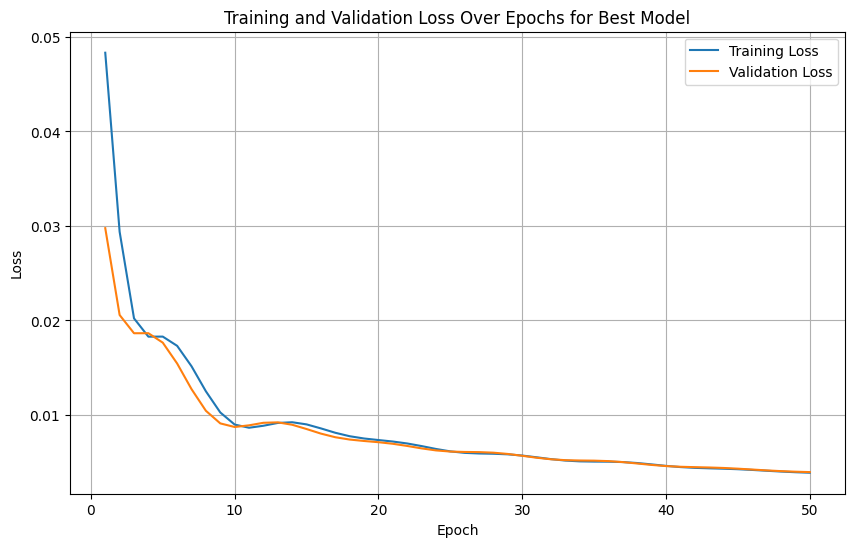

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), all_train_losses[0], label='Training Loss')
plt.plot(range(1, epochs + 1), all_val_losses[0], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs for Best Model')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
training_history = torch.load("/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models/AA_SMALL_best_model_info_CONSIDERATION.pt", weights_only=False)
best_hidden_sizes = training_history["hyperparameters"]["hidden_sizes"]
model = NeuralNetwork(hidden_sizes=best_hidden_sizes)
model.load_state_dict(training_history["model_state_dict"])

model.eval()
with torch.no_grad():
    y_test_pred_tensor = model(X_test_tensor)
    y_test_pred = y_test_pred_tensor.numpy()

# Calculate test metrics
test_mse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Root Mean Squared Error:", test_mse)
print("Test R^2 Score:", test_r2)

Test Root Mean Squared Error: 0.032948708592856535
Test R^2 Score: 0.8770179748535156


## Check with jacobian


In [59]:
def FK(model, theta):
    t = theta.view(1, 2)
    out = model(t)
    out = out.view(2)
    return out

def FK_Jacobian(model, x):
    def forward_kinematics_fn(x):
        return FK(model, x)
    jacobian = torch.autograd.functional.jacobian(forward_kinematics_fn, x)

    return jacobian

def numerical_jacobian(model, theta, epsilon=1):
    theta_np = theta.detach().numpy()
    n = theta_np.size
    y0 = model.predict(theta_np.reshape(1, -1)).flatten()
    m = y0.size
    J = np.zeros((m, n))

    for i in range(n):
        theta_plus = theta_np.copy()
        theta_minus = theta_np.copy()
        theta_plus[i] += epsilon
        theta_minus[i] -= epsilon

        y_plus = model.predict(theta_plus.reshape(1, -1))
        y_minus = model.predict(theta_minus.reshape(1, -1))

        # Differenze finite centrali
        J[:, i] = (y_plus - y_minus).flatten() / (2 * epsilon)
    return J

# Analytical Jacobian
def analytical_jacobian(joint_angles):
    j0, j1 = joint_angles[0], joint_angles[1]
    j0 = j0.item()
    j1 = j1.item()

    # Calculate partial derivatives
    dx_dj0 = -L1 * np.sin(j0) - L2 * np.sin(j0 + j1)
    dx_dj1 = -L2 * np.sin(j0 + j1)
    dy_dj0 = L1 * np.cos(j0) + L2 * np.cos(j0 + j1)
    dy_dj1 = L2 * np.cos(j0 + j1)

    # Construct the Jacobian matrix
    J_analytical = np.array([[dx_dj0, dx_dj1], [dy_dj0, dy_dj1]])
    return J_analytical


In [60]:
# Models trained
Linear_regression_model = lr
Decision_tree_model = best_dt
SVR_model = best_svr
Random_forest_model = best_rf
KNN_model = best_knn

training_history = torch.load("/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models/AA_SMALL_best_model_info_CONSIDERATION.pt", weights_only=False)
best_hidden_sizes = training_history["hyperparameters"]["hidden_sizes"]
NN_model = NeuralNetwork(hidden_sizes=best_hidden_sizes)
NN_model.load_state_dict(training_history["model_state_dict"])

L1 = 0.1  # Length of the first link
L2 = 0.1  # Length of the second link
epsilon=1e-3

# value for test of jacobian 0, -π/2
theta = torch.tensor([0, (np.pi/2)], dtype=torch.float32, requires_grad=True)
theta_other = np.array([0, -np.pi/2], dtype=np.float32)

J_learned_Liner_regression = numerical_jacobian(Linear_regression_model, theta, epsilon)

J_learned_Decision_tree = numerical_jacobian(Decision_tree_model, theta, epsilon)

J_learned_SVR = numerical_jacobian(SVR_model, theta, epsilon)

J_learned_Random_forest = numerical_jacobian(Random_forest_model, theta, epsilon)

J_learned_KNN = numerical_jacobian(KNN_model, theta, epsilon)

J_learned_NN = FK_Jacobian(NN_model, theta)
J_learned_NN_np = J_learned_NN.detach().numpy()

# Analytical Jacobian
J_analytical = analytical_jacobian(theta)

print("-----------------------------------Linear Regression---------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_Liner_regression, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_Liner_regression - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("------------------------------------------------------------------------------------------------")
print(" ")

print("-----------------------------------Decision Tree------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_Decision_tree, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_Decision_tree - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("------------------------------------------------------------------------------------------------")
print(" ")

print("--------------------------------------SVR-------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_SVR, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_SVR - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("------------------------------------------------------------------------------------------")
print(" ")

print("---------------------------------------Random Forest-------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_Random_forest, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_Random_forest - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("----------------------------------------------------------------------------------------------------")
print(" ")
print("--------------------------------------KNN--------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_KNN, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_KNN - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("-------------------------------------------------------------------------------------------")
print(" ")
print("--------------------------------------NN--------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_NN_np, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_NN_np - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("------------------------------------------------------------------------------------------")



-----------------------------------Linear Regression---------------------------------------------
Learned Jacobian:
 [[-0.000 -0.000]
 [0.014 -0.007]]
Analytical Jacobian:
 [[-0.100 -0.100]
 [0.100 -0.000]]
Difference between Learned and Analytical Jacobian:
 [[0.100 0.100]
 [-0.086 -0.007]]
------------------------------------------------------------------------------------------------
 
-----------------------------------Decision Tree------------------------------------------------
Learned Jacobian:
 [[0.000 0.000]
 [0.000 0.000]]
Analytical Jacobian:
 [[-0.100 -0.100]
 [0.100 -0.000]]
Difference between Learned and Analytical Jacobian:
 [[0.100 0.100]
 [-0.100 0.000]]
------------------------------------------------------------------------------------------------
 
--------------------------------------SVR-------------------------------------------------
Learned Jacobian:
 [[-0.090 -0.088]
 [0.115 0.016]]
Analytical Jacobian:
 [[-0.100 -0.100]
 [0.100 -0.000]]
Difference between Lea

### Check with metrics

In [61]:
joint_angles = torch.tensor(X_test[['j0', 'j1']].values, dtype=torch.float32, requires_grad=True)
ground_truth_positions = torch.tensor(y_test[['ft_x', 'ft_y']].values, dtype=torch.float32)

def frobenius_norm(J_learned, J_analytical):
    return np.linalg.norm(J_learned - J_analytical)

# Select 100 samples from dataset
random_indices = np.random.choice(len(joint_angles), size=100, replace=False)
selected_angles = joint_angles[random_indices]

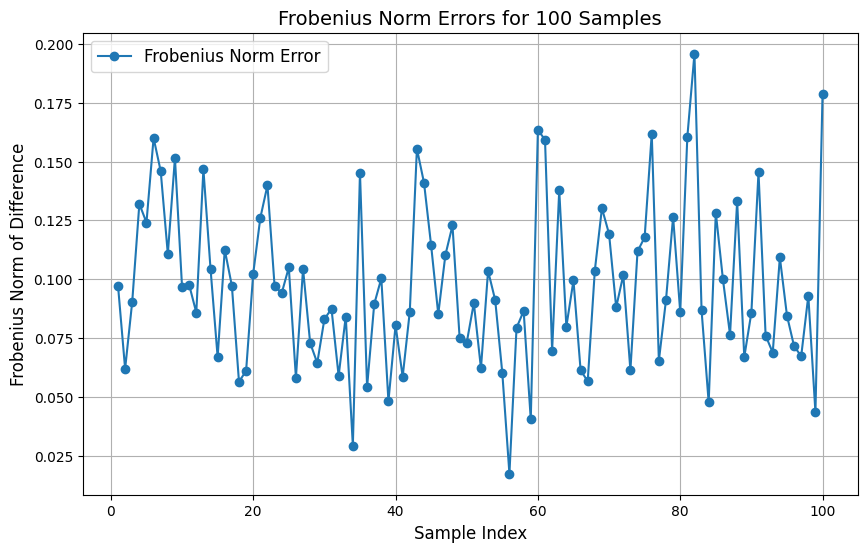

In [62]:
frobenius_errors = []

for theta in selected_angles:
    J_learned = FK_Jacobian(NN_model, theta)
    J_learned_np = J_learned.detach().numpy()

    J_analytical = analytical_jacobian(theta)

    frobenius_diff = frobenius_norm(J_learned_np, J_analytical)

    frobenius_errors.append(frobenius_diff)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(frobenius_errors) + 1), frobenius_errors, marker='o', linestyle='-', label='Frobenius Norm Error')
plt.title('Frobenius Norm Errors for 100 Samples', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Frobenius Norm of Difference', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


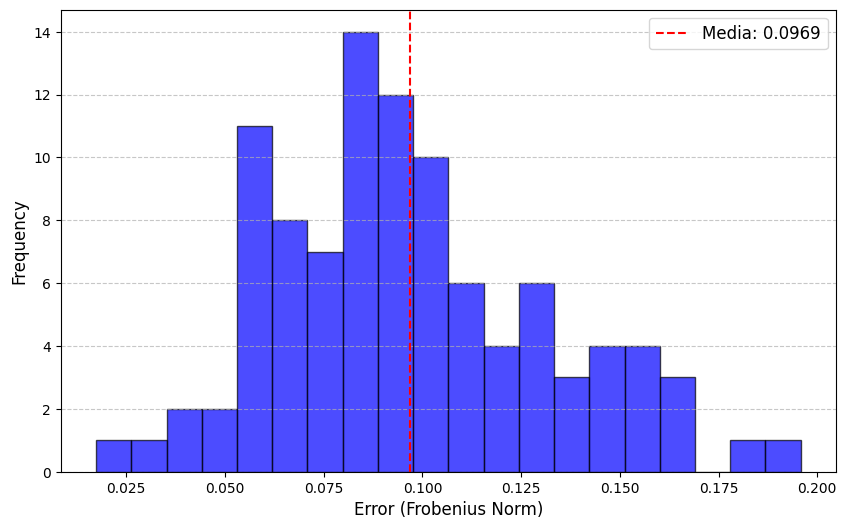

In [63]:
frobenius_errors = []

for theta in selected_angles:
    J_learned = FK_Jacobian(NN_model, theta)
    J_learned_np = J_learned.detach().numpy()

    J_analytical = analytical_jacobian(theta)

    frobenius_diff = frobenius_norm(J_learned_np, J_analytical)

    frobenius_errors.append(frobenius_diff)

plt.figure(figsize=(10, 6))
plt.hist(frobenius_errors, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Error (Frobenius Norm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(np.mean(frobenius_errors), color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {np.mean(frobenius_errors):.4f}')
plt.legend(fontsize=12)
plt.show()

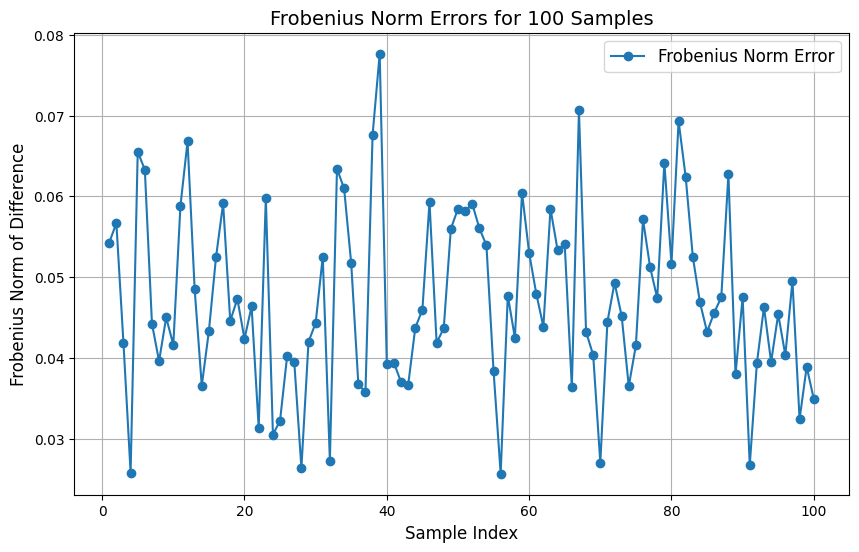

In [64]:
file_path = '/content/drive/MyDrive/Machine_Learning/HW1/dataset/logfile_r2.csv'
data = pd.read_csv(file_path, delimiter=';')
filtered_data = data[['j0', 'j1', 'ft_x', 'ft_y']]

joint_angles = torch.tensor(X_test[['j0', 'j1']].values, dtype=torch.float32, requires_grad=True)
ground_truth_positions = torch.tensor(y_test[['ft_x', 'ft_y']].values, dtype=torch.float32)

def frobenius_norm(J_learned, J_analytical):
    return np.linalg.norm(J_learned - J_analytical)

random_indices = np.random.choice(len(joint_angles), size=100, replace=False)
selected_angles = joint_angles[random_indices]


frobenius_errors = []

for theta in selected_angles:
    J_learned_np = numerical_jacobian(SVR_model, theta)

    J_analytical = analytical_jacobian(theta)

    frobenius_diff = frobenius_norm(J_learned_np, J_analytical)

    frobenius_errors.append(frobenius_diff)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(frobenius_errors) + 1), frobenius_errors, marker='o', linestyle='-', label='Frobenius Norm Error')
plt.title('Frobenius Norm Errors for 100 Samples', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Frobenius Norm of Difference', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


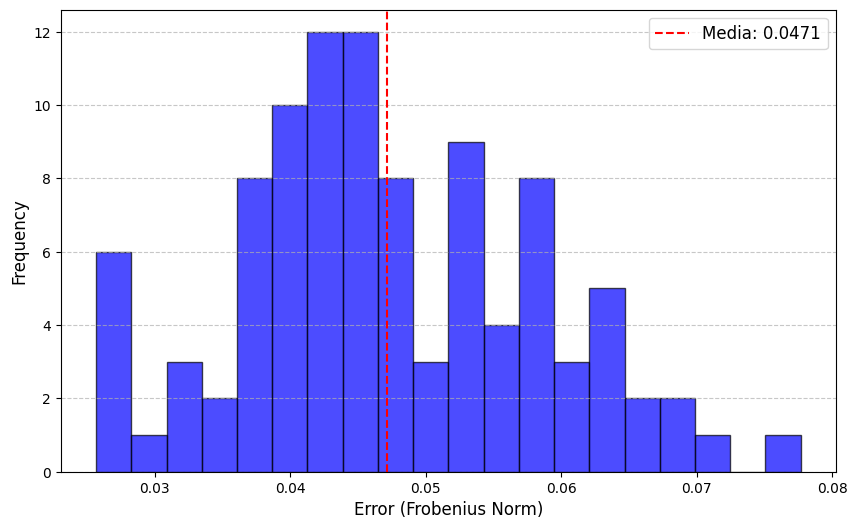

In [65]:
frobenius_errors = []

for theta in selected_angles:
    J_learned_np = numerical_jacobian(SVR_model, theta)

    J_analytical = analytical_jacobian(theta)

    frobenius_diff = frobenius_norm(J_learned_np, J_analytical)

    frobenius_errors.append(frobenius_diff)

plt.figure(figsize=(10, 6))
plt.hist(frobenius_errors, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Error (Frobenius Norm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(np.mean(frobenius_errors), color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {np.mean(frobenius_errors):.4f}')
plt.legend(fontsize=12)
plt.show()

## Inverse Kinematics

In [ ]:
def inverse_kinematics_newton_raphson(model, initial_joints, target_position, max_iters=10000, tolerance=1e-4):
    joints = initial_joints.clone().detach().requires_grad_(True)

    for i in range(max_iters):
        current_position = FK(model, joints)
        error = target_position - current_position
        if torch.norm(error) < tolerance:
            return joints.detach()
        #else:
          #print("MAX ITERS REACHED NEWTON")

        jacobian = FK_Jacobian(model, joints)
        try:
            delta_joints = torch.linalg.solve(jacobian, error)
        except RuntimeError as e:
            print("Errore nell'inversione del Jacobiano:", e)
            return joints.detach()

        joints = joints + delta_joints

    return joints.detach()

def inverse_kinematics_levenberg_marquardt(model, initial_joints, target_position, max_iters=10000, tolerance=1e-4, lambda_=0.05):
    joints = initial_joints.clone().detach().requires_grad_(True)

    for i in range(max_iters):
        current_position = FK(model, joints)
        error = target_position - current_position
        if torch.norm(error) < tolerance:
            return joints.detach()
        #else:
          #print("MAX ITERS REACHED LM")

        jacobian = FK_Jacobian(model, joints)

        # Update of Levenberg-Marquardt: (J^T J + λI) * delta_joints = J^T * error
        A = jacobian.T @ jacobian + lambda_ * torch.eye(jacobian.size(1))
        b = jacobian.T @ error

        try:
            delta_joints = torch.linalg.solve(A, b)
        except RuntimeError as e:
            print("Errore nell'inversione della matrice in Levenberg-Marquardt:", e)
            return joints.detach()

        joints = joints + delta_joints

    return joints.detach()

def compare_methods(model, initial_joints, target_position):
    # Newton-Raphson Method
    print("Newton-Raphson Method:")
    target_joints_nr = inverse_kinematics_newton_raphson(model, initial_joints, target_position)
    nr_error = torch.norm(FK(model, target_joints_nr) - target_position)
    print("Target joints Newton-Raphson:", target_joints_nr)
    print("Newton-Raphson Error:", nr_error.item())


    # Levenberg-Marquardt Method
    print("\nLevenberg-Marquardt Method:")
    target_joints_lm = inverse_kinematics_levenberg_marquardt(model, initial_joints, target_position)
    lm_error = torch.norm(FK(model, target_joints_lm) - target_position)
    print("Target joints Levenberg-Marquardt:", target_joints_lm)
    print("Levenberg-Marquardt Error:", lm_error.item())

    print(" ")
    print("--------------------------------------")
    print("Comparison target:", target_position, "Value computed by Newton-Raphson Method: ", FK(model, target_joints_nr).detach()) #.detach() is used for remove grad_fn=<ViewBackward0> from print
    print("Comparison target:", target_position, "Value computed by Levenberg Marquardt: ", FK(model, target_joints_lm).detach())


In [ ]:
training_history = torch.load("/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models/AA_SMALL_best_model_info_CONSIDERATION.pt", weights_only=False)
best_hidden_sizes = training_history["hyperparameters"]["hidden_sizes"]
model = NeuralNetwork(hidden_sizes=best_hidden_sizes)
model.load_state_dict(training_history["model_state_dict"])
model.eval()

initial_joints = torch.tensor([0.0, np.pi/4], requires_grad=True)
target_position = torch.tensor(y_test.sample(n=1).to_numpy().flatten(), dtype=torch.float32)
print(target_position)

compare_methods(model, initial_joints, target_position)


tensor([ 0.0810, -0.1370])
Newton-Raphson Method:
Target joints Newton-Raphson: tensor([ 0.1641, -8.5710])
Newton-Raphson Error: 9.541398782175747e-08

Levenberg-Marquardt Method:
Target joints Levenberg-Marquardt: tensor([-0.8523,  0.2254])
Levenberg-Marquardt Error: 9.975441207643598e-05
 
--------------------------------------
Comparison target: tensor([ 0.0810, -0.1370]) Value computed by Newton-Raphson Method:  tensor([ 0.0810, -0.1370])
Comparison target: tensor([ 0.0810, -0.1370]) Value computed by Levenberg Marquardt:  tensor([ 0.0809, -0.1369])


In [ ]:
def inverse_kinematics_newton_raphson(model, initial_joints, target_position, max_iters=10000, tolerance=1e-4):
    joints = torch.tensor(initial_joints, dtype=torch.float32)

    for i in range(max_iters):
        current_position = torch.tensor(model.predict(joints.unsqueeze(0).numpy()).flatten(), dtype=torch.float32)
        error = target_position.float() - current_position
        if torch.norm(error) < tolerance:
            return joints

        jacobian = numerical_jacobian(model, joints)
        J = torch.tensor(jacobian, dtype=torch.float32)
        try:
            delta_joints = torch.linalg.solve(J, error)
        except RuntimeError as e:
            print("Errore nell'inversione del Jacobiano:", e)
            return joints

        joints = joints + delta_joints

    return joints


def inverse_kinematics_levenberg_marquardt(model, initial_joints, target_position, max_iters=10000, tolerance=1e-4, lambda_=0.05):
    joints = torch.tensor(initial_joints, dtype=torch.float32)

    for i in range(max_iters):
        current_position = torch.tensor(model.predict(joints.unsqueeze(0).numpy()).flatten(), dtype=torch.float32)
        error = target_position.float() - current_position
        if torch.norm(error) < tolerance:
            return joints

        jacobian = numerical_jacobian(model, joints)
        J = torch.tensor(jacobian, dtype=torch.float32)
        A = J.T @ J + lambda_ * torch.eye(J.shape[1], dtype=torch.float32)
        b = J.T @ error

        try:
            delta_joints = torch.linalg.solve(A, b)
        except RuntimeError as e:
            print("Errore nell'inversione della matrice in Levenberg-Marquardt:", e)
            return joints

        joints = joints + delta_joints

    return joints


def compare_methods(model, initial_joints, target_position, model_name):
    print(f"\n{model_name} Results:")
    print(f"Target Position: {target_position}")

    # Newton-Raphson Method
    print("Newton-Raphson Method:")
    target_joints_nr = inverse_kinematics_newton_raphson(model, initial_joints, target_position)
    nr_error = torch.norm(torch.tensor(model.predict(target_joints_nr.unsqueeze(0).numpy()).flatten()) - target_position)
    print("Target joints Newton-Raphson:", target_joints_nr)
    print("Newton-Raphson Error:", nr_error.item())

    # Levenberg-Marquardt Method
    print("\nLevenberg-Marquardt Method:")
    target_joints_lm = inverse_kinematics_levenberg_marquardt(model, initial_joints, target_position)
    lm_error = torch.norm(torch.tensor(model.predict(target_joints_lm.unsqueeze(0).numpy()).flatten()) - target_position)
    print("Target joints Levenberg-Marquardt:", target_joints_lm)
    print("Levenberg-Marquardt Error:", lm_error.item())

    print("--------------------------------------")
    print("Comparison target:", target_position,
          "Value computed by Newton-Raphson Method: ",
          torch.tensor(model.predict(target_joints_nr.unsqueeze(0).numpy()).flatten()))
    print("Comparison target:", target_position,
          "Value computed by Levenberg-Marquardt Method: ",
          torch.tensor(model.predict(target_joints_lm.unsqueeze(0).numpy()).flatten()))


models = [("SVR", best_svr)]

initial_joints = [0.5, 0.5]
torch.tensor(y_test.sample(n=1).to_numpy().flatten(), dtype=torch.float32)

for model_name, model in models:
    compare_methods(model, initial_joints, target_position, model_name)



SVR Results:
Target Position: tensor([ 0.0810, -0.1370])
Newton-Raphson Method:
Errore nell'inversione del Jacobiano: torch.linalg.solve: The solver failed because the input matrix is singular.
Target joints Newton-Raphson: tensor([-29.7688,  68.1117])
Newton-Raphson Error: 0.16708426146545685

Levenberg-Marquardt Method:
Target joints Levenberg-Marquardt: tensor([-0.3344, -1.2455])
Levenberg-Marquardt Error: 9.592015898752702e-05
--------------------------------------
Comparison target: tensor([ 0.0810, -0.1370]) Value computed by Newton-Raphson Method:  tensor([0.0024, 0.0104], dtype=torch.float64)
Comparison target: tensor([ 0.0810, -0.1370]) Value computed by Levenberg-Marquardt Method:  tensor([ 0.0811, -0.1371], dtype=torch.float64)


# 1K
What we have done so fa is train the 5 model, the first time with 100K samples and second time with 10K sample, now we have the challenge to learn Forward Kinematics and Jacobian with only 1K samples that correspond 0.1% of the all orginal dataset

## Dataset


In [16]:
# Create a Reduced Dataset

df = pd.read_csv("/content/drive/MyDrive/Machine_Learning/HW1/dataset/logfile_r2.csv",sep=';')
df_filtered = df[['j0', 'j1', 'ft_x', 'ft_y']]

# Calculate the number of rows to keep (10% of the original dataset)
n_keep = int(len(df_filtered) * 0.01)

# Randomly sample 10% of the rows
df_reduced_filtered = df_filtered.sample(n=n_keep, random_state=42)

# Reset the index
df_reduced_filtered.reset_index(drop=True, inplace=True)

print(f"Dataset Shape before: {df_filtered.shape}")
print(f"Dataset Shape after: {df_reduced_filtered.shape}")

# Define features (X) and target (Y)
X = df_reduced_filtered[['j0', 'j1']]
y = df_reduced_filtered[['ft_x', 'ft_y']]

# Split into training+validation and test sets (80% training+validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation set into training and validation sets (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Summary of the splits
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Dataset Shape before: (100000, 4)
Dataset Shape after: (1000, 4)
Training set size: 600
Validation set size: 200
Test set size: 200


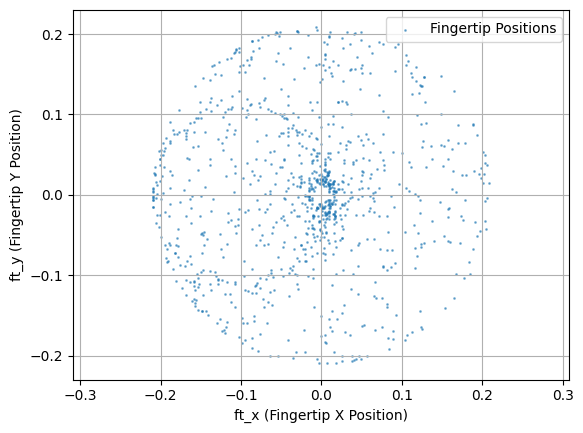

In [ ]:
df_filtered = df[['j0', 'j1', 'ft_x', 'ft_y']]
plt.scatter(df_reduced_filtered['ft_x'], df_reduced_filtered['ft_y'], s=1, alpha=0.5, label='Fingertip Positions')
plt.xlabel('ft_x (Fingertip X Position)')
plt.ylabel('ft_y (Fingertip Y Position)')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Mantieni proporzioni reali per x e y
plt.show()

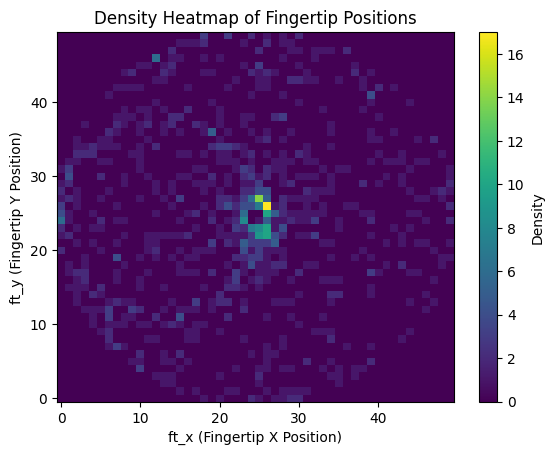

In [77]:
heatmap, xedges, yedges = np.histogram2d(df_reduced_filtered['ft_x'], df_reduced_filtered['ft_y'], bins=50)

plt.imshow(heatmap.T, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Density')
plt.xlabel('ft_x (Fingertip X Position)')
plt.ylabel('ft_y (Fingertip Y Position)')
plt.title('Density Heatmap of Fingertip Positions')
plt.show()

## Model train and test

In [67]:
#-------------------------Linear Regression-------------------------

# train
lr = MultiOutputRegressor(LinearRegression())
lr.fit(X_train, y_train)

# test
warnings.filterwarnings("ignore")
lr_rmse, lr_r2 = evaluate_model(lr, X_test, y_test)
print(f"Linear Regression RMSE: {lr_rmse}, R2: {lr_r2}")
print(" ")
print("--------------------------------------------------------------")
print(" ")

# ----------------------Decision tree regressor-------------------------

# train
dt_param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 20]
}
dt = DecisionTreeRegressor()
dt_grid = GridSearchCV(dt, dt_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
dt_grid.fit(X_train, y_train)

# test
best_dt = dt_grid.best_estimator_
dt_rmse, dt_r2 = evaluate_model(best_dt, X_test, y_test)
print(f"Decision Tree RMSE: {dt_rmse}, R2: {dt_r2}")
print(" ")
print("--------------------------------------------------------------")
print(" ")

# -----------------------------SVR-----------------------------

# train
svr_param_grid = {
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__C': [0.1, 1, 10],
    'estimator__epsilon': [0.01, 0.1, 1],
    'estimator__max_iter': [50]
}
svr = MultiOutputRegressor(SVR())
svr_grid = GridSearchCV(svr, svr_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
svr_grid.fit(X_train, y_train)


# test
best_svr = svr_grid.best_estimator_
svr_rmse, svr_r2 = evaluate_model(best_svr, X_test, y_test)
print(f"SVR Best Params: {svr_grid.best_params_}")
print(f"SVR RMSE: {svr_rmse}, R2: {svr_r2}")
print(" ")
print("--------------------------------------------------------------")
print(" ")

#---------------------------Random Forest--------------------------

# train
rf_param_grid = {
    'estimator__n_estimators': [100, 150],
    'estimator__max_depth': [5, 12]
}
rf = MultiOutputRegressor(RandomForestRegressor(random_state=42))
rf_grid = GridSearchCV(rf, rf_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)


#test
best_rf = rf_grid.best_estimator_
rf_rmse, rf_r2 = evaluate_model(best_rf, X_test, y_test)
print(f"Random Forest Best Params: {rf_grid.best_params_}")
print(f"Random Forest RMSE: {rf_rmse}, R2: {rf_r2}")
print(" ")
print("--------------------------------------------------------------")
print(" ")

#------------------------------------KNN---------------------------------------

# train
knn_param_grid = {
    'estimator__n_neighbors': [3, 5, 10],
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}
knn = MultiOutputRegressor(KNeighborsRegressor())
knn_grid = GridSearchCV(knn, knn_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
knn_grid.fit(X_train, y_train)

#test
best_knn = knn_grid.best_estimator_
knn_rmse, knn_r2 = evaluate_model(best_knn, X_test, y_test)
print(f"KNN Best Params: {knn_grid.best_params_}")
print(f"KNN RMSE: {knn_rmse}, R2: {knn_r2}")
print(" ")
print("--------------------------------------------------------------")
print(" ")

Linear Regression RMSE: 0.09016368790242174, R2: 0.05682310115174616
 
--------------------------------------------------------------
 
Decision Tree RMSE: 0.019989748468777664, R2: 0.9536147167536568
 
--------------------------------------------------------------
 
SVR Best Params: {'estimator__C': 1, 'estimator__epsilon': 0.01, 'estimator__kernel': 'rbf', 'estimator__max_iter': 50}
SVR RMSE: 0.01563148583862524, R2: 0.9715017390674723
 
--------------------------------------------------------------
 
Random Forest Best Params: {'estimator__max_depth': 12, 'estimator__n_estimators': 150}
Random Forest RMSE: 0.013894993971275372, R2: 0.977606161587186
 
--------------------------------------------------------------
 
KNN Best Params: {'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'distance'}
KNN RMSE: 0.008859418726954501, R2: 0.9907349453110943
 
--------------------------------------------------------------
 


In [17]:
# Conversion of data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_sizes):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        input_size = 2  # two input features: j0 and j1
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

        # Output layer
        output_size = 2  # output: ft_x and ft_y
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:  # Apply ReLU to all hidden layers
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'hidden_sizes': [[8, 16, 8], [8, 16, 32, 16, 8], [16, 32, 64, 32, 16]],
    'optimizer': ['Adam', 'SGD', 'RMSprop']
}
grid = ParameterGrid(param_grid)

epochs = 50
best_val_loss = float('inf')
save_path = "/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models"

all_train_losses = []
all_val_losses = []
best_model_info = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "model_state_dict": None,
    "optimizer_state_dict": None,
    "hyperparameters": {}
}

In [ ]:
for params in grid:
    # Initialize model and criterion
    model = NeuralNetwork(hidden_sizes=params['hidden_sizes'])
    criterion = nn.MSELoss()

    # Choose optimizer based on parameter grid
    if params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'])

    # Track losses for each epoch
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in tqdm(range(epochs), desc=f"Training Model with LR={params['learning_rate']}, Layers={params['hidden_sizes']}, Optimizer={params['optimizer']}"):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        train_loss = criterion(outputs, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)

        # Store losses
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Check if this model is the best so far based on validation loss
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_info = {
                "epoch": epoch + 1,
                "train_loss": train_loss.item(),
                "val_loss": val_loss.item(),
                "model_state_dict": model.state_dict(),  # Store the best model weights
                "optimizer_state_dict": optimizer.state_dict(),  # Save the best optimizer state
                "hyperparameters": params  # Save the best hyperparameters for model reconstruction
            }

        # Update tqdm description with current losses
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

    # Save all losses for plotting
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

# Print the best hyperparameters
print("Best Model Parameters:")
print("Learning Rate:", best_model_info['hyperparameters']['learning_rate'])
print("Hidden Layer Sizes:", best_model_info['hyperparameters']['hidden_sizes'])
print("Optimizer:", best_model_info['hyperparameters']['optimizer'])
print("Best Validation Loss:", best_val_loss)

# Save the best model information to a file
torch.save(best_model_info, os.path.join(save_path, "x_SMALL_best_model_info_CONSIDERATION_thechallenge.pt"))

Epoch [1/50], Training Loss: 0.0105, Validation Loss: 0.0089
Epoch [2/50], Training Loss: 0.0083, Validation Loss: 0.0076
Epoch [3/50], Training Loss: 0.0074, Validation Loss: 0.0068
Epoch [4/50], Training Loss: 0.0069, Validation Loss: 0.0060
Epoch [5/50], Training Loss: 0.0064, Validation Loss: 0.0053
Epoch [6/50], Training Loss: 0.0058, Validation Loss: 0.0051
Epoch [7/50], Training Loss: 0.0055, Validation Loss: 0.0051
Epoch [8/50], Training Loss: 0.0054, Validation Loss: 0.0049
Epoch [9/50], Training Loss: 0.0052, Validation Loss: 0.0047


Epoch [10/50], Training Loss: 0.0050, Validation Loss: 0.0044
Epoch [11/50], Training Loss: 0.0047, Validation Loss: 0.0043
Epoch [12/50], Training Loss: 0.0046, Validation Loss: 0.0043
Epoch [13/50], Training Loss: 0.0045, Validation Loss: 0.0044
Epoch [14/50], Training Loss: 0.0045, Validation Loss: 0.0043
Epoch [15/50], Training Loss: 0.0044, Validation Loss: 0.0042


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  48%|████▊     | 24/50 [00:00<00:00, 75.38it/s]

Epoch [16/50], Training Loss: 0.0043, Validation Loss: 0.0041
Epoch [17/50], Training Loss: 0.0042, Validation Loss: 0.0040
Epoch [18/50], Training Loss: 0.0041, Validation Loss: 0.0039
Epoch [19/50], Training Loss: 0.0040, Validation Loss: 0.0037
Epoch [20/50], Training Loss: 0.0039, Validation Loss: 0.0036
Epoch [21/50], Training Loss: 0.0037, Validation Loss: 0.0035
Epoch [22/50], Training Loss: 0.0037, Validation Loss: 0.0034
Epoch [23/50], Training Loss: 0.0036, Validation Loss: 0.0033
Epoch [24/50], Training Loss: 0.0035, Validation Loss: 0.0032
Epoch [25/50], Training Loss: 0.0034, Validation Loss: 0.0033


Epoch [26/50], Training Loss: 0.0034, Validation Loss: 0.0032
Epoch [27/50], Training Loss: 0.0033, Validation Loss: 0.0032
Epoch [28/50], Training Loss: 0.0032, Validation Loss: 0.0032
Epoch [29/50], Training Loss: 0.0032, Validation Loss: 0.0032
Epoch [30/50], Training Loss: 0.0031, Validation Loss: 0.0031


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam:  80%|████████  | 40/50 [00:00<00:00, 75.59it/s]

Epoch [31/50], Training Loss: 0.0031, Validation Loss: 0.0031
Epoch [32/50], Training Loss: 0.0030, Validation Loss: 0.0031
Epoch [33/50], Training Loss: 0.0030, Validation Loss: 0.0031
Epoch [34/50], Training Loss: 0.0030, Validation Loss: 0.0030
Epoch [35/50], Training Loss: 0.0029, Validation Loss: 0.0029
Epoch [36/50], Training Loss: 0.0029, Validation Loss: 0.0029
Epoch [37/50], Training Loss: 0.0029, Validation Loss: 0.0028
Epoch [38/50], Training Loss: 0.0028, Validation Loss: 0.0028
Epoch [39/50], Training Loss: 0.0028, Validation Loss: 0.0028
Epoch [40/50], Training Loss: 0.0028, Validation Loss: 0.0027
Epoch [41/50], Training Loss: 0.0028, Validation Loss: 0.0027


Epoch [42/50], Training Loss: 0.0027, Validation Loss: 0.0027
Epoch [43/50], Training Loss: 0.0027, Validation Loss: 0.0026
Epoch [44/50], Training Loss: 0.0027, Validation Loss: 0.0026
Epoch [45/50], Training Loss: 0.0027, Validation Loss: 0.0026
Epoch [46/50], Training Loss: 0.0026, Validation Loss: 0.0026


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:00<00:00, 75.69it/s]


Epoch [47/50], Training Loss: 0.0026, Validation Loss: 0.0026
Epoch [48/50], Training Loss: 0.0026, Validation Loss: 0.0026
Epoch [49/50], Training Loss: 0.0026, Validation Loss: 0.0026
Epoch [50/50], Training Loss: 0.0025, Validation Loss: 0.0025


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0621, Validation Loss: 0.0636
Epoch [2/50], Training Loss: 0.0608, Validation Loss: 0.0624
Epoch [3/50], Training Loss: 0.0596, Validation Loss: 0.0611
Epoch [4/50], Training Loss: 0.0584, Validation Loss: 0.0599
Epoch [5/50], Training Loss: 0.0573, Validation Loss: 0.0588
Epoch [6/50], Training Loss: 0.0561, Validation Loss: 0.0576
Epoch [7/50], Training Loss: 0.0550, Validation Loss: 0.0565


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:00, 78.72it/s]

Epoch [8/50], Training Loss: 0.0539, Validation Loss: 0.0554
Epoch [9/50], Training Loss: 0.0529, Validation Loss: 0.0543
Epoch [10/50], Training Loss: 0.0518, Validation Loss: 0.0533
Epoch [11/50], Training Loss: 0.0508, Validation Loss: 0.0523
Epoch [12/50], Training Loss: 0.0498, Validation Loss: 0.0513


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  34%|███▍      | 17/50 [00:00<00:00, 79.73it/s]

Epoch [13/50], Training Loss: 0.0489, Validation Loss: 0.0503
Epoch [14/50], Training Loss: 0.0479, Validation Loss: 0.0494
Epoch [15/50], Training Loss: 0.0470, Validation Loss: 0.0484
Epoch [16/50], Training Loss: 0.0461, Validation Loss: 0.0475
Epoch [17/50], Training Loss: 0.0453, Validation Loss: 0.0467


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  34%|███▍      | 17/50 [00:00<00:00, 79.73it/s]

Epoch [18/50], Training Loss: 0.0444, Validation Loss: 0.0458
Epoch [19/50], Training Loss: 0.0436, Validation Loss: 0.0450
Epoch [20/50], Training Loss: 0.0428, Validation Loss: 0.0441
Epoch [21/50], Training Loss: 0.0420, Validation Loss: 0.0433
Epoch [22/50], Training Loss: 0.0412, Validation Loss: 0.0426
Epoch [23/50], Training Loss: 0.0405, Validation Loss: 0.0418
Epoch [24/50], Training Loss: 0.0397, Validation Loss: 0.0410
Epoch [25/50], Training Loss: 0.0390, Validation Loss: 0.0403


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  54%|█████▍    | 27/50 [00:00<00:00, 87.10it/s]

Epoch [26/50], Training Loss: 0.0383, Validation Loss: 0.0396
Epoch [27/50], Training Loss: 0.0376, Validation Loss: 0.0389
Epoch [28/50], Training Loss: 0.0370, Validation Loss: 0.0382
Epoch [29/50], Training Loss: 0.0363, Validation Loss: 0.0376
Epoch [30/50], Training Loss: 0.0357, Validation Loss: 0.0369
Epoch [31/50], Training Loss: 0.0350, Validation Loss: 0.0363
Epoch [32/50], Training Loss: 0.0344, Validation Loss: 0.0356


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  76%|███████▌  | 38/50 [00:00<00:00, 93.81it/s]

Epoch [33/50], Training Loss: 0.0338, Validation Loss: 0.0350
Epoch [34/50], Training Loss: 0.0333, Validation Loss: 0.0344
Epoch [35/50], Training Loss: 0.0327, Validation Loss: 0.0339
Epoch [36/50], Training Loss: 0.0321, Validation Loss: 0.0333
Epoch [37/50], Training Loss: 0.0316, Validation Loss: 0.0327
Epoch [38/50], Training Loss: 0.0311, Validation Loss: 0.0322


Epoch [39/50], Training Loss: 0.0306, Validation Loss: 0.0317
Epoch [40/50], Training Loss: 0.0300, Validation Loss: 0.0312


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD:  76%|███████▌  | 38/50 [00:00<00:00, 93.81it/s]

Epoch [41/50], Training Loss: 0.0296, Validation Loss: 0.0307


Epoch [42/50], Training Loss: 0.0291, Validation Loss: 0.0302
Epoch [43/50], Training Loss: 0.0286, Validation Loss: 0.0297
Epoch [44/50], Training Loss: 0.0281, Validation Loss: 0.0292
Epoch [45/50], Training Loss: 0.0277, Validation Loss: 0.0288
Epoch [46/50], Training Loss: 0.0273, Validation Loss: 0.0283


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 73.27it/s]


Epoch [47/50], Training Loss: 0.0268, Validation Loss: 0.0279
Epoch [48/50], Training Loss: 0.0264, Validation Loss: 0.0274
Epoch [49/50], Training Loss: 0.0260, Validation Loss: 0.0270
Epoch [50/50], Training Loss: 0.0256, Validation Loss: 0.0266


Epoch [1/50], Training Loss: 0.0395, Validation Loss: 0.0486


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], Training Loss: 0.0504, Validation Loss: 0.0732
Epoch [3/50], Training Loss: 0.0736, Validation Loss: 0.0113
Epoch [4/50], Training Loss: 0.0115, Validation Loss: 0.0089
Epoch [5/50], Training Loss: 0.0090, Validation Loss: 0.0081


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:00, 44.06it/s]

Epoch [6/50], Training Loss: 0.0081, Validation Loss: 0.0077
Epoch [7/50], Training Loss: 0.0076, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:00, 44.06it/s]

Epoch [8/50], Training Loss: 0.0072, Validation Loss: 0.0072
Epoch [9/50], Training Loss: 0.0069, Validation Loss: 0.0069
Epoch [10/50], Training Loss: 0.0066, Validation Loss: 0.0065
Epoch [11/50], Training Loss: 0.0061, Validation Loss: 0.0063


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:00, 44.06it/s]

Epoch [12/50], Training Loss: 0.0059, Validation Loss: 0.0061


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  26%|██▌       | 13/50 [00:00<00:00, 55.80it/s]

Epoch [13/50], Training Loss: 0.0057, Validation Loss: 0.0059
Epoch [14/50], Training Loss: 0.0055, Validation Loss: 0.0057
Epoch [15/50], Training Loss: 0.0054, Validation Loss: 0.0056
Epoch [16/50], Training Loss: 0.0052, Validation Loss: 0.0055
Epoch [17/50], Training Loss: 0.0051, Validation Loss: 0.0053
Epoch [18/50], Training Loss: 0.0050, Validation Loss: 0.0052
Epoch [19/50], Training Loss: 0.0048, Validation Loss: 0.0051


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:00<00:00, 61.36it/s]

Epoch [20/50], Training Loss: 0.0047, Validation Loss: 0.0050


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:00<00:00, 61.36it/s]

Epoch [21/50], Training Loss: 0.0046, Validation Loss: 0.0049
Epoch [22/50], Training Loss: 0.0046, Validation Loss: 0.0048
Epoch [23/50], Training Loss: 0.0045, Validation Loss: 0.0049


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  40%|████      | 20/50 [00:00<00:00, 61.36it/s]

Epoch [24/50], Training Loss: 0.0046, Validation Loss: 0.0047


Epoch [25/50], Training Loss: 0.0044, Validation Loss: 0.0047
Epoch [26/50], Training Loss: 0.0044, Validation Loss: 0.0045
Epoch [27/50], Training Loss: 0.0042, Validation Loss: 0.0044
Epoch [28/50], Training Loss: 0.0042, Validation Loss: 0.0044
Epoch [29/50], Training Loss: 0.0041, Validation Loss: 0.0043
Epoch [30/50], Training Loss: 0.0041, Validation Loss: 0.0043


Epoch [31/50], Training Loss: 0.0040, Validation Loss: 0.0042
Epoch [32/50], Training Loss: 0.0040, Validation Loss: 0.0042
Epoch [33/50], Training Loss: 0.0039, Validation Loss: 0.0042


Epoch [34/50], Training Loss: 0.0039, Validation Loss: 0.0041
Epoch [35/50], Training Loss: 0.0038, Validation Loss: 0.0041
Epoch [36/50], Training Loss: 0.0038, Validation Loss: 0.0040


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  68%|██████▊   | 34/50 [00:00<00:00, 59.13it/s]

Epoch [37/50], Training Loss: 0.0037, Validation Loss: 0.0039


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  82%|████████▏ | 41/50 [00:00<00:00, 61.26it/s]

Epoch [38/50], Training Loss: 0.0037, Validation Loss: 0.0039
Epoch [39/50], Training Loss: 0.0036, Validation Loss: 0.0038
Epoch [40/50], Training Loss: 0.0036, Validation Loss: 0.0038
Epoch [41/50], Training Loss: 0.0035, Validation Loss: 0.0037
Epoch [42/50], Training Loss: 0.0035, Validation Loss: 0.0037
Epoch [43/50], Training Loss: 0.0034, Validation Loss: 0.0037
Epoch [44/50], Training Loss: 0.0034, Validation Loss: 0.0037


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop:  82%|████████▏ | 41/50 [00:00<00:00, 61.26it/s]

Epoch [45/50], Training Loss: 0.0034, Validation Loss: 0.0036
Epoch [46/50], Training Loss: 0.0034, Validation Loss: 0.0036
Epoch [47/50], Training Loss: 0.0033, Validation Loss: 0.0035


Training Model with LR=0.01, Layers=[8, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:00<00:00, 59.61it/s]

Epoch [48/50], Training Loss: 0.0033, Validation Loss: 0.0036
Epoch [49/50], Training Loss: 0.0032, Validation Loss: 0.0034
Epoch [50/50], Training Loss: 0.0032, Validation Loss: 0.0035



Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.03it/s]

Epoch [1/50], Training Loss: 0.2475, Validation Loss: 0.2375
Epoch [2/50], Training Loss: 0.2409, Validation Loss: 0.2312
Epoch [3/50], Training Loss: 0.2345, Validation Loss: 0.2250
Epoch [4/50], Training Loss: 0.2282, Validation Loss: 0.2190
Epoch [5/50], Training Loss: 0.2221, Validation Loss: 0.2131
Epoch [6/50], Training Loss: 0.2161, Validation Loss: 0.2074


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.03it/s]

Epoch [7/50], Training Loss: 0.2102, Validation Loss: 0.2017
Epoch [8/50], Training Loss: 0.2045, Validation Loss: 0.1963
Epoch [9/50], Training Loss: 0.1989, Validation Loss: 0.1909


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.03it/s]

Epoch [10/50], Training Loss: 0.1935, Validation Loss: 0.1858
Epoch [11/50], Training Loss: 0.1883, Validation Loss: 0.1808


Epoch [12/50], Training Loss: 0.1832, Validation Loss: 0.1760
Epoch [13/50], Training Loss: 0.1783, Validation Loss: 0.1713
Epoch [14/50], Training Loss: 0.1736, Validation Loss: 0.1668
Epoch [15/50], Training Loss: 0.1690, Validation Loss: 0.1624
Epoch [16/50], Training Loss: 0.1646, Validation Loss: 0.1582
Epoch [17/50], Training Loss: 0.1603, Validation Loss: 0.1541
Epoch [18/50], Training Loss: 0.1561, Validation Loss: 0.1501
Epoch [19/50], Training Loss: 0.1521, Validation Loss: 0.1462


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  38%|███▊      | 19/50 [00:00<00:00, 61.45it/s]

Epoch [20/50], Training Loss: 0.1481, Validation Loss: 0.1424
Epoch [21/50], Training Loss: 0.1443, Validation Loss: 0.1388
Epoch [22/50], Training Loss: 0.1406, Validation Loss: 0.1352


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  38%|███▊      | 19/50 [00:00<00:00, 61.45it/s]

Epoch [23/50], Training Loss: 0.1370, Validation Loss: 0.1318
Epoch [24/50], Training Loss: 0.1335, Validation Loss: 0.1284
Epoch [25/50], Training Loss: 0.1301, Validation Loss: 0.1251


Epoch [26/50], Training Loss: 0.1268, Validation Loss: 0.1219
Epoch [27/50], Training Loss: 0.1236, Validation Loss: 0.1188
Epoch [28/50], Training Loss: 0.1205, Validation Loss: 0.1158
Epoch [29/50], Training Loss: 0.1174, Validation Loss: 0.1128
Epoch [30/50], Training Loss: 0.1145, Validation Loss: 0.1099
Epoch [31/50], Training Loss: 0.1115, Validation Loss: 0.1070


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  66%|██████▌   | 33/50 [00:00<00:00, 58.11it/s]

Epoch [32/50], Training Loss: 0.1087, Validation Loss: 0.1042
Epoch [33/50], Training Loss: 0.1059, Validation Loss: 0.1015
Epoch [34/50], Training Loss: 0.1031, Validation Loss: 0.0989


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  66%|██████▌   | 33/50 [00:00<00:00, 58.11it/s]

Epoch [35/50], Training Loss: 0.1004, Validation Loss: 0.0963
Epoch [36/50], Training Loss: 0.0978, Validation Loss: 0.0937


Epoch [37/50], Training Loss: 0.0952, Validation Loss: 0.0912
Epoch [38/50], Training Loss: 0.0927, Validation Loss: 0.0888
Epoch [39/50], Training Loss: 0.0902, Validation Loss: 0.0863
Epoch [40/50], Training Loss: 0.0878, Validation Loss: 0.0840
Epoch [41/50], Training Loss: 0.0854, Validation Loss: 0.0816
Epoch [42/50], Training Loss: 0.0830, Validation Loss: 0.0793
Epoch [43/50], Training Loss: 0.0807, Validation Loss: 0.0771
Epoch [44/50], Training Loss: 0.0784, Validation Loss: 0.0748


Epoch [45/50], Training Loss: 0.0762, Validation Loss: 0.0726
Epoch [46/50], Training Loss: 0.0739, Validation Loss: 0.0704
Epoch [47/50], Training Loss: 0.0717, Validation Loss: 0.0682


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam:  94%|█████████▍| 47/50 [00:00<00:00, 61.48it/s]

Epoch [48/50], Training Loss: 0.0695, Validation Loss: 0.0660
Epoch [49/50], Training Loss: 0.0674, Validation Loss: 0.0637


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:00<00:00, 58.63it/s]


Epoch [50/50], Training Loss: 0.0652, Validation Loss: 0.0615


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0229, Validation Loss: 0.0198
Epoch [2/50], Training Loss: 0.0228, Validation Loss: 0.0198
Epoch [3/50], Training Loss: 0.0228, Validation Loss: 0.0198
Epoch [4/50], Training Loss: 0.0227, Validation Loss: 0.0197
Epoch [5/50], Training Loss: 0.0227, Validation Loss: 0.0197
Epoch [6/50], Training Loss: 0.0226, Validation Loss: 0.0196


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:00, 72.40it/s]

Epoch [7/50], Training Loss: 0.0226, Validation Loss: 0.0196
Epoch [8/50], Training Loss: 0.0226, Validation Loss: 0.0196
Epoch [9/50], Training Loss: 0.0225, Validation Loss: 0.0195
Epoch [10/50], Training Loss: 0.0225, Validation Loss: 0.0195
Epoch [11/50], Training Loss: 0.0224, Validation Loss: 0.0194


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  16%|█▌        | 8/50 [00:00<00:00, 72.40it/s]

Epoch [12/50], Training Loss: 0.0224, Validation Loss: 0.0194
Epoch [13/50], Training Loss: 0.0223, Validation Loss: 0.0194
Epoch [14/50], Training Loss: 0.0223, Validation Loss: 0.0193
Epoch [15/50], Training Loss: 0.0223, Validation Loss: 0.0193
Epoch [16/50], Training Loss: 0.0222, Validation Loss: 0.0193
Epoch [17/50], Training Loss: 0.0222, Validation Loss: 0.0192


Epoch [18/50], Training Loss: 0.0221, Validation Loss: 0.0192
Epoch [19/50], Training Loss: 0.0221, Validation Loss: 0.0191


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  40%|████      | 20/50 [00:00<00:00, 93.29it/s]

Epoch [20/50], Training Loss: 0.0221, Validation Loss: 0.0191
Epoch [21/50], Training Loss: 0.0220, Validation Loss: 0.0191
Epoch [22/50], Training Loss: 0.0220, Validation Loss: 0.0190
Epoch [23/50], Training Loss: 0.0219, Validation Loss: 0.0190
Epoch [24/50], Training Loss: 0.0219, Validation Loss: 0.0190
Epoch [25/50], Training Loss: 0.0219, Validation Loss: 0.0189
Epoch [26/50], Training Loss: 0.0218, Validation Loss: 0.0189
Epoch [27/50], Training Loss: 0.0218, Validation Loss: 0.0189
Epoch [28/50], Training Loss: 0.0217, Validation Loss: 0.0188


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  64%|██████▍   | 32/50 [00:00<00:00, 103.02it/s]

Epoch [29/50], Training Loss: 0.0217, Validation Loss: 0.0188
Epoch [30/50], Training Loss: 0.0217, Validation Loss: 0.0187
Epoch [31/50], Training Loss: 0.0216, Validation Loss: 0.0187
Epoch [32/50], Training Loss: 0.0216, Validation Loss: 0.0187
Epoch [33/50], Training Loss: 0.0216, Validation Loss: 0.0186
Epoch [34/50], Training Loss: 0.0215, Validation Loss: 0.0186


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  64%|██████▍   | 32/50 [00:00<00:00, 103.02it/s]

Epoch [35/50], Training Loss: 0.0215, Validation Loss: 0.0186
Epoch [36/50], Training Loss: 0.0214, Validation Loss: 0.0185
Epoch [37/50], Training Loss: 0.0214, Validation Loss: 0.0185
Epoch [38/50], Training Loss: 0.0214, Validation Loss: 0.0185
Epoch [39/50], Training Loss: 0.0213, Validation Loss: 0.0184
Epoch [40/50], Training Loss: 0.0213, Validation Loss: 0.0184


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD:  64%|██████▍   | 32/50 [00:00<00:00, 103.02it/s]

Epoch [41/50], Training Loss: 0.0212, Validation Loss: 0.0184
Epoch [42/50], Training Loss: 0.0212, Validation Loss: 0.0183
Epoch [43/50], Training Loss: 0.0212, Validation Loss: 0.0183


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 104.53it/s]


Epoch [44/50], Training Loss: 0.0211, Validation Loss: 0.0183
Epoch [45/50], Training Loss: 0.0211, Validation Loss: 0.0182
Epoch [46/50], Training Loss: 0.0211, Validation Loss: 0.0182
Epoch [47/50], Training Loss: 0.0210, Validation Loss: 0.0182
Epoch [48/50], Training Loss: 0.0210, Validation Loss: 0.0181
Epoch [49/50], Training Loss: 0.0210, Validation Loss: 0.0181
Epoch [50/50], Training Loss: 0.0209, Validation Loss: 0.0181


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0816, Validation Loss: 0.0556


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], Training Loss: 0.0544, Validation Loss: 0.0422
Epoch [3/50], Training Loss: 0.0411, Validation Loss: 0.0327
Epoch [4/50], Training Loss: 0.0317, Validation Loss: 0.0255
Epoch [5/50], Training Loss: 0.0248, Validation Loss: 0.0205
Epoch [6/50], Training Loss: 0.0200, Validation Loss: 0.0170


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:00<00:00, 89.79it/s]

Epoch [7/50], Training Loss: 0.0165, Validation Loss: 0.0144
Epoch [8/50], Training Loss: 0.0140, Validation Loss: 0.0126
Epoch [9/50], Training Loss: 0.0123, Validation Loss: 0.0113
Epoch [10/50], Training Loss: 0.0111, Validation Loss: 0.0104


Epoch [11/50], Training Loss: 0.0103, Validation Loss: 0.0098
Epoch [12/50], Training Loss: 0.0098, Validation Loss: 0.0094


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:00<00:00, 91.79it/s]

Epoch [13/50], Training Loss: 0.0095, Validation Loss: 0.0091
Epoch [14/50], Training Loss: 0.0092, Validation Loss: 0.0089
Epoch [15/50], Training Loss: 0.0090, Validation Loss: 0.0087
Epoch [16/50], Training Loss: 0.0088, Validation Loss: 0.0085
Epoch [17/50], Training Loss: 0.0087, Validation Loss: 0.0084
Epoch [18/50], Training Loss: 0.0085, Validation Loss: 0.0082
Epoch [19/50], Training Loss: 0.0084, Validation Loss: 0.0081


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:00<00:00, 91.79it/s]

Epoch [20/50], Training Loss: 0.0083, Validation Loss: 0.0080


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:00<00:00, 91.79it/s]

Epoch [21/50], Training Loss: 0.0082, Validation Loss: 0.0079
Epoch [22/50], Training Loss: 0.0081, Validation Loss: 0.0078
Epoch [23/50], Training Loss: 0.0081, Validation Loss: 0.0078
Epoch [24/50], Training Loss: 0.0080, Validation Loss: 0.0077
Epoch [25/50], Training Loss: 0.0079, Validation Loss: 0.0076


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  58%|█████▊    | 29/50 [00:00<00:00, 91.48it/s]

Epoch [26/50], Training Loss: 0.0079, Validation Loss: 0.0076
Epoch [27/50], Training Loss: 0.0078, Validation Loss: 0.0075
Epoch [28/50], Training Loss: 0.0078, Validation Loss: 0.0075
Epoch [29/50], Training Loss: 0.0077, Validation Loss: 0.0074


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  58%|█████▊    | 29/50 [00:00<00:00, 91.48it/s]

Epoch [30/50], Training Loss: 0.0076, Validation Loss: 0.0074
Epoch [31/50], Training Loss: 0.0076, Validation Loss: 0.0073
Epoch [32/50], Training Loss: 0.0076, Validation Loss: 0.0073
Epoch [33/50], Training Loss: 0.0075, Validation Loss: 0.0073


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  58%|█████▊    | 29/50 [00:00<00:00, 91.48it/s]

Epoch [34/50], Training Loss: 0.0075, Validation Loss: 0.0072


Epoch [35/50], Training Loss: 0.0074, Validation Loss: 0.0072
Epoch [36/50], Training Loss: 0.0074, Validation Loss: 0.0072


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  58%|█████▊    | 29/50 [00:00<00:00, 91.48it/s]

Epoch [37/50], Training Loss: 0.0073, Validation Loss: 0.0071


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  58%|█████▊    | 29/50 [00:00<00:00, 91.48it/s]

Epoch [38/50], Training Loss: 0.0073, Validation Loss: 0.0071


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop:  78%|███████▊  | 39/50 [00:00<00:00, 49.67it/s]

Epoch [39/50], Training Loss: 0.0073, Validation Loss: 0.0071
Epoch [40/50], Training Loss: 0.0072, Validation Loss: 0.0071
Epoch [41/50], Training Loss: 0.0072, Validation Loss: 0.0070


Training Model with LR=0.001, Layers=[8, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:00<00:00, 60.77it/s]


Epoch [42/50], Training Loss: 0.0072, Validation Loss: 0.0070
Epoch [43/50], Training Loss: 0.0071, Validation Loss: 0.0070
Epoch [44/50], Training Loss: 0.0071, Validation Loss: 0.0069
Epoch [45/50], Training Loss: 0.0071, Validation Loss: 0.0069
Epoch [46/50], Training Loss: 0.0070, Validation Loss: 0.0069
Epoch [47/50], Training Loss: 0.0070, Validation Loss: 0.0069
Epoch [48/50], Training Loss: 0.0070, Validation Loss: 0.0069
Epoch [49/50], Training Loss: 0.0069, Validation Loss: 0.0068
Epoch [50/50], Training Loss: 0.0069, Validation Loss: 0.0068


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0568, Validation Loss: 0.0529


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], Training Loss: 0.0567, Validation Loss: 0.0528
Epoch [3/50], Training Loss: 0.0565, Validation Loss: 0.0526
Epoch [4/50], Training Loss: 0.0564, Validation Loss: 0.0525


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  14%|█▍        | 7/50 [00:00<00:00, 63.31it/s]

Epoch [5/50], Training Loss: 0.0562, Validation Loss: 0.0523
Epoch [6/50], Training Loss: 0.0561, Validation Loss: 0.0522
Epoch [7/50], Training Loss: 0.0559, Validation Loss: 0.0520
Epoch [8/50], Training Loss: 0.0558, Validation Loss: 0.0519
Epoch [9/50], Training Loss: 0.0556, Validation Loss: 0.0518
Epoch [10/50], Training Loss: 0.0555, Validation Loss: 0.0516
Epoch [11/50], Training Loss: 0.0553, Validation Loss: 0.0515
Epoch [12/50], Training Loss: 0.0552, Validation Loss: 0.0513
Epoch [13/50], Training Loss: 0.0550, Validation Loss: 0.0512


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  28%|██▊       | 14/50 [00:00<00:00, 59.29it/s]

Epoch [14/50], Training Loss: 0.0549, Validation Loss: 0.0510
Epoch [15/50], Training Loss: 0.0547, Validation Loss: 0.0509
Epoch [16/50], Training Loss: 0.0546, Validation Loss: 0.0508
Epoch [17/50], Training Loss: 0.0544, Validation Loss: 0.0506


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  42%|████▏     | 21/50 [00:00<00:00, 60.19it/s]

Epoch [18/50], Training Loss: 0.0543, Validation Loss: 0.0505
Epoch [19/50], Training Loss: 0.0542, Validation Loss: 0.0503
Epoch [20/50], Training Loss: 0.0540, Validation Loss: 0.0502
Epoch [21/50], Training Loss: 0.0539, Validation Loss: 0.0500
Epoch [22/50], Training Loss: 0.0537, Validation Loss: 0.0499
Epoch [23/50], Training Loss: 0.0536, Validation Loss: 0.0498
Epoch [24/50], Training Loss: 0.0534, Validation Loss: 0.0496
Epoch [25/50], Training Loss: 0.0533, Validation Loss: 0.0495
Epoch [26/50], Training Loss: 0.0531, Validation Loss: 0.0494


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  56%|█████▌    | 28/50 [00:00<00:00, 61.36it/s]

Epoch [27/50], Training Loss: 0.0530, Validation Loss: 0.0492
Epoch [28/50], Training Loss: 0.0529, Validation Loss: 0.0491
Epoch [29/50], Training Loss: 0.0527, Validation Loss: 0.0489


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  70%|███████   | 35/50 [00:00<00:00, 62.76it/s]

Epoch [30/50], Training Loss: 0.0526, Validation Loss: 0.0488
Epoch [31/50], Training Loss: 0.0524, Validation Loss: 0.0487
Epoch [32/50], Training Loss: 0.0523, Validation Loss: 0.0485
Epoch [33/50], Training Loss: 0.0522, Validation Loss: 0.0484
Epoch [34/50], Training Loss: 0.0520, Validation Loss: 0.0483
Epoch [35/50], Training Loss: 0.0519, Validation Loss: 0.0481
Epoch [36/50], Training Loss: 0.0517, Validation Loss: 0.0480
Epoch [37/50], Training Loss: 0.0516, Validation Loss: 0.0479
Epoch [38/50], Training Loss: 0.0515, Validation Loss: 0.0477
Epoch [39/50], Training Loss: 0.0513, Validation Loss: 0.0476
Epoch [40/50], Training Loss: 0.0512, Validation Loss: 0.0475


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:00<00:00, 63.99it/s]

Epoch [41/50], Training Loss: 0.0511, Validation Loss: 0.0473
Epoch [42/50], Training Loss: 0.0509, Validation Loss: 0.0472
Epoch [43/50], Training Loss: 0.0508, Validation Loss: 0.0471


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:00<00:00, 62.44it/s]


Epoch [44/50], Training Loss: 0.0506, Validation Loss: 0.0469
Epoch [45/50], Training Loss: 0.0505, Validation Loss: 0.0468
Epoch [46/50], Training Loss: 0.0504, Validation Loss: 0.0467
Epoch [47/50], Training Loss: 0.0502, Validation Loss: 0.0466
Epoch [48/50], Training Loss: 0.0501, Validation Loss: 0.0464
Epoch [49/50], Training Loss: 0.0500, Validation Loss: 0.0463
Epoch [50/50], Training Loss: 0.0498, Validation Loss: 0.0462


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.1794, Validation Loss: 0.1930
Epoch [2/50], Training Loss: 0.1793, Validation Loss: 0.1929
Epoch [3/50], Training Loss: 0.1792, Validation Loss: 0.1928


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/50], Training Loss: 0.1791, Validation Loss: 0.1927
Epoch [5/50], Training Loss: 0.1790, Validation Loss: 0.1926
Epoch [6/50], Training Loss: 0.1789, Validation Loss: 0.1925


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  32%|███▏      | 16/50 [00:00<00:00, 76.29it/s]

Epoch [7/50], Training Loss: 0.1788, Validation Loss: 0.1924
Epoch [8/50], Training Loss: 0.1787, Validation Loss: 0.1923
Epoch [9/50], Training Loss: 0.1786, Validation Loss: 0.1922
Epoch [10/50], Training Loss: 0.1785, Validation Loss: 0.1921
Epoch [11/50], Training Loss: 0.1785, Validation Loss: 0.1920
Epoch [12/50], Training Loss: 0.1784, Validation Loss: 0.1919
Epoch [13/50], Training Loss: 0.1783, Validation Loss: 0.1918
Epoch [14/50], Training Loss: 0.1782, Validation Loss: 0.1917
Epoch [15/50], Training Loss: 0.1781, Validation Loss: 0.1916
Epoch [16/50], Training Loss: 0.1780, Validation Loss: 0.1915


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  32%|███▏      | 16/50 [00:00<00:00, 76.29it/s]

Epoch [17/50], Training Loss: 0.1779, Validation Loss: 0.1914
Epoch [18/50], Training Loss: 0.1778, Validation Loss: 0.1913
Epoch [19/50], Training Loss: 0.1777, Validation Loss: 0.1912


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  32%|███▏      | 16/50 [00:00<00:00, 76.29it/s]

Epoch [20/50], Training Loss: 0.1776, Validation Loss: 0.1911
Epoch [21/50], Training Loss: 0.1775, Validation Loss: 0.1910
Epoch [22/50], Training Loss: 0.1774, Validation Loss: 0.1909
Epoch [23/50], Training Loss: 0.1774, Validation Loss: 0.1908


Epoch [24/50], Training Loss: 0.1773, Validation Loss: 0.1907
Epoch [25/50], Training Loss: 0.1772, Validation Loss: 0.1906
Epoch [26/50], Training Loss: 0.1771, Validation Loss: 0.1905
Epoch [27/50], Training Loss: 0.1770, Validation Loss: 0.1904
Epoch [28/50], Training Loss: 0.1769, Validation Loss: 0.1903
Epoch [29/50], Training Loss: 0.1768, Validation Loss: 0.1902
Epoch [30/50], Training Loss: 0.1767, Validation Loss: 0.1901


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  50%|█████     | 25/50 [00:00<00:00, 80.03it/s]

Epoch [31/50], Training Loss: 0.1766, Validation Loss: 0.1900
Epoch [32/50], Training Loss: 0.1765, Validation Loss: 0.1899
Epoch [33/50], Training Loss: 0.1764, Validation Loss: 0.1898


Epoch [34/50], Training Loss: 0.1764, Validation Loss: 0.1897
Epoch [35/50], Training Loss: 0.1763, Validation Loss: 0.1896
Epoch [36/50], Training Loss: 0.1762, Validation Loss: 0.1895


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:00<00:00, 69.73it/s]

Epoch [37/50], Training Loss: 0.1761, Validation Loss: 0.1894
Epoch [38/50], Training Loss: 0.1760, Validation Loss: 0.1893
Epoch [39/50], Training Loss: 0.1759, Validation Loss: 0.1892
Epoch [40/50], Training Loss: 0.1758, Validation Loss: 0.1891
Epoch [41/50], Training Loss: 0.1757, Validation Loss: 0.1890
Epoch [42/50], Training Loss: 0.1756, Validation Loss: 0.1889
Epoch [43/50], Training Loss: 0.1755, Validation Loss: 0.1888
Epoch [44/50], Training Loss: 0.1754, Validation Loss: 0.1887
Epoch [45/50], Training Loss: 0.1754, Validation Loss: 0.1886


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:00<00:00, 69.73it/s]

Epoch [46/50], Training Loss: 0.1753, Validation Loss: 0.1885
Epoch [47/50], Training Loss: 0.1752, Validation Loss: 0.1884
Epoch [48/50], Training Loss: 0.1751, Validation Loss: 0.1883


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 72.49it/s]


Epoch [49/50], Training Loss: 0.1750, Validation Loss: 0.1882
Epoch [50/50], Training Loss: 0.1749, Validation Loss: 0.1881


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0947, Validation Loss: 0.0934


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:00<00:00, 88.49it/s]

Epoch [2/50], Training Loss: 0.0925, Validation Loss: 0.0918
Epoch [3/50], Training Loss: 0.0910, Validation Loss: 0.0905
Epoch [4/50], Training Loss: 0.0897, Validation Loss: 0.0894
Epoch [5/50], Training Loss: 0.0886, Validation Loss: 0.0884
Epoch [6/50], Training Loss: 0.0877, Validation Loss: 0.0875
Epoch [7/50], Training Loss: 0.0868, Validation Loss: 0.0867
Epoch [8/50], Training Loss: 0.0861, Validation Loss: 0.0859
Epoch [9/50], Training Loss: 0.0853, Validation Loss: 0.0852
Epoch [10/50], Training Loss: 0.0846, Validation Loss: 0.0845
Epoch [11/50], Training Loss: 0.0840, Validation Loss: 0.0839


Epoch [12/50], Training Loss: 0.0834, Validation Loss: 0.0833
Epoch [13/50], Training Loss: 0.0828, Validation Loss: 0.0827


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:00<00:00, 88.49it/s]

Epoch [14/50], Training Loss: 0.0822, Validation Loss: 0.0822
Epoch [15/50], Training Loss: 0.0817, Validation Loss: 0.0816
Epoch [16/50], Training Loss: 0.0812, Validation Loss: 0.0811
Epoch [17/50], Training Loss: 0.0807, Validation Loss: 0.0806


Epoch [18/50], Training Loss: 0.0802, Validation Loss: 0.0801
Epoch [19/50], Training Loss: 0.0797, Validation Loss: 0.0796
Epoch [20/50], Training Loss: 0.0793, Validation Loss: 0.0792
Epoch [21/50], Training Loss: 0.0788, Validation Loss: 0.0787
Epoch [22/50], Training Loss: 0.0784, Validation Loss: 0.0783
Epoch [23/50], Training Loss: 0.0780, Validation Loss: 0.0779
Epoch [24/50], Training Loss: 0.0776, Validation Loss: 0.0775
Epoch [25/50], Training Loss: 0.0772, Validation Loss: 0.0771
Epoch [26/50], Training Loss: 0.0768, Validation Loss: 0.0767
Epoch [27/50], Training Loss: 0.0764, Validation Loss: 0.0763


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  52%|█████▏    | 26/50 [00:00<00:00, 77.30it/s]

Epoch [28/50], Training Loss: 0.0760, Validation Loss: 0.0759
Epoch [29/50], Training Loss: 0.0757, Validation Loss: 0.0755
Epoch [30/50], Training Loss: 0.0753, Validation Loss: 0.0752


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  52%|█████▏    | 26/50 [00:00<00:00, 77.30it/s]

Epoch [31/50], Training Loss: 0.0750, Validation Loss: 0.0748
Epoch [32/50], Training Loss: 0.0746, Validation Loss: 0.0745
Epoch [33/50], Training Loss: 0.0743, Validation Loss: 0.0741
Epoch [34/50], Training Loss: 0.0739, Validation Loss: 0.0738


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  70%|███████   | 35/50 [00:00<00:00, 71.28it/s]

Epoch [35/50], Training Loss: 0.0736, Validation Loss: 0.0734
Epoch [36/50], Training Loss: 0.0733, Validation Loss: 0.0731
Epoch [37/50], Training Loss: 0.0730, Validation Loss: 0.0728
Epoch [38/50], Training Loss: 0.0726, Validation Loss: 0.0724
Epoch [39/50], Training Loss: 0.0723, Validation Loss: 0.0721


Epoch [40/50], Training Loss: 0.0720, Validation Loss: 0.0718


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop:  86%|████████▌ | 43/50 [00:00<00:00, 63.70it/s]

Epoch [41/50], Training Loss: 0.0717, Validation Loss: 0.0715
Epoch [42/50], Training Loss: 0.0714, Validation Loss: 0.0712
Epoch [43/50], Training Loss: 0.0711, Validation Loss: 0.0709
Epoch [44/50], Training Loss: 0.0708, Validation Loss: 0.0706
Epoch [45/50], Training Loss: 0.0705, Validation Loss: 0.0703


Training Model with LR=0.0001, Layers=[8, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:00<00:00, 67.69it/s]


Epoch [46/50], Training Loss: 0.0703, Validation Loss: 0.0700
Epoch [47/50], Training Loss: 0.0700, Validation Loss: 0.0697
Epoch [48/50], Training Loss: 0.0697, Validation Loss: 0.0694
Epoch [49/50], Training Loss: 0.0694, Validation Loss: 0.0692
Epoch [50/50], Training Loss: 0.0691, Validation Loss: 0.0689


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0734, Validation Loss: 0.0439


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:01, 33.70it/s]

Epoch [2/50], Training Loss: 0.0450, Validation Loss: 0.0208
Epoch [3/50], Training Loss: 0.0218, Validation Loss: 0.0135
Epoch [4/50], Training Loss: 0.0140, Validation Loss: 0.0232


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:01, 33.70it/s]

Epoch [5/50], Training Loss: 0.0230, Validation Loss: 0.0209
Epoch [6/50], Training Loss: 0.0208, Validation Loss: 0.0134


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:01, 33.70it/s]

Epoch [7/50], Training Loss: 0.0137, Validation Loss: 0.0093


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.45it/s]

Epoch [8/50], Training Loss: 0.0098, Validation Loss: 0.0089
Epoch [9/50], Training Loss: 0.0094, Validation Loss: 0.0100
Epoch [10/50], Training Loss: 0.0105, Validation Loss: 0.0108


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  28%|██▊       | 14/50 [00:00<00:01, 35.21it/s]

Epoch [11/50], Training Loss: 0.0114, Validation Loss: 0.0110
Epoch [12/50], Training Loss: 0.0116, Validation Loss: 0.0104
Epoch [13/50], Training Loss: 0.0110, Validation Loss: 0.0095
Epoch [14/50], Training Loss: 0.0100, Validation Loss: 0.0087
Epoch [15/50], Training Loss: 0.0091, Validation Loss: 0.0083


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  28%|██▊       | 14/50 [00:00<00:01, 35.21it/s]

Epoch [16/50], Training Loss: 0.0086, Validation Loss: 0.0085


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.31it/s]

Epoch [17/50], Training Loss: 0.0087, Validation Loss: 0.0089
Epoch [18/50], Training Loss: 0.0090, Validation Loss: 0.0091
Epoch [19/50], Training Loss: 0.0091, Validation Loss: 0.0089


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.31it/s]

Epoch [20/50], Training Loss: 0.0089, Validation Loss: 0.0084
Epoch [21/50], Training Loss: 0.0084, Validation Loss: 0.0078


Epoch [22/50], Training Loss: 0.0079, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.21it/s]

Epoch [23/50], Training Loss: 0.0076, Validation Loss: 0.0073
Epoch [24/50], Training Loss: 0.0075, Validation Loss: 0.0073
Epoch [25/50], Training Loss: 0.0076, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.42it/s]

Epoch [26/50], Training Loss: 0.0076, Validation Loss: 0.0072
Epoch [27/50], Training Loss: 0.0076, Validation Loss: 0.0072
Epoch [28/50], Training Loss: 0.0075, Validation Loss: 0.0070
Epoch [29/50], Training Loss: 0.0074, Validation Loss: 0.0069
Epoch [30/50], Training Loss: 0.0072, Validation Loss: 0.0067
Epoch [31/50], Training Loss: 0.0070, Validation Loss: 0.0066
Epoch [32/50], Training Loss: 0.0069, Validation Loss: 0.0065
Epoch [33/50], Training Loss: 0.0067, Validation Loss: 0.0064
Epoch [34/50], Training Loss: 0.0066, Validation Loss: 0.0063


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  70%|███████   | 35/50 [00:00<00:00, 44.81it/s]

Epoch [35/50], Training Loss: 0.0065, Validation Loss: 0.0063


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  70%|███████   | 35/50 [00:00<00:00, 44.81it/s]

Epoch [36/50], Training Loss: 0.0064, Validation Loss: 0.0062
Epoch [37/50], Training Loss: 0.0063, Validation Loss: 0.0060
Epoch [38/50], Training Loss: 0.0061, Validation Loss: 0.0059


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  82%|████████▏ | 41/50 [00:01<00:00, 48.05it/s]

Epoch [39/50], Training Loss: 0.0059, Validation Loss: 0.0057
Epoch [40/50], Training Loss: 0.0058, Validation Loss: 0.0056
Epoch [41/50], Training Loss: 0.0056, Validation Loss: 0.0055
Epoch [42/50], Training Loss: 0.0055, Validation Loss: 0.0053
Epoch [43/50], Training Loss: 0.0053, Validation Loss: 0.0052
Epoch [44/50], Training Loss: 0.0052, Validation Loss: 0.0051
Epoch [45/50], Training Loss: 0.0050, Validation Loss: 0.0049
Epoch [46/50], Training Loss: 0.0049, Validation Loss: 0.0048


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  94%|█████████▍| 47/50 [00:01<00:00, 50.68it/s]

Epoch [47/50], Training Loss: 0.0047, Validation Loss: 0.0046


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 42.61it/s]


Epoch [48/50], Training Loss: 0.0046, Validation Loss: 0.0045
Epoch [49/50], Training Loss: 0.0044, Validation Loss: 0.0043
Epoch [50/50], Training Loss: 0.0043, Validation Loss: 0.0041


Epoch [1/50], Training Loss: 0.0214, Validation Loss: 0.0210
Epoch [2/50], Training Loss: 0.0210, Validation Loss: 0.0206
Epoch [3/50], Training Loss: 0.0206, Validation Loss: 0.0202
Epoch [4/50], Training Loss: 0.0202, Validation Loss: 0.0199
Epoch [5/50], Training Loss: 0.0198, Validation Loss: 0.0195
Epoch [6/50], Training Loss: 0.0194, Validation Loss: 0.0191


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  10%|█         | 5/50 [00:00<00:00, 46.78it/s]

Epoch [7/50], Training Loss: 0.0191, Validation Loss: 0.0188
Epoch [8/50], Training Loss: 0.0187, Validation Loss: 0.0185


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:00, 58.60it/s]

Epoch [9/50], Training Loss: 0.0184, Validation Loss: 0.0181
Epoch [10/50], Training Loss: 0.0181, Validation Loss: 0.0178
Epoch [11/50], Training Loss: 0.0178, Validation Loss: 0.0175
Epoch [12/50], Training Loss: 0.0175, Validation Loss: 0.0172


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  38%|███▊      | 19/50 [00:00<00:00, 62.23it/s]

Epoch [13/50], Training Loss: 0.0172, Validation Loss: 0.0170
Epoch [14/50], Training Loss: 0.0169, Validation Loss: 0.0167
Epoch [15/50], Training Loss: 0.0167, Validation Loss: 0.0164
Epoch [16/50], Training Loss: 0.0164, Validation Loss: 0.0162
Epoch [17/50], Training Loss: 0.0161, Validation Loss: 0.0159
Epoch [18/50], Training Loss: 0.0159, Validation Loss: 0.0157
Epoch [19/50], Training Loss: 0.0157, Validation Loss: 0.0155
Epoch [20/50], Training Loss: 0.0154, Validation Loss: 0.0153


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  38%|███▊      | 19/50 [00:00<00:00, 62.23it/s]

Epoch [21/50], Training Loss: 0.0152, Validation Loss: 0.0150
Epoch [22/50], Training Loss: 0.0150, Validation Loss: 0.0148


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  52%|█████▏    | 26/50 [00:00<00:00, 64.57it/s]

Epoch [23/50], Training Loss: 0.0148, Validation Loss: 0.0146
Epoch [24/50], Training Loss: 0.0146, Validation Loss: 0.0144
Epoch [25/50], Training Loss: 0.0144, Validation Loss: 0.0143
Epoch [26/50], Training Loss: 0.0142, Validation Loss: 0.0141


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:00<00:00, 66.30it/s]

Epoch [27/50], Training Loss: 0.0141, Validation Loss: 0.0139
Epoch [28/50], Training Loss: 0.0139, Validation Loss: 0.0138
Epoch [29/50], Training Loss: 0.0137, Validation Loss: 0.0136
Epoch [30/50], Training Loss: 0.0136, Validation Loss: 0.0134
Epoch [31/50], Training Loss: 0.0134, Validation Loss: 0.0133
Epoch [32/50], Training Loss: 0.0133, Validation Loss: 0.0131
Epoch [33/50], Training Loss: 0.0131, Validation Loss: 0.0130
Epoch [34/50], Training Loss: 0.0130, Validation Loss: 0.0129
Epoch [35/50], Training Loss: 0.0128, Validation Loss: 0.0127


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:00<00:00, 66.30it/s]

Epoch [36/50], Training Loss: 0.0127, Validation Loss: 0.0126
Epoch [37/50], Training Loss: 0.0126, Validation Loss: 0.0125


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  80%|████████  | 40/50 [00:00<00:00, 66.46it/s]

Epoch [38/50], Training Loss: 0.0125, Validation Loss: 0.0124
Epoch [39/50], Training Loss: 0.0123, Validation Loss: 0.0123
Epoch [40/50], Training Loss: 0.0122, Validation Loss: 0.0121


Epoch [41/50], Training Loss: 0.0121, Validation Loss: 0.0120
Epoch [42/50], Training Loss: 0.0120, Validation Loss: 0.0119
Epoch [43/50], Training Loss: 0.0119, Validation Loss: 0.0118
Epoch [44/50], Training Loss: 0.0118, Validation Loss: 0.0117
Epoch [45/50], Training Loss: 0.0117, Validation Loss: 0.0116
Epoch [46/50], Training Loss: 0.0116, Validation Loss: 0.0115
Epoch [47/50], Training Loss: 0.0115, Validation Loss: 0.0115
Epoch [48/50], Training Loss: 0.0114, Validation Loss: 0.0114


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 64.05it/s]


Epoch [49/50], Training Loss: 0.0114, Validation Loss: 0.0113
Epoch [50/50], Training Loss: 0.0113, Validation Loss: 0.0112


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0238, Validation Loss: 0.0610


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  10%|█         | 5/50 [00:00<00:01, 44.48it/s]

Epoch [2/50], Training Loss: 0.0547, Validation Loss: 0.0485
Epoch [3/50], Training Loss: 0.0499, Validation Loss: 0.0087
Epoch [4/50], Training Loss: 0.0093, Validation Loss: 0.0086
Epoch [5/50], Training Loss: 0.0091, Validation Loss: 0.0085
Epoch [6/50], Training Loss: 0.0089, Validation Loss: 0.0083
Epoch [7/50], Training Loss: 0.0087, Validation Loss: 0.0083
Epoch [8/50], Training Loss: 0.0085, Validation Loss: 0.0080


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  22%|██▏       | 11/50 [00:00<00:00, 53.01it/s]

Epoch [9/50], Training Loss: 0.0083, Validation Loss: 0.0081
Epoch [10/50], Training Loss: 0.0081, Validation Loss: 0.0078
Epoch [11/50], Training Loss: 0.0081, Validation Loss: 0.0082


Epoch [12/50], Training Loss: 0.0081, Validation Loss: 0.0076
Epoch [13/50], Training Loss: 0.0079, Validation Loss: 0.0077


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  34%|███▍      | 17/50 [00:00<00:00, 52.00it/s]

Epoch [14/50], Training Loss: 0.0076, Validation Loss: 0.0071
Epoch [15/50], Training Loss: 0.0073, Validation Loss: 0.0069
Epoch [16/50], Training Loss: 0.0069, Validation Loss: 0.0066
Epoch [17/50], Training Loss: 0.0068, Validation Loss: 0.0072
Epoch [18/50], Training Loss: 0.0072, Validation Loss: 0.0078


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  34%|███▍      | 17/50 [00:00<00:00, 52.00it/s]

Epoch [19/50], Training Loss: 0.0080, Validation Loss: 0.0066
Epoch [20/50], Training Loss: 0.0065, Validation Loss: 0.0062
Epoch [21/50], Training Loss: 0.0063, Validation Loss: 0.0062


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  34%|███▍      | 17/50 [00:00<00:00, 52.00it/s]

Epoch [22/50], Training Loss: 0.0062, Validation Loss: 0.0063
Epoch [23/50], Training Loss: 0.0063, Validation Loss: 0.0061


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  58%|█████▊    | 29/50 [00:00<00:00, 49.62it/s]

Epoch [24/50], Training Loss: 0.0061, Validation Loss: 0.0066
Epoch [25/50], Training Loss: 0.0066, Validation Loss: 0.0062
Epoch [26/50], Training Loss: 0.0062, Validation Loss: 0.0065
Epoch [27/50], Training Loss: 0.0064, Validation Loss: 0.0060
Epoch [28/50], Training Loss: 0.0059, Validation Loss: 0.0062
Epoch [29/50], Training Loss: 0.0061, Validation Loss: 0.0059


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  58%|█████▊    | 29/50 [00:00<00:00, 49.62it/s]

Epoch [30/50], Training Loss: 0.0059, Validation Loss: 0.0061
Epoch [31/50], Training Loss: 0.0061, Validation Loss: 0.0058
Epoch [32/50], Training Loss: 0.0058, Validation Loss: 0.0060


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  58%|█████▊    | 29/50 [00:00<00:00, 49.62it/s]

Epoch [33/50], Training Loss: 0.0060, Validation Loss: 0.0058
Epoch [34/50], Training Loss: 0.0058, Validation Loss: 0.0064


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  70%|███████   | 35/50 [00:00<00:00, 48.63it/s]

Epoch [35/50], Training Loss: 0.0063, Validation Loss: 0.0058
Epoch [36/50], Training Loss: 0.0058, Validation Loss: 0.0058
Epoch [37/50], Training Loss: 0.0059, Validation Loss: 0.0055
Epoch [38/50], Training Loss: 0.0055, Validation Loss: 0.0057
Epoch [39/50], Training Loss: 0.0056, Validation Loss: 0.0054
Epoch [40/50], Training Loss: 0.0054, Validation Loss: 0.0056


Epoch [41/50], Training Loss: 0.0057, Validation Loss: 0.0053
Epoch [42/50], Training Loss: 0.0054, Validation Loss: 0.0056
Epoch [43/50], Training Loss: 0.0055, Validation Loss: 0.0053


Epoch [44/50], Training Loss: 0.0053, Validation Loss: 0.0056
Epoch [45/50], Training Loss: 0.0056, Validation Loss: 0.0053
Epoch [46/50], Training Loss: 0.0053, Validation Loss: 0.0056


Training Model with LR=0.01, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:00<00:00, 51.85it/s]


Epoch [47/50], Training Loss: 0.0055, Validation Loss: 0.0053
Epoch [48/50], Training Loss: 0.0053, Validation Loss: 0.0060
Epoch [49/50], Training Loss: 0.0061, Validation Loss: 0.0054
Epoch [50/50], Training Loss: 0.0054, Validation Loss: 0.0054


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0612, Validation Loss: 0.0622
Epoch [2/50], Training Loss: 0.0599, Validation Loss: 0.0607


Epoch [3/50], Training Loss: 0.0585, Validation Loss: 0.0591
Epoch [4/50], Training Loss: 0.0570, Validation Loss: 0.0574
Epoch [5/50], Training Loss: 0.0555, Validation Loss: 0.0557


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.37it/s]

Epoch [6/50], Training Loss: 0.0538, Validation Loss: 0.0539
Epoch [7/50], Training Loss: 0.0521, Validation Loss: 0.0521


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.37it/s]

Epoch [8/50], Training Loss: 0.0505, Validation Loss: 0.0504
Epoch [9/50], Training Loss: 0.0489, Validation Loss: 0.0487


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.37it/s]

Epoch [10/50], Training Loss: 0.0473, Validation Loss: 0.0471


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.25it/s]

Epoch [11/50], Training Loss: 0.0457, Validation Loss: 0.0453
Epoch [12/50], Training Loss: 0.0441, Validation Loss: 0.0436


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.25it/s]

Epoch [13/50], Training Loss: 0.0426, Validation Loss: 0.0420


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.25it/s]

Epoch [14/50], Training Loss: 0.0410, Validation Loss: 0.0403
Epoch [15/50], Training Loss: 0.0395, Validation Loss: 0.0387
Epoch [16/50], Training Loss: 0.0381, Validation Loss: 0.0371


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.07it/s]

Epoch [17/50], Training Loss: 0.0366, Validation Loss: 0.0356


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.07it/s]

Epoch [18/50], Training Loss: 0.0351, Validation Loss: 0.0341
Epoch [19/50], Training Loss: 0.0338, Validation Loss: 0.0326
Epoch [20/50], Training Loss: 0.0324, Validation Loss: 0.0313


Epoch [21/50], Training Loss: 0.0311, Validation Loss: 0.0299


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.16it/s]

Epoch [22/50], Training Loss: 0.0298, Validation Loss: 0.0286
Epoch [23/50], Training Loss: 0.0286, Validation Loss: 0.0273
Epoch [24/50], Training Loss: 0.0273, Validation Loss: 0.0260
Epoch [25/50], Training Loss: 0.0261, Validation Loss: 0.0247
Epoch [26/50], Training Loss: 0.0249, Validation Loss: 0.0234


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  54%|█████▍    | 27/50 [00:00<00:00, 41.26it/s]

Epoch [27/50], Training Loss: 0.0238, Validation Loss: 0.0222


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  54%|█████▍    | 27/50 [00:00<00:00, 41.26it/s]

Epoch [28/50], Training Loss: 0.0226, Validation Loss: 0.0210
Epoch [29/50], Training Loss: 0.0215, Validation Loss: 0.0198
Epoch [30/50], Training Loss: 0.0204, Validation Loss: 0.0187


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  64%|██████▍   | 32/50 [00:00<00:00, 42.44it/s]

Epoch [31/50], Training Loss: 0.0194, Validation Loss: 0.0176
Epoch [32/50], Training Loss: 0.0183, Validation Loss: 0.0165


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  64%|██████▍   | 32/50 [00:00<00:00, 42.44it/s]

Epoch [33/50], Training Loss: 0.0173, Validation Loss: 0.0155
Epoch [34/50], Training Loss: 0.0164, Validation Loss: 0.0145
Epoch [35/50], Training Loss: 0.0154, Validation Loss: 0.0136


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  64%|██████▍   | 32/50 [00:00<00:00, 42.44it/s]

Epoch [36/50], Training Loss: 0.0145, Validation Loss: 0.0127


Epoch [37/50], Training Loss: 0.0137, Validation Loss: 0.0119
Epoch [38/50], Training Loss: 0.0130, Validation Loss: 0.0112


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.79it/s]

Epoch [39/50], Training Loss: 0.0123, Validation Loss: 0.0106
Epoch [40/50], Training Loss: 0.0117, Validation Loss: 0.0101


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.09it/s]

Epoch [41/50], Training Loss: 0.0113, Validation Loss: 0.0097
Epoch [42/50], Training Loss: 0.0110, Validation Loss: 0.0094
Epoch [43/50], Training Loss: 0.0107, Validation Loss: 0.0092


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.09it/s]

Epoch [44/50], Training Loss: 0.0106, Validation Loss: 0.0091


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  94%|█████████▍| 47/50 [00:01<00:00, 41.02it/s]

Epoch [45/50], Training Loss: 0.0105, Validation Loss: 0.0090
Epoch [46/50], Training Loss: 0.0104, Validation Loss: 0.0089
Epoch [47/50], Training Loss: 0.0104, Validation Loss: 0.0089


Epoch [48/50], Training Loss: 0.0103, Validation Loss: 0.0088
Epoch [49/50], Training Loss: 0.0103, Validation Loss: 0.0088


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 40.81it/s]


Epoch [50/50], Training Loss: 0.0102, Validation Loss: 0.0087


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0709, Validation Loss: 0.0708
Epoch [2/50], Training Loss: 0.0708, Validation Loss: 0.0706
Epoch [3/50], Training Loss: 0.0706, Validation Loss: 0.0705
Epoch [4/50], Training Loss: 0.0705, Validation Loss: 0.0703


Epoch [5/50], Training Loss: 0.0703, Validation Loss: 0.0702


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  14%|█▍        | 7/50 [00:00<00:00, 61.34it/s]

Epoch [6/50], Training Loss: 0.0702, Validation Loss: 0.0700
Epoch [7/50], Training Loss: 0.0700, Validation Loss: 0.0699
Epoch [8/50], Training Loss: 0.0699, Validation Loss: 0.0697
Epoch [9/50], Training Loss: 0.0697, Validation Loss: 0.0696


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  14%|█▍        | 7/50 [00:00<00:00, 61.34it/s]

Epoch [10/50], Training Loss: 0.0696, Validation Loss: 0.0694
Epoch [11/50], Training Loss: 0.0694, Validation Loss: 0.0693
Epoch [12/50], Training Loss: 0.0693, Validation Loss: 0.0692
Epoch [13/50], Training Loss: 0.0692, Validation Loss: 0.0690
Epoch [14/50], Training Loss: 0.0690, Validation Loss: 0.0689


Epoch [15/50], Training Loss: 0.0689, Validation Loss: 0.0687
Epoch [16/50], Training Loss: 0.0687, Validation Loss: 0.0686
Epoch [17/50], Training Loss: 0.0686, Validation Loss: 0.0684


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  28%|██▊       | 14/50 [00:00<00:00, 64.01it/s]

Epoch [18/50], Training Loss: 0.0684, Validation Loss: 0.0683
Epoch [19/50], Training Loss: 0.0683, Validation Loss: 0.0681


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  42%|████▏     | 21/50 [00:00<00:00, 64.43it/s]

Epoch [20/50], Training Loss: 0.0682, Validation Loss: 0.0680
Epoch [21/50], Training Loss: 0.0680, Validation Loss: 0.0679
Epoch [22/50], Training Loss: 0.0679, Validation Loss: 0.0677


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  42%|████▏     | 21/50 [00:00<00:00, 64.43it/s]

Epoch [23/50], Training Loss: 0.0677, Validation Loss: 0.0676
Epoch [24/50], Training Loss: 0.0676, Validation Loss: 0.0674
Epoch [25/50], Training Loss: 0.0674, Validation Loss: 0.0673
Epoch [26/50], Training Loss: 0.0673, Validation Loss: 0.0672
Epoch [27/50], Training Loss: 0.0672, Validation Loss: 0.0670


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:00<00:00, 61.67it/s]

Epoch [28/50], Training Loss: 0.0670, Validation Loss: 0.0669
Epoch [29/50], Training Loss: 0.0669, Validation Loss: 0.0667
Epoch [30/50], Training Loss: 0.0668, Validation Loss: 0.0666


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:00<00:00, 61.67it/s]

Epoch [31/50], Training Loss: 0.0666, Validation Loss: 0.0665


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  56%|█████▌    | 28/50 [00:00<00:00, 61.67it/s]

Epoch [32/50], Training Loss: 0.0665, Validation Loss: 0.0663
Epoch [33/50], Training Loss: 0.0663, Validation Loss: 0.0662
Epoch [34/50], Training Loss: 0.0662, Validation Loss: 0.0660
Epoch [35/50], Training Loss: 0.0661, Validation Loss: 0.0659


Epoch [36/50], Training Loss: 0.0659, Validation Loss: 0.0658
Epoch [37/50], Training Loss: 0.0658, Validation Loss: 0.0656
Epoch [38/50], Training Loss: 0.0657, Validation Loss: 0.0655
Epoch [39/50], Training Loss: 0.0655, Validation Loss: 0.0654


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:00<00:00, 60.49it/s]

Epoch [40/50], Training Loss: 0.0654, Validation Loss: 0.0652
Epoch [41/50], Training Loss: 0.0652, Validation Loss: 0.0651
Epoch [42/50], Training Loss: 0.0651, Validation Loss: 0.0650
Epoch [43/50], Training Loss: 0.0650, Validation Loss: 0.0648


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  84%|████████▍ | 42/50 [00:00<00:00, 60.49it/s]

Epoch [44/50], Training Loss: 0.0648, Validation Loss: 0.0647


Epoch [45/50], Training Loss: 0.0647, Validation Loss: 0.0646
Epoch [46/50], Training Loss: 0.0646, Validation Loss: 0.0644
Epoch [47/50], Training Loss: 0.0644, Validation Loss: 0.0643
Epoch [48/50], Training Loss: 0.0643, Validation Loss: 0.0642


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 61.83it/s]


Epoch [49/50], Training Loss: 0.0642, Validation Loss: 0.0640
Epoch [50/50], Training Loss: 0.0640, Validation Loss: 0.0639


Epoch [1/50], Training Loss: 0.0416, Validation Loss: 0.0297


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], Training Loss: 0.0302, Validation Loss: 0.0218
Epoch [3/50], Training Loss: 0.0221, Validation Loss: 0.0166
Epoch [4/50], Training Loss: 0.0168, Validation Loss: 0.0135
Epoch [5/50], Training Loss: 0.0135, Validation Loss: 0.0114
Epoch [6/50], Training Loss: 0.0113, Validation Loss: 0.0100


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:00<00:00, 64.32it/s]

Epoch [7/50], Training Loss: 0.0099, Validation Loss: 0.0092


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  14%|█▍        | 7/50 [00:00<00:00, 64.32it/s]

Epoch [8/50], Training Loss: 0.0091, Validation Loss: 0.0087
Epoch [9/50], Training Loss: 0.0087, Validation Loss: 0.0084
Epoch [10/50], Training Loss: 0.0085, Validation Loss: 0.0082


Epoch [11/50], Training Loss: 0.0083, Validation Loss: 0.0080
Epoch [12/50], Training Loss: 0.0082, Validation Loss: 0.0079


Epoch [13/50], Training Loss: 0.0080, Validation Loss: 0.0078


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:00, 58.61it/s]

Epoch [14/50], Training Loss: 0.0079, Validation Loss: 0.0076
Epoch [15/50], Training Loss: 0.0078, Validation Loss: 0.0075
Epoch [16/50], Training Loss: 0.0077, Validation Loss: 0.0074
Epoch [17/50], Training Loss: 0.0076, Validation Loss: 0.0073
Epoch [18/50], Training Loss: 0.0075, Validation Loss: 0.0072


Epoch [19/50], Training Loss: 0.0074, Validation Loss: 0.0071


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  42%|████▏     | 21/50 [00:00<00:00, 61.13it/s]

Epoch [20/50], Training Loss: 0.0073, Validation Loss: 0.0070
Epoch [21/50], Training Loss: 0.0072, Validation Loss: 0.0069
Epoch [22/50], Training Loss: 0.0071, Validation Loss: 0.0068
Epoch [23/50], Training Loss: 0.0070, Validation Loss: 0.0067


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  42%|████▏     | 21/50 [00:00<00:00, 61.13it/s]

Epoch [24/50], Training Loss: 0.0069, Validation Loss: 0.0065
Epoch [25/50], Training Loss: 0.0068, Validation Loss: 0.0065


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  42%|████▏     | 21/50 [00:00<00:00, 61.13it/s]

Epoch [26/50], Training Loss: 0.0066, Validation Loss: 0.0063


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:00<00:00, 59.28it/s]

Epoch [27/50], Training Loss: 0.0065, Validation Loss: 0.0062
Epoch [28/50], Training Loss: 0.0064, Validation Loss: 0.0060
Epoch [29/50], Training Loss: 0.0062, Validation Loss: 0.0059
Epoch [30/50], Training Loss: 0.0060, Validation Loss: 0.0058
Epoch [31/50], Training Loss: 0.0059, Validation Loss: 0.0057


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:00<00:00, 59.28it/s]

Epoch [32/50], Training Loss: 0.0057, Validation Loss: 0.0055


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  70%|███████   | 35/50 [00:00<00:00, 60.03it/s]

Epoch [33/50], Training Loss: 0.0056, Validation Loss: 0.0054
Epoch [34/50], Training Loss: 0.0054, Validation Loss: 0.0052
Epoch [35/50], Training Loss: 0.0053, Validation Loss: 0.0052
Epoch [36/50], Training Loss: 0.0051, Validation Loss: 0.0050


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  70%|███████   | 35/50 [00:00<00:00, 60.03it/s]

Epoch [37/50], Training Loss: 0.0050, Validation Loss: 0.0050
Epoch [38/50], Training Loss: 0.0049, Validation Loss: 0.0048


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  70%|███████   | 35/50 [00:00<00:00, 60.03it/s]

Epoch [39/50], Training Loss: 0.0048, Validation Loss: 0.0048


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  70%|███████   | 35/50 [00:00<00:00, 60.03it/s]

Epoch [40/50], Training Loss: 0.0047, Validation Loss: 0.0047
Epoch [41/50], Training Loss: 0.0046, Validation Loss: 0.0046


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:00<00:00, 52.84it/s]

Epoch [42/50], Training Loss: 0.0045, Validation Loss: 0.0045


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:00<00:00, 52.84it/s]

Epoch [43/50], Training Loss: 0.0044, Validation Loss: 0.0044
Epoch [44/50], Training Loss: 0.0042, Validation Loss: 0.0043
Epoch [45/50], Training Loss: 0.0042, Validation Loss: 0.0042
Epoch [46/50], Training Loss: 0.0041, Validation Loss: 0.0042


Epoch [47/50], Training Loss: 0.0040, Validation Loss: 0.0041


Training Model with LR=0.001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:00<00:00, 56.34it/s]


Epoch [48/50], Training Loss: 0.0039, Validation Loss: 0.0040
Epoch [49/50], Training Loss: 0.0038, Validation Loss: 0.0039
Epoch [50/50], Training Loss: 0.0037, Validation Loss: 0.0039


Epoch [1/50], Training Loss: 0.0222, Validation Loss: 0.0248
Epoch [2/50], Training Loss: 0.0221, Validation Loss: 0.0247
Epoch [3/50], Training Loss: 0.0220, Validation Loss: 0.0246


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/50], Training Loss: 0.0220, Validation Loss: 0.0245


Epoch [5/50], Training Loss: 0.0219, Validation Loss: 0.0244


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:01, 41.10it/s]

Epoch [6/50], Training Loss: 0.0218, Validation Loss: 0.0243


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:01, 41.10it/s]

Epoch [7/50], Training Loss: 0.0217, Validation Loss: 0.0242
Epoch [8/50], Training Loss: 0.0216, Validation Loss: 0.0242


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:01, 41.10it/s]

Epoch [9/50], Training Loss: 0.0216, Validation Loss: 0.0241
Epoch [10/50], Training Loss: 0.0215, Validation Loss: 0.0240
Epoch [11/50], Training Loss: 0.0214, Validation Loss: 0.0239


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  22%|██▏       | 11/50 [00:00<00:00, 42.49it/s]

Epoch [12/50], Training Loss: 0.0213, Validation Loss: 0.0238


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  22%|██▏       | 11/50 [00:00<00:00, 42.49it/s]

Epoch [13/50], Training Loss: 0.0213, Validation Loss: 0.0237
Epoch [14/50], Training Loss: 0.0212, Validation Loss: 0.0236
Epoch [15/50], Training Loss: 0.0211, Validation Loss: 0.0236


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  34%|███▍      | 17/50 [00:00<00:00, 46.53it/s]

Epoch [16/50], Training Loss: 0.0210, Validation Loss: 0.0235
Epoch [17/50], Training Loss: 0.0210, Validation Loss: 0.0234


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  34%|███▍      | 17/50 [00:00<00:00, 46.53it/s]

Epoch [18/50], Training Loss: 0.0209, Validation Loss: 0.0233
Epoch [19/50], Training Loss: 0.0208, Validation Loss: 0.0232


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  34%|███▍      | 17/50 [00:00<00:00, 46.53it/s]

Epoch [20/50], Training Loss: 0.0207, Validation Loss: 0.0232
Epoch [21/50], Training Loss: 0.0207, Validation Loss: 0.0231
Epoch [22/50], Training Loss: 0.0206, Validation Loss: 0.0230
Epoch [23/50], Training Loss: 0.0205, Validation Loss: 0.0229


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  46%|████▌     | 23/50 [00:00<00:00, 50.27it/s]

Epoch [24/50], Training Loss: 0.0204, Validation Loss: 0.0228


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  46%|████▌     | 23/50 [00:00<00:00, 50.27it/s]

Epoch [25/50], Training Loss: 0.0204, Validation Loss: 0.0228
Epoch [26/50], Training Loss: 0.0203, Validation Loss: 0.0227


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  46%|████▌     | 23/50 [00:00<00:00, 50.27it/s]

Epoch [27/50], Training Loss: 0.0202, Validation Loss: 0.0226
Epoch [28/50], Training Loss: 0.0202, Validation Loss: 0.0225


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  58%|█████▊    | 29/50 [00:00<00:00, 49.44it/s]

Epoch [29/50], Training Loss: 0.0201, Validation Loss: 0.0224
Epoch [30/50], Training Loss: 0.0200, Validation Loss: 0.0224


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  58%|█████▊    | 29/50 [00:00<00:00, 49.44it/s]

Epoch [31/50], Training Loss: 0.0200, Validation Loss: 0.0223
Epoch [32/50], Training Loss: 0.0199, Validation Loss: 0.0222
Epoch [33/50], Training Loss: 0.0198, Validation Loss: 0.0221
Epoch [34/50], Training Loss: 0.0198, Validation Loss: 0.0221


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  70%|███████   | 35/50 [00:00<00:00, 51.36it/s]

Epoch [35/50], Training Loss: 0.0197, Validation Loss: 0.0220


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  70%|███████   | 35/50 [00:00<00:00, 51.36it/s]

Epoch [36/50], Training Loss: 0.0196, Validation Loss: 0.0219
Epoch [37/50], Training Loss: 0.0196, Validation Loss: 0.0218
Epoch [38/50], Training Loss: 0.0195, Validation Loss: 0.0218


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  70%|███████   | 35/50 [00:00<00:00, 51.36it/s]

Epoch [39/50], Training Loss: 0.0194, Validation Loss: 0.0217


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  82%|████████▏ | 41/50 [00:00<00:00, 50.15it/s]

Epoch [40/50], Training Loss: 0.0194, Validation Loss: 0.0216
Epoch [41/50], Training Loss: 0.0193, Validation Loss: 0.0216


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  82%|████████▏ | 41/50 [00:00<00:00, 50.15it/s]

Epoch [42/50], Training Loss: 0.0192, Validation Loss: 0.0215
Epoch [43/50], Training Loss: 0.0192, Validation Loss: 0.0214
Epoch [44/50], Training Loss: 0.0191, Validation Loss: 0.0213


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  82%|████████▏ | 41/50 [00:00<00:00, 50.15it/s]

Epoch [45/50], Training Loss: 0.0191, Validation Loss: 0.0213


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  94%|█████████▍| 47/50 [00:00<00:00, 47.04it/s]

Epoch [46/50], Training Loss: 0.0190, Validation Loss: 0.0212
Epoch [47/50], Training Loss: 0.0189, Validation Loss: 0.0211


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam:  94%|█████████▍| 47/50 [00:01<00:00, 47.04it/s]

Epoch [48/50], Training Loss: 0.0189, Validation Loss: 0.0211


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 47.25it/s]


Epoch [49/50], Training Loss: 0.0188, Validation Loss: 0.0210
Epoch [50/50], Training Loss: 0.0187, Validation Loss: 0.0209


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0544, Validation Loss: 0.0582
Epoch [2/50], Training Loss: 0.0543, Validation Loss: 0.0582
Epoch [3/50], Training Loss: 0.0543, Validation Loss: 0.0582


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/50], Training Loss: 0.0543, Validation Loss: 0.0581


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:00, 51.27it/s]

Epoch [5/50], Training Loss: 0.0543, Validation Loss: 0.0581
Epoch [6/50], Training Loss: 0.0543, Validation Loss: 0.0581
Epoch [7/50], Training Loss: 0.0543, Validation Loss: 0.0581


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:00, 51.27it/s]

Epoch [8/50], Training Loss: 0.0543, Validation Loss: 0.0581


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:00, 51.27it/s]

Epoch [9/50], Training Loss: 0.0543, Validation Loss: 0.0581
Epoch [10/50], Training Loss: 0.0543, Validation Loss: 0.0581
Epoch [11/50], Training Loss: 0.0542, Validation Loss: 0.0581


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:00, 51.21it/s]

Epoch [12/50], Training Loss: 0.0542, Validation Loss: 0.0581
Epoch [13/50], Training Loss: 0.0542, Validation Loss: 0.0580
Epoch [14/50], Training Loss: 0.0542, Validation Loss: 0.0580


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:00, 51.21it/s]

Epoch [15/50], Training Loss: 0.0542, Validation Loss: 0.0580


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:00, 51.76it/s]

Epoch [16/50], Training Loss: 0.0542, Validation Loss: 0.0580
Epoch [17/50], Training Loss: 0.0542, Validation Loss: 0.0580
Epoch [18/50], Training Loss: 0.0542, Validation Loss: 0.0580


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:00, 51.76it/s]

Epoch [19/50], Training Loss: 0.0542, Validation Loss: 0.0580


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:00, 51.76it/s]

Epoch [20/50], Training Loss: 0.0541, Validation Loss: 0.0580
Epoch [21/50], Training Loss: 0.0541, Validation Loss: 0.0579
Epoch [22/50], Training Loss: 0.0541, Validation Loss: 0.0579
Epoch [23/50], Training Loss: 0.0541, Validation Loss: 0.0579


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:00, 51.76it/s]

Epoch [24/50], Training Loss: 0.0541, Validation Loss: 0.0579


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  50%|█████     | 25/50 [00:00<00:00, 44.66it/s]

Epoch [25/50], Training Loss: 0.0541, Validation Loss: 0.0579
Epoch [26/50], Training Loss: 0.0541, Validation Loss: 0.0579
Epoch [27/50], Training Loss: 0.0541, Validation Loss: 0.0579


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  50%|█████     | 25/50 [00:00<00:00, 44.66it/s]

Epoch [28/50], Training Loss: 0.0541, Validation Loss: 0.0579


Epoch [29/50], Training Loss: 0.0540, Validation Loss: 0.0579
Epoch [30/50], Training Loss: 0.0540, Validation Loss: 0.0578
Epoch [31/50], Training Loss: 0.0540, Validation Loss: 0.0578
Epoch [32/50], Training Loss: 0.0540, Validation Loss: 0.0578


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  66%|██████▌   | 33/50 [00:00<00:00, 52.28it/s]

Epoch [33/50], Training Loss: 0.0540, Validation Loss: 0.0578
Epoch [34/50], Training Loss: 0.0540, Validation Loss: 0.0578
Epoch [35/50], Training Loss: 0.0540, Validation Loss: 0.0578
Epoch [36/50], Training Loss: 0.0540, Validation Loss: 0.0578
Epoch [37/50], Training Loss: 0.0540, Validation Loss: 0.0578
Epoch [38/50], Training Loss: 0.0539, Validation Loss: 0.0577
Epoch [39/50], Training Loss: 0.0539, Validation Loss: 0.0577


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  82%|████████▏ | 41/50 [00:00<00:00, 58.02it/s]

Epoch [40/50], Training Loss: 0.0539, Validation Loss: 0.0577
Epoch [41/50], Training Loss: 0.0539, Validation Loss: 0.0577
Epoch [42/50], Training Loss: 0.0539, Validation Loss: 0.0577


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  82%|████████▏ | 41/50 [00:00<00:00, 58.02it/s]

Epoch [43/50], Training Loss: 0.0539, Validation Loss: 0.0577


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD:  82%|████████▏ | 41/50 [00:00<00:00, 58.02it/s]

Epoch [44/50], Training Loss: 0.0539, Validation Loss: 0.0577
Epoch [45/50], Training Loss: 0.0539, Validation Loss: 0.0577
Epoch [46/50], Training Loss: 0.0539, Validation Loss: 0.0577
Epoch [47/50], Training Loss: 0.0538, Validation Loss: 0.0576


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 55.69it/s]


Epoch [48/50], Training Loss: 0.0538, Validation Loss: 0.0576
Epoch [49/50], Training Loss: 0.0538, Validation Loss: 0.0576
Epoch [50/50], Training Loss: 0.0538, Validation Loss: 0.0576


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0107, Validation Loss: 0.0097
Epoch [2/50], Training Loss: 0.0104, Validation Loss: 0.0096


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50], Training Loss: 0.0102, Validation Loss: 0.0095
Epoch [4/50], Training Loss: 0.0101, Validation Loss: 0.0094
Epoch [5/50], Training Loss: 0.0100, Validation Loss: 0.0093


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/50], Training Loss: 0.0099, Validation Loss: 0.0092


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:00, 59.87it/s]

Epoch [7/50], Training Loss: 0.0099, Validation Loss: 0.0092
Epoch [8/50], Training Loss: 0.0098, Validation Loss: 0.0091
Epoch [9/50], Training Loss: 0.0097, Validation Loss: 0.0091


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:00, 57.00it/s]

Epoch [10/50], Training Loss: 0.0097, Validation Loss: 0.0091
Epoch [11/50], Training Loss: 0.0096, Validation Loss: 0.0090
Epoch [12/50], Training Loss: 0.0096, Validation Loss: 0.0090


Epoch [13/50], Training Loss: 0.0095, Validation Loss: 0.0090


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:00, 57.00it/s]

Epoch [14/50], Training Loss: 0.0095, Validation Loss: 0.0089
Epoch [15/50], Training Loss: 0.0095, Validation Loss: 0.0089
Epoch [16/50], Training Loss: 0.0094, Validation Loss: 0.0089


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:00, 57.00it/s]

Epoch [17/50], Training Loss: 0.0094, Validation Loss: 0.0088


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  36%|███▌      | 18/50 [00:00<00:00, 53.93it/s]

Epoch [18/50], Training Loss: 0.0094, Validation Loss: 0.0088
Epoch [19/50], Training Loss: 0.0093, Validation Loss: 0.0088
Epoch [20/50], Training Loss: 0.0093, Validation Loss: 0.0088


Epoch [21/50], Training Loss: 0.0093, Validation Loss: 0.0088
Epoch [22/50], Training Loss: 0.0092, Validation Loss: 0.0087
Epoch [23/50], Training Loss: 0.0092, Validation Loss: 0.0087


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:00<00:00, 55.23it/s]

Epoch [24/50], Training Loss: 0.0092, Validation Loss: 0.0087
Epoch [25/50], Training Loss: 0.0092, Validation Loss: 0.0087
Epoch [26/50], Training Loss: 0.0091, Validation Loss: 0.0087


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:00<00:00, 55.23it/s]

Epoch [27/50], Training Loss: 0.0091, Validation Loss: 0.0086
Epoch [28/50], Training Loss: 0.0091, Validation Loss: 0.0086


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:00<00:00, 55.23it/s]

Epoch [29/50], Training Loss: 0.0091, Validation Loss: 0.0086


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  60%|██████    | 30/50 [00:00<00:00, 56.39it/s]

Epoch [30/50], Training Loss: 0.0090, Validation Loss: 0.0086
Epoch [31/50], Training Loss: 0.0090, Validation Loss: 0.0086
Epoch [32/50], Training Loss: 0.0090, Validation Loss: 0.0086


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  72%|███████▏  | 36/50 [00:00<00:00, 56.78it/s]

Epoch [33/50], Training Loss: 0.0090, Validation Loss: 0.0086
Epoch [34/50], Training Loss: 0.0090, Validation Loss: 0.0085
Epoch [35/50], Training Loss: 0.0089, Validation Loss: 0.0085
Epoch [36/50], Training Loss: 0.0089, Validation Loss: 0.0085


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  72%|███████▏  | 36/50 [00:00<00:00, 56.78it/s]

Epoch [37/50], Training Loss: 0.0089, Validation Loss: 0.0085
Epoch [38/50], Training Loss: 0.0089, Validation Loss: 0.0085


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  72%|███████▏  | 36/50 [00:00<00:00, 56.78it/s]

Epoch [39/50], Training Loss: 0.0089, Validation Loss: 0.0085
Epoch [40/50], Training Loss: 0.0089, Validation Loss: 0.0085


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  72%|███████▏  | 36/50 [00:00<00:00, 56.78it/s]

Epoch [41/50], Training Loss: 0.0088, Validation Loss: 0.0085


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:00<00:00, 56.50it/s]

Epoch [42/50], Training Loss: 0.0088, Validation Loss: 0.0084
Epoch [43/50], Training Loss: 0.0088, Validation Loss: 0.0084
Epoch [44/50], Training Loss: 0.0088, Validation Loss: 0.0084


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop:  96%|█████████▌| 48/50 [00:00<00:00, 56.48it/s]

Epoch [45/50], Training Loss: 0.0088, Validation Loss: 0.0084
Epoch [46/50], Training Loss: 0.0088, Validation Loss: 0.0084
Epoch [47/50], Training Loss: 0.0087, Validation Loss: 0.0084
Epoch [48/50], Training Loss: 0.0087, Validation Loss: 0.0084


Training Model with LR=0.0001, Layers=[8, 16, 32, 16, 8], Optimizer=RMSprop: 100%|██████████| 50/50 [00:00<00:00, 56.22it/s]

Epoch [49/50], Training Loss: 0.0087, Validation Loss: 0.0084
Epoch [50/50], Training Loss: 0.0087, Validation Loss: 0.0084



Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0507, Validation Loss: 0.0284


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], Training Loss: 0.0269, Validation Loss: 0.0114


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50], Training Loss: 0.0112, Validation Loss: 0.0215
Epoch [4/50], Training Loss: 0.0208, Validation Loss: 0.0105
Epoch [5/50], Training Loss: 0.0105, Validation Loss: 0.0083


Epoch [6/50], Training Loss: 0.0082, Validation Loss: 0.0094
Epoch [7/50], Training Loss: 0.0091, Validation Loss: 0.0099
Epoch [8/50], Training Loss: 0.0097, Validation Loss: 0.0097


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.10it/s]

Epoch [9/50], Training Loss: 0.0095, Validation Loss: 0.0090
Epoch [10/50], Training Loss: 0.0090, Validation Loss: 0.0081
Epoch [11/50], Training Loss: 0.0082, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.06it/s]

Epoch [12/50], Training Loss: 0.0076, Validation Loss: 0.0069


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.06it/s]

Epoch [13/50], Training Loss: 0.0072, Validation Loss: 0.0068
Epoch [14/50], Training Loss: 0.0071, Validation Loss: 0.0071
Epoch [15/50], Training Loss: 0.0074, Validation Loss: 0.0073


Epoch [16/50], Training Loss: 0.0076, Validation Loss: 0.0071
Epoch [17/50], Training Loss: 0.0074, Validation Loss: 0.0067
Epoch [18/50], Training Loss: 0.0069, Validation Loss: 0.0062
Epoch [19/50], Training Loss: 0.0065, Validation Loss: 0.0061


Epoch [20/50], Training Loss: 0.0064, Validation Loss: 0.0061
Epoch [21/50], Training Loss: 0.0063, Validation Loss: 0.0060


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  36%|███▌      | 18/50 [00:00<00:00, 48.92it/s]

Epoch [22/50], Training Loss: 0.0062, Validation Loss: 0.0058
Epoch [23/50], Training Loss: 0.0060, Validation Loss: 0.0056


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.30it/s]

Epoch [24/50], Training Loss: 0.0057, Validation Loss: 0.0053


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.30it/s]

Epoch [25/50], Training Loss: 0.0054, Validation Loss: 0.0051
Epoch [26/50], Training Loss: 0.0052, Validation Loss: 0.0049


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 50.77it/s]

Epoch [27/50], Training Loss: 0.0051, Validation Loss: 0.0048
Epoch [28/50], Training Loss: 0.0049, Validation Loss: 0.0047
Epoch [29/50], Training Loss: 0.0048, Validation Loss: 0.0044
Epoch [30/50], Training Loss: 0.0046, Validation Loss: 0.0042


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 50.77it/s]

Epoch [31/50], Training Loss: 0.0044, Validation Loss: 0.0040
Epoch [32/50], Training Loss: 0.0042, Validation Loss: 0.0038
Epoch [33/50], Training Loss: 0.0040, Validation Loss: 0.0036


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 50.77it/s]

Epoch [34/50], Training Loss: 0.0038, Validation Loss: 0.0033


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  60%|██████    | 30/50 [00:00<00:00, 50.77it/s]

Epoch [35/50], Training Loss: 0.0036, Validation Loss: 0.0031


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  72%|███████▏  | 36/50 [00:00<00:00, 51.23it/s]

Epoch [36/50], Training Loss: 0.0034, Validation Loss: 0.0029
Epoch [37/50], Training Loss: 0.0032, Validation Loss: 0.0027


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  72%|███████▏  | 36/50 [00:00<00:00, 51.23it/s]

Epoch [38/50], Training Loss: 0.0031, Validation Loss: 0.0026
Epoch [39/50], Training Loss: 0.0029, Validation Loss: 0.0025
Epoch [40/50], Training Loss: 0.0028, Validation Loss: 0.0025
Epoch [41/50], Training Loss: 0.0027, Validation Loss: 0.0023


Epoch [42/50], Training Loss: 0.0026, Validation Loss: 0.0022
Epoch [43/50], Training Loss: 0.0024, Validation Loss: 0.0022


Epoch [44/50], Training Loss: 0.0022, Validation Loss: 0.0021


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.73it/s]

Epoch [45/50], Training Loss: 0.0022, Validation Loss: 0.0021


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.73it/s]

Epoch [46/50], Training Loss: 0.0021, Validation Loss: 0.0020
Epoch [47/50], Training Loss: 0.0021, Validation Loss: 0.0019


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 49.91it/s]


Epoch [48/50], Training Loss: 0.0019, Validation Loss: 0.0018
Epoch [49/50], Training Loss: 0.0018, Validation Loss: 0.0017
Epoch [50/50], Training Loss: 0.0017, Validation Loss: 0.0015


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0508, Validation Loss: 0.0538


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], Training Loss: 0.0494, Validation Loss: 0.0524
Epoch [3/50], Training Loss: 0.0482, Validation Loss: 0.0511
Epoch [4/50], Training Loss: 0.0469, Validation Loss: 0.0498


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/50], Training Loss: 0.0457, Validation Loss: 0.0486


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/50], Training Loss: 0.0446, Validation Loss: 0.0474


Epoch [7/50], Training Loss: 0.0435, Validation Loss: 0.0463
Epoch [8/50], Training Loss: 0.0424, Validation Loss: 0.0451


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  14%|█▍        | 7/50 [00:00<00:00, 62.92it/s]

Epoch [9/50], Training Loss: 0.0413, Validation Loss: 0.0441
Epoch [10/50], Training Loss: 0.0403, Validation Loss: 0.0430
Epoch [11/50], Training Loss: 0.0393, Validation Loss: 0.0420
Epoch [12/50], Training Loss: 0.0384, Validation Loss: 0.0410


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  14%|█▍        | 7/50 [00:00<00:00, 62.92it/s]

Epoch [13/50], Training Loss: 0.0375, Validation Loss: 0.0401


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  28%|██▊       | 14/50 [00:00<00:00, 58.77it/s]

Epoch [14/50], Training Loss: 0.0366, Validation Loss: 0.0391
Epoch [15/50], Training Loss: 0.0357, Validation Loss: 0.0382
Epoch [16/50], Training Loss: 0.0349, Validation Loss: 0.0374


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  28%|██▊       | 14/50 [00:00<00:00, 58.77it/s]

Epoch [17/50], Training Loss: 0.0341, Validation Loss: 0.0365


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  28%|██▊       | 14/50 [00:00<00:00, 58.77it/s]

Epoch [18/50], Training Loss: 0.0333, Validation Loss: 0.0357


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  40%|████      | 20/50 [00:00<00:00, 59.23it/s]

Epoch [19/50], Training Loss: 0.0325, Validation Loss: 0.0349
Epoch [20/50], Training Loss: 0.0318, Validation Loss: 0.0342


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  40%|████      | 20/50 [00:00<00:00, 59.23it/s]

Epoch [21/50], Training Loss: 0.0311, Validation Loss: 0.0334
Epoch [22/50], Training Loss: 0.0304, Validation Loss: 0.0327
Epoch [23/50], Training Loss: 0.0297, Validation Loss: 0.0320
Epoch [24/50], Training Loss: 0.0291, Validation Loss: 0.0314


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  40%|████      | 20/50 [00:00<00:00, 59.23it/s]

Epoch [25/50], Training Loss: 0.0285, Validation Loss: 0.0307


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  52%|█████▏    | 26/50 [00:00<00:00, 58.09it/s]

Epoch [26/50], Training Loss: 0.0279, Validation Loss: 0.0301
Epoch [27/50], Training Loss: 0.0273, Validation Loss: 0.0295
Epoch [28/50], Training Loss: 0.0267, Validation Loss: 0.0289


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  52%|█████▏    | 26/50 [00:00<00:00, 58.09it/s]

Epoch [29/50], Training Loss: 0.0262, Validation Loss: 0.0283


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  52%|█████▏    | 26/50 [00:00<00:00, 58.09it/s]

Epoch [30/50], Training Loss: 0.0256, Validation Loss: 0.0277


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  64%|██████▍   | 32/50 [00:00<00:00, 58.54it/s]

Epoch [31/50], Training Loss: 0.0251, Validation Loss: 0.0272
Epoch [32/50], Training Loss: 0.0246, Validation Loss: 0.0267


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  64%|██████▍   | 32/50 [00:00<00:00, 58.54it/s]

Epoch [33/50], Training Loss: 0.0242, Validation Loss: 0.0262
Epoch [34/50], Training Loss: 0.0237, Validation Loss: 0.0257
Epoch [35/50], Training Loss: 0.0232, Validation Loss: 0.0252
Epoch [36/50], Training Loss: 0.0228, Validation Loss: 0.0247
Epoch [37/50], Training Loss: 0.0224, Validation Loss: 0.0243


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  64%|██████▍   | 32/50 [00:00<00:00, 58.54it/s]

Epoch [38/50], Training Loss: 0.0220, Validation Loss: 0.0238


Epoch [39/50], Training Loss: 0.0216, Validation Loss: 0.0234
Epoch [40/50], Training Loss: 0.0212, Validation Loss: 0.0230


Epoch [41/50], Training Loss: 0.0208, Validation Loss: 0.0226


Epoch [42/50], Training Loss: 0.0205, Validation Loss: 0.0222


Epoch [43/50], Training Loss: 0.0201, Validation Loss: 0.0218
Epoch [44/50], Training Loss: 0.0198, Validation Loss: 0.0215


Epoch [45/50], Training Loss: 0.0194, Validation Loss: 0.0211
Epoch [46/50], Training Loss: 0.0191, Validation Loss: 0.0208
Epoch [47/50], Training Loss: 0.0188, Validation Loss: 0.0204
Epoch [48/50], Training Loss: 0.0185, Validation Loss: 0.0201
Epoch [49/50], Training Loss: 0.0182, Validation Loss: 0.0198


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 59.02it/s]


Epoch [50/50], Training Loss: 0.0179, Validation Loss: 0.0195


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0217, Validation Loss: 145.7531
Epoch [2/50], Training Loss: 135.0430, Validation Loss: 0.0480


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50], Training Loss: 0.0460, Validation Loss: 0.0428


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/50], Training Loss: 0.0366, Validation Loss: 0.0378


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:00, 56.75it/s]

Epoch [5/50], Training Loss: 0.0373, Validation Loss: 0.0176
Epoch [6/50], Training Loss: 0.0179, Validation Loss: 0.0104


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  12%|█▏        | 6/50 [00:00<00:00, 56.75it/s]

Epoch [7/50], Training Loss: 0.0099, Validation Loss: 0.0097
Epoch [8/50], Training Loss: 0.0091, Validation Loss: 0.0095
Epoch [9/50], Training Loss: 0.0089, Validation Loss: 0.0092
Epoch [10/50], Training Loss: 0.0087, Validation Loss: 0.0091


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:00, 56.35it/s]

Epoch [11/50], Training Loss: 0.0085, Validation Loss: 0.0088
Epoch [12/50], Training Loss: 0.0084, Validation Loss: 0.0086


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:00, 56.35it/s]

Epoch [13/50], Training Loss: 0.0083, Validation Loss: 0.0084


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:00, 56.35it/s]

Epoch [14/50], Training Loss: 0.0082, Validation Loss: 0.0083


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  24%|██▍       | 12/50 [00:00<00:00, 56.35it/s]

Epoch [15/50], Training Loss: 0.0080, Validation Loss: 0.0081
Epoch [16/50], Training Loss: 0.0079, Validation Loss: 0.0080


Epoch [17/50], Training Loss: 0.0078, Validation Loss: 0.0078
Epoch [18/50], Training Loss: 0.0077, Validation Loss: 0.0078


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  36%|███▌      | 18/50 [00:00<00:00, 46.80it/s]

Epoch [19/50], Training Loss: 0.0077, Validation Loss: 0.0076
Epoch [20/50], Training Loss: 0.0076, Validation Loss: 0.0076


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  36%|███▌      | 18/50 [00:00<00:00, 46.80it/s]

Epoch [21/50], Training Loss: 0.0075, Validation Loss: 0.0074


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  36%|███▌      | 18/50 [00:00<00:00, 46.80it/s]

Epoch [22/50], Training Loss: 0.0075, Validation Loss: 0.0076


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  46%|████▌     | 23/50 [00:00<00:00, 43.02it/s]

Epoch [23/50], Training Loss: 0.0075, Validation Loss: 0.0075
Epoch [24/50], Training Loss: 0.0076, Validation Loss: 0.0080


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  46%|████▌     | 23/50 [00:00<00:00, 43.02it/s]

Epoch [25/50], Training Loss: 0.0077, Validation Loss: 0.0080
Epoch [26/50], Training Loss: 0.0080, Validation Loss: 0.0085


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:00<00:00, 40.32it/s]

Epoch [27/50], Training Loss: 0.0081, Validation Loss: 0.0086
Epoch [28/50], Training Loss: 0.0085, Validation Loss: 0.0085


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:00<00:00, 40.32it/s]

Epoch [29/50], Training Loss: 0.0082, Validation Loss: 0.0083


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:00<00:00, 40.32it/s]

Epoch [30/50], Training Loss: 0.0082, Validation Loss: 0.0080


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  56%|█████▌    | 28/50 [00:00<00:00, 40.32it/s]

Epoch [31/50], Training Loss: 0.0077, Validation Loss: 0.0077
Epoch [32/50], Training Loss: 0.0077, Validation Loss: 0.0075


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:00<00:00, 39.98it/s]

Epoch [33/50], Training Loss: 0.0073, Validation Loss: 0.0074
Epoch [34/50], Training Loss: 0.0073, Validation Loss: 0.0072


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:00<00:00, 39.98it/s]

Epoch [35/50], Training Loss: 0.0071, Validation Loss: 0.0072
Epoch [36/50], Training Loss: 0.0071, Validation Loss: 0.0071


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:00<00:00, 39.98it/s]

Epoch [37/50], Training Loss: 0.0070, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:00<00:00, 38.84it/s]

Epoch [38/50], Training Loss: 0.0071, Validation Loss: 0.0071


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:00<00:00, 38.84it/s]

Epoch [39/50], Training Loss: 0.0070, Validation Loss: 0.0071
Epoch [40/50], Training Loss: 0.0070, Validation Loss: 0.0070


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:01<00:00, 39.01it/s]

Epoch [41/50], Training Loss: 0.0069, Validation Loss: 0.0071
Epoch [42/50], Training Loss: 0.0069, Validation Loss: 0.0069
Epoch [43/50], Training Loss: 0.0068, Validation Loss: 0.0072


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  84%|████████▍ | 42/50 [00:01<00:00, 39.01it/s]

Epoch [44/50], Training Loss: 0.0070, Validation Loss: 0.0070
Epoch [45/50], Training Loss: 0.0069, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  92%|█████████▏| 46/50 [00:01<00:00, 38.61it/s]

Epoch [46/50], Training Loss: 0.0071, Validation Loss: 0.0070


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  92%|█████████▏| 46/50 [00:01<00:00, 38.61it/s]

Epoch [47/50], Training Loss: 0.0069, Validation Loss: 0.0073


Epoch [48/50], Training Loss: 0.0071, Validation Loss: 0.0070
Epoch [49/50], Training Loss: 0.0068, Validation Loss: 0.0073


Training Model with LR=0.01, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop: 100%|██████████| 50/50 [00:01<00:00, 41.09it/s]


Epoch [50/50], Training Loss: 0.0070, Validation Loss: 0.0069


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0281, Validation Loss: 0.0287
Epoch [2/50], Training Loss: 0.0269, Validation Loss: 0.0274


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50], Training Loss: 0.0258, Validation Loss: 0.0261


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:   8%|▊         | 4/50 [00:00<00:01, 39.35it/s]

Epoch [4/50], Training Loss: 0.0247, Validation Loss: 0.0249
Epoch [5/50], Training Loss: 0.0237, Validation Loss: 0.0238


Epoch [6/50], Training Loss: 0.0227, Validation Loss: 0.0227
Epoch [7/50], Training Loss: 0.0218, Validation Loss: 0.0217


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.87it/s]

Epoch [8/50], Training Loss: 0.0210, Validation Loss: 0.0207
Epoch [9/50], Training Loss: 0.0202, Validation Loss: 0.0198
Epoch [10/50], Training Loss: 0.0194, Validation Loss: 0.0189


Epoch [11/50], Training Loss: 0.0187, Validation Loss: 0.0181


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.22it/s]

Epoch [12/50], Training Loss: 0.0180, Validation Loss: 0.0173
Epoch [13/50], Training Loss: 0.0174, Validation Loss: 0.0166
Epoch [14/50], Training Loss: 0.0167, Validation Loss: 0.0159
Epoch [15/50], Training Loss: 0.0162, Validation Loss: 0.0153
Epoch [16/50], Training Loss: 0.0156, Validation Loss: 0.0147
Epoch [17/50], Training Loss: 0.0151, Validation Loss: 0.0141


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.22it/s]

Epoch [18/50], Training Loss: 0.0146, Validation Loss: 0.0135
Epoch [19/50], Training Loss: 0.0141, Validation Loss: 0.0129


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  40%|████      | 20/50 [00:00<00:00, 48.63it/s]

Epoch [20/50], Training Loss: 0.0135, Validation Loss: 0.0123
Epoch [21/50], Training Loss: 0.0130, Validation Loss: 0.0118
Epoch [22/50], Training Loss: 0.0124, Validation Loss: 0.0112


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  40%|████      | 20/50 [00:00<00:00, 48.63it/s]

Epoch [23/50], Training Loss: 0.0119, Validation Loss: 0.0107


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  52%|█████▏    | 26/50 [00:00<00:00, 51.96it/s]

Epoch [24/50], Training Loss: 0.0113, Validation Loss: 0.0102
Epoch [25/50], Training Loss: 0.0108, Validation Loss: 0.0097
Epoch [26/50], Training Loss: 0.0103, Validation Loss: 0.0093
Epoch [27/50], Training Loss: 0.0098, Validation Loss: 0.0089
Epoch [28/50], Training Loss: 0.0093, Validation Loss: 0.0086
Epoch [29/50], Training Loss: 0.0089, Validation Loss: 0.0083


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  52%|█████▏    | 26/50 [00:00<00:00, 51.96it/s]

Epoch [30/50], Training Loss: 0.0086, Validation Loss: 0.0080
Epoch [31/50], Training Loss: 0.0082, Validation Loss: 0.0078


Epoch [32/50], Training Loss: 0.0080, Validation Loss: 0.0076
Epoch [33/50], Training Loss: 0.0077, Validation Loss: 0.0074


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  64%|██████▍   | 32/50 [00:00<00:00, 51.86it/s]

Epoch [34/50], Training Loss: 0.0075, Validation Loss: 0.0073


Epoch [35/50], Training Loss: 0.0072, Validation Loss: 0.0072
Epoch [36/50], Training Loss: 0.0071, Validation Loss: 0.0071
Epoch [37/50], Training Loss: 0.0069, Validation Loss: 0.0070
Epoch [38/50], Training Loss: 0.0068, Validation Loss: 0.0070
Epoch [39/50], Training Loss: 0.0067, Validation Loss: 0.0069
Epoch [40/50], Training Loss: 0.0066, Validation Loss: 0.0068


Epoch [41/50], Training Loss: 0.0065, Validation Loss: 0.0067
Epoch [42/50], Training Loss: 0.0064, Validation Loss: 0.0066


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  88%|████████▊ | 44/50 [00:00<00:00, 52.31it/s]

Epoch [43/50], Training Loss: 0.0063, Validation Loss: 0.0065
Epoch [44/50], Training Loss: 0.0062, Validation Loss: 0.0063


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  88%|████████▊ | 44/50 [00:00<00:00, 52.31it/s]

Epoch [45/50], Training Loss: 0.0061, Validation Loss: 0.0062


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 49.59it/s]


Epoch [46/50], Training Loss: 0.0060, Validation Loss: 0.0061
Epoch [47/50], Training Loss: 0.0059, Validation Loss: 0.0059
Epoch [48/50], Training Loss: 0.0058, Validation Loss: 0.0058
Epoch [49/50], Training Loss: 0.0057, Validation Loss: 0.0057
Epoch [50/50], Training Loss: 0.0056, Validation Loss: 0.0056


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0659, Validation Loss: 0.0712
Epoch [2/50], Training Loss: 0.0657, Validation Loss: 0.0710


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50], Training Loss: 0.0655, Validation Loss: 0.0708
Epoch [4/50], Training Loss: 0.0653, Validation Loss: 0.0706
Epoch [5/50], Training Loss: 0.0651, Validation Loss: 0.0705


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:00, 54.86it/s]

Epoch [6/50], Training Loss: 0.0649, Validation Loss: 0.0703


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  12%|█▏        | 6/50 [00:00<00:00, 54.86it/s]

Epoch [7/50], Training Loss: 0.0647, Validation Loss: 0.0701
Epoch [8/50], Training Loss: 0.0645, Validation Loss: 0.0699
Epoch [9/50], Training Loss: 0.0644, Validation Loss: 0.0697
Epoch [10/50], Training Loss: 0.0642, Validation Loss: 0.0695
Epoch [11/50], Training Loss: 0.0640, Validation Loss: 0.0693


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:00, 50.67it/s]

Epoch [12/50], Training Loss: 0.0638, Validation Loss: 0.0691
Epoch [13/50], Training Loss: 0.0636, Validation Loss: 0.0689


Epoch [14/50], Training Loss: 0.0634, Validation Loss: 0.0687
Epoch [15/50], Training Loss: 0.0633, Validation Loss: 0.0685


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  24%|██▍       | 12/50 [00:00<00:00, 50.67it/s]

Epoch [16/50], Training Loss: 0.0631, Validation Loss: 0.0683


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  36%|███▌      | 18/50 [00:00<00:00, 50.03it/s]

Epoch [17/50], Training Loss: 0.0629, Validation Loss: 0.0681
Epoch [18/50], Training Loss: 0.0627, Validation Loss: 0.0680
Epoch [19/50], Training Loss: 0.0625, Validation Loss: 0.0678
Epoch [20/50], Training Loss: 0.0624, Validation Loss: 0.0676
Epoch [21/50], Training Loss: 0.0622, Validation Loss: 0.0674
Epoch [22/50], Training Loss: 0.0620, Validation Loss: 0.0672
Epoch [23/50], Training Loss: 0.0618, Validation Loss: 0.0670


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  48%|████▊     | 24/50 [00:00<00:00, 48.49it/s]

Epoch [24/50], Training Loss: 0.0617, Validation Loss: 0.0668
Epoch [25/50], Training Loss: 0.0615, Validation Loss: 0.0667


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  48%|████▊     | 24/50 [00:00<00:00, 48.49it/s]

Epoch [26/50], Training Loss: 0.0613, Validation Loss: 0.0665


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  58%|█████▊    | 29/50 [00:00<00:00, 47.77it/s]

Epoch [27/50], Training Loss: 0.0611, Validation Loss: 0.0663
Epoch [28/50], Training Loss: 0.0610, Validation Loss: 0.0661
Epoch [29/50], Training Loss: 0.0608, Validation Loss: 0.0659
Epoch [30/50], Training Loss: 0.0606, Validation Loss: 0.0657
Epoch [31/50], Training Loss: 0.0605, Validation Loss: 0.0656
Epoch [32/50], Training Loss: 0.0603, Validation Loss: 0.0654
Epoch [33/50], Training Loss: 0.0601, Validation Loss: 0.0652
Epoch [34/50], Training Loss: 0.0599, Validation Loss: 0.0650


Epoch [35/50], Training Loss: 0.0598, Validation Loss: 0.0648


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  70%|███████   | 35/50 [00:00<00:00, 48.99it/s]

Epoch [36/50], Training Loss: 0.0596, Validation Loss: 0.0647
Epoch [37/50], Training Loss: 0.0594, Validation Loss: 0.0645


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  80%|████████  | 40/50 [00:00<00:00, 48.50it/s]

Epoch [38/50], Training Loss: 0.0593, Validation Loss: 0.0643
Epoch [39/50], Training Loss: 0.0591, Validation Loss: 0.0641
Epoch [40/50], Training Loss: 0.0589, Validation Loss: 0.0640
Epoch [41/50], Training Loss: 0.0588, Validation Loss: 0.0638
Epoch [42/50], Training Loss: 0.0586, Validation Loss: 0.0636
Epoch [43/50], Training Loss: 0.0584, Validation Loss: 0.0634
Epoch [44/50], Training Loss: 0.0583, Validation Loss: 0.0633
Epoch [45/50], Training Loss: 0.0581, Validation Loss: 0.0631


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  92%|█████████▏| 46/50 [00:00<00:00, 49.89it/s]

Epoch [46/50], Training Loss: 0.0580, Validation Loss: 0.0629
Epoch [47/50], Training Loss: 0.0578, Validation Loss: 0.0627


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD: 100%|██████████| 50/50 [00:01<00:00, 48.74it/s]


Epoch [48/50], Training Loss: 0.0576, Validation Loss: 0.0626
Epoch [49/50], Training Loss: 0.0575, Validation Loss: 0.0624
Epoch [50/50], Training Loss: 0.0573, Validation Loss: 0.0622


Epoch [1/50], Training Loss: 0.0604, Validation Loss: 0.0260
Epoch [2/50], Training Loss: 0.0298, Validation Loss: 0.0154
Epoch [3/50], Training Loss: 0.0183, Validation Loss: 0.0100


Epoch [4/50], Training Loss: 0.0120, Validation Loss: 0.0083
Epoch [5/50], Training Loss: 0.0097, Validation Loss: 0.0077


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:00<00:00, 41.76it/s]

Epoch [6/50], Training Loss: 0.0087, Validation Loss: 0.0087
Epoch [7/50], Training Loss: 0.0092, Validation Loss: 0.0088
Epoch [8/50], Training Loss: 0.0098, Validation Loss: 0.0080
Epoch [9/50], Training Loss: 0.0084, Validation Loss: 0.0072


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  18%|█▊        | 9/50 [00:00<00:00, 41.76it/s]

Epoch [10/50], Training Loss: 0.0078, Validation Loss: 0.0070
Epoch [11/50], Training Loss: 0.0074, Validation Loss: 0.0068
Epoch [12/50], Training Loss: 0.0071, Validation Loss: 0.0067


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  28%|██▊       | 14/50 [00:00<00:00, 45.17it/s]

Epoch [13/50], Training Loss: 0.0070, Validation Loss: 0.0066
Epoch [14/50], Training Loss: 0.0068, Validation Loss: 0.0065
Epoch [15/50], Training Loss: 0.0066, Validation Loss: 0.0064


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:00<00:00, 44.64it/s]

Epoch [16/50], Training Loss: 0.0065, Validation Loss: 0.0063
Epoch [17/50], Training Loss: 0.0064, Validation Loss: 0.0062
Epoch [18/50], Training Loss: 0.0063, Validation Loss: 0.0062
Epoch [19/50], Training Loss: 0.0062, Validation Loss: 0.0061


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  38%|███▊      | 19/50 [00:00<00:00, 44.64it/s]

Epoch [20/50], Training Loss: 0.0062, Validation Loss: 0.0064
Epoch [21/50], Training Loss: 0.0063, Validation Loss: 0.0066
Epoch [22/50], Training Loss: 0.0067, Validation Loss: 0.0062


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:00<00:00, 44.50it/s]

Epoch [23/50], Training Loss: 0.0062, Validation Loss: 0.0060
Epoch [24/50], Training Loss: 0.0061, Validation Loss: 0.0058
Epoch [25/50], Training Loss: 0.0057, Validation Loss: 0.0056


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  48%|████▊     | 24/50 [00:00<00:00, 44.50it/s]

Epoch [26/50], Training Loss: 0.0056, Validation Loss: 0.0055
Epoch [27/50], Training Loss: 0.0054, Validation Loss: 0.0054
Epoch [28/50], Training Loss: 0.0053, Validation Loss: 0.0053


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  58%|█████▊    | 29/50 [00:00<00:00, 42.79it/s]

Epoch [29/50], Training Loss: 0.0052, Validation Loss: 0.0052
Epoch [30/50], Training Loss: 0.0051, Validation Loss: 0.0051
Epoch [31/50], Training Loss: 0.0050, Validation Loss: 0.0051


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  68%|██████▊   | 34/50 [00:00<00:00, 43.00it/s]

Epoch [32/50], Training Loss: 0.0050, Validation Loss: 0.0051
Epoch [33/50], Training Loss: 0.0049, Validation Loss: 0.0051
Epoch [34/50], Training Loss: 0.0050, Validation Loss: 0.0049


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  68%|██████▊   | 34/50 [00:00<00:00, 43.00it/s]

Epoch [35/50], Training Loss: 0.0048, Validation Loss: 0.0049
Epoch [36/50], Training Loss: 0.0048, Validation Loss: 0.0047
Epoch [37/50], Training Loss: 0.0045, Validation Loss: 0.0046


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  78%|███████▊  | 39/50 [00:00<00:00, 42.76it/s]

Epoch [38/50], Training Loss: 0.0045, Validation Loss: 0.0045
Epoch [39/50], Training Loss: 0.0043, Validation Loss: 0.0043
Epoch [40/50], Training Loss: 0.0042, Validation Loss: 0.0042


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  78%|███████▊  | 39/50 [00:01<00:00, 42.76it/s]

Epoch [41/50], Training Loss: 0.0040, Validation Loss: 0.0042
Epoch [42/50], Training Loss: 0.0041, Validation Loss: 0.0042
Epoch [43/50], Training Loss: 0.0040, Validation Loss: 0.0043
Epoch [44/50], Training Loss: 0.0041, Validation Loss: 0.0042
Epoch [45/50], Training Loss: 0.0039, Validation Loss: 0.0040


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  90%|█████████ | 45/50 [00:01<00:00, 46.08it/s]

Epoch [46/50], Training Loss: 0.0039, Validation Loss: 0.0038
Epoch [47/50], Training Loss: 0.0035, Validation Loss: 0.0035
Epoch [48/50], Training Loss: 0.0034, Validation Loss: 0.0035


Training Model with LR=0.001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop: 100%|██████████| 50/50 [00:01<00:00, 44.97it/s]


Epoch [49/50], Training Loss: 0.0033, Validation Loss: 0.0035
Epoch [50/50], Training Loss: 0.0034, Validation Loss: 0.0038


Epoch [1/50], Training Loss: 0.0432, Validation Loss: 0.0397
Epoch [2/50], Training Loss: 0.0430, Validation Loss: 0.0395
Epoch [3/50], Training Loss: 0.0427, Validation Loss: 0.0392
Epoch [4/50], Training Loss: 0.0424, Validation Loss: 0.0389


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  10%|█         | 5/50 [00:00<00:01, 42.98it/s]

Epoch [5/50], Training Loss: 0.0422, Validation Loss: 0.0387
Epoch [6/50], Training Loss: 0.0419, Validation Loss: 0.0384
Epoch [7/50], Training Loss: 0.0417, Validation Loss: 0.0382


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  10%|█         | 5/50 [00:00<00:01, 42.98it/s]

Epoch [8/50], Training Loss: 0.0414, Validation Loss: 0.0379
Epoch [9/50], Training Loss: 0.0411, Validation Loss: 0.0377


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  20%|██        | 10/50 [00:00<00:00, 41.86it/s]

Epoch [10/50], Training Loss: 0.0409, Validation Loss: 0.0374
Epoch [11/50], Training Loss: 0.0406, Validation Loss: 0.0372
Epoch [12/50], Training Loss: 0.0404, Validation Loss: 0.0369
Epoch [13/50], Training Loss: 0.0401, Validation Loss: 0.0367


Epoch [14/50], Training Loss: 0.0399, Validation Loss: 0.0364
Epoch [15/50], Training Loss: 0.0396, Validation Loss: 0.0362


Epoch [16/50], Training Loss: 0.0394, Validation Loss: 0.0359
Epoch [17/50], Training Loss: 0.0391, Validation Loss: 0.0357


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  40%|████      | 20/50 [00:00<00:00, 40.49it/s]

Epoch [18/50], Training Loss: 0.0389, Validation Loss: 0.0354
Epoch [19/50], Training Loss: 0.0386, Validation Loss: 0.0352
Epoch [20/50], Training Loss: 0.0383, Validation Loss: 0.0349
Epoch [21/50], Training Loss: 0.0381, Validation Loss: 0.0347
Epoch [22/50], Training Loss: 0.0378, Validation Loss: 0.0344


Epoch [23/50], Training Loss: 0.0376, Validation Loss: 0.0342
Epoch [24/50], Training Loss: 0.0373, Validation Loss: 0.0339
Epoch [25/50], Training Loss: 0.0371, Validation Loss: 0.0337


Epoch [26/50], Training Loss: 0.0368, Validation Loss: 0.0334
Epoch [27/50], Training Loss: 0.0366, Validation Loss: 0.0332


Epoch [28/50], Training Loss: 0.0363, Validation Loss: 0.0329
Epoch [29/50], Training Loss: 0.0360, Validation Loss: 0.0327
Epoch [30/50], Training Loss: 0.0358, Validation Loss: 0.0324
Epoch [31/50], Training Loss: 0.0355, Validation Loss: 0.0322


Epoch [32/50], Training Loss: 0.0353, Validation Loss: 0.0320
Epoch [33/50], Training Loss: 0.0350, Validation Loss: 0.0317
Epoch [34/50], Training Loss: 0.0348, Validation Loss: 0.0315


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  70%|███████   | 35/50 [00:00<00:00, 43.17it/s]

Epoch [35/50], Training Loss: 0.0345, Validation Loss: 0.0312


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  80%|████████  | 40/50 [00:00<00:00, 44.31it/s]

Epoch [36/50], Training Loss: 0.0343, Validation Loss: 0.0310
Epoch [37/50], Training Loss: 0.0340, Validation Loss: 0.0307
Epoch [38/50], Training Loss: 0.0338, Validation Loss: 0.0305
Epoch [39/50], Training Loss: 0.0335, Validation Loss: 0.0303
Epoch [40/50], Training Loss: 0.0333, Validation Loss: 0.0300
Epoch [41/50], Training Loss: 0.0331, Validation Loss: 0.0298


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam:  92%|█████████▏| 46/50 [00:01<00:00, 46.65it/s]

Epoch [42/50], Training Loss: 0.0328, Validation Loss: 0.0295
Epoch [43/50], Training Loss: 0.0326, Validation Loss: 0.0293
Epoch [44/50], Training Loss: 0.0323, Validation Loss: 0.0290
Epoch [45/50], Training Loss: 0.0320, Validation Loss: 0.0288
Epoch [46/50], Training Loss: 0.0318, Validation Loss: 0.0286


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=Adam: 100%|██████████| 50/50 [00:01<00:00, 44.36it/s]


Epoch [47/50], Training Loss: 0.0315, Validation Loss: 0.0283
Epoch [48/50], Training Loss: 0.0313, Validation Loss: 0.0281
Epoch [49/50], Training Loss: 0.0310, Validation Loss: 0.0278
Epoch [50/50], Training Loss: 0.0308, Validation Loss: 0.0276


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [2/50], Training Loss: 0.0108, Validation Loss: 0.0096


Epoch [3/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [4/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [5/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [6/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [7/50], Training Loss: 0.0108, Validation Loss: 0.0096


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  26%|██▌       | 13/50 [00:00<00:00, 61.65it/s]

Epoch [8/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [9/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [10/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [11/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [12/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [13/50], Training Loss: 0.0108, Validation Loss: 0.0096


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  26%|██▌       | 13/50 [00:00<00:00, 61.65it/s]

Epoch [14/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [15/50], Training Loss: 0.0108, Validation Loss: 0.0096


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  40%|████      | 20/50 [00:00<00:00, 61.75it/s]

Epoch [16/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [17/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [18/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [19/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [20/50], Training Loss: 0.0108, Validation Loss: 0.0096


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  40%|████      | 20/50 [00:00<00:00, 61.75it/s]

Epoch [21/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [22/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [23/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [24/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [25/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [26/50], Training Loss: 0.0108, Validation Loss: 0.0096


Epoch [27/50], Training Loss: 0.0108, Validation Loss: 0.0096


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  54%|█████▍    | 27/50 [00:00<00:00, 60.74it/s]

Epoch [28/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [29/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [30/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [31/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [32/50], Training Loss: 0.0108, Validation Loss: 0.0096


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  68%|██████▊   | 34/50 [00:00<00:00, 57.26it/s]

Epoch [33/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [34/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [35/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [36/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [37/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [38/50], Training Loss: 0.0108, Validation Loss: 0.0096


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  68%|██████▊   | 34/50 [00:00<00:00, 57.26it/s]

Epoch [39/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [40/50], Training Loss: 0.0108, Validation Loss: 0.0096


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD:  82%|████████▏ | 41/50 [00:00<00:00, 58.14it/s]

Epoch [41/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [42/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [43/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [44/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [45/50], Training Loss: 0.0108, Validation Loss: 0.0096


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=SGD: 100%|██████████| 50/50 [00:00<00:00, 59.30it/s]


Epoch [46/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [47/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [48/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [49/50], Training Loss: 0.0108, Validation Loss: 0.0096
Epoch [50/50], Training Loss: 0.0108, Validation Loss: 0.0096


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0295, Validation Loss: 0.0264
Epoch [2/50], Training Loss: 0.0277, Validation Loss: 0.0251


Epoch [3/50], Training Loss: 0.0264, Validation Loss: 0.0240
Epoch [4/50], Training Loss: 0.0252, Validation Loss: 0.0229
Epoch [5/50], Training Loss: 0.0241, Validation Loss: 0.0220


Epoch [6/50], Training Loss: 0.0231, Validation Loss: 0.0212
Epoch [7/50], Training Loss: 0.0223, Validation Loss: 0.0205
Epoch [8/50], Training Loss: 0.0216, Validation Loss: 0.0198
Epoch [9/50], Training Loss: 0.0208, Validation Loss: 0.0191
Epoch [10/50], Training Loss: 0.0202, Validation Loss: 0.0185


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  20%|██        | 10/50 [00:00<00:00, 49.01it/s]

Epoch [11/50], Training Loss: 0.0195, Validation Loss: 0.0179
Epoch [12/50], Training Loss: 0.0189, Validation Loss: 0.0173
Epoch [13/50], Training Loss: 0.0184, Validation Loss: 0.0168


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  32%|███▏      | 16/50 [00:00<00:00, 51.76it/s]

Epoch [14/50], Training Loss: 0.0178, Validation Loss: 0.0163
Epoch [15/50], Training Loss: 0.0173, Validation Loss: 0.0158
Epoch [16/50], Training Loss: 0.0169, Validation Loss: 0.0154


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  32%|███▏      | 16/50 [00:00<00:00, 51.76it/s]

Epoch [17/50], Training Loss: 0.0164, Validation Loss: 0.0150
Epoch [18/50], Training Loss: 0.0160, Validation Loss: 0.0146
Epoch [19/50], Training Loss: 0.0157, Validation Loss: 0.0143
Epoch [20/50], Training Loss: 0.0153, Validation Loss: 0.0139
Epoch [21/50], Training Loss: 0.0149, Validation Loss: 0.0136
Epoch [22/50], Training Loss: 0.0146, Validation Loss: 0.0133


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  44%|████▍     | 22/50 [00:00<00:00, 52.30it/s]

Epoch [23/50], Training Loss: 0.0143, Validation Loss: 0.0130
Epoch [24/50], Training Loss: 0.0140, Validation Loss: 0.0127


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  44%|████▍     | 22/50 [00:00<00:00, 52.30it/s]

Epoch [25/50], Training Loss: 0.0137, Validation Loss: 0.0124
Epoch [26/50], Training Loss: 0.0134, Validation Loss: 0.0121


Epoch [27/50], Training Loss: 0.0131, Validation Loss: 0.0119
Epoch [28/50], Training Loss: 0.0128, Validation Loss: 0.0116
Epoch [29/50], Training Loss: 0.0126, Validation Loss: 0.0113
Epoch [30/50], Training Loss: 0.0123, Validation Loss: 0.0111
Epoch [31/50], Training Loss: 0.0121, Validation Loss: 0.0108


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:00<00:00, 47.24it/s]

Epoch [32/50], Training Loss: 0.0118, Validation Loss: 0.0106
Epoch [33/50], Training Loss: 0.0116, Validation Loss: 0.0104


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  66%|██████▌   | 33/50 [00:00<00:00, 47.24it/s]

Epoch [34/50], Training Loss: 0.0114, Validation Loss: 0.0102
Epoch [35/50], Training Loss: 0.0112, Validation Loss: 0.0100


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:00<00:00, 45.20it/s]

Epoch [36/50], Training Loss: 0.0110, Validation Loss: 0.0098
Epoch [37/50], Training Loss: 0.0108, Validation Loss: 0.0097
Epoch [38/50], Training Loss: 0.0106, Validation Loss: 0.0095
Epoch [39/50], Training Loss: 0.0105, Validation Loss: 0.0093
Epoch [40/50], Training Loss: 0.0103, Validation Loss: 0.0092


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  76%|███████▌  | 38/50 [00:00<00:00, 45.20it/s]

Epoch [41/50], Training Loss: 0.0101, Validation Loss: 0.0091
Epoch [42/50], Training Loss: 0.0100, Validation Loss: 0.0089


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  86%|████████▌ | 43/50 [00:00<00:00, 43.19it/s]

Epoch [43/50], Training Loss: 0.0099, Validation Loss: 0.0088
Epoch [44/50], Training Loss: 0.0097, Validation Loss: 0.0087


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop:  96%|█████████▌| 48/50 [00:01<00:00, 43.21it/s]

Epoch [45/50], Training Loss: 0.0096, Validation Loss: 0.0086
Epoch [46/50], Training Loss: 0.0095, Validation Loss: 0.0085
Epoch [47/50], Training Loss: 0.0094, Validation Loss: 0.0084
Epoch [48/50], Training Loss: 0.0093, Validation Loss: 0.0083
Epoch [49/50], Training Loss: 0.0092, Validation Loss: 0.0082


Training Model with LR=0.0001, Layers=[16, 32, 64, 32, 16], Optimizer=RMSprop: 100%|██████████| 50/50 [00:01<00:00, 46.16it/s]


Epoch [50/50], Training Loss: 0.0091, Validation Loss: 0.0082
Best Model Parameters:
Learning Rate: 0.01
Hidden Layer Sizes: [16, 32, 64, 32, 16]
Optimizer: Adam
Best Validation Loss: 0.0015363869024440646


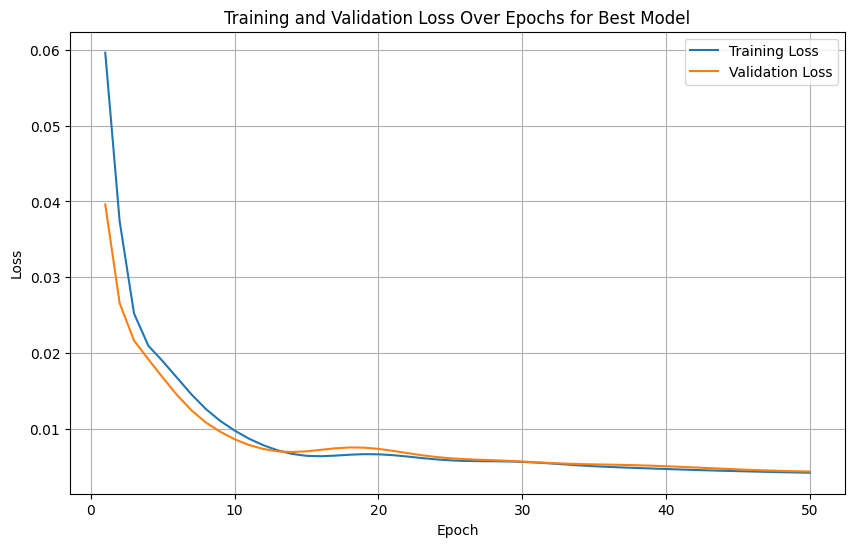

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), all_train_losses[0], label='Training Loss')
plt.plot(range(1, epochs + 1), all_val_losses[0], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs for Best Model')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
training_history = torch.load("/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models/x_SMALL_best_model_info_CONSIDERATION_thechallenge.pt", weights_only=False)
best_hidden_sizes = training_history["hyperparameters"]["hidden_sizes"]
model2 = NeuralNetwork(hidden_sizes=best_hidden_sizes)
model2.load_state_dict(training_history["model_state_dict"])

model2.eval()
with torch.no_grad():
    y_test_pred_tensor = model2(X_test_tensor)
    y_test_pred = y_test_pred_tensor.numpy()

# Calculate test metrics
test_mse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Root Mean Squared Error:", test_mse)
print("Test R^2 Score:", test_r2)

Test Root Mean Squared Error: 0.0374278233803238
Test R^2 Score: 0.8366925120353699


## Check with Jacobian

In [70]:
def FK(model, theta):
    t = theta.view(1, 2)
    out = model(t)
    out = out.view(2)
    return out

def FK_Jacobian(model, x):
    def forward_kinematics_fn(x):
        return FK(model, x)
    jacobian = torch.autograd.functional.jacobian(forward_kinematics_fn, x)

    return jacobian

def numerical_jacobian(model, theta, epsilon=1):
    theta_np = theta.detach().numpy()
    n = theta_np.size
    y0 = model.predict(theta_np.reshape(1, -1)).flatten()
    m = y0.size
    J = np.zeros((m, n))

    for i in range(n):
        theta_plus = theta_np.copy()
        theta_minus = theta_np.copy()
        theta_plus[i] += epsilon
        theta_minus[i] -= epsilon

        y_plus = model.predict(theta_plus.reshape(1, -1))
        y_minus = model.predict(theta_minus.reshape(1, -1))

        J[:, i] = (y_plus - y_minus).flatten() / (2 * epsilon)
    return J

# Analytical Jacobian
def analytical_jacobian(joint_angles):
    j0, j1 = joint_angles[0], joint_angles[1]
    j0 = j0.item()
    j1 = j1.item()

    # Calculate partial derivatives
    dx_dj0 = -L1 * np.sin(j0) - L2 * np.sin(j0 + j1)
    dx_dj1 = -L2 * np.sin(j0 + j1)
    dy_dj0 = L1 * np.cos(j0) + L2 * np.cos(j0 + j1)
    dy_dj1 = L2 * np.cos(j0 + j1)

    # Construct the Jacobian matrix
    J_analytical = np.array([[dx_dj0, dx_dj1], [dy_dj0, dy_dj1]])
    return J_analytical


In [71]:
# Models trained
Linear_regression_model = lr
Decision_tree_model = best_dt
SVR_model = best_svr
Random_forest_model = best_rf
KNN_model = best_knn

training_history = torch.load("/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models/AA_SMALL_best_model_info_CONSIDERATION.pt", weights_only=False)
best_hidden_sizes = training_history["hyperparameters"]["hidden_sizes"]
model = NeuralNetwork(hidden_sizes=best_hidden_sizes)
model.load_state_dict(training_history["model_state_dict"])
model.eval()


best_hidden_sizes = training_history["hyperparameters"]["hidden_sizes"]
NN_model = NeuralNetwork(hidden_sizes=best_hidden_sizes)
NN_model.load_state_dict(training_history["model_state_dict"])

L1 = 0.1  # Length of the first link
L2 = 0.1  # Length of the second link
epsilon=1e-3

# value for test of jacobian 0, -π/2
theta = torch.tensor([0, (np.pi/2)], dtype=torch.float32, requires_grad=True)
theta_other = np.array([0, -np.pi/2], dtype=np.float32)

J_learned_Liner_regression = numerical_jacobian(Linear_regression_model, theta, epsilon)

J_learned_Decision_tree = numerical_jacobian(Decision_tree_model, theta, epsilon)

J_learned_SVR = numerical_jacobian(SVR_model, theta, epsilon)

J_learned_Random_forest = numerical_jacobian(Random_forest_model, theta, epsilon)

J_learned_KNN = numerical_jacobian(KNN_model, theta, epsilon)

J_learned_NN = FK_Jacobian(NN_model, theta)
J_learned_NN_np = J_learned_NN.detach().numpy()

# Analytical Jacobian
J_analytical = analytical_jacobian(theta)

print("-----------------------------------Linear Regression---------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_Liner_regression, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_Liner_regression - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("------------------------------------------------------------------------------------------------")
print(" ")

print("-----------------------------------Decision Tree------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_Decision_tree, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_Decision_tree - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("------------------------------------------------------------------------------------------------")
print(" ")

print("--------------------------------------SVR-------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_SVR, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_SVR - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("------------------------------------------------------------------------------------------")
print(" ")

print("---------------------------------------Random Forest-------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_Random_forest, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_Random_forest - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("----------------------------------------------------------------------------------------------------")
print(" ")
print("--------------------------------------KNN--------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_KNN, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_KNN - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("-------------------------------------------------------------------------------------------")
print(" ")
print("--------------------------------------NN--------------------------------------------------")
print("Learned Jacobian:\n", np.array2string(J_learned_NN_np, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Analytical Jacobian:\n", np.array2string(J_analytical, formatter={'float_kind':lambda x: f"{x:.3f}"}))
difference = J_learned_NN_np - J_analytical
print("Difference between Learned and Analytical Jacobian:\n", np.array2string(difference, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("------------------------------------------------------------------------------------------")


-----------------------------------Linear Regression---------------------------------------------
Learned Jacobian:
 [[0.003 0.001]
 [0.016 -0.006]]
Analytical Jacobian:
 [[-0.100 -0.100]
 [0.100 -0.000]]
Difference between Learned and Analytical Jacobian:
 [[0.103 0.101]
 [-0.084 -0.006]]
------------------------------------------------------------------------------------------------
 
-----------------------------------Decision Tree------------------------------------------------
Learned Jacobian:
 [[0.000 0.000]
 [0.000 0.000]]
Analytical Jacobian:
 [[-0.100 -0.100]
 [0.100 -0.000]]
Difference between Learned and Analytical Jacobian:
 [[0.100 0.100]
 [-0.100 0.000]]
------------------------------------------------------------------------------------------------
 
--------------------------------------SVR-------------------------------------------------
Learned Jacobian:
 [[-0.081 -0.090]
 [0.113 0.008]]
Analytical Jacobian:
 [[-0.100 -0.100]
 [0.100 -0.000]]
Difference between Learn

### Check with metrics

In [80]:
file_path = '/content/drive/MyDrive/Machine_Learning/HW1/dataset/logfile_r2.csv'
data = pd.read_csv(file_path, delimiter=';')
filtered_data = data[['j0', 'j1', 'ft_x', 'ft_y']]

joint_angles = torch.tensor(X_test[['j0', 'j1']].values, dtype=torch.float32, requires_grad=True)
ground_truth_positions = torch.tensor(y_test[['ft_x', 'ft_y']].values, dtype=torch.float32)

def frobenius_norm(J_learned, J_analytical):
    return np.linalg.norm(J_learned - J_analytical)

# Select 100 samples from dataset
random_indices = np.random.choice(len(joint_angles), size=100, replace=False)
selected_angles = joint_angles[random_indices]


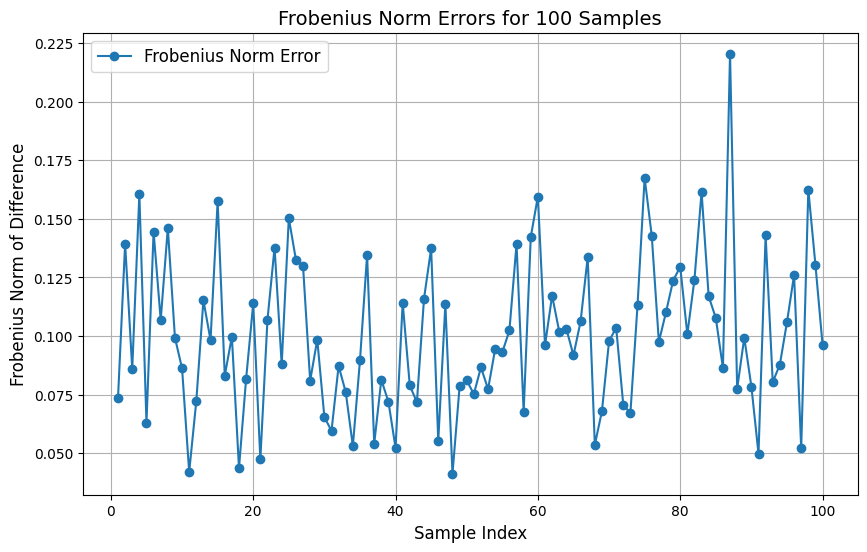

In [73]:
frobenius_errors = []

for theta in selected_angles:
    J_learned = FK_Jacobian(NN_model, theta)
    J_learned_np = J_learned.detach().numpy()

    J_analytical = analytical_jacobian(theta)

    frobenius_diff = frobenius_norm(J_learned_np, J_analytical)

    frobenius_errors.append(frobenius_diff)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(frobenius_errors) + 1), frobenius_errors, marker='o', linestyle='-', label='Frobenius Norm Error')
plt.title('Frobenius Norm Errors for 100 Samples', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Frobenius Norm of Difference', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


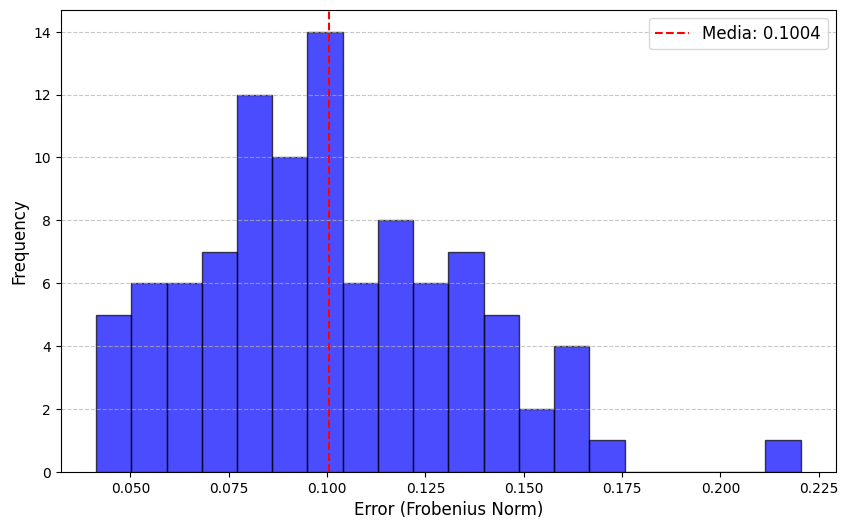

In [74]:
frobenius_errors = []

for theta in selected_angles:
    J_learned = FK_Jacobian(NN_model, theta)
    J_learned_np = J_learned.detach().numpy()

    J_analytical = analytical_jacobian(theta)

    frobenius_diff = frobenius_norm(J_learned_np, J_analytical)

    frobenius_errors.append(frobenius_diff)

# Genera un istogramma degli errori
plt.figure(figsize=(10, 6))
plt.hist(frobenius_errors, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Error (Frobenius Norm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(np.mean(frobenius_errors), color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {np.mean(frobenius_errors):.4f}')
plt.legend(fontsize=12)
plt.show()

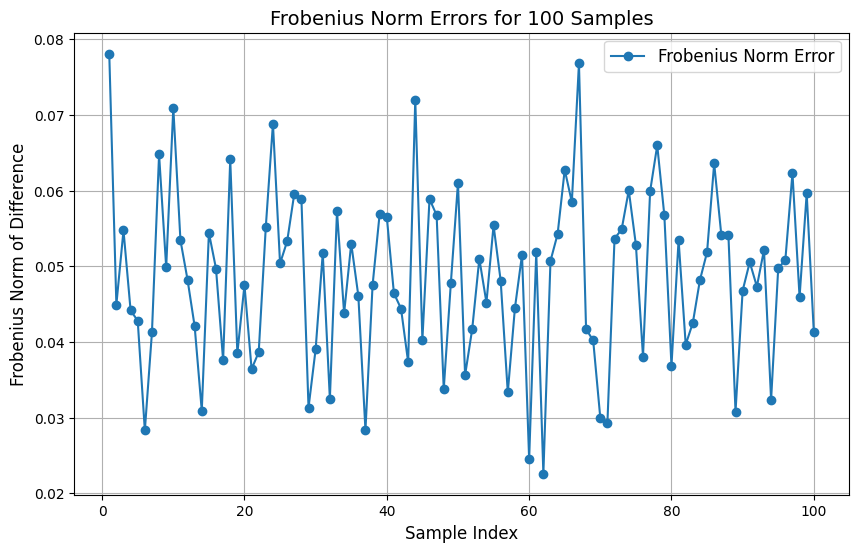

In [83]:
frobenius_errors = []

for theta in selected_angles:
    J_learned_np = numerical_jacobian(SVR_model, theta)

    J_analytical = analytical_jacobian(theta)

    frobenius_diff = frobenius_norm(J_learned_np, J_analytical)

    frobenius_errors.append(frobenius_diff)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(frobenius_errors) + 1), frobenius_errors, marker='o', linestyle='-', label='Frobenius Norm Error')
plt.title('Frobenius Norm Errors for 100 Samples', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Frobenius Norm of Difference', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


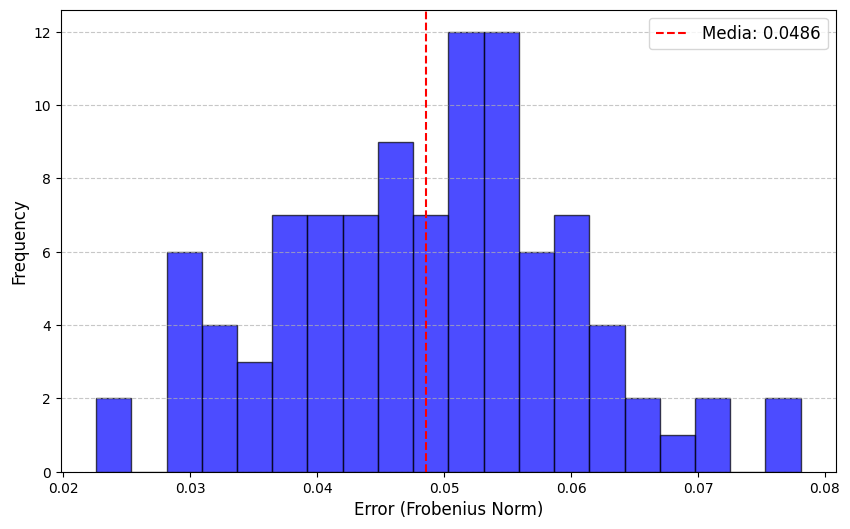

In [84]:
frobenius_errors = []

for theta in selected_angles:
    J_learned_np = numerical_jacobian(SVR_model, theta)

    J_analytical = analytical_jacobian(theta)

    frobenius_diff = frobenius_norm(J_learned_np, J_analytical)

    frobenius_errors.append(frobenius_diff)

# Genera un istogramma degli errori
plt.figure(figsize=(10, 6))
plt.hist(frobenius_errors, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Error (Frobenius Norm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(np.mean(frobenius_errors), color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {np.mean(frobenius_errors):.4f}')
plt.legend(fontsize=12)
plt.show()

## Inverse Kinematics

In [ ]:
def inverse_kinematics_newton_raphson(model, initial_joints, target_position, max_iters=10000, tolerance=1e-4):
    joints = initial_joints.clone().detach().requires_grad_(True)

    for i in range(max_iters):
        current_position = FK(model, joints)
        error = target_position - current_position
        if torch.norm(error) < tolerance:
            return joints.detach()
        #else:
          #print("MAX ITERS REACHED NEWTON")

        jacobian = FK_Jacobian(model, joints)
        try:
            delta_joints = torch.linalg.solve(jacobian, error)
        except RuntimeError as e:
            print("Errore nell'inversione del Jacobiano:", e)
            return joints.detach()

        joints = joints + delta_joints

    return joints.detach()

def inverse_kinematics_levenberg_marquardt(model, initial_joints, target_position, max_iters=10000, tolerance=1e-4, lambda_=0.05):
    joints = initial_joints.clone().detach().requires_grad_(True)

    for i in range(max_iters):
        current_position = FK(model, joints)
        error = target_position - current_position
        if torch.norm(error) < tolerance:
            return joints.detach()
        #else:
          #print("MAX ITERS REACHED LM")

        jacobian = FK_Jacobian(model, joints)

        # Update of Levenberg-Marquardt: (J^T J + λI) * delta_joints = J^T * error
        A = jacobian.T @ jacobian + lambda_ * torch.eye(jacobian.size(1))
        b = jacobian.T @ error

        try:
            delta_joints = torch.linalg.solve(A, b)
        except RuntimeError as e:
            print("Errore nell'inversione della matrice in Levenberg-Marquardt:", e)
            return joints.detach()

        joints = joints + delta_joints

    return joints.detach()

def compare_methods(model, initial_joints, target_position):
    # Newton-Raphson Method
    print("Newton-Raphson Method:")
    target_joints_nr = inverse_kinematics_newton_raphson(model, initial_joints, target_position)
    nr_error = torch.norm(FK(model, target_joints_nr) - target_position)
    print("Target joints Newton-Raphson:", target_joints_nr)
    print("Newton-Raphson Error:", nr_error.item())


    # Levenberg-Marquardt Method
    print("\nLevenberg-Marquardt Method:")
    target_joints_lm = inverse_kinematics_levenberg_marquardt(model, initial_joints, target_position)
    lm_error = torch.norm(FK(model, target_joints_lm) - target_position)
    print("Target joints Levenberg-Marquardt:", target_joints_lm)
    print("Levenberg-Marquardt Error:", lm_error.item())

    print(" ")
    print("--------------------------------------")
    print("Comparison target:", target_position, "Value computed by Newton-Raphson Method: ", FK(model, target_joints_nr).detach()) #.detach() is used for remove grad_fn=<ViewBackward0> from print
    print("Comparison target:", target_position, "Value computed by Levenberg Marquardt: ", FK(model, target_joints_lm).detach())


In [ ]:
training_history = torch.load("/content/drive/MyDrive/Machine_Learning/HW1/ROBOT _2_ARMS_models/AA_SMALL_best_model_info_CONSIDERATION.pt", weights_only=False)
best_hidden_sizes = training_history["hyperparameters"]["hidden_sizes"]
model = NeuralNetwork(hidden_sizes=best_hidden_sizes)
model.load_state_dict(training_history["model_state_dict"])
model.eval()

initial_joints = torch.tensor([0.0, np.pi/4], requires_grad=True)
#target_position = torch.tensor([-0.1, -0.1])
target_position = torch.tensor(y_test.sample(n=1).to_numpy().flatten(), dtype=torch.float32)
print(target_position)

compare_methods(model, initial_joints, target_position)


tensor([0.0100, 0.0110])
Newton-Raphson Method:
Target joints Newton-Raphson: tensor([-3.4544, -2.7748])
Newton-Raphson Error: 3.725290298461914e-08

Levenberg-Marquardt Method:
Target joints Levenberg-Marquardt: tensor([ 0.9200, -3.0001])
Levenberg-Marquardt Error: 0.04975510761141777
 
--------------------------------------
Comparison target: tensor([0.0100, 0.0110]) Value computed by Newton-Raphson Method:  tensor([0.0100, 0.0110])
Comparison target: tensor([0.0100, 0.0110]) Value computed by Levenberg Marquardt:  tensor([ 0.0525, -0.0149])


In [ ]:
def inverse_kinematics_newton_raphson(model, initial_joints, target_position, max_iters=10000, tolerance=1e-4):
    joints = torch.tensor(initial_joints, dtype=torch.float32)

    for i in range(max_iters):
        current_position = torch.tensor(model.predict(joints.unsqueeze(0).numpy()).flatten(), dtype=torch.float32)
        error = target_position.float() - current_position
        if torch.norm(error) < tolerance:
            return joints

        jacobian = numerical_jacobian(model, joints)
        J = torch.tensor(jacobian, dtype=torch.float32)
        try:
            delta_joints = torch.linalg.solve(J, error)
        except RuntimeError as e:
            print("Errore nell'inversione del Jacobiano:", e)
            return joints

        joints = joints + delta_joints

    return joints


def inverse_kinematics_levenberg_marquardt(model, initial_joints, target_position, max_iters=10000, tolerance=1e-4, lambda_=0.05):
    joints = torch.tensor(initial_joints, dtype=torch.float32)

    for i in range(max_iters):
        current_position = torch.tensor(model.predict(joints.unsqueeze(0).numpy()).flatten(), dtype=torch.float32)
        error = target_position.float() - current_position
        if torch.norm(error) < tolerance:
            return joints

        jacobian = numerical_jacobian(model, joints)
        J = torch.tensor(jacobian, dtype=torch.float32)
        A = J.T @ J + lambda_ * torch.eye(J.shape[1], dtype=torch.float32)
        b = J.T @ error  # `error` ora è garantito essere `torch.float32`

        try:
            delta_joints = torch.linalg.solve(A, b)
        except RuntimeError as e:
            print("Errore nell'inversione della matrice in Levenberg-Marquardt:", e)
            return joints

        joints = joints + delta_joints

    return joints


def compare_methods(model, initial_joints, target_position, model_name):
    print(f"\n{model_name} Results:")
    print(f"Target Position: {target_position}")

    # Newton-Raphson Method
    print("Newton-Raphson Method:")
    target_joints_nr = inverse_kinematics_newton_raphson(model, initial_joints, target_position)
    nr_error = torch.norm(torch.tensor(model.predict(target_joints_nr.unsqueeze(0).numpy()).flatten()) - target_position)
    print("Target joints Newton-Raphson:", target_joints_nr)
    print("Newton-Raphson Error:", nr_error.item())

    # Levenberg-Marquardt Method
    print("\nLevenberg-Marquardt Method:")
    target_joints_lm = inverse_kinematics_levenberg_marquardt(model, initial_joints, target_position)
    lm_error = torch.norm(torch.tensor(model.predict(target_joints_lm.unsqueeze(0).numpy()).flatten()) - target_position)
    print("Target joints Levenberg-Marquardt:", target_joints_lm)
    print("Levenberg-Marquardt Error:", lm_error.item())

    print("--------------------------------------")
    print("Comparison target:", target_position,
          "Value computed by Newton-Raphson Method: ",
          torch.tensor(model.predict(target_joints_nr.unsqueeze(0).numpy()).flatten()))
    print("Comparison target:", target_position,
          "Value computed by Levenberg-Marquardt Method: ",
          torch.tensor(model.predict(target_joints_lm.unsqueeze(0).numpy()).flatten()))


models = [("SVR", best_svr)]

initial_joints = [0.5, 0.5]
torch.tensor(y_test.sample(n=1).to_numpy().flatten(), dtype=torch.float32)

for model_name, model in models:
    compare_methods(model, initial_joints, target_position, model_name)



SVR Results:
Target Position: tensor([0.0100, 0.0110])
Newton-Raphson Method:
Target joints Newton-Raphson: tensor([-4.6290,  7.5482])
Newton-Raphson Error: 9.750925697497478e-06

Levenberg-Marquardt Method:
Target joints Levenberg-Marquardt: tensor([-1.5732,  3.1853])
Levenberg-Marquardt Error: 9.979437501265278e-05
--------------------------------------
Comparison target: tensor([0.0100, 0.0110]) Value computed by Newton-Raphson Method:  tensor([0.0100, 0.0110], dtype=torch.float64)
Comparison target: tensor([0.0100, 0.0110]) Value computed by Levenberg-Marquardt Method:  tensor([0.0101, 0.0111], dtype=torch.float64)
